In [ ]:
!pip install biopython

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

cd /content/drive/MyDrive/18.s997/project

Mounted at /content/drive


In [ ]:
import pandas as pd
filename = 'https://data.starklab.org/almeida/DeepSTARR/Tutorial/Sequences_activity_subset.txt' # subset of data (131,756 sequences), to be quicker, takes ~3min to load
# filename = 'https://data.starklab.org/almeida/DeepSTARR/Tutorial/Sequences_activity_all.txt' # if you want to try with the whole training data (484,052 sequences), takes ~3min to load

data = pd.read_table(filename)

In [ ]:
from Bio import SeqIO

def prepare_input(data_set):
    Y_dev = data_set.Dev_log2_enrichment
    Y_hk = data_set.Hk_log2_enrichment
    Y = pd.DataFrame()
    Y['Dev'] = Y_dev
    Y['Hk'] = Y_hk

    X = data_set['Sequence']

    return X, Y

def series_to_fasta(series, file_path):
    indices_excluded = []
    with open(file_path, 'w') as f:
        for i, sequence in enumerate(series, start=1):
            if 'N' in sequence:
                indices_excluded.append(i)
                continue
            f.write(f">Sequence_{i}\n")
            f.write(sequence + '\n')
    return indices_excluded

In [ ]:
X_train, Y_train = prepare_input(data[data['set'] == "Train"])

In [ ]:
series_to_fasta(X_train, "train_X.txt")

## wgan


In [ ]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

sys.path.append(".")

from common import Resblock, Seq_loader, onehot2seq, sequence2fa
from torch.utils.data import DataLoader

# if torch.cuda.is_available():
#     device = torch.device("cuda")
#     print("GPU is available")

class Generator(nn.Module):

    def __init__(self, model_dim = 512, resblock_kernelsize = 5, onehot_size = 4, nz = 128, seq_len = 50):
        super(Generator, self).__init__()
        self.seq_len = seq_len
        self.model_dim = model_dim
        self.linear = nn.Linear(nz, model_dim * seq_len, bias=True)
        self.resblock1 = Resblock(kernel_size=resblock_kernelsize)
        self.resblock2 = Resblock(kernel_size=resblock_kernelsize)
        self.resblock3 = Resblock(kernel_size=resblock_kernelsize)
        self.resblock4 = Resblock(kernel_size=resblock_kernelsize)
        self.resblock5 = Resblock(kernel_size=resblock_kernelsize)
        self.conv = nn.Conv1d(model_dim, onehot_size, 1)

    def forward(self, gen_inputs):
        outputs = self.linear(gen_inputs)
        outputs = outputs.view(-1, self.model_dim, self.seq_len)
        outputs = self.resblock1(outputs)
        outputs = self.resblock2(outputs)
        outputs = self.resblock3(outputs)
        outputs = self.resblock4(outputs)
        outputs = self.resblock5(outputs)
        outputs = self.conv(outputs)
        outputs = nn.Softmax(dim=1)(outputs)
        return outputs

class Discriminator(nn.Module):

    def __init__(self, model_dim = 512, resblock_kernelsize = 5, seq_len = 249):
        super(Discriminator, self).__init__()
        self.seq_len = seq_len
        self.model_dim = model_dim
        self.conv = nn.Conv1d(4, model_dim, kernel_size=5, padding=2)
        self.resblock1 = Resblock(kernel_size=resblock_kernelsize)  # For visualize results by torchinfo
        self.resblock2 = Resblock(kernel_size=resblock_kernelsize)
        self.resblock3 = Resblock(kernel_size=resblock_kernelsize)
        self.resblock4 = Resblock(kernel_size=resblock_kernelsize)
        self.resblock5 = Resblock(kernel_size=resblock_kernelsize)
        self.linear = nn.Linear(seq_len * model_dim, 1, bias=True)

    def forward(self, inputs):
        outputs = self.conv(inputs)
        outputs = self.resblock1(outputs)
        outputs = self.resblock2(outputs)
        outputs = self.resblock3(outputs)
        outputs = self.resblock4(outputs)
        outputs = self.resblock5(outputs)
        # print(outputs.shape)
        # outputs = self.resblock_part(outputs) # For visualize results by torchinfo
        outputs = outputs.reshape(-1, self.seq_len * self.model_dim)
        outputs = self.linear(outputs)
        return outputs

def cal_gradient_penalty(netD, real_samples, fake_samples):
    # Calculate the loss
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    alpha = torch.randn((len(fake_samples), 1, 1)).to(device)
    differences = fake_samples - real_samples
    interpolates = (real_samples + alpha * differences).requires_grad_(True)

    # Calculate the penalty cost
    out_interpolates = netD(interpolates)
    weight = torch.ones(out_interpolates.size()).to(device)
    gradients = torch.autograd.grad(outputs=out_interpolates,
                                    inputs=interpolates,
                                    grad_outputs=weight,
                                    retain_graph=True,
                                    create_graph=True,
                                    only_inputs=True)[0]
    gradients = gradients.reshape(gradients.size(0), -1)
    gradients_l2norm = torch.sqrt(torch.sum(gradients ** 2, dim=1))
    gradients_gp = torch.mean((gradients_l2norm - 1) ** 2)
    return gradients_gp

class WGAN_language:

    def __init__(self,
                 nz = 128,
                 netG_lr = 1e-4,
                 netD_lr = 1e-4,
                 batch_size = 32,
                 num_epochs = 12,
                 print_epoch = 1,
                 save_epoch = 1,
                 Lambda = 10,
                 length = 249,
                 model_name = 'wgan',

                 dataset = None, # Flexiable parts
                 savepath = None,
                 sample_model_path = None,
                 sample_number = None,
                 sample_output = None
                 ):

        self.nz = nz
        self.netG_lr = netG_lr
        self.netD_lr = netD_lr
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.print_epoch = print_epoch
        self.save_epoch = save_epoch
        self.LAMBDA = Lambda
        self.model_name = model_name
        self.seq_len = length

        # FIXED PART
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.netG = Generator(seq_len=length).to(self.device)
        self.netD = Discriminator(seq_len=length).to(self.device)

        # FLEXIABLE PART
        self.file = dataset
        self.checkpoint_root = savepath
        self.sample_model_path = sample_model_path
        self.sample_number = sample_number
        self.sample_output = sample_output

    def make_dir(self):
        self.base_dir = os.path.join(self.checkpoint_root, self.model_name)
        print("results will be saved in: ", self.base_dir)
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)

        if not os.path.exists(self.base_dir + '/figure'):
            os.makedirs(self.base_dir + '/figure')

        if not os.path.exists(self.base_dir + '/training_log'):
            os.makedirs(self.base_dir + '/training_log')

        if not os.path.exists(self.base_dir + '/checkpoints'):
            os.makedirs(self.base_dir + '/checkpoints')

    def train(self, dataset = None, savepath = None):

        if (self.file == None):
            self.file = dataset
        if (self.checkpoint_root == None):
            self.checkpoint_root = savepath

        self.make_dir()
        train_dataset = Seq_loader(self.file, seq_len=self.seq_len)
        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=self.batch_size, shuffle=True)

        # Define the neural networks
        netG = self.netG
        netD = self.netD
        # define the optimizer
        optimizer_G = optim.Adam(netG.parameters(), lr=self.netG_lr, betas=(0.5, 0.9))
        optimizer_D = optim.Adam(netD.parameters(), lr=self.netD_lr, betas=(0.5, 0.9))
        ## Training precedure
        Loss = {}
        for epoch in range(self.num_epochs):
            # for i, sample in enumerate(train_loader):
            for i, sample in enumerate(tqdm(train_loader)):

                ## Train the discriminator
                # Forward pass
                for p in netD.parameters():
                    p.requires_grad = True  # optimize D
                netD.zero_grad()  # initialize the grad
                real_samples = sample['onehot'].permute(0, 2, 1).to(self.device).float()
                real_samples = torch.autograd.Variable(real_samples)
                rand_tensor = torch.randn((len(real_samples), self.nz)).requires_grad_(True).to(self.device)
                # rand_tensor = torch.autograd.Variable(rand_tensor)
                fake_samples = netG(rand_tensor)
                fake_samples = fake_samples.detach()  # Detach not optimize the generator
                real_output = netD(real_samples)
                fake_output = netD(fake_samples)

                # WGAN loss with gradient panelty
                gradients_penalty = cal_gradient_penalty(netD, real_samples, fake_samples)
                # gradients_penalty = calc_gradient_penalty(netD,real_samples,fake_samples)
                disc_cost = fake_output.mean() - real_output.mean()
                disc_cost = disc_cost + self.LAMBDA * gradients_penalty
                # Optimize discriminator
                # disc_cost.backward(retain_graph=True)
                disc_cost.backward()
                optimizer_D.step()

                ## Train the generator
                for p in netD.parameters():
                    p.requires_grad = False  # freeze D
                netG.zero_grad()
                rand_tensor = torch.randn((len(fake_samples), self.nz)).to(self.device)
                # rand_tensor = torch.autograd.Variable(rand_tensor)
                fake_samples = netG(rand_tensor)
                fake_output = netD(fake_samples)
                gen_cost = -fake_output.mean()
                # Optimize generator
                gen_cost.backward()
                optimizer_G.step()

                ## Print the training loss
                if i % 10 == 0:
                    print("epoch[{}/{}] iter[{}/{}]: Training loss: disc_loss: {}, gradients_gp: {}, gen_loss: {}".
                          format(epoch + 1, self.num_epochs, i, len(train_loader), disc_cost, gradients_penalty, gen_cost))
                    # print(fake_samples[0][:,0:10])

                # print the training results
            if epoch % self.print_epoch == 0:
                netG.eval()
                all_sequence = []
                for m in range(50):
                    # torch.manual_seed(m+10086)  # Set one determined random seed
                    fixed_noise = torch.randn((self.batch_size, self.nz)).to(self.device)  #
                    fake_samples = netG(fixed_noise)  # Generate samples
                    fake_samples = fake_samples.permute(0, 2, 1)
                    sequence = onehot2seq(fake_samples, self.seq_len)  # Get the sequence and save
                    all_sequence = all_sequence + sequence
                sequence2fa(all_sequence, self.base_dir + '/training_log' + '/gen_' + 'iter_{}.txt'.format(epoch))  # Save the file

            if (epoch + 1) % self.save_epoch == 0:
                torch.save({'model': netG.state_dict()}, self.base_dir + '/checkpoints' + '/net_G_' + str(epoch+1) + '.pth')
                torch.save({'model': netD.state_dict()}, self.base_dir + '/checkpoints' + '/net_D_' + str(epoch+1) + '.pth')

    def generate(self, sample_model_path=None, sample_number=None, sample_output = True, seed = 0):

        if (self.sample_model_path == None):
            self.sample_model_path = sample_model_path
        if (self.sample_number == None):
            self.sample_number = sample_number
        if (self.sample_output == None):
            self.sample_output = sample_output

        tmp = os.path.basename(self.sample_model_path).split(".")[0]
        cur_epoch = tmp.split("_")[-1]

        torch.manual_seed(seed)
        if (self.sample_number > 10000):
            print('Too many numbers, it must < 10000')
            return 0

        # load and evaluate model:
        netG = self.netG
        state_dict = torch.load(self.sample_model_path)
        netG.load_state_dict(state_dict['model']) # ['model']
        netG.eval()

        file_list = self.sample_model_path.split("/")
        file_list.pop()
        file_list.pop()
        root = '/'.join(file_list)

        with torch.no_grad():
            fixed_noise = torch.randn((self.sample_number, self.nz)).to(self.device)
            out_data = netG(fixed_noise)
            out_data = out_data.permute(0, 2, 1)
            all_sequence = onehot2seq(out_data, seq_len=self.seq_len)

        if (self.sample_output):
            # path_samples = os.path.join(root, 'samples/sample_{}.txt'.format(seed))
            path_samples = os.path.join(root, 'samples/sample_ep{}_s{}_num_{}.txt'.format(cur_epoch, seed, sample_number))
            if not os.path.exists(os.path.dirname(path_samples)):
                os.mkdir(os.path.dirname(path_samples))
            print("samples will be saved in: ", path_samples)
            sequence2fa(all_sequence, path_samples)
        return all_sequence


In [ ]:
!pip install logomaker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 27.4 MB/s eta 0:00:00


In [ ]:
import sys
import os
import numpy as np
import pandas as pd

import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
import seaborn as sns
import logomaker


def open_fa(file):
    record = []
    f = open(file,'r')
    for item in f:
        if '>' not in item:
            record.append(item[0:-1])
    f.close()
    return record

def write_seq(file, data):
    f = open(file,'w')
    i = 0
    while i < len(data):
        f.write(data[i] + '\n')
        i = i + 1
    f.close()

def write_fa(file,data):
    f = open(file,'w')
    i = 0
    while i < len(data):
        f.write('>' + str(i) + '\n')
        f.write(data[i] + '\n')
        i = i + 1
    f.close()

def write_exp(file, data):
    f = open(file,'w')
    i = 0
    while i < len(data):
        f.write(str( np.round(data[i], 2)) + '\n')
        i = i + 1
    f.close()
    return


def write_profile(file, seqs, pred):
    path_csv = file
    res_dict = {"seqs": seqs, "pred":pred}
    df = pd.DataFrame(res_dict)
    df.to_csv(path_csv)


def freq_table_generation(samples):
    samples_num = len(samples)
    samples_length = len(samples[0])
    amino_dict = {"T":0, "C":1, "G":2, "A":3}

    table = np.zeros((4,samples_length))
    for i in range(samples_num):
        for j in range(samples_length):
            val = samples[i][j]
            val = int( amino_dict[val] )
            table[val][j] += 1

    res = np.zeros((4, samples_length))
    for k in range(samples_length):
        sum_k = np.sum(table[:,k])
        for t in range(4):
            res[t,k] = table[t,k]/sum_k
    return res

def plot_weblogos(file, seqs, plot_mode="saliency"):
    seq_len = len(seqs[0])
    alph = ["T", "C", "G", "A"]

    final_arr = freq_table_generation(seqs)

    cmap = sns.color_palette("PuBu", n_colors = 20)
    sns.set_style("whitegrid")

    nn_df = pd.DataFrame(data = final_arr).T
    nn_df.columns = alph
    nn_df.index = range(len(nn_df))
    nn_df = nn_df.fillna(0)

    font = {'size'   : 12}
    matplotlib.rc('font', **font)
    rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    fig, ax = plt.subplots(figsize = (np.minimum(seq_len / 4, 100), np.maximum(len(alph) / 3.5, 3)), dpi = 300)

    if 'saliency' in plot_mode:
        nn_df = logomaker.transform_matrix(nn_df, from_type = 'counts', to_type = 'weight')
    else:
        nn_df = logomaker.transform_matrix(nn_df, from_type = 'counts', to_type = 'probability')

    nn_logo = logomaker.Logo(nn_df, ax = ax, color_scheme = 'classic', stack_order = 'big_on_top', fade_below = 0.8, shade_below = 0.6)

    if 'saliency' in plot_mode:
        nn_logo.ax.set_ylabel('Weight', fontsize = 12)
    else:
        nn_logo.ax.set_yticks([0, 0.25, 0.50, 0.75, 1.0])
        nn_logo.ax.set_yticklabels(['0', '0.25', '0.50', '0.75', '1.0'], fontsize = 12)
        nn_logo.ax.set_ylabel('Probability', fontsize = 12)

    nn_logo.style_spines(visible = False)
    nn_logo.style_spines(spines = ['left'], visible = True)
    nn_logo.ax.set_xticks(np.arange(0, seq_len, 10))
    nn_logo.ax.set_xticklabels([str(x) for x in np.arange(0, seq_len, 10)], fontsize = 12)
    nn_logo.ax.set_xlabel('Position', fontsize = 12)

    plt.tight_layout()

    plotnamefinal = file
    print(' Weblogo saved to ' + plotnamefinal)
    plt.savefig(plotnamefinal)


def data_check(datapath):
    nt_map = ["A", "T", "C", "G"]

    with open(datapath, 'r') as file:
        last_line = file.readlines()[-1]

    # Step0: Enter Check
    if (last_line.endswith('\n') == False):
        print("Please add an enter in the last line\n")
        return

    data = open_fa(datapath)

    # Step1: vocab detection
    tmp_string = ''.join(data)
    tmp_vocab = list(set(tmp_string))

    vocab_in_list = all(key in nt_map for key in tmp_vocab)
    vocab_ood = [x for x in tmp_vocab if x not in nt_map]

    if (len(tmp_vocab) > 4 or vocab_in_list==False):
        print("Error character detection: ", vocab_ood)
        print("Please check if your input file contains only the four bases A, T, C, and G\n")
        return

    # Step2: alignment detection
    if len(set(len(x) for x in data)) > 1:
        indices = [i for i, x in enumerate(data) if len(x) not in {len(y) for y in data}]
        print("Error alignment detection: ", indices)
        print("Please check if the line lengths of the input file are all equal\n")
        return

    print("Your dataset is not problematic and suitable for training.\n")
    return

In [ ]:
import sys
import os
import numpy as np
import pandas as pd
# from base import *


def read_fa(file_name):
    seq = []
    with open(file_name, 'r') as f:
        for item in f:
            if '>' not in item:
                seq.append(item.strip('\n'))
    return seq


def seq2onehot(seq,length):
        module = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
        i = 0
        promoter_onehot = []
        while i < len(seq):
           tmp = []
           for item in seq[i]:
                if item == 't' or item == 'T':
                    tmp.append(module[0])
                elif item == 'c' or item == 'C':
                    tmp.append(module[1])
                elif item == 'g' or item == 'G':
                    tmp.append(module[2])
                elif item == 'a' or item == 'A':
                    tmp.append(module[3])
                else:
                    tmp.append([0,0,0,0])
           promoter_onehot.append(tmp)
           i = i + 1
        data = np.zeros((len(seq),length,4))
        data = np.float32(data)
        i = 0
        while i < len(seq):
            j = 0
            while j < len(seq[0]):
                data[i,j,:] = promoter_onehot[i][j]
                j = j + 1
            i = i + 1
        return data

def filter_for_experiment(seqpath, gc_strength=[0.2,0.8], poly_strength=5):

    seqs = open_fa(seqpath)
    res1, res2 = [], []

    # Step1: filter GC
    min_gc_ratio = gc_strength[0]
    max_gc_ratio = gc_strength[1]

    gc_res = []
    for string in seqs:
        g_count = string.count('G')
        c_count = string.count('C')

        total_count = len(string)
        gc_ratio = (g_count + c_count) / total_count
        gc_res.append(gc_ratio)

        if gc_ratio >= min_gc_ratio and gc_ratio <= max_gc_ratio:
            res1.append(string)

    # Step2: filter poly A,T

    poly_res = []
    for string in seqs:
        count_A = string.count('A' * poly_strength)
        count_T = string.count('T' * poly_strength)

        poly_res.append(count_A + count_T)

        if count_A == 0 and count_T == 0:
            res2.append(string)

    seqpath_txt = os.path.splitext(seqpath)[0] + "_filter.txt"
    seqpath_csv = os.path.splitext(seqpath)[0] + "_filter.csv"

    res_dict = {"seqs": seqs, "gc content":gc_res, "poly at": poly_res}
    df = pd.DataFrame(res_dict)
    df.to_csv(seqpath_csv)

    res = list( set(res1)  & set(res2) )
    write_seq(seqpath_txt, res)

    print("We have conducted quality assessment for each sequence you provided and selected the sequences that meet your screening strength.")
    print("Results have been save separately saved in .csv and .txt file with _filter suffix")
    return

## Plot Kmer Frequencies

In [ ]:
import os
import sys
import random
import numpy as np
import collections
from scipy.stats import pearsonr

import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# from utils.utils_evaluator import read_fa, seq2onehot

def convert(n, x, lens=4):
    list_a = [0,1,2,3,4,5,6,7,8,9,'A','b','C','D','E','F']
    list_b = []
    while True:
        s,y = divmod(n,x)
        list_b.append(y)
        if s == 0:
            break
        n = s
    list_b.reverse()
    res = []
    for i in range(lens):
        res.append(0)
    res0 = []
    for i in list_b:
        res0.append(list_a[i])
    for i in range(len(res0)):
        res[lens - i - 1] = res0[len(res0) - i - 1]
    return res

def kmer_count(sequence, k_size):
    bg = ['A', 'T', 'C', 'G']
    kmer_stat = collections.OrderedDict()
    kmer_name = []
    for i in range(4**k_size):
        nameJ = ''
        cov = convert(i, 4,  lens = k_size)
        for j in range(k_size):
            nameJ += bg[cov[j]]
        kmer_name.append(nameJ)
        kmer_stat[nameJ] = 0

    if isinstance(sequence[0], str):
        for i in range(len(sequence)):
            size = len(sequence[i])
            for j in range(len(sequence[i]) - k_size + 1):
                kmer = sequence[i][j: j + k_size]
                try:
                    kmer_stat[kmer] += 1
                except KeyError:
                    kmer_stat[kmer] = 1
    else:
        for i in range(len(sequence)):
            for j in range(len(sequence[i])):
                size = len(sequence[i][j])
                if size > k_size:
                    for k in range(len(sequence[i][j]) - k_size + 1):
                        kmer = sequence[i][j][k : k + k_size]
                        try:
                            kmer_stat[kmer] += 1
                        except KeyError:
                            kmer_stat[kmer] = 1
    return kmer_stat

def get_kmer_stat(generative_seq, control_seq, k_size):
    kmer_stat_control, kmer_stat_gen = kmer_count(control_seq, k_size), kmer_count(generative_seq, k_size)
    # Normalize
    total_control = sum(kmer_stat_control.values())
    kmer_stat_control = {k: v / total_control for k, v in kmer_stat_control.items()}
    total_gen = sum(kmer_stat_gen.values())
    kmer_stat_gen = {k: v / total_gen for k, v in kmer_stat_gen.items()}
    # Get the sorted dict
    kmer_stat_control, kmer_stat_gen = collections.OrderedDict(sorted(kmer_stat_control.items())),  collections.OrderedDict(sorted(kmer_stat_gen.items()))
    return kmer_stat_control, kmer_stat_gen




def plot_kmer_with_model(generator, generator_modelpath, generator_training_datapath, report_path, file_tag, K=6, num_seqs_to_test=10000):
    ## get training_text

    print("Evaluation of Generator Begin.")
    print("loading training dataset from: ", generator_training_datapath)
    training_text = read_fa(generator_training_datapath)
    if num_seqs_to_test > len(training_text):
        num_seqs_to_test = len(training_text)

    # get samples_text
    sampling_text = generator.generate(sample_model_path=generator_modelpath,
                                       sample_number=num_seqs_to_test, sample_output=False)

    # reduce computational costs
    random.shuffle(training_text)
    training_text = training_text[0:num_seqs_to_test]

    ## k-mer estimation
    kmer_stat_control, kmer_stat_model = get_kmer_stat(sampling_text, training_text, K)
    kmer_control_list = list(kmer_stat_control.items())
    kmer_model_list   = list(kmer_stat_model.items())
    control_mer, model_mer, control_val, model_val, ratio = [], [], [], [], []

    for i in range( pow(4,K) ):
        control_mer.append(kmer_control_list[i][0].upper())
        control_val.append(kmer_control_list[i][1])
        model_mer.append(kmer_model_list[i][0])
        model_val.append(kmer_model_list[i][1])
        if control_val[i] != 0:
            ratio.append(model_val[i]/control_val[i])
    pearsonr_val = pearsonr(model_val, control_val)[0]
    boundary = max(max(control_val), max(model_val))

    print("Model Pearson Correlation: {}, Boundary: {}".format(pearsonr_val, boundary) )

    tmp = ( str(boundary) ).split('.')[1]
    pos = len(tmp) - len(tmp.lstrip("0"))
    bound = (int(tmp[pos]) + 1) * pow(10,-pos-1)


    font = {'size' : 12}
    matplotlib.rc('font', **font)
    rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    fig, ax = plt.subplots(figsize = (6,4), dpi = 300)

    plt.xlim(0,bound)
    plt.ylim(0,bound)

    sns.regplot(x=control_val, y=model_val, color="green", scatter=False, truncate=False)
    plt.scatter(control_val,model_val, c="green", label=round(pearsonr_val,3), marker=".", s=30, alpha = 0.8, linewidths=0) # , marker=".", s=6, alpha = 0.8
    plt.legend(loc="upper left", markerscale = 1)
    ax.set_xlabel("Natural", fontsize=12)
    ax.set_ylabel("Model", fontsize=12)

    x = np.linspace(0,bound,100)
    y = np.linspace(0,bound,100)
    plt.plot(x, y, '--', c='b', alpha = 0.6)
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks(np.linspace(0, bound, 10+1))
    ax.set_yticks(np.linspace(0, bound, 10+1))

    plotnamefinal = report_path + 'kmer_' + file_tag + ".png"
    plt.tight_layout()
    plt.savefig(plotnamefinal)

    print('Kmer frequency plot saved to ' + plotnamefinal)
    return (pearsonr_val, plotnamefinal)


def plot_kmer(generator_training_datapath, generator_sampling_datapath, report_path, file_tag, K=6, num_seqs_to_test=10000):
    training_text = read_fa(generator_training_datapath)
    sampling_text = read_fa(generator_sampling_datapath)

    if num_seqs_to_test > min(len(training_text), len(sampling_text)):
        num_seqs_to_test = min(len(training_text), len(sampling_text))

    random.shuffle(training_text)
    random.shuffle(sampling_text)
    training_text = training_text[0:num_seqs_to_test]
    sampling_text = sampling_text[0:num_seqs_to_test]

    ## k-mer estimation
    kmer_stat_control, kmer_stat_model = get_kmer_stat(sampling_text, training_text, K)
    kmer_control_list = list(kmer_stat_control.items())
    kmer_model_list   = list(kmer_stat_model.items())
    control_mer, model_mer, control_val, model_val, ratio = [], [], [], [], []

    for i in range( pow(4,K) ):
        control_mer.append(kmer_control_list[i][0].upper())
        control_val.append(kmer_control_list[i][1])
        model_mer.append(kmer_model_list[i][0])
        model_val.append(kmer_model_list[i][1])
        if control_val[i] != 0:
            ratio.append(model_val[i]/control_val[i])
    pearsonr_val = pearsonr(model_val, control_val)[0]
    boundary = max(max(control_val), max(model_val))

    print("Model Pearson Correlation: {}, Boundary: {}".format(pearsonr_val, boundary) )

    tmp = ( str(boundary) ).split('.')[1]
    pos = len(tmp) - len(tmp.lstrip("0"))
    bound = (int(tmp[pos]) + 1) * pow(10,-pos-1)


    font = {'size' : 12}
    matplotlib.rc('font', **font)
    rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    fig, ax = plt.subplots(figsize = (6,4), dpi = 300)

    plt.xlim(0,bound)
    plt.ylim(0,bound)

    sns.regplot(x=control_val, y=model_val, color="green", scatter=False, truncate=False)
    plt.scatter(control_val,model_val, c="green", label=round(pearsonr_val,3), marker=".", s=30, alpha = 0.8, linewidths=0) # , marker=".", s=6, alpha = 0.8
    plt.legend(loc="upper left", markerscale = 1)
    ax.set_xlabel("Natural", fontsize=12)
    ax.set_ylabel("Model", fontsize=12)

    x = np.linspace(0,bound,100)
    y = np.linspace(0,bound,100)
    plt.plot(x, y, '--', c='b', alpha = 0.6)
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks(np.linspace(0, bound, 10+1))
    ax.set_yticks(np.linspace(0, bound, 10+1))

    plotnamefinal = report_path + 'kmer_' + file_tag + ".png"
    plt.tight_layout()
    plt.savefig(plotnamefinal)

    print('Kmer frequency plot saved to ' + plotnamefinal)
    return (pearsonr_val, plotnamefinal)

In [ ]:
## Step 1

dataset_path = 'train_X.txt'
checkpoint_path = 'checkpoints'
model = WGAN_language(length=249, num_epochs=12, print_epoch = 12, save_epoch = 12)
model.train(dataset=dataset_path, savepath=checkpoint_path)

## Step 2

model = WGAN_language(length=249)
sample_modelpath = "checkpoints/wgan/checkpoints/net_G_12.pth"
sample_number = 1000
model.generate(sample_modelpath, sample_number)

###########################
#####   Displaying    #####
###########################

# ## Step 3

# generator = WGAN_language(length=249)
# generator_training_datapath = './datasets/sequence_data.txt'
# generator_modelpath = "./checkpoints/wgan/checkpoints/net_G_12.pth"
# plot_kmer_with_model(generator, generator_modelpath,  generator_training_datapath,
#                          report_path="./results/", file_tag="WGAN_01")

# ## Step 4

# generator_training_datapath = './datasets/sequence_data.txt'
# generator_sampling_datapath = './checkpoints/wgan/samples/sample_ep12_s0_num_10000.txt'
# plot_kmer(generator_training_datapath, generator_sampling_datapath, report_path="./results/", file_tag="WGAN_02")

results will be saved in:  checkpoints/wgan


  0%|          | 1/1563 [00:02<58:50,  2.26s/it]

epoch[1/12] iter[0/1563]: Training loss: disc_loss: 4.463419437408447, gradients_gp: 0.4462096095085144, gen_loss: -0.06473797559738159


  1%|          | 11/1563 [00:09<21:15,  1.22it/s]

epoch[1/12] iter[10/1563]: Training loss: disc_loss: -8.538620948791504, gradients_gp: 0.35243016481399536, gen_loss: -2.318995475769043


  1%|▏         | 21/1563 [00:17<20:56,  1.23it/s]

epoch[1/12] iter[20/1563]: Training loss: disc_loss: -16.443603515625, gradients_gp: 1.021458387374878, gen_loss: 6.306147575378418


  2%|▏         | 31/1563 [00:24<21:09,  1.21it/s]

epoch[1/12] iter[30/1563]: Training loss: disc_loss: -15.291001319885254, gradients_gp: 0.41079357266426086, gen_loss: -3.0005598068237305


  3%|▎         | 41/1563 [00:32<21:23,  1.19it/s]

epoch[1/12] iter[40/1563]: Training loss: disc_loss: -14.476190567016602, gradients_gp: 0.22783875465393066, gen_loss: 3.5361366271972656


  3%|▎         | 51/1563 [00:40<21:23,  1.18it/s]

epoch[1/12] iter[50/1563]: Training loss: disc_loss: -14.1968994140625, gradients_gp: 0.17088718712329865, gen_loss: 1.9376659393310547


  4%|▍         | 61/1563 [00:48<21:35,  1.16it/s]

epoch[1/12] iter[60/1563]: Training loss: disc_loss: -13.727986335754395, gradients_gp: 0.3950289487838745, gen_loss: 6.043453216552734


  5%|▍         | 71/1563 [00:56<21:49,  1.14it/s]

epoch[1/12] iter[70/1563]: Training loss: disc_loss: -14.989398956298828, gradients_gp: 0.4092700481414795, gen_loss: 6.8105268478393555


  5%|▌         | 81/1563 [01:04<22:03,  1.12it/s]

epoch[1/12] iter[80/1563]: Training loss: disc_loss: -11.738608360290527, gradients_gp: 0.5082567930221558, gen_loss: 5.316279411315918


  6%|▌         | 91/1563 [01:13<22:16,  1.10it/s]

epoch[1/12] iter[90/1563]: Training loss: disc_loss: -10.453567504882812, gradients_gp: 0.462965726852417, gen_loss: -6.129697799682617


  6%|▋         | 101/1563 [01:21<22:15,  1.09it/s]

epoch[1/12] iter[100/1563]: Training loss: disc_loss: -9.862546920776367, gradients_gp: 0.20808911323547363, gen_loss: -2.1298513412475586


  7%|▋         | 111/1563 [01:30<22:23,  1.08it/s]

epoch[1/12] iter[110/1563]: Training loss: disc_loss: -9.1146240234375, gradients_gp: 0.42730462551116943, gen_loss: -4.138463497161865


  8%|▊         | 121/1563 [01:39<22:39,  1.06it/s]

epoch[1/12] iter[120/1563]: Training loss: disc_loss: -7.339876651763916, gradients_gp: 0.071206234395504, gen_loss: -5.305758476257324


  8%|▊         | 131/1563 [01:48<23:05,  1.03it/s]

epoch[1/12] iter[130/1563]: Training loss: disc_loss: -12.04517936706543, gradients_gp: 0.5985838174819946, gen_loss: 5.633688449859619


  9%|▉         | 141/1563 [01:57<23:24,  1.01it/s]

epoch[1/12] iter[140/1563]: Training loss: disc_loss: -4.772097587585449, gradients_gp: 0.06606557965278625, gen_loss: -4.010896682739258


 10%|▉         | 151/1563 [02:06<22:43,  1.04it/s]

epoch[1/12] iter[150/1563]: Training loss: disc_loss: -15.515192031860352, gradients_gp: 0.31151485443115234, gen_loss: -1.3633160591125488


 10%|█         | 161/1563 [02:15<22:13,  1.05it/s]

epoch[1/12] iter[160/1563]: Training loss: disc_loss: -10.311253547668457, gradients_gp: 0.2803337872028351, gen_loss: -22.76701545715332


 11%|█         | 171/1563 [02:23<21:43,  1.07it/s]

epoch[1/12] iter[170/1563]: Training loss: disc_loss: -4.061038970947266, gradients_gp: 0.5947748422622681, gen_loss: -11.380531311035156


 12%|█▏        | 181/1563 [02:32<21:26,  1.07it/s]

epoch[1/12] iter[180/1563]: Training loss: disc_loss: -4.110136985778809, gradients_gp: 0.15069568157196045, gen_loss: -4.68719482421875


 12%|█▏        | 191/1563 [02:41<21:07,  1.08it/s]

epoch[1/12] iter[190/1563]: Training loss: disc_loss: -3.1770076751708984, gradients_gp: 0.013167427852749825, gen_loss: -6.894499778747559


 13%|█▎        | 201/1563 [02:49<21:00,  1.08it/s]

epoch[1/12] iter[200/1563]: Training loss: disc_loss: -4.006646633148193, gradients_gp: 0.07121345400810242, gen_loss: -6.080012321472168


 13%|█▎        | 211/1563 [02:58<21:02,  1.07it/s]

epoch[1/12] iter[210/1563]: Training loss: disc_loss: -2.0378453731536865, gradients_gp: 0.015250029042363167, gen_loss: -13.523475646972656


 14%|█▍        | 221/1563 [03:06<21:02,  1.06it/s]

epoch[1/12] iter[220/1563]: Training loss: disc_loss: -4.992561340332031, gradients_gp: 0.1330852210521698, gen_loss: -15.45600700378418


 15%|█▍        | 231/1563 [03:15<21:06,  1.05it/s]

epoch[1/12] iter[230/1563]: Training loss: disc_loss: -3.8428139686584473, gradients_gp: 0.08609595894813538, gen_loss: 12.254361152648926


 15%|█▌        | 241/1563 [03:24<21:05,  1.04it/s]

epoch[1/12] iter[240/1563]: Training loss: disc_loss: -1.9345122575759888, gradients_gp: 0.02220849134027958, gen_loss: -8.688475608825684


 16%|█▌        | 251/1563 [03:33<20:50,  1.05it/s]

epoch[1/12] iter[250/1563]: Training loss: disc_loss: -5.539941787719727, gradients_gp: 0.2140619456768036, gen_loss: 4.132798194885254


 17%|█▋        | 261/1563 [03:42<20:38,  1.05it/s]

epoch[1/12] iter[260/1563]: Training loss: disc_loss: -2.5067858695983887, gradients_gp: 0.06800208985805511, gen_loss: -8.320255279541016


 17%|█▋        | 271/1563 [03:51<20:20,  1.06it/s]

epoch[1/12] iter[270/1563]: Training loss: disc_loss: -4.818725109100342, gradients_gp: 0.04792865365743637, gen_loss: 0.922951340675354


 18%|█▊        | 281/1563 [03:59<20:07,  1.06it/s]

epoch[1/12] iter[280/1563]: Training loss: disc_loss: -4.1176862716674805, gradients_gp: 0.028912372887134552, gen_loss: -13.547879219055176


 19%|█▊        | 291/1563 [04:08<19:57,  1.06it/s]

epoch[1/12] iter[290/1563]: Training loss: disc_loss: -4.1729278564453125, gradients_gp: 0.08679422736167908, gen_loss: -8.956643104553223


 19%|█▉        | 301/1563 [04:17<19:50,  1.06it/s]

epoch[1/12] iter[300/1563]: Training loss: disc_loss: -3.342956304550171, gradients_gp: 0.01735101267695427, gen_loss: 5.590311050415039


 20%|█▉        | 311/1563 [04:26<19:42,  1.06it/s]

epoch[1/12] iter[310/1563]: Training loss: disc_loss: -6.174009799957275, gradients_gp: 0.11995808035135269, gen_loss: -11.782312393188477


 21%|██        | 321/1563 [04:34<19:36,  1.06it/s]

epoch[1/12] iter[320/1563]: Training loss: disc_loss: -3.705742359161377, gradients_gp: 0.05420403182506561, gen_loss: -1.2235004901885986


 21%|██        | 331/1563 [04:43<19:30,  1.05it/s]

epoch[1/12] iter[330/1563]: Training loss: disc_loss: -5.791987419128418, gradients_gp: 0.086968794465065, gen_loss: 7.830532073974609


 22%|██▏       | 341/1563 [04:52<19:23,  1.05it/s]

epoch[1/12] iter[340/1563]: Training loss: disc_loss: -3.0272202491760254, gradients_gp: 0.026296798139810562, gen_loss: 7.840866565704346


 22%|██▏       | 351/1563 [05:01<19:11,  1.05it/s]

epoch[1/12] iter[350/1563]: Training loss: disc_loss: -3.7785332202911377, gradients_gp: 0.0690314993262291, gen_loss: 5.477323055267334


 23%|██▎       | 361/1563 [05:10<19:02,  1.05it/s]

epoch[1/12] iter[360/1563]: Training loss: disc_loss: -2.96496844291687, gradients_gp: 0.04119264334440231, gen_loss: 10.915764808654785


 24%|██▎       | 371/1563 [05:19<18:51,  1.05it/s]

epoch[1/12] iter[370/1563]: Training loss: disc_loss: -3.8183038234710693, gradients_gp: 0.03239447996020317, gen_loss: 15.401121139526367


 24%|██▍       | 381/1563 [05:27<18:42,  1.05it/s]

epoch[1/12] iter[380/1563]: Training loss: disc_loss: -1.8462802171707153, gradients_gp: 0.06276136636734009, gen_loss: -2.629408359527588


 25%|██▌       | 391/1563 [05:36<18:27,  1.06it/s]

epoch[1/12] iter[390/1563]: Training loss: disc_loss: -1.4099302291870117, gradients_gp: 0.030991271138191223, gen_loss: -8.595335006713867


 26%|██▌       | 401/1563 [05:45<18:18,  1.06it/s]

epoch[1/12] iter[400/1563]: Training loss: disc_loss: -2.6060259342193604, gradients_gp: 0.012339187785983086, gen_loss: 6.127475738525391


 26%|██▋       | 411/1563 [05:54<18:01,  1.07it/s]

epoch[1/12] iter[410/1563]: Training loss: disc_loss: -2.3858697414398193, gradients_gp: 0.008486781269311905, gen_loss: -2.679327964782715


 27%|██▋       | 421/1563 [06:02<17:52,  1.06it/s]

epoch[1/12] iter[420/1563]: Training loss: disc_loss: -2.7488174438476562, gradients_gp: 0.01603071205317974, gen_loss: 4.205357551574707


 28%|██▊       | 431/1563 [06:11<17:46,  1.06it/s]

epoch[1/12] iter[430/1563]: Training loss: disc_loss: -2.192891836166382, gradients_gp: 0.026205655187368393, gen_loss: 1.4029457569122314


 28%|██▊       | 441/1563 [06:20<17:39,  1.06it/s]

epoch[1/12] iter[440/1563]: Training loss: disc_loss: -2.9188685417175293, gradients_gp: 0.019920051097869873, gen_loss: -0.5785216093063354


 29%|██▉       | 451/1563 [06:29<17:28,  1.06it/s]

epoch[1/12] iter[450/1563]: Training loss: disc_loss: -3.0063812732696533, gradients_gp: 0.16181161999702454, gen_loss: 6.426161766052246


 29%|██▉       | 461/1563 [06:37<17:21,  1.06it/s]

epoch[1/12] iter[460/1563]: Training loss: disc_loss: -2.754917621612549, gradients_gp: 0.03943935036659241, gen_loss: -1.9508657455444336


 30%|███       | 471/1563 [06:46<17:14,  1.06it/s]

epoch[1/12] iter[470/1563]: Training loss: disc_loss: -2.7431716918945312, gradients_gp: 0.008617396466434002, gen_loss: 2.505887031555176


 31%|███       | 481/1563 [06:55<17:05,  1.05it/s]

epoch[1/12] iter[480/1563]: Training loss: disc_loss: -3.4176716804504395, gradients_gp: 0.03413262218236923, gen_loss: 15.447898864746094


 31%|███▏      | 491/1563 [07:04<16:55,  1.06it/s]

epoch[1/12] iter[490/1563]: Training loss: disc_loss: -0.43177491426467896, gradients_gp: 0.034054070711135864, gen_loss: -2.529141902923584


 32%|███▏      | 501/1563 [07:13<16:45,  1.06it/s]

epoch[1/12] iter[500/1563]: Training loss: disc_loss: -0.8364481925964355, gradients_gp: 0.03224434703588486, gen_loss: -9.473885536193848


 33%|███▎      | 511/1563 [07:21<16:39,  1.05it/s]

epoch[1/12] iter[510/1563]: Training loss: disc_loss: -2.477088689804077, gradients_gp: 0.027950089424848557, gen_loss: 5.828496932983398


 33%|███▎      | 521/1563 [07:30<16:33,  1.05it/s]

epoch[1/12] iter[520/1563]: Training loss: disc_loss: -1.6455116271972656, gradients_gp: 0.07489867508411407, gen_loss: 4.8068952560424805


 34%|███▍      | 531/1563 [07:39<16:19,  1.05it/s]

epoch[1/12] iter[530/1563]: Training loss: disc_loss: -2.9856786727905273, gradients_gp: 0.027533724904060364, gen_loss: -5.484434127807617


 35%|███▍      | 541/1563 [07:48<16:11,  1.05it/s]

epoch[1/12] iter[540/1563]: Training loss: disc_loss: -3.831564426422119, gradients_gp: 0.07409091293811798, gen_loss: -3.458536148071289


 35%|███▌      | 551/1563 [07:57<16:01,  1.05it/s]

epoch[1/12] iter[550/1563]: Training loss: disc_loss: -1.5964000225067139, gradients_gp: 0.019423507153987885, gen_loss: 6.269186019897461


 36%|███▌      | 561/1563 [08:05<15:50,  1.05it/s]

epoch[1/12] iter[560/1563]: Training loss: disc_loss: -1.9915544986724854, gradients_gp: 0.04316752031445503, gen_loss: -2.070525646209717


 37%|███▋      | 571/1563 [08:14<15:45,  1.05it/s]

epoch[1/12] iter[570/1563]: Training loss: disc_loss: -2.660898208618164, gradients_gp: 0.07011020928621292, gen_loss: 3.2451815605163574


 37%|███▋      | 581/1563 [08:23<15:33,  1.05it/s]

epoch[1/12] iter[580/1563]: Training loss: disc_loss: -2.721179723739624, gradients_gp: 0.018999772146344185, gen_loss: 4.413415908813477


 38%|███▊      | 591/1563 [08:32<15:25,  1.05it/s]

epoch[1/12] iter[590/1563]: Training loss: disc_loss: -1.7532597780227661, gradients_gp: 0.036703720688819885, gen_loss: 9.007284164428711


 38%|███▊      | 601/1563 [08:41<15:13,  1.05it/s]

epoch[1/12] iter[600/1563]: Training loss: disc_loss: -0.4502747654914856, gradients_gp: 0.004782741889357567, gen_loss: 2.6686105728149414


 39%|███▉      | 611/1563 [08:50<15:03,  1.05it/s]

epoch[1/12] iter[610/1563]: Training loss: disc_loss: 1.9897528886795044, gradients_gp: 0.02934313751757145, gen_loss: 3.561957359313965


 40%|███▉      | 621/1563 [08:58<14:49,  1.06it/s]

epoch[1/12] iter[620/1563]: Training loss: disc_loss: 0.20995761454105377, gradients_gp: 0.019916631281375885, gen_loss: 2.021681308746338


 40%|████      | 631/1563 [09:07<14:36,  1.06it/s]

epoch[1/12] iter[630/1563]: Training loss: disc_loss: -1.4785792827606201, gradients_gp: 0.014037825167179108, gen_loss: -13.712566375732422


 41%|████      | 641/1563 [09:16<14:26,  1.06it/s]

epoch[1/12] iter[640/1563]: Training loss: disc_loss: -0.5969897508621216, gradients_gp: 0.010900432243943214, gen_loss: 0.004003196954727173


 42%|████▏     | 651/1563 [09:25<14:15,  1.07it/s]

epoch[1/12] iter[650/1563]: Training loss: disc_loss: -0.28218400478363037, gradients_gp: 0.01632133685052395, gen_loss: 18.43998908996582


 42%|████▏     | 661/1563 [09:33<14:06,  1.07it/s]

epoch[1/12] iter[660/1563]: Training loss: disc_loss: -2.929176092147827, gradients_gp: 0.00650533102452755, gen_loss: 17.23822784423828


 43%|████▎     | 671/1563 [09:42<13:57,  1.07it/s]

epoch[1/12] iter[670/1563]: Training loss: disc_loss: -1.5456581115722656, gradients_gp: 0.01842482201755047, gen_loss: 10.13494873046875


 44%|████▎     | 681/1563 [09:51<13:54,  1.06it/s]

epoch[1/12] iter[680/1563]: Training loss: disc_loss: -2.1042888164520264, gradients_gp: 0.0219969991594553, gen_loss: 11.851203918457031


 44%|████▍     | 691/1563 [09:59<13:47,  1.05it/s]

epoch[1/12] iter[690/1563]: Training loss: disc_loss: -2.4190683364868164, gradients_gp: 0.004432871472090483, gen_loss: -6.321683883666992


 45%|████▍     | 701/1563 [10:08<13:39,  1.05it/s]

epoch[1/12] iter[700/1563]: Training loss: disc_loss: -0.8499398827552795, gradients_gp: 0.011962073855102062, gen_loss: -6.730251312255859


 45%|████▌     | 711/1563 [10:17<13:30,  1.05it/s]

epoch[1/12] iter[710/1563]: Training loss: disc_loss: -1.1248984336853027, gradients_gp: 0.12514004111289978, gen_loss: 20.597551345825195


 46%|████▌     | 721/1563 [10:26<13:17,  1.06it/s]

epoch[1/12] iter[720/1563]: Training loss: disc_loss: -2.433683156967163, gradients_gp: 0.036156486719846725, gen_loss: 20.499980926513672


 47%|████▋     | 731/1563 [10:35<13:06,  1.06it/s]

epoch[1/12] iter[730/1563]: Training loss: disc_loss: 0.1382395476102829, gradients_gp: 0.0016700427513569593, gen_loss: 10.07550048828125


 47%|████▋     | 741/1563 [10:43<12:55,  1.06it/s]

epoch[1/12] iter[740/1563]: Training loss: disc_loss: -0.2158948928117752, gradients_gp: 0.008615760132670403, gen_loss: 10.40999984741211


 48%|████▊     | 751/1563 [10:52<12:43,  1.06it/s]

epoch[1/12] iter[750/1563]: Training loss: disc_loss: -0.6114850640296936, gradients_gp: 0.003519386053085327, gen_loss: 5.895650386810303


 49%|████▊     | 761/1563 [11:01<12:31,  1.07it/s]

epoch[1/12] iter[760/1563]: Training loss: disc_loss: -0.13084924221038818, gradients_gp: 0.043960392475128174, gen_loss: -2.5810093879699707


 49%|████▉     | 771/1563 [11:10<12:26,  1.06it/s]

epoch[1/12] iter[770/1563]: Training loss: disc_loss: -0.16404318809509277, gradients_gp: 0.013187002390623093, gen_loss: -6.326472759246826


 50%|████▉     | 781/1563 [11:18<12:15,  1.06it/s]

epoch[1/12] iter[780/1563]: Training loss: disc_loss: -1.3736084699630737, gradients_gp: 0.00789385661482811, gen_loss: 29.719139099121094


 51%|█████     | 791/1563 [11:27<12:06,  1.06it/s]

epoch[1/12] iter[790/1563]: Training loss: disc_loss: -2.4171948432922363, gradients_gp: 0.009872112423181534, gen_loss: 16.136856079101562


 51%|█████     | 801/1563 [11:36<11:56,  1.06it/s]

epoch[1/12] iter[800/1563]: Training loss: disc_loss: -1.6082381010055542, gradients_gp: 0.02935105934739113, gen_loss: 11.973414421081543


 52%|█████▏    | 811/1563 [11:45<11:46,  1.06it/s]

epoch[1/12] iter[810/1563]: Training loss: disc_loss: -1.468612790107727, gradients_gp: 0.008237821981310844, gen_loss: 10.033197402954102


 53%|█████▎    | 821/1563 [11:53<11:42,  1.06it/s]

epoch[1/12] iter[820/1563]: Training loss: disc_loss: 0.7337368726730347, gradients_gp: 0.011153781786561012, gen_loss: 5.603711128234863


 53%|█████▎    | 831/1563 [12:02<11:33,  1.06it/s]

epoch[1/12] iter[830/1563]: Training loss: disc_loss: 1.0808477401733398, gradients_gp: 0.033993907272815704, gen_loss: 17.469070434570312


 54%|█████▍    | 841/1563 [12:11<11:24,  1.06it/s]

epoch[1/12] iter[840/1563]: Training loss: disc_loss: 1.3518661260604858, gradients_gp: 0.12300895899534225, gen_loss: 8.054104804992676


 54%|█████▍    | 851/1563 [12:20<11:14,  1.06it/s]

epoch[1/12] iter[850/1563]: Training loss: disc_loss: 0.09363213181495667, gradients_gp: 0.017178896814584732, gen_loss: 6.1683149337768555


 55%|█████▌    | 861/1563 [12:28<11:04,  1.06it/s]

epoch[1/12] iter[860/1563]: Training loss: disc_loss: 0.0054395198822021484, gradients_gp: 0.0747482031583786, gen_loss: -6.501027584075928


 56%|█████▌    | 871/1563 [12:37<10:52,  1.06it/s]

epoch[1/12] iter[870/1563]: Training loss: disc_loss: -1.1725882291793823, gradients_gp: 0.02222149632871151, gen_loss: 8.931324005126953


 56%|█████▋    | 881/1563 [12:46<10:40,  1.06it/s]

epoch[1/12] iter[880/1563]: Training loss: disc_loss: -1.6353346109390259, gradients_gp: 0.025109805166721344, gen_loss: 17.481605529785156


 57%|█████▋    | 891/1563 [12:55<10:31,  1.06it/s]

epoch[1/12] iter[890/1563]: Training loss: disc_loss: 0.45222991704940796, gradients_gp: 0.05962137505412102, gen_loss: -2.592031240463257


 58%|█████▊    | 901/1563 [13:03<10:20,  1.07it/s]

epoch[1/12] iter[900/1563]: Training loss: disc_loss: -0.371846079826355, gradients_gp: 0.008635054342448711, gen_loss: 8.374063491821289


 58%|█████▊    | 911/1563 [13:12<10:15,  1.06it/s]

epoch[1/12] iter[910/1563]: Training loss: disc_loss: -1.2470788955688477, gradients_gp: 0.3279234766960144, gen_loss: -8.728513717651367


 59%|█████▉    | 921/1563 [13:21<10:06,  1.06it/s]

epoch[1/12] iter[920/1563]: Training loss: disc_loss: -1.0284591913223267, gradients_gp: 0.005818203091621399, gen_loss: -6.201396942138672


 60%|█████▉    | 931/1563 [13:30<09:59,  1.05it/s]

epoch[1/12] iter[930/1563]: Training loss: disc_loss: -2.818358898162842, gradients_gp: 0.014644080772995949, gen_loss: 8.610017776489258


 60%|██████    | 941/1563 [13:38<09:49,  1.05it/s]

epoch[1/12] iter[940/1563]: Training loss: disc_loss: -1.4649349451065063, gradients_gp: 0.010436474345624447, gen_loss: 24.335552215576172


 61%|██████    | 951/1563 [13:47<09:39,  1.06it/s]

epoch[1/12] iter[950/1563]: Training loss: disc_loss: -1.4999487400054932, gradients_gp: 0.1672380268573761, gen_loss: -14.022977828979492


 61%|██████▏   | 961/1563 [13:56<09:30,  1.05it/s]

epoch[1/12] iter[960/1563]: Training loss: disc_loss: -1.5192846059799194, gradients_gp: 0.14817319810390472, gen_loss: 18.021257400512695


 62%|██████▏   | 971/1563 [14:05<09:22,  1.05it/s]

epoch[1/12] iter[970/1563]: Training loss: disc_loss: -2.246284246444702, gradients_gp: 0.0025598681531846523, gen_loss: 7.134520053863525


 63%|██████▎   | 981/1563 [14:14<09:14,  1.05it/s]

epoch[1/12] iter[980/1563]: Training loss: disc_loss: -2.350137710571289, gradients_gp: 0.026090914383530617, gen_loss: 13.648900032043457


 63%|██████▎   | 991/1563 [14:23<09:04,  1.05it/s]

epoch[1/12] iter[990/1563]: Training loss: disc_loss: -1.0738093852996826, gradients_gp: 0.05752059817314148, gen_loss: -0.9736087918281555


 64%|██████▍   | 1001/1563 [14:31<08:53,  1.05it/s]

epoch[1/12] iter[1000/1563]: Training loss: disc_loss: -1.5974900722503662, gradients_gp: 0.08510096371173859, gen_loss: 17.123859405517578


 65%|██████▍   | 1011/1563 [14:40<08:43,  1.06it/s]

epoch[1/12] iter[1010/1563]: Training loss: disc_loss: -2.0882997512817383, gradients_gp: 0.04376649111509323, gen_loss: -2.1220617294311523


 65%|██████▌   | 1021/1563 [14:49<08:33,  1.06it/s]

epoch[1/12] iter[1020/1563]: Training loss: disc_loss: -0.46276015043258667, gradients_gp: 0.012583522126078606, gen_loss: 9.128304481506348


 66%|██████▌   | 1031/1563 [14:58<08:24,  1.05it/s]

epoch[1/12] iter[1030/1563]: Training loss: disc_loss: -2.0057482719421387, gradients_gp: 0.045127443969249725, gen_loss: -1.705373764038086


 67%|██████▋   | 1041/1563 [15:07<08:15,  1.05it/s]

epoch[1/12] iter[1040/1563]: Training loss: disc_loss: -0.06406992673873901, gradients_gp: 0.0067033590748906136, gen_loss: -1.6163537502288818


 67%|██████▋   | 1051/1563 [15:15<08:05,  1.05it/s]

epoch[1/12] iter[1050/1563]: Training loss: disc_loss: -0.8480654954910278, gradients_gp: 0.004053293261677027, gen_loss: 3.0929410457611084


 68%|██████▊   | 1061/1563 [15:24<07:56,  1.05it/s]

epoch[1/12] iter[1060/1563]: Training loss: disc_loss: -0.8711087703704834, gradients_gp: 0.006648276932537556, gen_loss: -10.555173873901367


 69%|██████▊   | 1071/1563 [15:33<07:47,  1.05it/s]

epoch[1/12] iter[1070/1563]: Training loss: disc_loss: -0.8319552540779114, gradients_gp: 0.00729796290397644, gen_loss: 9.517525672912598


 69%|██████▉   | 1081/1563 [15:42<07:35,  1.06it/s]

epoch[1/12] iter[1080/1563]: Training loss: disc_loss: -1.5953905582427979, gradients_gp: 0.0086915772408247, gen_loss: 18.10418701171875


 70%|██████▉   | 1091/1563 [15:51<07:25,  1.06it/s]

epoch[1/12] iter[1090/1563]: Training loss: disc_loss: 0.08339926600456238, gradients_gp: 0.016907259821891785, gen_loss: 11.523198127746582


 70%|███████   | 1101/1563 [15:59<07:15,  1.06it/s]

epoch[1/12] iter[1100/1563]: Training loss: disc_loss: 1.4616107940673828, gradients_gp: 0.008703707717359066, gen_loss: 0.11366961896419525


 71%|███████   | 1111/1563 [16:08<07:03,  1.07it/s]

epoch[1/12] iter[1110/1563]: Training loss: disc_loss: -0.9489254951477051, gradients_gp: 0.00756907369941473, gen_loss: -20.33860969543457


 72%|███████▏  | 1121/1563 [16:17<06:52,  1.07it/s]

epoch[1/12] iter[1120/1563]: Training loss: disc_loss: -1.8145990371704102, gradients_gp: 0.06315872818231583, gen_loss: -0.043754078447818756


 72%|███████▏  | 1131/1563 [16:25<06:45,  1.07it/s]

epoch[1/12] iter[1130/1563]: Training loss: disc_loss: -0.32729393243789673, gradients_gp: 0.08199305087327957, gen_loss: -7.904650688171387


 73%|███████▎  | 1141/1563 [16:34<06:36,  1.06it/s]

epoch[1/12] iter[1140/1563]: Training loss: disc_loss: -1.6050856113433838, gradients_gp: 0.00844600796699524, gen_loss: -19.284080505371094


 74%|███████▎  | 1151/1563 [16:43<06:29,  1.06it/s]

epoch[1/12] iter[1150/1563]: Training loss: disc_loss: 0.2827160954475403, gradients_gp: 0.003286676947027445, gen_loss: -4.512113094329834


 74%|███████▍  | 1161/1563 [16:52<06:20,  1.06it/s]

epoch[1/12] iter[1160/1563]: Training loss: disc_loss: -0.3750874996185303, gradients_gp: 0.004105688072741032, gen_loss: 0.5359982848167419


 75%|███████▍  | 1171/1563 [17:00<06:13,  1.05it/s]

epoch[1/12] iter[1170/1563]: Training loss: disc_loss: -1.7180426120758057, gradients_gp: 0.16319787502288818, gen_loss: 10.273606300354004


 76%|███████▌  | 1181/1563 [17:09<06:02,  1.05it/s]

epoch[1/12] iter[1180/1563]: Training loss: disc_loss: -2.281261682510376, gradients_gp: 0.017275221645832062, gen_loss: 2.1666486263275146


 76%|███████▌  | 1191/1563 [17:18<05:53,  1.05it/s]

epoch[1/12] iter[1190/1563]: Training loss: disc_loss: -1.8923373222351074, gradients_gp: 0.06547161936759949, gen_loss: -1.0276514291763306


 77%|███████▋  | 1201/1563 [17:27<05:42,  1.06it/s]

epoch[1/12] iter[1200/1563]: Training loss: disc_loss: -1.1240397691726685, gradients_gp: 0.018805084750056267, gen_loss: 1.6826119422912598


 77%|███████▋  | 1211/1563 [17:36<05:30,  1.06it/s]

epoch[1/12] iter[1210/1563]: Training loss: disc_loss: 0.3139195442199707, gradients_gp: 0.0024256217293441296, gen_loss: -16.603261947631836


 78%|███████▊  | 1221/1563 [17:44<05:20,  1.07it/s]

epoch[1/12] iter[1220/1563]: Training loss: disc_loss: -1.7940897941589355, gradients_gp: 0.00812478642910719, gen_loss: 16.986873626708984


 79%|███████▉  | 1231/1563 [17:53<05:11,  1.06it/s]

epoch[1/12] iter[1230/1563]: Training loss: disc_loss: -1.1148792505264282, gradients_gp: 0.00413317559286952, gen_loss: -6.619171142578125


 79%|███████▉  | 1241/1563 [18:02<05:03,  1.06it/s]

epoch[1/12] iter[1240/1563]: Training loss: disc_loss: -0.93757164478302, gradients_gp: 0.010397469624876976, gen_loss: -1.9263291358947754


 80%|████████  | 1251/1563 [18:10<04:54,  1.06it/s]

epoch[1/12] iter[1250/1563]: Training loss: disc_loss: 0.011361166834831238, gradients_gp: 0.01494160108268261, gen_loss: 7.316977024078369


 81%|████████  | 1261/1563 [18:19<04:44,  1.06it/s]

epoch[1/12] iter[1260/1563]: Training loss: disc_loss: 0.10423459112644196, gradients_gp: 0.012032784521579742, gen_loss: -12.832022666931152


 81%|████████▏ | 1271/1563 [18:28<04:36,  1.06it/s]

epoch[1/12] iter[1270/1563]: Training loss: disc_loss: -1.4539183378219604, gradients_gp: 0.0074605559930205345, gen_loss: 6.969642162322998


 82%|████████▏ | 1281/1563 [18:37<04:28,  1.05it/s]

epoch[1/12] iter[1280/1563]: Training loss: disc_loss: -0.7902165651321411, gradients_gp: 0.05526016652584076, gen_loss: -8.980284690856934


 83%|████████▎ | 1291/1563 [18:46<04:18,  1.05it/s]

epoch[1/12] iter[1290/1563]: Training loss: disc_loss: -1.1343317031860352, gradients_gp: 0.004929638933390379, gen_loss: 25.0662899017334


 83%|████████▎ | 1301/1563 [18:54<04:08,  1.06it/s]

epoch[1/12] iter[1300/1563]: Training loss: disc_loss: -1.228041172027588, gradients_gp: 0.017343899235129356, gen_loss: -14.950786590576172


 84%|████████▍ | 1311/1563 [19:03<03:59,  1.05it/s]

epoch[1/12] iter[1310/1563]: Training loss: disc_loss: -3.5887441635131836, gradients_gp: 0.059954024851322174, gen_loss: 0.6779165863990784


 85%|████████▍ | 1321/1563 [19:12<03:48,  1.06it/s]

epoch[1/12] iter[1320/1563]: Training loss: disc_loss: -0.6571782827377319, gradients_gp: 0.03236781433224678, gen_loss: -3.538736343383789


 85%|████████▌ | 1331/1563 [19:21<03:38,  1.06it/s]

epoch[1/12] iter[1330/1563]: Training loss: disc_loss: -0.9035749435424805, gradients_gp: 0.11204119026660919, gen_loss: -15.055463790893555


 86%|████████▌ | 1341/1563 [19:29<03:27,  1.07it/s]

epoch[1/12] iter[1340/1563]: Training loss: disc_loss: -1.3536030054092407, gradients_gp: 0.10461010038852692, gen_loss: 14.004104614257812


 86%|████████▋ | 1351/1563 [19:38<03:18,  1.07it/s]

epoch[1/12] iter[1350/1563]: Training loss: disc_loss: -0.5969509482383728, gradients_gp: 0.01016503106802702, gen_loss: -0.6228083372116089


 87%|████████▋ | 1361/1563 [19:47<03:09,  1.06it/s]

epoch[1/12] iter[1360/1563]: Training loss: disc_loss: -0.5299609303474426, gradients_gp: 0.021679051220417023, gen_loss: 4.285294055938721


 88%|████████▊ | 1371/1563 [19:55<03:01,  1.06it/s]

epoch[1/12] iter[1370/1563]: Training loss: disc_loss: -2.5929439067840576, gradients_gp: 0.018875332549214363, gen_loss: -10.846185684204102


 88%|████████▊ | 1381/1563 [20:04<02:52,  1.06it/s]

epoch[1/12] iter[1380/1563]: Training loss: disc_loss: -0.5804052352905273, gradients_gp: 0.0033537892159074545, gen_loss: 25.25570297241211


 89%|████████▉ | 1391/1563 [20:13<02:43,  1.06it/s]

epoch[1/12] iter[1390/1563]: Training loss: disc_loss: 0.2449745535850525, gradients_gp: 0.012288231402635574, gen_loss: -7.411949157714844


 90%|████████▉ | 1401/1563 [20:22<02:33,  1.05it/s]

epoch[1/12] iter[1400/1563]: Training loss: disc_loss: -0.8673655986785889, gradients_gp: 0.013866201043128967, gen_loss: -19.07996368408203


 90%|█████████ | 1411/1563 [20:31<02:24,  1.05it/s]

epoch[1/12] iter[1410/1563]: Training loss: disc_loss: -2.412452459335327, gradients_gp: 0.013480122201144695, gen_loss: 17.606796264648438


 91%|█████████ | 1421/1563 [20:39<02:14,  1.06it/s]

epoch[1/12] iter[1420/1563]: Training loss: disc_loss: -3.3239855766296387, gradients_gp: 0.07372155040502548, gen_loss: 1.0719289779663086


 92%|█████████▏| 1431/1563 [20:48<02:04,  1.06it/s]

epoch[1/12] iter[1430/1563]: Training loss: disc_loss: -2.848480701446533, gradients_gp: 0.03136367350816727, gen_loss: 6.750483512878418


 92%|█████████▏| 1441/1563 [20:57<01:54,  1.06it/s]

epoch[1/12] iter[1440/1563]: Training loss: disc_loss: -2.52077579498291, gradients_gp: 0.02799416333436966, gen_loss: 3.5358049869537354


 93%|█████████▎| 1451/1563 [21:06<01:44,  1.07it/s]

epoch[1/12] iter[1450/1563]: Training loss: disc_loss: -1.2602143287658691, gradients_gp: 0.004542970564216375, gen_loss: 16.649688720703125


 93%|█████████▎| 1461/1563 [21:14<01:35,  1.07it/s]

epoch[1/12] iter[1460/1563]: Training loss: disc_loss: -1.0770972967147827, gradients_gp: 0.015500180423259735, gen_loss: 10.489831924438477


 94%|█████████▍| 1471/1563 [21:23<01:26,  1.06it/s]

epoch[1/12] iter[1470/1563]: Training loss: disc_loss: -0.9064459800720215, gradients_gp: 0.022278234362602234, gen_loss: 5.649656295776367


 95%|█████████▍| 1481/1563 [21:32<01:16,  1.07it/s]

epoch[1/12] iter[1480/1563]: Training loss: disc_loss: -0.798549473285675, gradients_gp: 0.007728594355285168, gen_loss: -36.065879821777344


 95%|█████████▌| 1491/1563 [21:40<01:08,  1.06it/s]

epoch[1/12] iter[1490/1563]: Training loss: disc_loss: -2.469978094100952, gradients_gp: 0.07603713870048523, gen_loss: 19.53732681274414


 96%|█████████▌| 1501/1563 [21:49<00:58,  1.06it/s]

epoch[1/12] iter[1500/1563]: Training loss: disc_loss: -1.4439517259597778, gradients_gp: 0.005294409114867449, gen_loss: -11.286823272705078


 97%|█████████▋| 1511/1563 [21:58<00:49,  1.05it/s]

epoch[1/12] iter[1510/1563]: Training loss: disc_loss: -0.9861988425254822, gradients_gp: 0.008890299126505852, gen_loss: 8.72169303894043


 97%|█████████▋| 1521/1563 [22:07<00:39,  1.06it/s]

epoch[1/12] iter[1520/1563]: Training loss: disc_loss: 0.5746647119522095, gradients_gp: 0.007278620731085539, gen_loss: -0.3606356978416443


 98%|█████████▊| 1531/1563 [22:16<00:30,  1.06it/s]

epoch[1/12] iter[1530/1563]: Training loss: disc_loss: -3.059803009033203, gradients_gp: 0.0979049801826477, gen_loss: -3.6374826431274414


 99%|█████████▊| 1541/1563 [22:24<00:20,  1.06it/s]

epoch[1/12] iter[1540/1563]: Training loss: disc_loss: 0.001621246337890625, gradients_gp: 0.3052188754081726, gen_loss: 20.075321197509766


 99%|█████████▉| 1551/1563 [22:33<00:11,  1.06it/s]

epoch[1/12] iter[1550/1563]: Training loss: disc_loss: -0.7945886850357056, gradients_gp: 0.012591395527124405, gen_loss: -8.81163215637207


100%|█████████▉| 1561/1563 [22:42<00:01,  1.06it/s]

epoch[1/12] iter[1560/1563]: Training loss: disc_loss: -0.25318416953086853, gradients_gp: 0.009931103326380253, gen_loss: 15.581298828125


  0%|          | 1/1563 [00:00<23:59,  1.08it/s]

epoch[2/12] iter[0/1563]: Training loss: disc_loss: -0.670702338218689, gradients_gp: 0.0057891495525836945, gen_loss: 24.20885467529297


  1%|          | 11/1563 [00:09<23:58,  1.08it/s]

epoch[2/12] iter[10/1563]: Training loss: disc_loss: 1.6094145774841309, gradients_gp: 0.006107850465923548, gen_loss: -13.250338554382324


  1%|▏         | 21/1563 [00:18<24:03,  1.07it/s]

epoch[2/12] iter[20/1563]: Training loss: disc_loss: 0.5363963842391968, gradients_gp: 0.003154219128191471, gen_loss: 19.34578514099121


  2%|▏         | 31/1563 [00:26<24:18,  1.05it/s]

epoch[2/12] iter[30/1563]: Training loss: disc_loss: -0.8510498404502869, gradients_gp: 0.008798178285360336, gen_loss: 28.017013549804688


  3%|▎         | 41/1563 [00:35<24:14,  1.05it/s]

epoch[2/12] iter[40/1563]: Training loss: disc_loss: -0.8763382434844971, gradients_gp: 0.018271848559379578, gen_loss: -7.980792045593262


  3%|▎         | 51/1563 [00:44<24:07,  1.04it/s]

epoch[2/12] iter[50/1563]: Training loss: disc_loss: -1.807111382484436, gradients_gp: 0.11297325044870377, gen_loss: 21.87928009033203


  4%|▍         | 61/1563 [00:53<23:53,  1.05it/s]

epoch[2/12] iter[60/1563]: Training loss: disc_loss: -0.529897928237915, gradients_gp: 0.015074845403432846, gen_loss: -9.124828338623047


  5%|▍         | 71/1563 [01:02<23:42,  1.05it/s]

epoch[2/12] iter[70/1563]: Training loss: disc_loss: 0.8028915524482727, gradients_gp: 0.021527748554944992, gen_loss: 2.7356033325195312


  5%|▌         | 81/1563 [01:11<23:17,  1.06it/s]

epoch[2/12] iter[80/1563]: Training loss: disc_loss: 0.3062940239906311, gradients_gp: 0.007376058027148247, gen_loss: 16.01061248779297


  6%|▌         | 91/1563 [01:19<22:55,  1.07it/s]

epoch[2/12] iter[90/1563]: Training loss: disc_loss: -2.269399881362915, gradients_gp: 0.054069679230451584, gen_loss: 13.654794692993164


  6%|▋         | 101/1563 [01:28<22:42,  1.07it/s]

epoch[2/12] iter[100/1563]: Training loss: disc_loss: -1.1847662925720215, gradients_gp: 0.004639097023755312, gen_loss: -19.943401336669922


  7%|▋         | 111/1563 [01:37<22:38,  1.07it/s]

epoch[2/12] iter[110/1563]: Training loss: disc_loss: -1.5512744188308716, gradients_gp: 0.007988154888153076, gen_loss: 15.539443969726562


  8%|▊         | 121/1563 [01:45<22:32,  1.07it/s]

epoch[2/12] iter[120/1563]: Training loss: disc_loss: 0.45875680446624756, gradients_gp: 0.01623929850757122, gen_loss: -10.465991020202637


  8%|▊         | 131/1563 [01:54<22:30,  1.06it/s]

epoch[2/12] iter[130/1563]: Training loss: disc_loss: 0.3869337737560272, gradients_gp: 0.0037178967613726854, gen_loss: -3.4410128593444824


  9%|▉         | 141/1563 [02:03<22:25,  1.06it/s]

epoch[2/12] iter[140/1563]: Training loss: disc_loss: -0.194912850856781, gradients_gp: 0.006019884720444679, gen_loss: 29.18577766418457


 10%|▉         | 151/1563 [02:12<22:20,  1.05it/s]

epoch[2/12] iter[150/1563]: Training loss: disc_loss: -1.1782821416854858, gradients_gp: 0.0170797947794199, gen_loss: -11.834065437316895


 10%|█         | 161/1563 [02:21<22:11,  1.05it/s]

epoch[2/12] iter[160/1563]: Training loss: disc_loss: -0.7430257797241211, gradients_gp: 0.04806642234325409, gen_loss: -21.116947174072266


 11%|█         | 171/1563 [02:29<22:01,  1.05it/s]

epoch[2/12] iter[170/1563]: Training loss: disc_loss: -1.5176702737808228, gradients_gp: 0.00556892529129982, gen_loss: 11.722333908081055


 12%|█▏        | 181/1563 [02:38<21:49,  1.06it/s]

epoch[2/12] iter[180/1563]: Training loss: disc_loss: -1.8713995218276978, gradients_gp: 0.02057841792702675, gen_loss: 4.88152551651001


 12%|█▏        | 191/1563 [02:47<21:37,  1.06it/s]

epoch[2/12] iter[190/1563]: Training loss: disc_loss: 1.8692890405654907, gradients_gp: 0.023910775780677795, gen_loss: -15.563236236572266


 13%|█▎        | 201/1563 [02:56<21:20,  1.06it/s]

epoch[2/12] iter[200/1563]: Training loss: disc_loss: 1.3674379587173462, gradients_gp: 0.03215891122817993, gen_loss: 1.0471235513687134


 13%|█▎        | 211/1563 [03:04<21:04,  1.07it/s]

epoch[2/12] iter[210/1563]: Training loss: disc_loss: 0.7843286395072937, gradients_gp: 0.014266793616116047, gen_loss: 12.079462051391602


 14%|█▍        | 221/1563 [03:13<20:59,  1.07it/s]

epoch[2/12] iter[220/1563]: Training loss: disc_loss: -0.8395316004753113, gradients_gp: 0.0258332546800375, gen_loss: 13.96449089050293


 15%|█▍        | 231/1563 [03:22<20:44,  1.07it/s]

epoch[2/12] iter[230/1563]: Training loss: disc_loss: 0.29426372051239014, gradients_gp: 0.06040247529745102, gen_loss: 4.870604515075684


 15%|█▌        | 241/1563 [03:30<20:39,  1.07it/s]

epoch[2/12] iter[240/1563]: Training loss: disc_loss: -1.8037976026535034, gradients_gp: 0.05344744771718979, gen_loss: -9.283302307128906


 16%|█▌        | 251/1563 [03:39<20:30,  1.07it/s]

epoch[2/12] iter[250/1563]: Training loss: disc_loss: -1.4534573554992676, gradients_gp: 0.006353137083351612, gen_loss: 17.875534057617188


 17%|█▋        | 261/1563 [03:48<20:23,  1.06it/s]

epoch[2/12] iter[260/1563]: Training loss: disc_loss: -0.5900610685348511, gradients_gp: 0.0463453084230423, gen_loss: 1.3701982498168945


 17%|█▋        | 271/1563 [03:57<20:22,  1.06it/s]

epoch[2/12] iter[270/1563]: Training loss: disc_loss: -0.2023383378982544, gradients_gp: 0.003367888741195202, gen_loss: 23.802326202392578


 18%|█▊        | 281/1563 [04:05<20:10,  1.06it/s]

epoch[2/12] iter[280/1563]: Training loss: disc_loss: -0.3970577120780945, gradients_gp: 0.006091386545449495, gen_loss: 9.421720504760742


 19%|█▊        | 291/1563 [04:14<20:06,  1.05it/s]

epoch[2/12] iter[290/1563]: Training loss: disc_loss: -1.6493675708770752, gradients_gp: 0.034164659678936005, gen_loss: 5.6573076248168945


 19%|█▉        | 301/1563 [04:23<19:59,  1.05it/s]

epoch[2/12] iter[300/1563]: Training loss: disc_loss: 1.3059570789337158, gradients_gp: 0.07446344941854477, gen_loss: -6.359269142150879


 20%|█▉        | 311/1563 [04:32<19:43,  1.06it/s]

epoch[2/12] iter[310/1563]: Training loss: disc_loss: 0.14851094782352448, gradients_gp: 0.01465692650526762, gen_loss: -3.2334635257720947


 21%|██        | 321/1563 [04:41<19:29,  1.06it/s]

epoch[2/12] iter[320/1563]: Training loss: disc_loss: 0.3370286822319031, gradients_gp: 0.07340537756681442, gen_loss: -11.252837181091309


 21%|██        | 331/1563 [04:49<19:19,  1.06it/s]

epoch[2/12] iter[330/1563]: Training loss: disc_loss: 0.37581926584243774, gradients_gp: 0.026565557345747948, gen_loss: 9.148807525634766


 22%|██▏       | 341/1563 [04:58<19:08,  1.06it/s]

epoch[2/12] iter[340/1563]: Training loss: disc_loss: -1.1847010850906372, gradients_gp: 0.0032356574665755033, gen_loss: -7.6436920166015625


 22%|██▏       | 351/1563 [05:07<18:57,  1.07it/s]

epoch[2/12] iter[350/1563]: Training loss: disc_loss: -1.2825756072998047, gradients_gp: 0.014530161395668983, gen_loss: 1.0043220520019531


 23%|██▎       | 361/1563 [05:15<18:49,  1.06it/s]

epoch[2/12] iter[360/1563]: Training loss: disc_loss: -2.0627405643463135, gradients_gp: 0.13062989711761475, gen_loss: 9.55496597290039


 24%|██▎       | 371/1563 [05:24<18:42,  1.06it/s]

epoch[2/12] iter[370/1563]: Training loss: disc_loss: -1.2162600755691528, gradients_gp: 0.011563669890165329, gen_loss: 19.386648178100586


 24%|██▍       | 381/1563 [05:33<18:35,  1.06it/s]

epoch[2/12] iter[380/1563]: Training loss: disc_loss: -1.0194886922836304, gradients_gp: 0.024763362482190132, gen_loss: -2.893062114715576


 25%|██▌       | 391/1563 [05:42<18:26,  1.06it/s]

epoch[2/12] iter[390/1563]: Training loss: disc_loss: -1.5364611148834229, gradients_gp: 0.052616484463214874, gen_loss: -13.912779808044434


 26%|██▌       | 401/1563 [05:50<18:20,  1.06it/s]

epoch[2/12] iter[400/1563]: Training loss: disc_loss: -2.2756881713867188, gradients_gp: 0.07035976648330688, gen_loss: -2.787907600402832


 26%|██▋       | 411/1563 [05:59<18:12,  1.05it/s]

epoch[2/12] iter[410/1563]: Training loss: disc_loss: -0.19473901391029358, gradients_gp: 0.015868697315454483, gen_loss: 39.093814849853516


 27%|██▋       | 421/1563 [06:08<17:57,  1.06it/s]

epoch[2/12] iter[420/1563]: Training loss: disc_loss: -0.12861135601997375, gradients_gp: 0.010953828692436218, gen_loss: -5.680422782897949


 28%|██▊       | 431/1563 [06:17<17:46,  1.06it/s]

epoch[2/12] iter[430/1563]: Training loss: disc_loss: 1.3184927701950073, gradients_gp: 0.03320249542593956, gen_loss: -0.7290700078010559


 28%|██▊       | 441/1563 [06:25<17:36,  1.06it/s]

epoch[2/12] iter[440/1563]: Training loss: disc_loss: 0.668987512588501, gradients_gp: 0.004493353888392448, gen_loss: 17.655277252197266


 29%|██▉       | 451/1563 [06:34<17:25,  1.06it/s]

epoch[2/12] iter[450/1563]: Training loss: disc_loss: -1.2761443853378296, gradients_gp: 0.06808582693338394, gen_loss: -15.589324951171875


 29%|██▉       | 461/1563 [06:43<17:11,  1.07it/s]

epoch[2/12] iter[460/1563]: Training loss: disc_loss: -0.05799929052591324, gradients_gp: 0.011154635809361935, gen_loss: 6.810009956359863


 30%|███       | 471/1563 [06:52<17:00,  1.07it/s]

epoch[2/12] iter[470/1563]: Training loss: disc_loss: -1.4527440071105957, gradients_gp: 0.020131822675466537, gen_loss: -4.444393157958984


 31%|███       | 481/1563 [07:00<16:51,  1.07it/s]

epoch[2/12] iter[480/1563]: Training loss: disc_loss: -2.3384013175964355, gradients_gp: 0.10222937166690826, gen_loss: 24.47014045715332


 31%|███▏      | 491/1563 [07:09<16:49,  1.06it/s]

epoch[2/12] iter[490/1563]: Training loss: disc_loss: 0.9648953676223755, gradients_gp: 0.028787245973944664, gen_loss: -8.517393112182617


 32%|███▏      | 501/1563 [07:18<16:45,  1.06it/s]

epoch[2/12] iter[500/1563]: Training loss: disc_loss: -0.08169305324554443, gradients_gp: 0.0012082697357982397, gen_loss: -5.837246894836426


 33%|███▎      | 511/1563 [07:27<16:33,  1.06it/s]

epoch[2/12] iter[510/1563]: Training loss: disc_loss: -1.7033023834228516, gradients_gp: 0.0019927453249692917, gen_loss: 0.2076641321182251


 33%|███▎      | 521/1563 [07:35<16:26,  1.06it/s]

epoch[2/12] iter[520/1563]: Training loss: disc_loss: -0.9730055928230286, gradients_gp: 0.0981941893696785, gen_loss: 1.8894387483596802


 34%|███▍      | 531/1563 [07:44<16:14,  1.06it/s]

epoch[2/12] iter[530/1563]: Training loss: disc_loss: -0.9163231253623962, gradients_gp: 0.021666832268238068, gen_loss: -0.4088532626628876


 35%|███▍      | 541/1563 [07:53<16:02,  1.06it/s]

epoch[2/12] iter[540/1563]: Training loss: disc_loss: -0.1420889049768448, gradients_gp: 0.017419813200831413, gen_loss: 8.89427375793457


 35%|███▌      | 551/1563 [08:02<15:52,  1.06it/s]

epoch[2/12] iter[550/1563]: Training loss: disc_loss: 0.1708897054195404, gradients_gp: 0.008931765332818031, gen_loss: 8.808109283447266


 36%|███▌      | 561/1563 [08:10<15:41,  1.06it/s]

epoch[2/12] iter[560/1563]: Training loss: disc_loss: -0.7330598831176758, gradients_gp: 0.007259557489305735, gen_loss: -12.274307250976562


 37%|███▋      | 571/1563 [08:19<15:31,  1.07it/s]

epoch[2/12] iter[570/1563]: Training loss: disc_loss: -0.523948073387146, gradients_gp: 0.00695310952141881, gen_loss: -16.713050842285156


 37%|███▋      | 581/1563 [08:28<15:24,  1.06it/s]

epoch[2/12] iter[580/1563]: Training loss: disc_loss: -0.8666370511054993, gradients_gp: 0.014912910759449005, gen_loss: 7.147971153259277


 38%|███▊      | 591/1563 [08:36<15:13,  1.06it/s]

epoch[2/12] iter[590/1563]: Training loss: disc_loss: -1.0389436483383179, gradients_gp: 0.007291657850146294, gen_loss: 17.935115814208984


 38%|███▊      | 601/1563 [08:45<15:03,  1.07it/s]

epoch[2/12] iter[600/1563]: Training loss: disc_loss: -0.20385681092739105, gradients_gp: 0.011790527030825615, gen_loss: -24.574100494384766


 39%|███▉      | 611/1563 [08:54<14:51,  1.07it/s]

epoch[2/12] iter[610/1563]: Training loss: disc_loss: 0.247470885515213, gradients_gp: 0.0037811314687132835, gen_loss: 5.84902286529541


 40%|███▉      | 621/1563 [09:03<14:46,  1.06it/s]

epoch[2/12] iter[620/1563]: Training loss: disc_loss: -0.4246763586997986, gradients_gp: 0.0041616009548306465, gen_loss: 4.312163352966309


 40%|████      | 631/1563 [09:11<14:40,  1.06it/s]

epoch[2/12] iter[630/1563]: Training loss: disc_loss: -1.1302114725112915, gradients_gp: 0.011367742903530598, gen_loss: 3.788341999053955


 41%|████      | 641/1563 [09:20<14:33,  1.06it/s]

epoch[2/12] iter[640/1563]: Training loss: disc_loss: -0.44609224796295166, gradients_gp: 0.012205351144075394, gen_loss: -4.478912353515625


 42%|████▏     | 651/1563 [09:29<14:25,  1.05it/s]

epoch[2/12] iter[650/1563]: Training loss: disc_loss: -0.18843191862106323, gradients_gp: 0.017190247774124146, gen_loss: 6.819957733154297


 42%|████▏     | 661/1563 [09:38<14:14,  1.06it/s]

epoch[2/12] iter[660/1563]: Training loss: disc_loss: 0.21721386909484863, gradients_gp: 0.012625336647033691, gen_loss: -1.6111688613891602


 43%|████▎     | 671/1563 [09:46<14:01,  1.06it/s]

epoch[2/12] iter[670/1563]: Training loss: disc_loss: -1.3196219205856323, gradients_gp: 0.0024874801747500896, gen_loss: -2.079115390777588


 44%|████▎     | 681/1563 [09:55<13:51,  1.06it/s]

epoch[2/12] iter[680/1563]: Training loss: disc_loss: -0.18658193945884705, gradients_gp: 0.02351471409201622, gen_loss: -0.5629733204841614


 44%|████▍     | 691/1563 [10:04<13:38,  1.07it/s]

epoch[2/12] iter[690/1563]: Training loss: disc_loss: -1.7491508722305298, gradients_gp: 0.041317783296108246, gen_loss: 6.294731140136719


 45%|████▍     | 701/1563 [10:13<13:28,  1.07it/s]

epoch[2/12] iter[700/1563]: Training loss: disc_loss: 0.427446186542511, gradients_gp: 0.014269046485424042, gen_loss: 3.4575600624084473


 45%|████▌     | 711/1563 [10:21<13:17,  1.07it/s]

epoch[2/12] iter[710/1563]: Training loss: disc_loss: -0.19081558287143707, gradients_gp: 0.004605613648891449, gen_loss: 9.10792064666748


 46%|████▌     | 721/1563 [10:30<13:10,  1.06it/s]

epoch[2/12] iter[720/1563]: Training loss: disc_loss: -1.567467212677002, gradients_gp: 0.025746814906597137, gen_loss: 15.13609790802002


 47%|████▋     | 731/1563 [10:39<13:02,  1.06it/s]

epoch[2/12] iter[730/1563]: Training loss: disc_loss: -0.013460144400596619, gradients_gp: 0.013506795279681683, gen_loss: 17.697284698486328


 47%|████▋     | 741/1563 [10:48<12:56,  1.06it/s]

epoch[2/12] iter[740/1563]: Training loss: disc_loss: 0.948642373085022, gradients_gp: 0.009176217019557953, gen_loss: -8.775579452514648


 48%|████▊     | 751/1563 [10:56<12:48,  1.06it/s]

epoch[2/12] iter[750/1563]: Training loss: disc_loss: 0.540803849697113, gradients_gp: 0.010467525571584702, gen_loss: 12.75487232208252


 49%|████▊     | 761/1563 [11:05<12:41,  1.05it/s]

epoch[2/12] iter[760/1563]: Training loss: disc_loss: -0.42579200863838196, gradients_gp: 0.0014320346526801586, gen_loss: -7.798712253570557


 49%|████▉     | 771/1563 [11:14<12:28,  1.06it/s]

epoch[2/12] iter[770/1563]: Training loss: disc_loss: -0.8633655905723572, gradients_gp: 0.0014599356800317764, gen_loss: -4.757772445678711


 50%|████▉     | 781/1563 [11:23<12:20,  1.06it/s]

epoch[2/12] iter[780/1563]: Training loss: disc_loss: -1.221091628074646, gradients_gp: 0.003312269225716591, gen_loss: 0.3343082070350647


 51%|█████     | 791/1563 [11:31<12:06,  1.06it/s]

epoch[2/12] iter[790/1563]: Training loss: disc_loss: -0.6231858730316162, gradients_gp: 0.011738516390323639, gen_loss: 6.090907096862793


 51%|█████     | 801/1563 [11:40<11:57,  1.06it/s]

epoch[2/12] iter[800/1563]: Training loss: disc_loss: -0.9184871912002563, gradients_gp: 0.046597398817539215, gen_loss: 0.015107735991477966


 52%|█████▏    | 811/1563 [11:49<11:45,  1.07it/s]

epoch[2/12] iter[810/1563]: Training loss: disc_loss: 0.9171707034111023, gradients_gp: 0.015357069671154022, gen_loss: -0.5639293789863586


 53%|█████▎    | 821/1563 [11:58<11:35,  1.07it/s]

epoch[2/12] iter[820/1563]: Training loss: disc_loss: -0.2956678867340088, gradients_gp: 0.007856153883039951, gen_loss: -16.362804412841797


 53%|█████▎    | 831/1563 [12:06<11:27,  1.06it/s]

epoch[2/12] iter[830/1563]: Training loss: disc_loss: -0.4709399342536926, gradients_gp: 0.018778009340167046, gen_loss: 16.350494384765625


 54%|█████▍    | 841/1563 [12:15<11:18,  1.06it/s]

epoch[2/12] iter[840/1563]: Training loss: disc_loss: -1.49992036819458, gradients_gp: 0.05220264941453934, gen_loss: -3.0763416290283203


 54%|█████▍    | 851/1563 [12:24<11:09,  1.06it/s]

epoch[2/12] iter[850/1563]: Training loss: disc_loss: -0.00467507541179657, gradients_gp: 0.0017613426316529512, gen_loss: 1.4103553295135498


 55%|█████▌    | 861/1563 [12:32<11:01,  1.06it/s]

epoch[2/12] iter[860/1563]: Training loss: disc_loss: 0.29017528891563416, gradients_gp: 0.01129811629652977, gen_loss: -0.44853800535202026


 56%|█████▌    | 871/1563 [12:41<10:56,  1.05it/s]

epoch[2/12] iter[870/1563]: Training loss: disc_loss: 0.12256521731615067, gradients_gp: 0.0060208747163414955, gen_loss: -0.9475702047348022


 56%|█████▋    | 881/1563 [12:50<10:47,  1.05it/s]

epoch[2/12] iter[880/1563]: Training loss: disc_loss: 0.09147022664546967, gradients_gp: 0.0016414865385740995, gen_loss: -7.710762977600098


 57%|█████▋    | 891/1563 [12:59<10:37,  1.05it/s]

epoch[2/12] iter[890/1563]: Training loss: disc_loss: -0.384762167930603, gradients_gp: 0.0008680934552103281, gen_loss: 4.699416160583496


 58%|█████▊    | 901/1563 [13:08<10:25,  1.06it/s]

epoch[2/12] iter[900/1563]: Training loss: disc_loss: -0.3354351222515106, gradients_gp: 0.0007785584311932325, gen_loss: -22.48491668701172


 58%|█████▊    | 911/1563 [13:16<10:16,  1.06it/s]

epoch[2/12] iter[910/1563]: Training loss: disc_loss: -0.7530766129493713, gradients_gp: 0.003284354927018285, gen_loss: 9.712381362915039


 59%|█████▉    | 921/1563 [13:25<10:06,  1.06it/s]

epoch[2/12] iter[920/1563]: Training loss: disc_loss: -0.1412777602672577, gradients_gp: 0.02701430581510067, gen_loss: 4.465039253234863


 60%|█████▉    | 931/1563 [13:34<09:54,  1.06it/s]

epoch[2/12] iter[930/1563]: Training loss: disc_loss: -0.6792155504226685, gradients_gp: 0.006078515201807022, gen_loss: -11.950328826904297


 60%|██████    | 941/1563 [13:43<09:41,  1.07it/s]

epoch[2/12] iter[940/1563]: Training loss: disc_loss: -1.4852839708328247, gradients_gp: 0.034712277352809906, gen_loss: 6.998257637023926


 61%|██████    | 951/1563 [13:51<09:33,  1.07it/s]

epoch[2/12] iter[950/1563]: Training loss: disc_loss: -0.028922930359840393, gradients_gp: 0.02146502584218979, gen_loss: 10.989823341369629


 61%|██████▏   | 961/1563 [14:00<09:25,  1.06it/s]

epoch[2/12] iter[960/1563]: Training loss: disc_loss: -0.7331759929656982, gradients_gp: 0.00735094677656889, gen_loss: -7.911332607269287


 62%|██████▏   | 971/1563 [14:09<09:18,  1.06it/s]

epoch[2/12] iter[970/1563]: Training loss: disc_loss: -0.18392199277877808, gradients_gp: 0.004179888404905796, gen_loss: 5.126379013061523


 63%|██████▎   | 981/1563 [14:17<09:11,  1.05it/s]

epoch[2/12] iter[980/1563]: Training loss: disc_loss: 0.24275994300842285, gradients_gp: 0.014179181307554245, gen_loss: 0.7508738040924072


 63%|██████▎   | 991/1563 [14:26<09:01,  1.06it/s]

epoch[2/12] iter[990/1563]: Training loss: disc_loss: -0.5262343287467957, gradients_gp: 0.007929163053631783, gen_loss: 19.22980308532715


 64%|██████▍   | 1001/1563 [14:35<08:53,  1.05it/s]

epoch[2/12] iter[1000/1563]: Training loss: disc_loss: -0.7266533970832825, gradients_gp: 0.0035441096406430006, gen_loss: 1.5721890926361084


 65%|██████▍   | 1011/1563 [14:44<08:43,  1.06it/s]

epoch[2/12] iter[1010/1563]: Training loss: disc_loss: 0.23131656646728516, gradients_gp: 0.04782676696777344, gen_loss: 8.675360679626465


 65%|██████▌   | 1021/1563 [14:53<08:33,  1.06it/s]

epoch[2/12] iter[1020/1563]: Training loss: disc_loss: 0.6768128871917725, gradients_gp: 0.005903361830860376, gen_loss: -7.526772499084473


 66%|██████▌   | 1031/1563 [15:01<08:24,  1.05it/s]

epoch[2/12] iter[1030/1563]: Training loss: disc_loss: -0.610745906829834, gradients_gp: 0.003122048918157816, gen_loss: 8.629514694213867


 67%|██████▋   | 1041/1563 [15:10<08:13,  1.06it/s]

epoch[2/12] iter[1040/1563]: Training loss: disc_loss: -0.358643501996994, gradients_gp: 0.00302071962505579, gen_loss: -6.740665435791016


 67%|██████▋   | 1051/1563 [15:19<08:04,  1.06it/s]

epoch[2/12] iter[1050/1563]: Training loss: disc_loss: -0.41916191577911377, gradients_gp: 0.005843441933393478, gen_loss: 0.9990198612213135


 68%|██████▊   | 1061/1563 [15:28<07:54,  1.06it/s]

epoch[2/12] iter[1060/1563]: Training loss: disc_loss: -0.145803302526474, gradients_gp: 0.016226211562752724, gen_loss: 13.885238647460938


 69%|██████▊   | 1071/1563 [15:37<07:45,  1.06it/s]

epoch[2/12] iter[1070/1563]: Training loss: disc_loss: 0.5325406789779663, gradients_gp: 0.003557527670636773, gen_loss: -2.410343885421753


 69%|██████▉   | 1081/1563 [15:45<07:33,  1.06it/s]

epoch[2/12] iter[1080/1563]: Training loss: disc_loss: 0.06819045543670654, gradients_gp: 0.004312312696129084, gen_loss: -5.62996768951416


 70%|██████▉   | 1091/1563 [15:54<07:24,  1.06it/s]

epoch[2/12] iter[1090/1563]: Training loss: disc_loss: -1.7856018543243408, gradients_gp: 0.0032022276427596807, gen_loss: 7.108401298522949


 70%|███████   | 1101/1563 [16:03<07:16,  1.06it/s]

epoch[2/12] iter[1100/1563]: Training loss: disc_loss: -0.3892832100391388, gradients_gp: 0.0033476795069873333, gen_loss: 17.43692398071289


 71%|███████   | 1111/1563 [16:12<07:08,  1.06it/s]

epoch[2/12] iter[1110/1563]: Training loss: disc_loss: -0.814841628074646, gradients_gp: 0.0027138362638652325, gen_loss: -16.562301635742188


 72%|███████▏  | 1121/1563 [16:20<06:59,  1.05it/s]

epoch[2/12] iter[1120/1563]: Training loss: disc_loss: -0.5253418684005737, gradients_gp: 0.0180058591067791, gen_loss: 9.8917875289917


 72%|███████▏  | 1131/1563 [16:29<06:49,  1.05it/s]

epoch[2/12] iter[1130/1563]: Training loss: disc_loss: -0.9244703054428101, gradients_gp: 0.020037809386849403, gen_loss: -5.921865463256836


 73%|███████▎  | 1141/1563 [16:38<06:38,  1.06it/s]

epoch[2/12] iter[1140/1563]: Training loss: disc_loss: -0.4583798050880432, gradients_gp: 0.0015805200673639774, gen_loss: 11.199689865112305


 74%|███████▎  | 1151/1563 [16:47<06:28,  1.06it/s]

epoch[2/12] iter[1150/1563]: Training loss: disc_loss: -0.9562859535217285, gradients_gp: 0.0025020118337124586, gen_loss: -19.04874038696289


 74%|███████▍  | 1161/1563 [16:55<06:18,  1.06it/s]

epoch[2/12] iter[1160/1563]: Training loss: disc_loss: -0.9743636846542358, gradients_gp: 0.014925489202141762, gen_loss: 4.713168144226074


 75%|███████▍  | 1171/1563 [17:04<06:07,  1.07it/s]

epoch[2/12] iter[1170/1563]: Training loss: disc_loss: -0.7726583480834961, gradients_gp: 0.0031012557446956635, gen_loss: 24.949718475341797


 76%|███████▌  | 1181/1563 [17:13<05:57,  1.07it/s]

epoch[2/12] iter[1180/1563]: Training loss: disc_loss: -0.605094850063324, gradients_gp: 0.0035587523598223925, gen_loss: 1.8672456741333008


 76%|███████▌  | 1191/1563 [17:21<05:49,  1.07it/s]

epoch[2/12] iter[1190/1563]: Training loss: disc_loss: -0.09366050362586975, gradients_gp: 0.015831027179956436, gen_loss: 6.470282077789307


 77%|███████▋  | 1201/1563 [17:30<05:40,  1.06it/s]

epoch[2/12] iter[1200/1563]: Training loss: disc_loss: -1.289200782775879, gradients_gp: 0.04203357920050621, gen_loss: -6.019221782684326


 77%|███████▋  | 1211/1563 [17:39<05:31,  1.06it/s]

epoch[2/12] iter[1210/1563]: Training loss: disc_loss: -0.29338979721069336, gradients_gp: 0.007155085913836956, gen_loss: 19.179107666015625


 78%|███████▊  | 1221/1563 [17:48<05:23,  1.06it/s]

epoch[2/12] iter[1220/1563]: Training loss: disc_loss: -0.7203938364982605, gradients_gp: 0.008177501149475574, gen_loss: 0.3553415536880493


 79%|███████▉  | 1231/1563 [17:56<05:13,  1.06it/s]

epoch[2/12] iter[1230/1563]: Training loss: disc_loss: -0.9477109313011169, gradients_gp: 0.07094305008649826, gen_loss: 6.678556442260742


 79%|███████▉  | 1241/1563 [18:05<05:04,  1.06it/s]

epoch[2/12] iter[1240/1563]: Training loss: disc_loss: -1.817323923110962, gradients_gp: 0.02736356109380722, gen_loss: 13.014490127563477


 80%|████████  | 1251/1563 [18:14<04:55,  1.06it/s]

epoch[2/12] iter[1250/1563]: Training loss: disc_loss: -1.7300083637237549, gradients_gp: 0.040227003395557404, gen_loss: -9.92240047454834


 81%|████████  | 1261/1563 [18:23<04:46,  1.05it/s]

epoch[2/12] iter[1260/1563]: Training loss: disc_loss: -1.3230024576187134, gradients_gp: 0.11287473142147064, gen_loss: 15.946707725524902


 81%|████████▏ | 1271/1563 [18:32<04:37,  1.05it/s]

epoch[2/12] iter[1270/1563]: Training loss: disc_loss: -1.5667670965194702, gradients_gp: 0.024822579696774483, gen_loss: -25.91672706604004


 82%|████████▏ | 1281/1563 [18:40<04:26,  1.06it/s]

epoch[2/12] iter[1280/1563]: Training loss: disc_loss: 0.011551380157470703, gradients_gp: 0.05728955194354057, gen_loss: 10.943845748901367


 83%|████████▎ | 1291/1563 [18:49<04:17,  1.05it/s]

epoch[2/12] iter[1290/1563]: Training loss: disc_loss: -0.9439530968666077, gradients_gp: 0.0038577518425881863, gen_loss: -18.616621017456055


 83%|████████▎ | 1301/1563 [18:58<04:08,  1.05it/s]

epoch[2/12] iter[1300/1563]: Training loss: disc_loss: -0.6626143455505371, gradients_gp: 0.0022402291651815176, gen_loss: 2.5410985946655273


 84%|████████▍ | 1311/1563 [19:07<03:58,  1.06it/s]

epoch[2/12] iter[1310/1563]: Training loss: disc_loss: -0.06527650356292725, gradients_gp: 0.00211065961048007, gen_loss: 7.5730767250061035


 85%|████████▍ | 1321/1563 [19:16<03:49,  1.05it/s]

epoch[2/12] iter[1320/1563]: Training loss: disc_loss: -2.780733585357666, gradients_gp: 0.19098125398159027, gen_loss: -14.093866348266602


 85%|████████▌ | 1331/1563 [19:24<03:40,  1.05it/s]

epoch[2/12] iter[1330/1563]: Training loss: disc_loss: -1.0638957023620605, gradients_gp: 0.018557600677013397, gen_loss: 22.88885498046875


 86%|████████▌ | 1341/1563 [19:33<03:30,  1.05it/s]

epoch[2/12] iter[1340/1563]: Training loss: disc_loss: -0.5356753468513489, gradients_gp: 0.0038189576007425785, gen_loss: 5.281156539916992


 86%|████████▋ | 1351/1563 [19:42<03:21,  1.05it/s]

epoch[2/12] iter[1350/1563]: Training loss: disc_loss: -1.6862233877182007, gradients_gp: 0.02184206247329712, gen_loss: -29.235698699951172


 87%|████████▋ | 1361/1563 [19:51<03:10,  1.06it/s]

epoch[2/12] iter[1360/1563]: Training loss: disc_loss: -1.2486459016799927, gradients_gp: 0.07537192106246948, gen_loss: 5.4363298416137695


 88%|████████▊ | 1371/1563 [20:00<03:01,  1.06it/s]

epoch[2/12] iter[1370/1563]: Training loss: disc_loss: -0.7475046515464783, gradients_gp: 0.010573058389127254, gen_loss: -0.6935301423072815


 88%|████████▊ | 1381/1563 [20:08<02:52,  1.06it/s]

epoch[2/12] iter[1380/1563]: Training loss: disc_loss: -0.5996136665344238, gradients_gp: 0.0034472490660846233, gen_loss: -6.024571895599365


 89%|████████▉ | 1391/1563 [20:17<02:42,  1.06it/s]

epoch[2/12] iter[1390/1563]: Training loss: disc_loss: 0.6478304862976074, gradients_gp: 0.0021186366211622953, gen_loss: 29.87718963623047


 90%|████████▉ | 1401/1563 [20:26<02:31,  1.07it/s]

epoch[2/12] iter[1400/1563]: Training loss: disc_loss: -0.536616325378418, gradients_gp: 0.001297838520258665, gen_loss: -2.6318507194519043


 90%|█████████ | 1411/1563 [20:35<02:22,  1.07it/s]

epoch[2/12] iter[1410/1563]: Training loss: disc_loss: -0.7225948572158813, gradients_gp: 0.012029111385345459, gen_loss: 15.261926651000977


 91%|█████████ | 1421/1563 [20:43<02:12,  1.07it/s]

epoch[2/12] iter[1420/1563]: Training loss: disc_loss: -0.9673227071762085, gradients_gp: 0.03488518297672272, gen_loss: -3.465080738067627


 92%|█████████▏| 1431/1563 [20:52<02:03,  1.07it/s]

epoch[2/12] iter[1430/1563]: Training loss: disc_loss: -0.11887581646442413, gradients_gp: 0.0033533740788698196, gen_loss: 10.709678649902344


 92%|█████████▏| 1441/1563 [21:01<01:54,  1.06it/s]

epoch[2/12] iter[1440/1563]: Training loss: disc_loss: -0.9954066276550293, gradients_gp: 0.003976604901254177, gen_loss: 0.5612168908119202


 93%|█████████▎| 1451/1563 [21:09<01:45,  1.06it/s]

epoch[2/12] iter[1450/1563]: Training loss: disc_loss: -1.4654146432876587, gradients_gp: 0.007040627300739288, gen_loss: 13.991304397583008


 93%|█████████▎| 1461/1563 [21:18<01:36,  1.05it/s]

epoch[2/12] iter[1460/1563]: Training loss: disc_loss: -0.512195348739624, gradients_gp: 0.011186625808477402, gen_loss: -12.109111785888672


 94%|█████████▍| 1471/1563 [21:27<01:27,  1.05it/s]

epoch[2/12] iter[1470/1563]: Training loss: disc_loss: -0.5515790581703186, gradients_gp: 0.0038597523234784603, gen_loss: 13.744231224060059


 95%|█████████▍| 1481/1563 [21:36<01:17,  1.05it/s]

epoch[2/12] iter[1480/1563]: Training loss: disc_loss: -0.4859004318714142, gradients_gp: 0.00337967649102211, gen_loss: 12.196155548095703


 95%|█████████▌| 1491/1563 [21:45<01:08,  1.06it/s]

epoch[2/12] iter[1490/1563]: Training loss: disc_loss: -0.9030075669288635, gradients_gp: 0.0017830790020525455, gen_loss: -6.20484733581543


 96%|█████████▌| 1501/1563 [21:53<00:58,  1.06it/s]

epoch[2/12] iter[1500/1563]: Training loss: disc_loss: -0.40044084191322327, gradients_gp: 0.008462270721793175, gen_loss: 24.124847412109375


 97%|█████████▋| 1511/1563 [22:02<00:49,  1.06it/s]

epoch[2/12] iter[1510/1563]: Training loss: disc_loss: -0.8369341492652893, gradients_gp: 0.0018183673964813352, gen_loss: 15.291267395019531


 97%|█████████▋| 1521/1563 [22:11<00:39,  1.06it/s]

epoch[2/12] iter[1520/1563]: Training loss: disc_loss: -0.5573757886886597, gradients_gp: 0.026982221752405167, gen_loss: -15.964407920837402


 98%|█████████▊| 1531/1563 [22:20<00:30,  1.06it/s]

epoch[2/12] iter[1530/1563]: Training loss: disc_loss: -1.4244645833969116, gradients_gp: 0.013891278766095638, gen_loss: 10.26456069946289


 99%|█████████▊| 1541/1563 [22:28<00:20,  1.06it/s]

epoch[2/12] iter[1540/1563]: Training loss: disc_loss: -1.3288575410842896, gradients_gp: 0.0027519625145941973, gen_loss: 11.97569465637207


 99%|█████████▉| 1551/1563 [22:37<00:11,  1.06it/s]

epoch[2/12] iter[1550/1563]: Training loss: disc_loss: -1.0310035943984985, gradients_gp: 0.0028286853339523077, gen_loss: 3.132209300994873


100%|█████████▉| 1561/1563 [22:46<00:01,  1.06it/s]

epoch[2/12] iter[1560/1563]: Training loss: disc_loss: -0.741611123085022, gradients_gp: 0.002166353166103363, gen_loss: 9.43089485168457


  0%|          | 1/1563 [00:00<25:11,  1.03it/s]

epoch[3/12] iter[0/1563]: Training loss: disc_loss: -1.4816988706588745, gradients_gp: 0.02343236282467842, gen_loss: 8.813326835632324


  1%|          | 11/1563 [00:09<24:21,  1.06it/s]

epoch[3/12] iter[10/1563]: Training loss: disc_loss: -1.4012991189956665, gradients_gp: 0.017663471400737762, gen_loss: 2.7378320693969727


  1%|▏         | 21/1563 [00:18<24:14,  1.06it/s]

epoch[3/12] iter[20/1563]: Training loss: disc_loss: -0.9680187106132507, gradients_gp: 0.06260707974433899, gen_loss: 10.8037109375


  2%|▏         | 31/1563 [00:27<24:09,  1.06it/s]

epoch[3/12] iter[30/1563]: Training loss: disc_loss: -0.9287756085395813, gradients_gp: 0.003848856780678034, gen_loss: 20.584640502929688


  3%|▎         | 41/1563 [00:36<24:01,  1.06it/s]

epoch[3/12] iter[40/1563]: Training loss: disc_loss: -0.9799164533615112, gradients_gp: 0.014816533774137497, gen_loss: 0.8907229900360107


  3%|▎         | 51/1563 [00:44<23:52,  1.06it/s]

epoch[3/12] iter[50/1563]: Training loss: disc_loss: -0.8774614930152893, gradients_gp: 0.0041659316048026085, gen_loss: 13.115324020385742


  4%|▍         | 61/1563 [00:53<23:43,  1.06it/s]

epoch[3/12] iter[60/1563]: Training loss: disc_loss: -1.1802018880844116, gradients_gp: 0.001832042122259736, gen_loss: -7.322824478149414


  5%|▍         | 71/1563 [01:02<23:27,  1.06it/s]

epoch[3/12] iter[70/1563]: Training loss: disc_loss: -0.7801361083984375, gradients_gp: 0.005570695735514164, gen_loss: 8.75347900390625


  5%|▌         | 81/1563 [01:11<23:20,  1.06it/s]

epoch[3/12] iter[80/1563]: Training loss: disc_loss: -2.25972843170166, gradients_gp: 0.025661123916506767, gen_loss: -0.040988482534885406


  6%|▌         | 91/1563 [01:19<23:06,  1.06it/s]

epoch[3/12] iter[90/1563]: Training loss: disc_loss: -0.33072933554649353, gradients_gp: 0.003154792357236147, gen_loss: 1.902984380722046


  6%|▋         | 101/1563 [01:28<22:45,  1.07it/s]

epoch[3/12] iter[100/1563]: Training loss: disc_loss: -0.7397100925445557, gradients_gp: 0.04132833331823349, gen_loss: 4.817771911621094


  7%|▋         | 111/1563 [01:37<22:38,  1.07it/s]

epoch[3/12] iter[110/1563]: Training loss: disc_loss: -0.7229564189910889, gradients_gp: 0.004301285371184349, gen_loss: 14.907369613647461


  8%|▊         | 121/1563 [01:46<22:30,  1.07it/s]

epoch[3/12] iter[120/1563]: Training loss: disc_loss: -0.45562484860420227, gradients_gp: 0.001633856212720275, gen_loss: 1.9048205614089966


  8%|▊         | 131/1563 [01:54<22:32,  1.06it/s]

epoch[3/12] iter[130/1563]: Training loss: disc_loss: -1.3297569751739502, gradients_gp: 0.0027465634047985077, gen_loss: -1.517902135848999


  9%|▉         | 141/1563 [02:03<22:25,  1.06it/s]

epoch[3/12] iter[140/1563]: Training loss: disc_loss: -0.4597751498222351, gradients_gp: 0.002288800198584795, gen_loss: 4.380448341369629


 10%|▉         | 151/1563 [02:12<22:14,  1.06it/s]

epoch[3/12] iter[150/1563]: Training loss: disc_loss: -0.41694313287734985, gradients_gp: 0.002023927867412567, gen_loss: 17.52455711364746


 10%|█         | 161/1563 [02:21<22:07,  1.06it/s]

epoch[3/12] iter[160/1563]: Training loss: disc_loss: -0.19368493556976318, gradients_gp: 0.003024960169568658, gen_loss: -0.3434836268424988


 11%|█         | 171/1563 [02:29<21:55,  1.06it/s]

epoch[3/12] iter[170/1563]: Training loss: disc_loss: -0.24930039048194885, gradients_gp: 0.004284152295440435, gen_loss: -10.690374374389648


 12%|█▏        | 181/1563 [02:38<21:40,  1.06it/s]

epoch[3/12] iter[180/1563]: Training loss: disc_loss: 0.039313577115535736, gradients_gp: 0.003390433732420206, gen_loss: 15.080026626586914


 12%|█▏        | 191/1563 [02:47<21:28,  1.06it/s]

epoch[3/12] iter[190/1563]: Training loss: disc_loss: -0.8160912990570068, gradients_gp: 0.00378315313719213, gen_loss: -11.217317581176758


 13%|█▎        | 201/1563 [02:56<21:14,  1.07it/s]

epoch[3/12] iter[200/1563]: Training loss: disc_loss: -0.7585688233375549, gradients_gp: 0.0029763863421976566, gen_loss: 1.9879342317581177


 13%|█▎        | 211/1563 [03:04<21:06,  1.07it/s]

epoch[3/12] iter[210/1563]: Training loss: disc_loss: -1.3349143266677856, gradients_gp: 0.00423211045563221, gen_loss: 10.575998306274414


 14%|█▍        | 221/1563 [03:13<20:58,  1.07it/s]

epoch[3/12] iter[220/1563]: Training loss: disc_loss: -0.30636727809906006, gradients_gp: 0.0726519227027893, gen_loss: -2.785226583480835


 15%|█▍        | 231/1563 [03:22<20:50,  1.06it/s]

epoch[3/12] iter[230/1563]: Training loss: disc_loss: -1.6360520124435425, gradients_gp: 0.010276805609464645, gen_loss: 12.445014953613281


 15%|█▌        | 241/1563 [03:30<20:43,  1.06it/s]

epoch[3/12] iter[240/1563]: Training loss: disc_loss: -1.66763174533844, gradients_gp: 0.010580046102404594, gen_loss: -9.839219093322754


 16%|█▌        | 251/1563 [03:39<20:30,  1.07it/s]

epoch[3/12] iter[250/1563]: Training loss: disc_loss: -1.5265474319458008, gradients_gp: 0.00785054825246334, gen_loss: 38.9455451965332


 17%|█▋        | 261/1563 [03:48<20:21,  1.07it/s]

epoch[3/12] iter[260/1563]: Training loss: disc_loss: -1.031893014907837, gradients_gp: 0.0051913755014538765, gen_loss: -2.1775734424591064


 17%|█▋        | 271/1563 [03:57<20:21,  1.06it/s]

epoch[3/12] iter[270/1563]: Training loss: disc_loss: -0.9276156425476074, gradients_gp: 0.008757736533880234, gen_loss: 6.9527201652526855


 18%|█▊        | 281/1563 [04:05<20:16,  1.05it/s]

epoch[3/12] iter[280/1563]: Training loss: disc_loss: -0.3264431953430176, gradients_gp: 0.0043429844081401825, gen_loss: -10.321944236755371


 19%|█▊        | 291/1563 [04:14<20:11,  1.05it/s]

epoch[3/12] iter[290/1563]: Training loss: disc_loss: -1.30344820022583, gradients_gp: 0.026462309062480927, gen_loss: 19.960018157958984


 19%|█▉        | 301/1563 [04:23<19:55,  1.06it/s]

epoch[3/12] iter[300/1563]: Training loss: disc_loss: -0.6907481551170349, gradients_gp: 0.004591376520693302, gen_loss: -3.092114210128784


 20%|█▉        | 311/1563 [04:32<19:42,  1.06it/s]

epoch[3/12] iter[310/1563]: Training loss: disc_loss: -1.0333952903747559, gradients_gp: 0.005361693911254406, gen_loss: 12.652997970581055


 21%|██        | 321/1563 [04:41<19:29,  1.06it/s]

epoch[3/12] iter[320/1563]: Training loss: disc_loss: 0.4905812740325928, gradients_gp: 0.0038585413713008165, gen_loss: -2.4693994522094727


 21%|██        | 331/1563 [04:49<19:16,  1.07it/s]

epoch[3/12] iter[330/1563]: Training loss: disc_loss: -0.06418205797672272, gradients_gp: 0.0025519595947116613, gen_loss: 8.364921569824219


 22%|██▏       | 341/1563 [04:58<19:00,  1.07it/s]

epoch[3/12] iter[340/1563]: Training loss: disc_loss: -0.7440539598464966, gradients_gp: 0.004027829505503178, gen_loss: -10.53664493560791


 22%|██▏       | 351/1563 [05:07<18:53,  1.07it/s]

epoch[3/12] iter[350/1563]: Training loss: disc_loss: -1.7496118545532227, gradients_gp: 0.018833259120583534, gen_loss: 20.62616539001465


 23%|██▎       | 361/1563 [05:15<18:46,  1.07it/s]

epoch[3/12] iter[360/1563]: Training loss: disc_loss: -1.760010004043579, gradients_gp: 0.019547946751117706, gen_loss: -4.414342880249023


 24%|██▎       | 371/1563 [05:24<18:42,  1.06it/s]

epoch[3/12] iter[370/1563]: Training loss: disc_loss: -1.1055253744125366, gradients_gp: 0.0029118177480995655, gen_loss: 19.34480094909668


 24%|██▍       | 381/1563 [05:33<18:37,  1.06it/s]

epoch[3/12] iter[380/1563]: Training loss: disc_loss: -1.3725039958953857, gradients_gp: 0.011239366605877876, gen_loss: -11.219476699829102


 25%|██▌       | 391/1563 [05:42<18:30,  1.06it/s]

epoch[3/12] iter[390/1563]: Training loss: disc_loss: -0.2768821716308594, gradients_gp: 0.007260940968990326, gen_loss: 3.721362590789795


 26%|██▌       | 401/1563 [05:50<18:17,  1.06it/s]

epoch[3/12] iter[400/1563]: Training loss: disc_loss: -0.0653177872300148, gradients_gp: 0.008311494253575802, gen_loss: -5.355982780456543


 26%|██▋       | 411/1563 [05:59<18:10,  1.06it/s]

epoch[3/12] iter[410/1563]: Training loss: disc_loss: -0.8641219139099121, gradients_gp: 0.001131298835389316, gen_loss: 22.680015563964844


 27%|██▋       | 421/1563 [06:08<18:02,  1.06it/s]

epoch[3/12] iter[420/1563]: Training loss: disc_loss: -0.5997462272644043, gradients_gp: 0.0020047191064804792, gen_loss: 7.426997661590576


 28%|██▊       | 431/1563 [06:17<17:49,  1.06it/s]

epoch[3/12] iter[430/1563]: Training loss: disc_loss: -0.7136371731758118, gradients_gp: 0.002846997231245041, gen_loss: 7.983803749084473


 28%|██▊       | 441/1563 [06:25<17:42,  1.06it/s]

epoch[3/12] iter[440/1563]: Training loss: disc_loss: -0.8723717927932739, gradients_gp: 0.002207936253398657, gen_loss: 15.3097562789917


 29%|██▉       | 451/1563 [06:34<17:31,  1.06it/s]

epoch[3/12] iter[450/1563]: Training loss: disc_loss: -0.5479679703712463, gradients_gp: 0.0359586663544178, gen_loss: -10.797682762145996


 29%|██▉       | 461/1563 [06:43<17:17,  1.06it/s]

epoch[3/12] iter[460/1563]: Training loss: disc_loss: 0.12265610694885254, gradients_gp: 0.005027175415307283, gen_loss: 0.05192500352859497


 30%|███       | 471/1563 [06:52<17:10,  1.06it/s]

epoch[3/12] iter[470/1563]: Training loss: disc_loss: -0.9636186361312866, gradients_gp: 0.023030433803796768, gen_loss: 19.230052947998047


 31%|███       | 481/1563 [07:00<17:00,  1.06it/s]

epoch[3/12] iter[480/1563]: Training loss: disc_loss: -1.9491432905197144, gradients_gp: 0.04780770465731621, gen_loss: -17.764179229736328


 31%|███▏      | 491/1563 [07:09<16:48,  1.06it/s]

epoch[3/12] iter[490/1563]: Training loss: disc_loss: -1.432806134223938, gradients_gp: 0.015608202666044235, gen_loss: 18.21699333190918


 32%|███▏      | 501/1563 [07:18<16:40,  1.06it/s]

epoch[3/12] iter[500/1563]: Training loss: disc_loss: -1.2884881496429443, gradients_gp: 0.009191900491714478, gen_loss: -8.277538299560547


 33%|███▎      | 511/1563 [07:27<16:27,  1.07it/s]

epoch[3/12] iter[510/1563]: Training loss: disc_loss: -1.3032610416412354, gradients_gp: 0.017740994691848755, gen_loss: 4.695026397705078


 33%|███▎      | 521/1563 [07:35<16:24,  1.06it/s]

epoch[3/12] iter[520/1563]: Training loss: disc_loss: -1.3847774267196655, gradients_gp: 0.016727793961763382, gen_loss: 11.978104591369629


 34%|███▍      | 531/1563 [07:44<16:18,  1.05it/s]

epoch[3/12] iter[530/1563]: Training loss: disc_loss: -0.8874642848968506, gradients_gp: 0.03532574325799942, gen_loss: -0.2849154472351074


 35%|███▍      | 541/1563 [07:53<16:07,  1.06it/s]

epoch[3/12] iter[540/1563]: Training loss: disc_loss: -0.43440356850624084, gradients_gp: 0.015136465430259705, gen_loss: 4.041646957397461


 35%|███▌      | 551/1563 [08:02<15:58,  1.06it/s]

epoch[3/12] iter[550/1563]: Training loss: disc_loss: -0.7109995484352112, gradients_gp: 0.003013701643794775, gen_loss: 5.231083869934082


 36%|███▌      | 561/1563 [08:11<15:49,  1.06it/s]

epoch[3/12] iter[560/1563]: Training loss: disc_loss: -0.7836593985557556, gradients_gp: 0.002629523631185293, gen_loss: 12.041746139526367


 37%|███▋      | 571/1563 [08:19<15:40,  1.05it/s]

epoch[3/12] iter[570/1563]: Training loss: disc_loss: -1.2303067445755005, gradients_gp: 0.010292800143361092, gen_loss: -11.821081161499023


 37%|███▋      | 581/1563 [08:28<15:30,  1.06it/s]

epoch[3/12] iter[580/1563]: Training loss: disc_loss: -0.7588019967079163, gradients_gp: 0.0023623399902135134, gen_loss: 5.28572940826416


 38%|███▊      | 591/1563 [08:37<15:14,  1.06it/s]

epoch[3/12] iter[590/1563]: Training loss: disc_loss: -0.2406916320323944, gradients_gp: 0.004907181486487389, gen_loss: -1.1897406578063965


 38%|███▊      | 601/1563 [08:46<14:58,  1.07it/s]

epoch[3/12] iter[600/1563]: Training loss: disc_loss: -0.15272334218025208, gradients_gp: 0.002394006121903658, gen_loss: 9.306735038757324


 39%|███▉      | 611/1563 [08:54<14:50,  1.07it/s]

epoch[3/12] iter[610/1563]: Training loss: disc_loss: -0.8486471772193909, gradients_gp: 0.0035111387260258198, gen_loss: 1.8860219717025757


 40%|███▉      | 621/1563 [09:03<14:41,  1.07it/s]

epoch[3/12] iter[620/1563]: Training loss: disc_loss: -0.15430790185928345, gradients_gp: 0.0031598983332514763, gen_loss: -3.2742347717285156


 40%|████      | 631/1563 [09:12<14:35,  1.06it/s]

epoch[3/12] iter[630/1563]: Training loss: disc_loss: 0.4419267177581787, gradients_gp: 0.0024754274636507034, gen_loss: 0.6135475039482117


 41%|████      | 641/1563 [09:20<14:30,  1.06it/s]

epoch[3/12] iter[640/1563]: Training loss: disc_loss: -1.153084635734558, gradients_gp: 0.0040536001324653625, gen_loss: 5.614684104919434


 42%|████▏     | 651/1563 [09:29<14:20,  1.06it/s]

epoch[3/12] iter[650/1563]: Training loss: disc_loss: -0.8589282035827637, gradients_gp: 0.013588573783636093, gen_loss: -11.721814155578613


 42%|████▏     | 661/1563 [09:38<14:11,  1.06it/s]

epoch[3/12] iter[660/1563]: Training loss: disc_loss: -0.9325631856918335, gradients_gp: 0.015176167711615562, gen_loss: 13.315279006958008


 43%|████▎     | 671/1563 [09:47<14:04,  1.06it/s]

epoch[3/12] iter[670/1563]: Training loss: disc_loss: -0.3546387851238251, gradients_gp: 0.0018931906670331955, gen_loss: 4.8703107833862305


 44%|████▎     | 681/1563 [09:55<13:55,  1.06it/s]

epoch[3/12] iter[680/1563]: Training loss: disc_loss: -1.434626817703247, gradients_gp: 0.04052207991480827, gen_loss: -12.42668342590332


 44%|████▍     | 691/1563 [10:04<13:46,  1.05it/s]

epoch[3/12] iter[690/1563]: Training loss: disc_loss: -0.9934872388839722, gradients_gp: 0.009323224425315857, gen_loss: 15.794495582580566


 45%|████▍     | 701/1563 [10:13<13:34,  1.06it/s]

epoch[3/12] iter[700/1563]: Training loss: disc_loss: -0.3471563756465912, gradients_gp: 0.009556259959936142, gen_loss: 1.2859606742858887


 45%|████▌     | 711/1563 [10:22<13:26,  1.06it/s]

epoch[3/12] iter[710/1563]: Training loss: disc_loss: 0.01592041552066803, gradients_gp: 0.003493095748126507, gen_loss: -7.394340515136719


 46%|████▌     | 721/1563 [10:31<13:14,  1.06it/s]

epoch[3/12] iter[720/1563]: Training loss: disc_loss: -0.5360146760940552, gradients_gp: 0.002711810637265444, gen_loss: 1.6665935516357422


 47%|████▋     | 731/1563 [10:39<13:05,  1.06it/s]

epoch[3/12] iter[730/1563]: Training loss: disc_loss: -0.719343900680542, gradients_gp: 0.0023765331134200096, gen_loss: 8.958513259887695


 47%|████▋     | 741/1563 [10:48<12:55,  1.06it/s]

epoch[3/12] iter[740/1563]: Training loss: disc_loss: -1.341163992881775, gradients_gp: 0.0044057248160243034, gen_loss: -0.6490012407302856


 48%|████▊     | 751/1563 [10:57<12:43,  1.06it/s]

epoch[3/12] iter[750/1563]: Training loss: disc_loss: -0.49567335844039917, gradients_gp: 0.005886774975806475, gen_loss: -1.6461679935455322


 49%|████▊     | 761/1563 [11:06<12:37,  1.06it/s]

epoch[3/12] iter[760/1563]: Training loss: disc_loss: -0.35941675305366516, gradients_gp: 0.003929635509848595, gen_loss: 8.425000190734863


 49%|████▉     | 771/1563 [11:14<12:31,  1.05it/s]

epoch[3/12] iter[770/1563]: Training loss: disc_loss: -0.4166395962238312, gradients_gp: 0.0032510734163224697, gen_loss: -0.4567340016365051


 50%|████▉     | 781/1563 [11:23<12:22,  1.05it/s]

epoch[3/12] iter[780/1563]: Training loss: disc_loss: -0.6899757385253906, gradients_gp: 0.0745992660522461, gen_loss: -7.917516708374023


 51%|█████     | 791/1563 [11:32<12:11,  1.06it/s]

epoch[3/12] iter[790/1563]: Training loss: disc_loss: -0.9243950247764587, gradients_gp: 0.03040175884962082, gen_loss: 14.654949188232422


 51%|█████     | 801/1563 [11:41<12:00,  1.06it/s]

epoch[3/12] iter[800/1563]: Training loss: disc_loss: -0.5618051886558533, gradients_gp: 0.004101141821593046, gen_loss: 10.661909103393555


 52%|█████▏    | 811/1563 [11:50<11:50,  1.06it/s]

epoch[3/12] iter[810/1563]: Training loss: disc_loss: -1.236831545829773, gradients_gp: 0.03623754158616066, gen_loss: 12.31758975982666


 53%|█████▎    | 821/1563 [11:58<11:39,  1.06it/s]

epoch[3/12] iter[820/1563]: Training loss: disc_loss: -0.7543078660964966, gradients_gp: 0.02511519566178322, gen_loss: -1.4196524620056152


 53%|█████▎    | 831/1563 [12:07<11:28,  1.06it/s]

epoch[3/12] iter[830/1563]: Training loss: disc_loss: -0.8297022581100464, gradients_gp: 0.012150207534432411, gen_loss: 8.856231689453125


 54%|█████▍    | 841/1563 [12:16<11:16,  1.07it/s]

epoch[3/12] iter[840/1563]: Training loss: disc_loss: -1.2750173807144165, gradients_gp: 0.00357731431722641, gen_loss: -0.9390271902084351


 54%|█████▍    | 851/1563 [12:24<11:06,  1.07it/s]

epoch[3/12] iter[850/1563]: Training loss: disc_loss: -0.6369763016700745, gradients_gp: 0.026381202042102814, gen_loss: 0.49324309825897217


 55%|█████▌    | 861/1563 [12:33<10:57,  1.07it/s]

epoch[3/12] iter[860/1563]: Training loss: disc_loss: -0.355752170085907, gradients_gp: 0.0023310158867388964, gen_loss: -0.4739014804363251


 56%|█████▌    | 871/1563 [12:42<10:50,  1.06it/s]

epoch[3/12] iter[870/1563]: Training loss: disc_loss: -0.8254440426826477, gradients_gp: 0.0023447107523679733, gen_loss: 5.724274635314941


 56%|█████▋    | 881/1563 [12:51<10:42,  1.06it/s]

epoch[3/12] iter[880/1563]: Training loss: disc_loss: -1.6342053413391113, gradients_gp: 0.0869026631116867, gen_loss: 10.031976699829102


 57%|█████▋    | 891/1563 [12:59<10:34,  1.06it/s]

epoch[3/12] iter[890/1563]: Training loss: disc_loss: -1.2285925149917603, gradients_gp: 0.015169133432209492, gen_loss: -1.0959608554840088


 58%|█████▊    | 901/1563 [13:08<10:26,  1.06it/s]

epoch[3/12] iter[900/1563]: Training loss: disc_loss: -0.733396589756012, gradients_gp: 0.0033904947340488434, gen_loss: 4.20452880859375


 58%|█████▊    | 911/1563 [13:17<10:15,  1.06it/s]

epoch[3/12] iter[910/1563]: Training loss: disc_loss: -0.8522457480430603, gradients_gp: 0.028947001323103905, gen_loss: -0.602332353591919


 59%|█████▉    | 921/1563 [13:26<10:08,  1.05it/s]

epoch[3/12] iter[920/1563]: Training loss: disc_loss: -1.1438088417053223, gradients_gp: 0.002382198115810752, gen_loss: 0.99504154920578


 60%|█████▉    | 931/1563 [13:34<09:58,  1.06it/s]

epoch[3/12] iter[930/1563]: Training loss: disc_loss: -1.366830587387085, gradients_gp: 0.03412850573658943, gen_loss: 6.094532012939453


 60%|██████    | 941/1563 [13:43<09:49,  1.06it/s]

epoch[3/12] iter[940/1563]: Training loss: disc_loss: -1.084659218788147, gradients_gp: 0.008963330648839474, gen_loss: 2.3527681827545166


 61%|██████    | 951/1563 [13:52<09:37,  1.06it/s]

epoch[3/12] iter[950/1563]: Training loss: disc_loss: -0.6857284307479858, gradients_gp: 0.0021108281798660755, gen_loss: 0.5663893818855286


 61%|██████▏   | 961/1563 [14:01<09:29,  1.06it/s]

epoch[3/12] iter[960/1563]: Training loss: disc_loss: -1.1756060123443604, gradients_gp: 0.0028666076250374317, gen_loss: 4.256074905395508


 62%|██████▏   | 971/1563 [14:09<09:18,  1.06it/s]

epoch[3/12] iter[970/1563]: Training loss: disc_loss: -0.9837551712989807, gradients_gp: 0.0016276873648166656, gen_loss: 3.486016273498535


 63%|██████▎   | 981/1563 [14:18<09:07,  1.06it/s]

epoch[3/12] iter[980/1563]: Training loss: disc_loss: -1.2327851057052612, gradients_gp: 0.0030587268993258476, gen_loss: -13.728967666625977


 63%|██████▎   | 991/1563 [14:27<09:00,  1.06it/s]

epoch[3/12] iter[990/1563]: Training loss: disc_loss: -1.4468014240264893, gradients_gp: 0.020943617448210716, gen_loss: 11.657914161682129


 64%|██████▍   | 1001/1563 [14:36<08:50,  1.06it/s]

epoch[3/12] iter[1000/1563]: Training loss: disc_loss: -1.7429213523864746, gradients_gp: 0.017153043299913406, gen_loss: 1.3135626316070557


 65%|██████▍   | 1011/1563 [14:44<08:41,  1.06it/s]

epoch[3/12] iter[1010/1563]: Training loss: disc_loss: -0.9964421987533569, gradients_gp: 0.05052133649587631, gen_loss: 17.774900436401367


 65%|██████▌   | 1021/1563 [14:53<08:34,  1.05it/s]

epoch[3/12] iter[1020/1563]: Training loss: disc_loss: -1.216352939605713, gradients_gp: 0.004564949311316013, gen_loss: -9.462298393249512


 66%|██████▌   | 1031/1563 [15:02<08:23,  1.06it/s]

epoch[3/12] iter[1030/1563]: Training loss: disc_loss: -1.996464729309082, gradients_gp: 0.0664341002702713, gen_loss: 11.700071334838867


 67%|██████▋   | 1041/1563 [15:11<08:14,  1.05it/s]

epoch[3/12] iter[1040/1563]: Training loss: disc_loss: -2.018805980682373, gradients_gp: 0.05428353697061539, gen_loss: -5.774702548980713


 67%|██████▋   | 1051/1563 [15:20<08:02,  1.06it/s]

epoch[3/12] iter[1050/1563]: Training loss: disc_loss: -1.4439810514450073, gradients_gp: 0.004569444339722395, gen_loss: 28.73801040649414


 68%|██████▊   | 1061/1563 [15:28<07:52,  1.06it/s]

epoch[3/12] iter[1060/1563]: Training loss: disc_loss: -1.0795037746429443, gradients_gp: 0.001999261323362589, gen_loss: 5.754906177520752


 69%|██████▊   | 1071/1563 [15:37<07:42,  1.06it/s]

epoch[3/12] iter[1070/1563]: Training loss: disc_loss: -0.9575924873352051, gradients_gp: 0.05054096877574921, gen_loss: 6.905643463134766


 69%|██████▉   | 1081/1563 [15:46<07:30,  1.07it/s]

epoch[3/12] iter[1080/1563]: Training loss: disc_loss: -1.622117042541504, gradients_gp: 0.039002250880002975, gen_loss: -1.6486084461212158


 70%|██████▉   | 1091/1563 [15:54<07:20,  1.07it/s]

epoch[3/12] iter[1090/1563]: Training loss: disc_loss: -1.1996610164642334, gradients_gp: 0.03439886122941971, gen_loss: 6.086039066314697


 70%|███████   | 1101/1563 [16:03<07:14,  1.06it/s]

epoch[3/12] iter[1100/1563]: Training loss: disc_loss: -1.016193151473999, gradients_gp: 0.003620362374931574, gen_loss: 10.897008895874023


 71%|███████   | 1111/1563 [16:12<07:05,  1.06it/s]

epoch[3/12] iter[1110/1563]: Training loss: disc_loss: -1.0229755640029907, gradients_gp: 0.007571171969175339, gen_loss: -0.3270205855369568


 72%|███████▏  | 1121/1563 [16:21<06:59,  1.05it/s]

epoch[3/12] iter[1120/1563]: Training loss: disc_loss: -1.5372624397277832, gradients_gp: 0.011845991015434265, gen_loss: 5.6216254234313965


 72%|███████▏  | 1131/1563 [16:29<06:51,  1.05it/s]

epoch[3/12] iter[1130/1563]: Training loss: disc_loss: -1.0278295278549194, gradients_gp: 0.010950921103358269, gen_loss: 2.709219455718994


 73%|███████▎  | 1141/1563 [16:38<06:39,  1.06it/s]

epoch[3/12] iter[1140/1563]: Training loss: disc_loss: -1.0177932977676392, gradients_gp: 0.022203579545021057, gen_loss: 1.6191784143447876


 74%|███████▎  | 1151/1563 [16:47<06:29,  1.06it/s]

epoch[3/12] iter[1150/1563]: Training loss: disc_loss: -1.2703850269317627, gradients_gp: 0.006629971321672201, gen_loss: 2.3201162815093994


 74%|███████▍  | 1161/1563 [16:56<06:18,  1.06it/s]

epoch[3/12] iter[1160/1563]: Training loss: disc_loss: -1.5204118490219116, gradients_gp: 0.00404723547399044, gen_loss: 7.14141321182251


 75%|███████▍  | 1171/1563 [17:04<06:08,  1.06it/s]

epoch[3/12] iter[1170/1563]: Training loss: disc_loss: -0.9417688846588135, gradients_gp: 0.0035416376776993275, gen_loss: 4.941106796264648


 76%|███████▌  | 1181/1563 [17:13<05:58,  1.07it/s]

epoch[3/12] iter[1180/1563]: Training loss: disc_loss: -1.2625796794891357, gradients_gp: 0.007451586425304413, gen_loss: 0.031549274921417236


 76%|███████▌  | 1191/1563 [17:22<05:49,  1.07it/s]

epoch[3/12] iter[1190/1563]: Training loss: disc_loss: -1.3845882415771484, gradients_gp: 0.005541320890188217, gen_loss: 11.931863784790039


 77%|███████▋  | 1201/1563 [17:31<05:38,  1.07it/s]

epoch[3/12] iter[1200/1563]: Training loss: disc_loss: -1.8484553098678589, gradients_gp: 0.017904195934534073, gen_loss: 5.624929428100586


 77%|███████▋  | 1211/1563 [17:39<05:29,  1.07it/s]

epoch[3/12] iter[1210/1563]: Training loss: disc_loss: -1.0668270587921143, gradients_gp: 0.002903219312429428, gen_loss: 1.6107511520385742


 78%|███████▊  | 1221/1563 [17:48<05:21,  1.06it/s]

epoch[3/12] iter[1220/1563]: Training loss: disc_loss: -1.5798600912094116, gradients_gp: 0.004603535868227482, gen_loss: 3.8078036308288574


 79%|███████▉  | 1231/1563 [17:57<05:11,  1.06it/s]

epoch[3/12] iter[1230/1563]: Training loss: disc_loss: -1.413732647895813, gradients_gp: 0.004636090248823166, gen_loss: -0.3180858790874481


 79%|███████▉  | 1241/1563 [18:05<05:03,  1.06it/s]

epoch[3/12] iter[1240/1563]: Training loss: disc_loss: -1.8156466484069824, gradients_gp: 0.01928381435573101, gen_loss: 6.773062705993652


 80%|████████  | 1251/1563 [18:14<04:53,  1.06it/s]

epoch[3/12] iter[1250/1563]: Training loss: disc_loss: -1.4685924053192139, gradients_gp: 0.08210113644599915, gen_loss: 3.5738658905029297


 81%|████████  | 1261/1563 [18:23<04:45,  1.06it/s]

epoch[3/12] iter[1260/1563]: Training loss: disc_loss: -1.9907392263412476, gradients_gp: 0.024619070813059807, gen_loss: 5.416165828704834


 81%|████████▏ | 1271/1563 [18:32<04:36,  1.06it/s]

epoch[3/12] iter[1270/1563]: Training loss: disc_loss: -1.6822656393051147, gradients_gp: 0.007023348938673735, gen_loss: 7.163261890411377


 82%|████████▏ | 1281/1563 [18:40<04:26,  1.06it/s]

epoch[3/12] iter[1280/1563]: Training loss: disc_loss: -1.5374308824539185, gradients_gp: 0.012388808652758598, gen_loss: -0.5259925127029419


 83%|████████▎ | 1291/1563 [18:49<04:18,  1.05it/s]

epoch[3/12] iter[1290/1563]: Training loss: disc_loss: -1.4874598979949951, gradients_gp: 0.004786421079188585, gen_loss: 11.7862548828125


 83%|████████▎ | 1301/1563 [18:58<04:07,  1.06it/s]

epoch[3/12] iter[1300/1563]: Training loss: disc_loss: -0.687766432762146, gradients_gp: 0.0049897776916623116, gen_loss: 1.0862213373184204


 84%|████████▍ | 1311/1563 [19:07<03:57,  1.06it/s]

epoch[3/12] iter[1310/1563]: Training loss: disc_loss: -1.0180516242980957, gradients_gp: 0.05373825505375862, gen_loss: 8.639775276184082


 85%|████████▍ | 1321/1563 [19:16<03:49,  1.05it/s]

epoch[3/12] iter[1320/1563]: Training loss: disc_loss: -3.060063362121582, gradients_gp: 0.03545478731393814, gen_loss: 7.214180946350098


 85%|████████▌ | 1331/1563 [19:24<03:39,  1.05it/s]

epoch[3/12] iter[1330/1563]: Training loss: disc_loss: -1.3251837491989136, gradients_gp: 0.04965563863515854, gen_loss: 4.10723876953125


 86%|████████▌ | 1341/1563 [19:33<03:29,  1.06it/s]

epoch[3/12] iter[1340/1563]: Training loss: disc_loss: -1.4785420894622803, gradients_gp: 0.011138632893562317, gen_loss: 6.639986038208008


 86%|████████▋ | 1351/1563 [19:42<03:20,  1.06it/s]

epoch[3/12] iter[1350/1563]: Training loss: disc_loss: -2.2846412658691406, gradients_gp: 0.01686370000243187, gen_loss: -4.392264366149902


 87%|████████▋ | 1361/1563 [19:51<03:10,  1.06it/s]

epoch[3/12] iter[1360/1563]: Training loss: disc_loss: -1.1452902555465698, gradients_gp: 0.01390010491013527, gen_loss: -2.5061392784118652


 88%|████████▊ | 1371/1563 [19:59<03:00,  1.06it/s]

epoch[3/12] iter[1370/1563]: Training loss: disc_loss: -1.9561375379562378, gradients_gp: 0.007709996774792671, gen_loss: 13.93159008026123


 88%|████████▊ | 1381/1563 [20:08<02:51,  1.06it/s]

epoch[3/12] iter[1380/1563]: Training loss: disc_loss: -1.2501518726348877, gradients_gp: 0.005020565818995237, gen_loss: -5.782013416290283


 89%|████████▉ | 1391/1563 [20:17<02:42,  1.06it/s]

epoch[3/12] iter[1390/1563]: Training loss: disc_loss: -1.368307113647461, gradients_gp: 0.014268891885876656, gen_loss: 2.0844812393188477


 90%|████████▉ | 1401/1563 [20:26<02:32,  1.06it/s]

epoch[3/12] iter[1400/1563]: Training loss: disc_loss: -1.2608261108398438, gradients_gp: 0.004498286172747612, gen_loss: 6.463263034820557


 90%|█████████ | 1411/1563 [20:34<02:22,  1.07it/s]

epoch[3/12] iter[1410/1563]: Training loss: disc_loss: -0.8924503326416016, gradients_gp: 0.021784307435154915, gen_loss: 4.965487003326416


 91%|█████████ | 1421/1563 [20:43<02:14,  1.06it/s]

epoch[3/12] iter[1420/1563]: Training loss: disc_loss: -1.358040452003479, gradients_gp: 0.0038796253502368927, gen_loss: 7.642912864685059


 92%|█████████▏| 1431/1563 [20:52<02:04,  1.06it/s]

epoch[3/12] iter[1430/1563]: Training loss: disc_loss: -1.7374882698059082, gradients_gp: 0.014353393577039242, gen_loss: 3.7861428260803223


 92%|█████████▏| 1441/1563 [21:01<01:54,  1.06it/s]

epoch[3/12] iter[1440/1563]: Training loss: disc_loss: -1.520364761352539, gradients_gp: 0.003154181409627199, gen_loss: 3.2063488960266113


 93%|█████████▎| 1451/1563 [21:09<01:45,  1.06it/s]

epoch[3/12] iter[1450/1563]: Training loss: disc_loss: -1.1105115413665771, gradients_gp: 0.003908440470695496, gen_loss: 4.34377384185791


 93%|█████████▎| 1461/1563 [21:18<01:36,  1.06it/s]

epoch[3/12] iter[1460/1563]: Training loss: disc_loss: -1.056739330291748, gradients_gp: 0.008379798382520676, gen_loss: 3.896305561065674


 94%|█████████▍| 1471/1563 [21:27<01:26,  1.06it/s]

epoch[3/12] iter[1470/1563]: Training loss: disc_loss: -1.7758204936981201, gradients_gp: 0.030618302524089813, gen_loss: 1.8805921077728271


 95%|█████████▍| 1481/1563 [21:36<01:17,  1.06it/s]

epoch[3/12] iter[1480/1563]: Training loss: disc_loss: -0.9438188672065735, gradients_gp: 0.0328201949596405, gen_loss: 2.7580816745758057


 95%|█████████▌| 1491/1563 [21:44<01:07,  1.06it/s]

epoch[3/12] iter[1490/1563]: Training loss: disc_loss: -1.4743577241897583, gradients_gp: 0.01190759427845478, gen_loss: 8.028019905090332


 96%|█████████▌| 1501/1563 [21:53<00:58,  1.06it/s]

epoch[3/12] iter[1500/1563]: Training loss: disc_loss: -1.4116308689117432, gradients_gp: 0.013358799740672112, gen_loss: -0.16901732981204987


 97%|█████████▋| 1511/1563 [22:02<00:49,  1.06it/s]

epoch[3/12] iter[1510/1563]: Training loss: disc_loss: -1.1809139251708984, gradients_gp: 0.035447120666503906, gen_loss: 9.356627464294434


 97%|█████████▋| 1521/1563 [22:11<00:39,  1.06it/s]

epoch[3/12] iter[1520/1563]: Training loss: disc_loss: -0.9777920246124268, gradients_gp: 0.010867763310670853, gen_loss: 1.8388381004333496


 98%|█████████▊| 1531/1563 [22:19<00:30,  1.06it/s]

epoch[3/12] iter[1530/1563]: Training loss: disc_loss: -1.740991473197937, gradients_gp: 0.0024812761694192886, gen_loss: 14.108316421508789


 99%|█████████▊| 1541/1563 [22:28<00:20,  1.06it/s]

epoch[3/12] iter[1540/1563]: Training loss: disc_loss: -1.053703784942627, gradients_gp: 0.019561437889933586, gen_loss: -0.004064597189426422


 99%|█████████▉| 1551/1563 [22:37<00:11,  1.06it/s]

epoch[3/12] iter[1550/1563]: Training loss: disc_loss: -2.078503370285034, gradients_gp: 0.04384949803352356, gen_loss: 17.412246704101562


100%|█████████▉| 1561/1563 [22:46<00:01,  1.06it/s]

epoch[3/12] iter[1560/1563]: Training loss: disc_loss: -1.654064416885376, gradients_gp: 0.01162874884903431, gen_loss: 4.2312822341918945


  0%|          | 1/1563 [00:00<24:55,  1.04it/s]

epoch[4/12] iter[0/1563]: Training loss: disc_loss: -1.4431368112564087, gradients_gp: 0.008990781381726265, gen_loss: 0.7154899835586548


  1%|          | 11/1563 [00:09<24:28,  1.06it/s]

epoch[4/12] iter[10/1563]: Training loss: disc_loss: -0.5055217742919922, gradients_gp: 0.005596795119345188, gen_loss: 2.1163058280944824


  1%|▏         | 21/1563 [00:18<24:21,  1.05it/s]

epoch[4/12] iter[20/1563]: Training loss: disc_loss: -1.2489733695983887, gradients_gp: 0.008547238074243069, gen_loss: -2.226634979248047


  2%|▏         | 31/1563 [00:27<24:10,  1.06it/s]

epoch[4/12] iter[30/1563]: Training loss: disc_loss: -1.391546607017517, gradients_gp: 0.006246946286410093, gen_loss: 0.9052187204360962


  3%|▎         | 41/1563 [00:36<23:56,  1.06it/s]

epoch[4/12] iter[40/1563]: Training loss: disc_loss: -1.3083572387695312, gradients_gp: 0.053554922342300415, gen_loss: -3.3541836738586426


  3%|▎         | 51/1563 [00:44<23:49,  1.06it/s]

epoch[4/12] iter[50/1563]: Training loss: disc_loss: -1.3637789487838745, gradients_gp: 0.015094676055014133, gen_loss: 10.588351249694824


  4%|▍         | 61/1563 [00:53<23:42,  1.06it/s]

epoch[4/12] iter[60/1563]: Training loss: disc_loss: -1.2833225727081299, gradients_gp: 0.004819527268409729, gen_loss: 0.7926458120346069


  5%|▍         | 71/1563 [01:02<23:30,  1.06it/s]

epoch[4/12] iter[70/1563]: Training loss: disc_loss: -1.4313627481460571, gradients_gp: 0.020227372646331787, gen_loss: 18.10173988342285


  5%|▌         | 81/1563 [01:11<23:16,  1.06it/s]

epoch[4/12] iter[80/1563]: Training loss: disc_loss: -0.5446179509162903, gradients_gp: 0.002910630078986287, gen_loss: 1.5392358303070068


  6%|▌         | 91/1563 [01:19<23:14,  1.06it/s]

epoch[4/12] iter[90/1563]: Training loss: disc_loss: -1.3460793495178223, gradients_gp: 0.00690856110304594, gen_loss: 0.7175881862640381


  6%|▋         | 101/1563 [01:28<23:02,  1.06it/s]

epoch[4/12] iter[100/1563]: Training loss: disc_loss: -0.7340613007545471, gradients_gp: 0.007690564729273319, gen_loss: 10.740437507629395


  7%|▋         | 111/1563 [01:37<22:50,  1.06it/s]

epoch[4/12] iter[110/1563]: Training loss: disc_loss: -1.2009806632995605, gradients_gp: 0.007098960690200329, gen_loss: -2.573291540145874


  8%|▊         | 121/1563 [01:46<22:42,  1.06it/s]

epoch[4/12] iter[120/1563]: Training loss: disc_loss: -1.3485900163650513, gradients_gp: 0.022212442010641098, gen_loss: 2.9453563690185547


  8%|▊         | 131/1563 [01:54<22:33,  1.06it/s]

epoch[4/12] iter[130/1563]: Training loss: disc_loss: -1.401552438735962, gradients_gp: 0.014211392030119896, gen_loss: -1.6875653266906738


  9%|▉         | 141/1563 [02:03<22:27,  1.06it/s]

epoch[4/12] iter[140/1563]: Training loss: disc_loss: -2.0682945251464844, gradients_gp: 0.012581211514770985, gen_loss: -6.463202476501465


 10%|▉         | 151/1563 [02:12<22:14,  1.06it/s]

epoch[4/12] iter[150/1563]: Training loss: disc_loss: -2.8954477310180664, gradients_gp: 0.17174749076366425, gen_loss: 17.821048736572266


 10%|█         | 161/1563 [02:21<22:04,  1.06it/s]

epoch[4/12] iter[160/1563]: Training loss: disc_loss: -1.564469337463379, gradients_gp: 0.016873646527528763, gen_loss: -1.8937159776687622


 11%|█         | 171/1563 [02:30<21:56,  1.06it/s]

epoch[4/12] iter[170/1563]: Training loss: disc_loss: -1.3402687311172485, gradients_gp: 0.010149325244128704, gen_loss: 4.9277496337890625


 12%|█▏        | 181/1563 [02:38<21:43,  1.06it/s]

epoch[4/12] iter[180/1563]: Training loss: disc_loss: -1.5566072463989258, gradients_gp: 0.015430431813001633, gen_loss: -0.39704328775405884


 12%|█▏        | 191/1563 [02:47<21:36,  1.06it/s]

epoch[4/12] iter[190/1563]: Training loss: disc_loss: -1.5239089727401733, gradients_gp: 0.003366032848134637, gen_loss: 2.6551547050476074


 13%|█▎        | 201/1563 [02:56<21:27,  1.06it/s]

epoch[4/12] iter[200/1563]: Training loss: disc_loss: -0.8876025676727295, gradients_gp: 0.002790809143334627, gen_loss: 9.875431060791016


 13%|█▎        | 211/1563 [03:05<21:19,  1.06it/s]

epoch[4/12] iter[210/1563]: Training loss: disc_loss: -1.8238099813461304, gradients_gp: 0.004564313683658838, gen_loss: 2.9622068405151367


 14%|█▍        | 221/1563 [03:13<21:07,  1.06it/s]

epoch[4/12] iter[220/1563]: Training loss: disc_loss: -1.5930594205856323, gradients_gp: 0.03903161361813545, gen_loss: 13.323467254638672


 15%|█▍        | 231/1563 [03:22<21:00,  1.06it/s]

epoch[4/12] iter[230/1563]: Training loss: disc_loss: -1.515082597732544, gradients_gp: 0.008846497163176537, gen_loss: 12.736518859863281


 15%|█▌        | 241/1563 [03:31<20:49,  1.06it/s]

epoch[4/12] iter[240/1563]: Training loss: disc_loss: -1.4578564167022705, gradients_gp: 0.011719459667801857, gen_loss: 0.9975605010986328


 16%|█▌        | 251/1563 [03:40<20:39,  1.06it/s]

epoch[4/12] iter[250/1563]: Training loss: disc_loss: -1.742772102355957, gradients_gp: 0.012830640189349651, gen_loss: 10.858048439025879


 17%|█▋        | 261/1563 [03:49<20:31,  1.06it/s]

epoch[4/12] iter[260/1563]: Training loss: disc_loss: -1.657430648803711, gradients_gp: 0.0067023239098489285, gen_loss: 15.462075233459473


 17%|█▋        | 271/1563 [03:57<20:21,  1.06it/s]

epoch[4/12] iter[270/1563]: Training loss: disc_loss: -1.615107536315918, gradients_gp: 0.04433383792638779, gen_loss: 8.614590644836426


 18%|█▊        | 281/1563 [04:06<20:13,  1.06it/s]

epoch[4/12] iter[280/1563]: Training loss: disc_loss: -1.1741887331008911, gradients_gp: 0.008904920890927315, gen_loss: -5.621442794799805


 19%|█▊        | 291/1563 [04:15<20:01,  1.06it/s]

epoch[4/12] iter[290/1563]: Training loss: disc_loss: -1.385787844657898, gradients_gp: 0.012486967258155346, gen_loss: 6.143069744110107


 19%|█▉        | 301/1563 [04:24<19:54,  1.06it/s]

epoch[4/12] iter[300/1563]: Training loss: disc_loss: -0.8218242526054382, gradients_gp: 0.036736756563186646, gen_loss: 8.791521072387695


 20%|█▉        | 311/1563 [04:32<19:42,  1.06it/s]

epoch[4/12] iter[310/1563]: Training loss: disc_loss: -1.6840951442718506, gradients_gp: 0.017835445702075958, gen_loss: 10.462900161743164


 21%|██        | 321/1563 [04:41<19:36,  1.06it/s]

epoch[4/12] iter[320/1563]: Training loss: disc_loss: -1.001056432723999, gradients_gp: 0.004151365719735622, gen_loss: -2.9672398567199707


 21%|██        | 331/1563 [04:50<19:23,  1.06it/s]

epoch[4/12] iter[330/1563]: Training loss: disc_loss: -1.0392760038375854, gradients_gp: 0.0014906070427969098, gen_loss: 10.775038719177246


 22%|██▏       | 341/1563 [04:59<19:18,  1.06it/s]

epoch[4/12] iter[340/1563]: Training loss: disc_loss: -1.6767780780792236, gradients_gp: 0.010633152909576893, gen_loss: 17.910615921020508


 22%|██▏       | 351/1563 [05:08<19:08,  1.06it/s]

epoch[4/12] iter[350/1563]: Training loss: disc_loss: -1.8269076347351074, gradients_gp: 0.02660694159567356, gen_loss: -0.5584071278572083


 23%|██▎       | 361/1563 [05:16<18:58,  1.06it/s]

epoch[4/12] iter[360/1563]: Training loss: disc_loss: -1.5645551681518555, gradients_gp: 0.050762563943862915, gen_loss: 11.64179801940918


 24%|██▎       | 371/1563 [05:25<18:46,  1.06it/s]

epoch[4/12] iter[370/1563]: Training loss: disc_loss: -0.8222275376319885, gradients_gp: 0.00653785839676857, gen_loss: 2.735548257827759


 24%|██▍       | 381/1563 [05:34<18:36,  1.06it/s]

epoch[4/12] iter[380/1563]: Training loss: disc_loss: -1.8838038444519043, gradients_gp: 0.02031240239739418, gen_loss: -0.9156790971755981


 25%|██▌       | 391/1563 [05:43<18:30,  1.06it/s]

epoch[4/12] iter[390/1563]: Training loss: disc_loss: -1.2733592987060547, gradients_gp: 0.005801338702440262, gen_loss: 7.700109958648682


 26%|██▌       | 401/1563 [05:51<18:20,  1.06it/s]

epoch[4/12] iter[400/1563]: Training loss: disc_loss: -1.73691725730896, gradients_gp: 0.008937956765294075, gen_loss: 7.475581645965576


 26%|██▋       | 411/1563 [06:00<18:11,  1.06it/s]

epoch[4/12] iter[410/1563]: Training loss: disc_loss: -1.6226327419281006, gradients_gp: 0.05309293791651726, gen_loss: 4.027745246887207


 27%|██▋       | 421/1563 [06:09<17:59,  1.06it/s]

epoch[4/12] iter[420/1563]: Training loss: disc_loss: -2.109096050262451, gradients_gp: 0.006096354685723782, gen_loss: 4.331555366516113


 28%|██▊       | 431/1563 [06:18<17:51,  1.06it/s]

epoch[4/12] iter[430/1563]: Training loss: disc_loss: -1.6468334197998047, gradients_gp: 0.020735953003168106, gen_loss: 2.4683008193969727


 28%|██▊       | 441/1563 [06:27<17:43,  1.06it/s]

epoch[4/12] iter[440/1563]: Training loss: disc_loss: -1.3843228816986084, gradients_gp: 0.005140568595379591, gen_loss: 5.303556442260742


 29%|██▉       | 451/1563 [06:35<17:30,  1.06it/s]

epoch[4/12] iter[450/1563]: Training loss: disc_loss: -1.0792911052703857, gradients_gp: 0.009179515764117241, gen_loss: 8.425668716430664


 29%|██▉       | 461/1563 [06:44<17:23,  1.06it/s]

epoch[4/12] iter[460/1563]: Training loss: disc_loss: -1.5785648822784424, gradients_gp: 0.01170599926263094, gen_loss: 4.746068000793457


 30%|███       | 471/1563 [06:53<17:13,  1.06it/s]

epoch[4/12] iter[470/1563]: Training loss: disc_loss: -1.8768951892852783, gradients_gp: 0.03935592621564865, gen_loss: 9.357017517089844


 31%|███       | 481/1563 [07:02<17:04,  1.06it/s]

epoch[4/12] iter[480/1563]: Training loss: disc_loss: -2.461789131164551, gradients_gp: 0.02705341763794422, gen_loss: 0.2861872911453247


 31%|███▏      | 491/1563 [07:10<16:51,  1.06it/s]

epoch[4/12] iter[490/1563]: Training loss: disc_loss: -2.0840556621551514, gradients_gp: 0.01280676294118166, gen_loss: -1.8678038120269775


 32%|███▏      | 501/1563 [07:19<16:43,  1.06it/s]

epoch[4/12] iter[500/1563]: Training loss: disc_loss: -1.217480182647705, gradients_gp: 0.005907722748816013, gen_loss: 1.09559965133667


 33%|███▎      | 511/1563 [07:28<16:35,  1.06it/s]

epoch[4/12] iter[510/1563]: Training loss: disc_loss: -1.744887351989746, gradients_gp: 0.00883963517844677, gen_loss: 9.125459671020508


 33%|███▎      | 521/1563 [07:37<16:25,  1.06it/s]

epoch[4/12] iter[520/1563]: Training loss: disc_loss: -1.3977818489074707, gradients_gp: 0.008298665285110474, gen_loss: -1.7427978515625


 34%|███▍      | 531/1563 [07:46<16:18,  1.05it/s]

epoch[4/12] iter[530/1563]: Training loss: disc_loss: -1.5055371522903442, gradients_gp: 0.005535258911550045, gen_loss: 6.2274370193481445


 35%|███▍      | 541/1563 [07:54<16:07,  1.06it/s]

epoch[4/12] iter[540/1563]: Training loss: disc_loss: -2.1997151374816895, gradients_gp: 0.005193292163312435, gen_loss: 6.018922805786133


 35%|███▌      | 551/1563 [08:03<15:57,  1.06it/s]

epoch[4/12] iter[550/1563]: Training loss: disc_loss: -1.7670540809631348, gradients_gp: 0.1268225908279419, gen_loss: 0.1688654124736786


 36%|███▌      | 561/1563 [08:12<15:46,  1.06it/s]

epoch[4/12] iter[560/1563]: Training loss: disc_loss: -1.0787856578826904, gradients_gp: 0.007318975869566202, gen_loss: 7.9203057289123535


 37%|███▋      | 571/1563 [08:21<15:37,  1.06it/s]

epoch[4/12] iter[570/1563]: Training loss: disc_loss: -1.6949023008346558, gradients_gp: 0.007294761948287487, gen_loss: 6.166125774383545


 37%|███▋      | 581/1563 [08:29<15:29,  1.06it/s]

epoch[4/12] iter[580/1563]: Training loss: disc_loss: -2.1982369422912598, gradients_gp: 0.025378072634339333, gen_loss: -10.54451847076416


 38%|███▊      | 591/1563 [08:38<15:13,  1.06it/s]

epoch[4/12] iter[590/1563]: Training loss: disc_loss: -1.7272595167160034, gradients_gp: 0.02385145053267479, gen_loss: 8.248079299926758


 38%|███▊      | 601/1563 [08:47<15:07,  1.06it/s]

epoch[4/12] iter[600/1563]: Training loss: disc_loss: -0.9642698168754578, gradients_gp: 0.010671981610357761, gen_loss: 9.716058731079102


 39%|███▉      | 611/1563 [08:56<14:55,  1.06it/s]

epoch[4/12] iter[610/1563]: Training loss: disc_loss: -1.3176863193511963, gradients_gp: 0.005977483466267586, gen_loss: 0.7009584903717041


 40%|███▉      | 621/1563 [09:04<14:47,  1.06it/s]

epoch[4/12] iter[620/1563]: Training loss: disc_loss: -1.9615708589553833, gradients_gp: 0.008380684070289135, gen_loss: 13.240345001220703


 40%|████      | 631/1563 [09:13<14:38,  1.06it/s]

epoch[4/12] iter[630/1563]: Training loss: disc_loss: -2.255399227142334, gradients_gp: 0.0116623155772686, gen_loss: -0.503775417804718


 41%|████      | 641/1563 [09:22<14:29,  1.06it/s]

epoch[4/12] iter[640/1563]: Training loss: disc_loss: -1.1703461408615112, gradients_gp: 0.0035555013455450535, gen_loss: 6.570372581481934


 42%|████▏     | 651/1563 [09:31<14:16,  1.06it/s]

epoch[4/12] iter[650/1563]: Training loss: disc_loss: -1.471962571144104, gradients_gp: 0.004804418422281742, gen_loss: 1.617506742477417


 42%|████▏     | 661/1563 [09:39<14:06,  1.07it/s]

epoch[4/12] iter[660/1563]: Training loss: disc_loss: -1.2487399578094482, gradients_gp: 0.009147649630904198, gen_loss: 0.23173083364963531


 43%|████▎     | 671/1563 [09:48<13:55,  1.07it/s]

epoch[4/12] iter[670/1563]: Training loss: disc_loss: -0.9818788766860962, gradients_gp: 0.010956608690321445, gen_loss: 9.613326072692871


 44%|████▎     | 681/1563 [09:57<13:50,  1.06it/s]

epoch[4/12] iter[680/1563]: Training loss: disc_loss: -0.37272563576698303, gradients_gp: 0.003802522551268339, gen_loss: -1.882490873336792


 44%|████▍     | 691/1563 [10:05<13:38,  1.06it/s]

epoch[4/12] iter[690/1563]: Training loss: disc_loss: -0.912848174571991, gradients_gp: 0.005300645716488361, gen_loss: 16.768789291381836


 45%|████▍     | 701/1563 [10:14<13:28,  1.07it/s]

epoch[4/12] iter[700/1563]: Training loss: disc_loss: -1.3145841360092163, gradients_gp: 0.003884623758494854, gen_loss: -0.5814646482467651


 45%|████▌     | 711/1563 [10:23<13:19,  1.07it/s]

epoch[4/12] iter[710/1563]: Training loss: disc_loss: -1.0508614778518677, gradients_gp: 0.006003792397677898, gen_loss: 4.039473533630371


 46%|████▌     | 721/1563 [10:32<13:10,  1.07it/s]

epoch[4/12] iter[720/1563]: Training loss: disc_loss: -1.5526695251464844, gradients_gp: 0.0030331192538142204, gen_loss: 5.407723426818848


 47%|████▋     | 731/1563 [10:40<12:59,  1.07it/s]

epoch[4/12] iter[730/1563]: Training loss: disc_loss: -1.332791805267334, gradients_gp: 0.011962219141423702, gen_loss: 10.384101867675781


 47%|████▋     | 741/1563 [10:49<12:51,  1.07it/s]

epoch[4/12] iter[740/1563]: Training loss: disc_loss: -2.404325008392334, gradients_gp: 0.044037748128175735, gen_loss: -4.801183700561523


 48%|████▊     | 751/1563 [10:58<12:41,  1.07it/s]

epoch[4/12] iter[750/1563]: Training loss: disc_loss: -1.5830614566802979, gradients_gp: 0.020431041717529297, gen_loss: 2.5116775035858154


 49%|████▊     | 761/1563 [11:06<12:28,  1.07it/s]

epoch[4/12] iter[760/1563]: Training loss: disc_loss: -1.6326655149459839, gradients_gp: 0.0028301062993705273, gen_loss: 3.4789958000183105


 49%|████▉     | 771/1563 [11:15<12:22,  1.07it/s]

epoch[4/12] iter[770/1563]: Training loss: disc_loss: -2.071815252304077, gradients_gp: 0.01077553816139698, gen_loss: 1.9518704414367676


 50%|████▉     | 781/1563 [11:24<12:13,  1.07it/s]

epoch[4/12] iter[780/1563]: Training loss: disc_loss: -1.7979629039764404, gradients_gp: 0.01967129111289978, gen_loss: 2.271064281463623


 51%|█████     | 791/1563 [11:32<12:08,  1.06it/s]

epoch[4/12] iter[790/1563]: Training loss: disc_loss: -2.0616724491119385, gradients_gp: 0.006085122935473919, gen_loss: 6.616571426391602


 51%|█████     | 801/1563 [11:41<11:56,  1.06it/s]

epoch[4/12] iter[800/1563]: Training loss: disc_loss: -2.1192872524261475, gradients_gp: 0.022774290293455124, gen_loss: 9.011322975158691


 52%|█████▏    | 811/1563 [11:50<11:46,  1.07it/s]

epoch[4/12] iter[810/1563]: Training loss: disc_loss: -2.5608808994293213, gradients_gp: 0.02512499876320362, gen_loss: -1.8491631746292114


 53%|█████▎    | 821/1563 [11:59<11:39,  1.06it/s]

epoch[4/12] iter[820/1563]: Training loss: disc_loss: -1.9359092712402344, gradients_gp: 0.021336060017347336, gen_loss: 1.616091012954712


 53%|█████▎    | 831/1563 [12:07<11:30,  1.06it/s]

epoch[4/12] iter[830/1563]: Training loss: disc_loss: -1.9360709190368652, gradients_gp: 0.015981154516339302, gen_loss: 7.927952289581299


 54%|█████▍    | 841/1563 [12:16<11:19,  1.06it/s]

epoch[4/12] iter[840/1563]: Training loss: disc_loss: -1.1965807676315308, gradients_gp: 0.00747828371822834, gen_loss: 2.8684563636779785


 54%|█████▍    | 851/1563 [12:25<11:09,  1.06it/s]

epoch[4/12] iter[850/1563]: Training loss: disc_loss: -1.3052362203598022, gradients_gp: 0.02240205556154251, gen_loss: 10.423178672790527


 55%|█████▌    | 861/1563 [12:34<11:02,  1.06it/s]

epoch[4/12] iter[860/1563]: Training loss: disc_loss: -1.7410742044448853, gradients_gp: 0.026377495378255844, gen_loss: 1.8097660541534424


 56%|█████▌    | 871/1563 [12:42<10:52,  1.06it/s]

epoch[4/12] iter[870/1563]: Training loss: disc_loss: -1.347021460533142, gradients_gp: 0.003081384114921093, gen_loss: 12.343587875366211


 56%|█████▋    | 881/1563 [12:51<10:42,  1.06it/s]

epoch[4/12] iter[880/1563]: Training loss: disc_loss: -1.1916117668151855, gradients_gp: 0.011558912694454193, gen_loss: 0.49823325872421265


 57%|█████▋    | 891/1563 [13:00<10:34,  1.06it/s]

epoch[4/12] iter[890/1563]: Training loss: disc_loss: -1.282531976699829, gradients_gp: 0.0033638221211731434, gen_loss: 4.237255096435547


 58%|█████▊    | 901/1563 [13:09<10:24,  1.06it/s]

epoch[4/12] iter[900/1563]: Training loss: disc_loss: -2.6868104934692383, gradients_gp: 0.08386443555355072, gen_loss: 6.550816535949707


 58%|█████▊    | 911/1563 [13:17<10:17,  1.06it/s]

epoch[4/12] iter[910/1563]: Training loss: disc_loss: -1.6089487075805664, gradients_gp: 0.012526221573352814, gen_loss: 4.59251070022583


 59%|█████▉    | 921/1563 [13:26<10:07,  1.06it/s]

epoch[4/12] iter[920/1563]: Training loss: disc_loss: -0.9685555100440979, gradients_gp: 0.005584982689470053, gen_loss: 2.2808144092559814


 60%|█████▉    | 931/1563 [13:35<09:55,  1.06it/s]

epoch[4/12] iter[930/1563]: Training loss: disc_loss: -1.4418609142303467, gradients_gp: 0.0473804771900177, gen_loss: 9.199841499328613


 60%|██████    | 941/1563 [13:44<09:48,  1.06it/s]

epoch[4/12] iter[940/1563]: Training loss: disc_loss: -2.1129300594329834, gradients_gp: 0.009996413253247738, gen_loss: 2.1424508094787598


 61%|██████    | 951/1563 [13:52<09:38,  1.06it/s]

epoch[4/12] iter[950/1563]: Training loss: disc_loss: -0.9321573972702026, gradients_gp: 0.03181220218539238, gen_loss: 6.3533101081848145


 61%|██████▏   | 961/1563 [14:01<09:28,  1.06it/s]

epoch[4/12] iter[960/1563]: Training loss: disc_loss: -1.1216281652450562, gradients_gp: 0.01070519257336855, gen_loss: 5.8326945304870605


 62%|██████▏   | 971/1563 [14:10<09:19,  1.06it/s]

epoch[4/12] iter[970/1563]: Training loss: disc_loss: -1.1159108877182007, gradients_gp: 0.011140886694192886, gen_loss: 1.3553494215011597


 63%|██████▎   | 981/1563 [14:19<09:09,  1.06it/s]

epoch[4/12] iter[980/1563]: Training loss: disc_loss: -1.0351120233535767, gradients_gp: 0.008648412302136421, gen_loss: 1.0898387432098389


 63%|██████▎   | 991/1563 [14:28<09:01,  1.06it/s]

epoch[4/12] iter[990/1563]: Training loss: disc_loss: -1.2279410362243652, gradients_gp: 0.008085914887487888, gen_loss: 5.378803730010986


 64%|██████▍   | 1001/1563 [14:36<08:50,  1.06it/s]

epoch[4/12] iter[1000/1563]: Training loss: disc_loss: -2.0091118812561035, gradients_gp: 0.009614220820367336, gen_loss: 9.573933601379395


 65%|██████▍   | 1011/1563 [14:45<08:41,  1.06it/s]

epoch[4/12] iter[1010/1563]: Training loss: disc_loss: -2.090139627456665, gradients_gp: 0.029622457921504974, gen_loss: -1.5769059658050537


 65%|██████▌   | 1021/1563 [14:54<08:30,  1.06it/s]

epoch[4/12] iter[1020/1563]: Training loss: disc_loss: -2.0282351970672607, gradients_gp: 0.013353641144931316, gen_loss: 4.734551906585693


 66%|██████▌   | 1031/1563 [15:03<08:22,  1.06it/s]

epoch[4/12] iter[1030/1563]: Training loss: disc_loss: -1.2734754085540771, gradients_gp: 0.008907483890652657, gen_loss: 8.20867919921875


 67%|██████▋   | 1041/1563 [15:11<08:11,  1.06it/s]

epoch[4/12] iter[1040/1563]: Training loss: disc_loss: -1.5783300399780273, gradients_gp: 0.01638326421380043, gen_loss: 5.269796848297119


 67%|██████▋   | 1051/1563 [15:20<08:01,  1.06it/s]

epoch[4/12] iter[1050/1563]: Training loss: disc_loss: -1.6769654750823975, gradients_gp: 0.015764661133289337, gen_loss: 6.01220703125


 68%|██████▊   | 1061/1563 [15:29<07:52,  1.06it/s]

epoch[4/12] iter[1060/1563]: Training loss: disc_loss: -0.9183184504508972, gradients_gp: 0.010613378137350082, gen_loss: 6.144103050231934


 69%|██████▊   | 1071/1563 [15:37<07:41,  1.07it/s]

epoch[4/12] iter[1070/1563]: Training loss: disc_loss: -2.0907700061798096, gradients_gp: 0.01957707107067108, gen_loss: -4.795685768127441


 69%|██████▉   | 1081/1563 [15:46<07:32,  1.06it/s]

epoch[4/12] iter[1080/1563]: Training loss: disc_loss: -2.2012810707092285, gradients_gp: 0.01131567545235157, gen_loss: 2.0757179260253906


 70%|██████▉   | 1091/1563 [15:55<07:23,  1.06it/s]

epoch[4/12] iter[1090/1563]: Training loss: disc_loss: -1.2568025588989258, gradients_gp: 0.00896463543176651, gen_loss: 5.017769813537598


 70%|███████   | 1101/1563 [16:04<07:13,  1.07it/s]

epoch[4/12] iter[1100/1563]: Training loss: disc_loss: -1.1260477304458618, gradients_gp: 0.006876074708998203, gen_loss: 0.16763225197792053


 71%|███████   | 1111/1563 [16:12<07:05,  1.06it/s]

epoch[4/12] iter[1110/1563]: Training loss: disc_loss: -1.3689934015274048, gradients_gp: 0.005420146510004997, gen_loss: 8.17725944519043


 72%|███████▏  | 1121/1563 [16:21<06:55,  1.06it/s]

epoch[4/12] iter[1120/1563]: Training loss: disc_loss: -1.610693097114563, gradients_gp: 0.0028931463602930307, gen_loss: 13.601064682006836


 72%|███████▏  | 1131/1563 [16:30<06:44,  1.07it/s]

epoch[4/12] iter[1130/1563]: Training loss: disc_loss: -1.8925249576568604, gradients_gp: 0.04440513253211975, gen_loss: 3.119387149810791


 73%|███████▎  | 1141/1563 [16:38<06:35,  1.07it/s]

epoch[4/12] iter[1140/1563]: Training loss: disc_loss: -3.0994620323181152, gradients_gp: 0.06372252851724625, gen_loss: -3.050595998764038


 74%|███████▎  | 1151/1563 [16:47<06:26,  1.07it/s]

epoch[4/12] iter[1150/1563]: Training loss: disc_loss: -1.4202806949615479, gradients_gp: 0.1253812611103058, gen_loss: 19.34607696533203


 74%|███████▍  | 1161/1563 [16:56<06:16,  1.07it/s]

epoch[4/12] iter[1160/1563]: Training loss: disc_loss: -1.6640418767929077, gradients_gp: 0.011680376715958118, gen_loss: 22.064037322998047


 75%|███████▍  | 1171/1563 [17:05<06:07,  1.07it/s]

epoch[4/12] iter[1170/1563]: Training loss: disc_loss: -2.2113113403320312, gradients_gp: 0.021246373653411865, gen_loss: 2.9521522521972656


 76%|███████▌  | 1181/1563 [17:13<05:57,  1.07it/s]

epoch[4/12] iter[1180/1563]: Training loss: disc_loss: -1.2621196508407593, gradients_gp: 0.011144411750137806, gen_loss: 4.866693496704102


 76%|███████▌  | 1191/1563 [17:22<05:48,  1.07it/s]

epoch[4/12] iter[1190/1563]: Training loss: disc_loss: -1.3683969974517822, gradients_gp: 0.01285264641046524, gen_loss: 4.629939079284668


 77%|███████▋  | 1201/1563 [17:31<05:40,  1.06it/s]

epoch[4/12] iter[1200/1563]: Training loss: disc_loss: -1.9364529848098755, gradients_gp: 0.02470320463180542, gen_loss: 5.681048393249512


 77%|███████▋  | 1211/1563 [17:39<05:30,  1.07it/s]

epoch[4/12] iter[1210/1563]: Training loss: disc_loss: -1.4462302923202515, gradients_gp: 0.014970551244914532, gen_loss: 6.8128437995910645


 78%|███████▊  | 1221/1563 [17:48<05:20,  1.07it/s]

epoch[4/12] iter[1220/1563]: Training loss: disc_loss: -1.7108373641967773, gradients_gp: 0.00557570019736886, gen_loss: 5.0317864418029785


 79%|███████▉  | 1231/1563 [17:57<05:12,  1.06it/s]

epoch[4/12] iter[1230/1563]: Training loss: disc_loss: -1.9634523391723633, gradients_gp: 0.009320063516497612, gen_loss: 6.26025915145874


 79%|███████▉  | 1241/1563 [18:05<05:01,  1.07it/s]

epoch[4/12] iter[1240/1563]: Training loss: disc_loss: -1.5998460054397583, gradients_gp: 0.016310421749949455, gen_loss: 1.1220133304595947


 80%|████████  | 1251/1563 [18:14<04:51,  1.07it/s]

epoch[4/12] iter[1250/1563]: Training loss: disc_loss: -1.9262233972549438, gradients_gp: 0.012638513930141926, gen_loss: 1.354297161102295


 81%|████████  | 1261/1563 [18:23<04:43,  1.06it/s]

epoch[4/12] iter[1260/1563]: Training loss: disc_loss: -1.6338720321655273, gradients_gp: 0.02866116166114807, gen_loss: 5.329945087432861


 81%|████████▏ | 1271/1563 [18:32<04:34,  1.06it/s]

epoch[4/12] iter[1270/1563]: Training loss: disc_loss: -1.3948426246643066, gradients_gp: 0.016512874513864517, gen_loss: 7.3966898918151855


 82%|████████▏ | 1281/1563 [18:40<04:25,  1.06it/s]

epoch[4/12] iter[1280/1563]: Training loss: disc_loss: -1.426406741142273, gradients_gp: 0.012025273405015469, gen_loss: 4.607400417327881


 83%|████████▎ | 1291/1563 [18:49<04:15,  1.06it/s]

epoch[4/12] iter[1290/1563]: Training loss: disc_loss: -1.6805387735366821, gradients_gp: 0.013264640234410763, gen_loss: 4.086738586425781


 83%|████████▎ | 1301/1563 [18:58<04:06,  1.06it/s]

epoch[4/12] iter[1300/1563]: Training loss: disc_loss: -1.8937158584594727, gradients_gp: 0.0025005596689879894, gen_loss: 4.925149440765381


 84%|████████▍ | 1311/1563 [19:06<03:57,  1.06it/s]

epoch[4/12] iter[1310/1563]: Training loss: disc_loss: -2.2433764934539795, gradients_gp: 0.008159097284078598, gen_loss: 9.637825965881348


 85%|████████▍ | 1321/1563 [19:15<03:47,  1.06it/s]

epoch[4/12] iter[1320/1563]: Training loss: disc_loss: -1.8312020301818848, gradients_gp: 0.031438954174518585, gen_loss: 4.571908473968506


 85%|████████▌ | 1331/1563 [19:24<03:37,  1.06it/s]

epoch[4/12] iter[1330/1563]: Training loss: disc_loss: -2.0037407875061035, gradients_gp: 0.03482714667916298, gen_loss: 6.005044937133789


 86%|████████▌ | 1341/1563 [19:33<03:29,  1.06it/s]

epoch[4/12] iter[1340/1563]: Training loss: disc_loss: -2.206730604171753, gradients_gp: 0.010271845385432243, gen_loss: 0.5636043548583984


 86%|████████▋ | 1351/1563 [19:41<03:19,  1.06it/s]

epoch[4/12] iter[1350/1563]: Training loss: disc_loss: -1.8835110664367676, gradients_gp: 0.06189305707812309, gen_loss: 4.5956315994262695


 87%|████████▋ | 1361/1563 [19:50<03:10,  1.06it/s]

epoch[4/12] iter[1360/1563]: Training loss: disc_loss: -2.492431163787842, gradients_gp: 0.044932037591934204, gen_loss: 15.808162689208984


 88%|████████▊ | 1371/1563 [19:59<03:00,  1.06it/s]

epoch[4/12] iter[1370/1563]: Training loss: disc_loss: -1.590552568435669, gradients_gp: 0.09033891558647156, gen_loss: 8.695467948913574


 88%|████████▊ | 1381/1563 [20:08<02:51,  1.06it/s]

epoch[4/12] iter[1380/1563]: Training loss: disc_loss: -2.04791522026062, gradients_gp: 0.0173017717897892, gen_loss: 6.840364456176758


 89%|████████▉ | 1391/1563 [20:16<02:42,  1.06it/s]

epoch[4/12] iter[1390/1563]: Training loss: disc_loss: -1.2753918170928955, gradients_gp: 0.021048860624432564, gen_loss: 2.737311840057373


 90%|████████▉ | 1401/1563 [20:25<02:32,  1.06it/s]

epoch[4/12] iter[1400/1563]: Training loss: disc_loss: -1.6174975633621216, gradients_gp: 0.00534686166793108, gen_loss: 9.329833984375


 90%|█████████ | 1411/1563 [20:34<02:22,  1.06it/s]

epoch[4/12] iter[1410/1563]: Training loss: disc_loss: -1.3213590383529663, gradients_gp: 0.006296576466411352, gen_loss: 6.011960029602051


 91%|█████████ | 1421/1563 [20:43<02:13,  1.06it/s]

epoch[4/12] iter[1420/1563]: Training loss: disc_loss: -2.920196056365967, gradients_gp: 0.03648463636636734, gen_loss: 7.611804962158203


 92%|█████████▏| 1431/1563 [20:51<02:04,  1.06it/s]

epoch[4/12] iter[1430/1563]: Training loss: disc_loss: -1.5135347843170166, gradients_gp: 0.006035395432263613, gen_loss: 14.213902473449707


 92%|█████████▏| 1441/1563 [21:00<01:54,  1.06it/s]

epoch[4/12] iter[1440/1563]: Training loss: disc_loss: -1.9303942918777466, gradients_gp: 0.016291800886392593, gen_loss: 9.648395538330078


 93%|█████████▎| 1451/1563 [21:09<01:45,  1.06it/s]

epoch[4/12] iter[1450/1563]: Training loss: disc_loss: -1.451367974281311, gradients_gp: 0.009277183562517166, gen_loss: -5.273521423339844


 93%|█████████▎| 1461/1563 [21:18<01:36,  1.06it/s]

epoch[4/12] iter[1460/1563]: Training loss: disc_loss: -2.0657501220703125, gradients_gp: 0.033609434962272644, gen_loss: -0.04824430122971535


 94%|█████████▍| 1471/1563 [21:26<01:26,  1.06it/s]

epoch[4/12] iter[1470/1563]: Training loss: disc_loss: -2.1026501655578613, gradients_gp: 0.015631861984729767, gen_loss: 6.176609516143799


 95%|█████████▍| 1481/1563 [21:35<01:17,  1.06it/s]

epoch[4/12] iter[1480/1563]: Training loss: disc_loss: -2.3995325565338135, gradients_gp: 0.00465543894097209, gen_loss: 10.79884147644043


 95%|█████████▌| 1491/1563 [21:44<01:07,  1.06it/s]

epoch[4/12] iter[1490/1563]: Training loss: disc_loss: -2.636491537094116, gradients_gp: 0.018423769623041153, gen_loss: 9.435243606567383


 96%|█████████▌| 1501/1563 [21:52<00:58,  1.06it/s]

epoch[4/12] iter[1500/1563]: Training loss: disc_loss: -2.1083173751831055, gradients_gp: 0.02770017832517624, gen_loss: 0.21830761432647705


 97%|█████████▋| 1511/1563 [22:01<00:48,  1.06it/s]

epoch[4/12] iter[1510/1563]: Training loss: disc_loss: -2.6318137645721436, gradients_gp: 0.015258478000760078, gen_loss: 1.7854914665222168


 97%|█████████▋| 1521/1563 [22:10<00:39,  1.06it/s]

epoch[4/12] iter[1520/1563]: Training loss: disc_loss: -2.1332755088806152, gradients_gp: 0.02345605380833149, gen_loss: 4.01929235458374


 98%|█████████▊| 1531/1563 [22:19<00:30,  1.06it/s]

epoch[4/12] iter[1530/1563]: Training loss: disc_loss: -1.7674877643585205, gradients_gp: 0.012990929186344147, gen_loss: 4.571209907531738


 99%|█████████▊| 1541/1563 [22:27<00:20,  1.06it/s]

epoch[4/12] iter[1540/1563]: Training loss: disc_loss: -2.5110092163085938, gradients_gp: 0.033725738525390625, gen_loss: 12.784537315368652


 99%|█████████▉| 1551/1563 [22:36<00:11,  1.06it/s]

epoch[4/12] iter[1550/1563]: Training loss: disc_loss: -2.569547414779663, gradients_gp: 0.09499038010835648, gen_loss: 8.034539222717285


100%|█████████▉| 1561/1563 [22:45<00:01,  1.06it/s]

epoch[4/12] iter[1560/1563]: Training loss: disc_loss: -1.6386585235595703, gradients_gp: 0.029264185577630997, gen_loss: 2.7270500659942627


  0%|          | 1/1563 [00:00<24:54,  1.05it/s]

epoch[5/12] iter[0/1563]: Training loss: disc_loss: -2.4358344078063965, gradients_gp: 0.007011757232248783, gen_loss: 5.427675724029541


  1%|          | 11/1563 [00:09<24:19,  1.06it/s]

epoch[5/12] iter[10/1563]: Training loss: disc_loss: -2.7543575763702393, gradients_gp: 0.03919747471809387, gen_loss: 7.322803497314453


  1%|▏         | 21/1563 [00:18<24:11,  1.06it/s]

epoch[5/12] iter[20/1563]: Training loss: disc_loss: -2.886457920074463, gradients_gp: 0.029822980985045433, gen_loss: 15.774650573730469


  2%|▏         | 31/1563 [00:27<24:01,  1.06it/s]

epoch[5/12] iter[30/1563]: Training loss: disc_loss: -3.0009665489196777, gradients_gp: 0.10411252081394196, gen_loss: 8.49728012084961


  3%|▎         | 41/1563 [00:35<23:51,  1.06it/s]

epoch[5/12] iter[40/1563]: Training loss: disc_loss: -1.1605641841888428, gradients_gp: 0.045644208788871765, gen_loss: 9.216672897338867


  3%|▎         | 51/1563 [00:44<23:43,  1.06it/s]

epoch[5/12] iter[50/1563]: Training loss: disc_loss: -2.7116637229919434, gradients_gp: 0.036991991102695465, gen_loss: 3.6842567920684814


  4%|▍         | 61/1563 [00:53<23:32,  1.06it/s]

epoch[5/12] iter[60/1563]: Training loss: disc_loss: -2.023033380508423, gradients_gp: 0.049332745373249054, gen_loss: 2.692012310028076


  5%|▍         | 71/1563 [01:02<23:25,  1.06it/s]

epoch[5/12] iter[70/1563]: Training loss: disc_loss: -2.15334153175354, gradients_gp: 0.011047742329537868, gen_loss: 7.4515814781188965


  5%|▌         | 81/1563 [01:10<23:16,  1.06it/s]

epoch[5/12] iter[80/1563]: Training loss: disc_loss: -1.6415246725082397, gradients_gp: 0.021294934675097466, gen_loss: -0.09704848378896713


  6%|▌         | 91/1563 [01:19<23:10,  1.06it/s]

epoch[5/12] iter[90/1563]: Training loss: disc_loss: -3.216745615005493, gradients_gp: 0.02399560809135437, gen_loss: 5.741832733154297


  6%|▋         | 101/1563 [01:28<22:54,  1.06it/s]

epoch[5/12] iter[100/1563]: Training loss: disc_loss: -2.4998703002929688, gradients_gp: 0.026108838617801666, gen_loss: 8.493115425109863


  7%|▋         | 111/1563 [01:37<22:46,  1.06it/s]

epoch[5/12] iter[110/1563]: Training loss: disc_loss: -1.7501940727233887, gradients_gp: 0.02909894660115242, gen_loss: 4.119322776794434


  8%|▊         | 121/1563 [01:45<22:37,  1.06it/s]

epoch[5/12] iter[120/1563]: Training loss: disc_loss: -2.8433070182800293, gradients_gp: 0.03400179743766785, gen_loss: -2.2222108840942383


  8%|▊         | 131/1563 [01:54<22:27,  1.06it/s]

epoch[5/12] iter[130/1563]: Training loss: disc_loss: -2.9477760791778564, gradients_gp: 0.015746712684631348, gen_loss: 8.064061164855957


  9%|▉         | 141/1563 [02:03<22:21,  1.06it/s]

epoch[5/12] iter[140/1563]: Training loss: disc_loss: -2.4771273136138916, gradients_gp: 0.0071967472322285175, gen_loss: 7.657881259918213


 10%|▉         | 151/1563 [02:12<22:10,  1.06it/s]

epoch[5/12] iter[150/1563]: Training loss: disc_loss: -2.5604841709136963, gradients_gp: 0.016147583723068237, gen_loss: 8.269489288330078


 10%|█         | 161/1563 [02:20<22:03,  1.06it/s]

epoch[5/12] iter[160/1563]: Training loss: disc_loss: -1.7830967903137207, gradients_gp: 0.01960018090903759, gen_loss: 3.1024835109710693


 11%|█         | 171/1563 [02:29<21:52,  1.06it/s]

epoch[5/12] iter[170/1563]: Training loss: disc_loss: -1.8285282850265503, gradients_gp: 0.008723057806491852, gen_loss: 0.6718528866767883


 12%|█▏        | 181/1563 [02:38<21:47,  1.06it/s]

epoch[5/12] iter[180/1563]: Training loss: disc_loss: -1.5144840478897095, gradients_gp: 0.009498219937086105, gen_loss: 5.341283321380615


 12%|█▏        | 191/1563 [02:47<21:31,  1.06it/s]

epoch[5/12] iter[190/1563]: Training loss: disc_loss: -1.9984023571014404, gradients_gp: 0.03441030532121658, gen_loss: 9.051080703735352


 13%|█▎        | 201/1563 [02:55<21:26,  1.06it/s]

epoch[5/12] iter[200/1563]: Training loss: disc_loss: -2.3061776161193848, gradients_gp: 0.015650078654289246, gen_loss: 4.86121129989624


 13%|█▎        | 211/1563 [03:04<21:15,  1.06it/s]

epoch[5/12] iter[210/1563]: Training loss: disc_loss: -2.5188302993774414, gradients_gp: 0.02197832614183426, gen_loss: 1.7076139450073242


 14%|█▍        | 221/1563 [03:13<21:08,  1.06it/s]

epoch[5/12] iter[220/1563]: Training loss: disc_loss: -2.4260590076446533, gradients_gp: 0.05412208288908005, gen_loss: 7.674516677856445


 15%|█▍        | 231/1563 [03:22<20:58,  1.06it/s]

epoch[5/12] iter[230/1563]: Training loss: disc_loss: -1.5848288536071777, gradients_gp: 0.01864475943148136, gen_loss: 6.3432207107543945


 15%|█▌        | 241/1563 [03:30<20:49,  1.06it/s]

epoch[5/12] iter[240/1563]: Training loss: disc_loss: -2.330465316772461, gradients_gp: 0.012798360548913479, gen_loss: 6.348134517669678


 16%|█▌        | 251/1563 [03:39<20:42,  1.06it/s]

epoch[5/12] iter[250/1563]: Training loss: disc_loss: -2.299600601196289, gradients_gp: 0.011348883621394634, gen_loss: 2.7338500022888184


 17%|█▋        | 261/1563 [03:48<20:28,  1.06it/s]

epoch[5/12] iter[260/1563]: Training loss: disc_loss: -1.7171332836151123, gradients_gp: 0.03128543496131897, gen_loss: 2.548849105834961


 17%|█▋        | 271/1563 [03:57<20:17,  1.06it/s]

epoch[5/12] iter[270/1563]: Training loss: disc_loss: -2.8573193550109863, gradients_gp: 0.033710233867168427, gen_loss: 8.78422737121582


 18%|█▊        | 281/1563 [04:05<20:09,  1.06it/s]

epoch[5/12] iter[280/1563]: Training loss: disc_loss: -2.590668201446533, gradients_gp: 0.01641535572707653, gen_loss: 15.138484001159668


 19%|█▊        | 291/1563 [04:14<19:54,  1.06it/s]

epoch[5/12] iter[290/1563]: Training loss: disc_loss: -2.948648452758789, gradients_gp: 0.06011008098721504, gen_loss: 5.8733720779418945


 19%|█▉        | 301/1563 [04:23<19:51,  1.06it/s]

epoch[5/12] iter[300/1563]: Training loss: disc_loss: -1.8192918300628662, gradients_gp: 0.023275811225175858, gen_loss: 3.1195201873779297


 20%|█▉        | 311/1563 [04:32<19:41,  1.06it/s]

epoch[5/12] iter[310/1563]: Training loss: disc_loss: -2.624307632446289, gradients_gp: 0.01175427995622158, gen_loss: 4.004422187805176


 21%|██        | 321/1563 [04:40<19:30,  1.06it/s]

epoch[5/12] iter[320/1563]: Training loss: disc_loss: -1.4072070121765137, gradients_gp: 0.040138084441423416, gen_loss: 8.458850860595703


 21%|██        | 331/1563 [04:49<19:23,  1.06it/s]

epoch[5/12] iter[330/1563]: Training loss: disc_loss: -3.152229070663452, gradients_gp: 0.014430729672312737, gen_loss: 11.591279983520508


 22%|██▏       | 341/1563 [04:58<19:14,  1.06it/s]

epoch[5/12] iter[340/1563]: Training loss: disc_loss: -1.668837308883667, gradients_gp: 0.009749689139425755, gen_loss: -0.11816539615392685


 22%|██▏       | 351/1563 [05:07<19:05,  1.06it/s]

epoch[5/12] iter[350/1563]: Training loss: disc_loss: -1.7708587646484375, gradients_gp: 0.02447367087006569, gen_loss: 3.6211867332458496


 23%|██▎       | 361/1563 [05:15<18:51,  1.06it/s]

epoch[5/12] iter[360/1563]: Training loss: disc_loss: -2.585524559020996, gradients_gp: 0.026350777596235275, gen_loss: 3.8228793144226074


 24%|██▎       | 371/1563 [05:24<18:42,  1.06it/s]

epoch[5/12] iter[370/1563]: Training loss: disc_loss: -2.2606990337371826, gradients_gp: 0.022914927452802658, gen_loss: 0.3269933760166168


 24%|██▍       | 381/1563 [05:33<18:34,  1.06it/s]

epoch[5/12] iter[380/1563]: Training loss: disc_loss: -1.893617868423462, gradients_gp: 0.017592597752809525, gen_loss: 14.374792098999023


 25%|██▌       | 391/1563 [05:42<18:22,  1.06it/s]

epoch[5/12] iter[390/1563]: Training loss: disc_loss: -1.8358683586120605, gradients_gp: 0.016954904422163963, gen_loss: 8.633562088012695


 26%|██▌       | 401/1563 [05:50<18:17,  1.06it/s]

epoch[5/12] iter[400/1563]: Training loss: disc_loss: -1.2069648504257202, gradients_gp: 0.01875356025993824, gen_loss: -2.002851963043213


 26%|██▋       | 411/1563 [05:59<18:07,  1.06it/s]

epoch[5/12] iter[410/1563]: Training loss: disc_loss: -1.0561007261276245, gradients_gp: 0.012655280530452728, gen_loss: 2.75447940826416


 27%|██▋       | 421/1563 [06:08<17:57,  1.06it/s]

epoch[5/12] iter[420/1563]: Training loss: disc_loss: -3.001392364501953, gradients_gp: 0.022609611973166466, gen_loss: 6.050945281982422


 28%|██▊       | 431/1563 [06:17<17:46,  1.06it/s]

epoch[5/12] iter[430/1563]: Training loss: disc_loss: -1.5570228099822998, gradients_gp: 0.014536146074533463, gen_loss: 1.349037528038025


 28%|██▊       | 441/1563 [06:25<17:38,  1.06it/s]

epoch[5/12] iter[440/1563]: Training loss: disc_loss: -1.9938808679580688, gradients_gp: 0.010337652638554573, gen_loss: 8.853936195373535


 29%|██▉       | 451/1563 [06:34<17:27,  1.06it/s]

epoch[5/12] iter[450/1563]: Training loss: disc_loss: -1.96210515499115, gradients_gp: 0.044288214296102524, gen_loss: 1.9387544393539429


 29%|██▉       | 461/1563 [06:43<17:17,  1.06it/s]

epoch[5/12] iter[460/1563]: Training loss: disc_loss: -3.3008334636688232, gradients_gp: 0.0364241749048233, gen_loss: 6.081792831420898


 30%|███       | 471/1563 [06:52<17:08,  1.06it/s]

epoch[5/12] iter[470/1563]: Training loss: disc_loss: -2.0191822052001953, gradients_gp: 0.014194594696164131, gen_loss: 1.7038911581039429


 31%|███       | 481/1563 [07:00<17:02,  1.06it/s]

epoch[5/12] iter[480/1563]: Training loss: disc_loss: -2.0129642486572266, gradients_gp: 0.046255674213171005, gen_loss: 10.527685165405273


 31%|███▏      | 491/1563 [07:09<16:49,  1.06it/s]

epoch[5/12] iter[490/1563]: Training loss: disc_loss: -1.48027503490448, gradients_gp: 0.016431530937552452, gen_loss: 5.199726104736328


 32%|███▏      | 501/1563 [07:18<16:40,  1.06it/s]

epoch[5/12] iter[500/1563]: Training loss: disc_loss: -1.7320805788040161, gradients_gp: 0.006028351373970509, gen_loss: 7.357931613922119


 33%|███▎      | 511/1563 [07:27<16:31,  1.06it/s]

epoch[5/12] iter[510/1563]: Training loss: disc_loss: -1.575177550315857, gradients_gp: 0.013699464499950409, gen_loss: 1.0998213291168213


 33%|███▎      | 521/1563 [07:35<16:23,  1.06it/s]

epoch[5/12] iter[520/1563]: Training loss: disc_loss: -2.1857502460479736, gradients_gp: 0.007023835554718971, gen_loss: 2.1145341396331787


 34%|███▍      | 531/1563 [07:44<16:11,  1.06it/s]

epoch[5/12] iter[530/1563]: Training loss: disc_loss: -1.359646201133728, gradients_gp: 0.011929049156606197, gen_loss: 8.632119178771973


 35%|███▍      | 541/1563 [07:53<16:01,  1.06it/s]

epoch[5/12] iter[540/1563]: Training loss: disc_loss: -2.6102466583251953, gradients_gp: 0.00863645039498806, gen_loss: 2.986100435256958


 35%|███▌      | 551/1563 [08:02<15:56,  1.06it/s]

epoch[5/12] iter[550/1563]: Training loss: disc_loss: -1.1517086029052734, gradients_gp: 0.05230444669723511, gen_loss: 2.3333027362823486


 36%|███▌      | 561/1563 [08:10<15:45,  1.06it/s]

epoch[5/12] iter[560/1563]: Training loss: disc_loss: -2.20754075050354, gradients_gp: 0.011566703207790852, gen_loss: 1.7451958656311035


 37%|███▋      | 571/1563 [08:19<15:35,  1.06it/s]

epoch[5/12] iter[570/1563]: Training loss: disc_loss: -2.1364898681640625, gradients_gp: 0.03900822624564171, gen_loss: 8.195009231567383


 37%|███▋      | 581/1563 [08:28<15:25,  1.06it/s]

epoch[5/12] iter[580/1563]: Training loss: disc_loss: -1.23997163772583, gradients_gp: 0.00855112262070179, gen_loss: 0.8122685551643372


 38%|███▊      | 591/1563 [08:37<15:15,  1.06it/s]

epoch[5/12] iter[590/1563]: Training loss: disc_loss: -1.927189588546753, gradients_gp: 0.02248242124915123, gen_loss: 1.0727782249450684


 38%|███▊      | 601/1563 [08:45<15:02,  1.07it/s]

epoch[5/12] iter[600/1563]: Training loss: disc_loss: -2.0197696685791016, gradients_gp: 0.012945760041475296, gen_loss: 9.560407638549805


 39%|███▉      | 611/1563 [08:54<14:58,  1.06it/s]

epoch[5/12] iter[610/1563]: Training loss: disc_loss: -1.4332263469696045, gradients_gp: 0.040043145418167114, gen_loss: 5.346676826477051


 40%|███▉      | 621/1563 [09:03<14:44,  1.07it/s]

epoch[5/12] iter[620/1563]: Training loss: disc_loss: -2.21510910987854, gradients_gp: 0.026345817372202873, gen_loss: 3.336195707321167


 40%|████      | 631/1563 [09:12<14:36,  1.06it/s]

epoch[5/12] iter[630/1563]: Training loss: disc_loss: -1.267882227897644, gradients_gp: 0.022210322320461273, gen_loss: 7.949463844299316


 41%|████      | 641/1563 [09:20<14:25,  1.07it/s]

epoch[5/12] iter[640/1563]: Training loss: disc_loss: -1.2464443445205688, gradients_gp: 0.009359736926853657, gen_loss: 5.39931583404541


 42%|████▏     | 651/1563 [09:29<14:13,  1.07it/s]

epoch[5/12] iter[650/1563]: Training loss: disc_loss: -2.283043622970581, gradients_gp: 0.028780873864889145, gen_loss: 14.437494277954102


 42%|████▏     | 661/1563 [09:38<14:05,  1.07it/s]

epoch[5/12] iter[660/1563]: Training loss: disc_loss: -2.467989206314087, gradients_gp: 0.03257463872432709, gen_loss: 11.161372184753418


 43%|████▎     | 671/1563 [09:46<13:55,  1.07it/s]

epoch[5/12] iter[670/1563]: Training loss: disc_loss: -3.087653875350952, gradients_gp: 0.02109784260392189, gen_loss: 1.4737294912338257


 44%|████▎     | 681/1563 [09:55<13:45,  1.07it/s]

epoch[5/12] iter[680/1563]: Training loss: disc_loss: -2.8166229724884033, gradients_gp: 0.03407932072877884, gen_loss: 3.7437520027160645


 44%|████▍     | 691/1563 [10:04<13:38,  1.07it/s]

epoch[5/12] iter[690/1563]: Training loss: disc_loss: -2.4008655548095703, gradients_gp: 0.015074682421982288, gen_loss: 0.022490154951810837


 45%|████▍     | 701/1563 [10:12<13:27,  1.07it/s]

epoch[5/12] iter[700/1563]: Training loss: disc_loss: -1.9394652843475342, gradients_gp: 0.015341448597609997, gen_loss: 10.976888656616211


 45%|████▌     | 711/1563 [10:21<13:19,  1.07it/s]

epoch[5/12] iter[710/1563]: Training loss: disc_loss: -1.3684382438659668, gradients_gp: 0.03986501693725586, gen_loss: 4.473989486694336


 46%|████▌     | 721/1563 [10:30<13:08,  1.07it/s]

epoch[5/12] iter[720/1563]: Training loss: disc_loss: -1.5377838611602783, gradients_gp: 0.015293155796825886, gen_loss: 0.6907521486282349


 47%|████▋     | 731/1563 [10:39<12:59,  1.07it/s]

epoch[5/12] iter[730/1563]: Training loss: disc_loss: -3.399712085723877, gradients_gp: 0.05967283993959427, gen_loss: 12.423161506652832


 47%|████▋     | 741/1563 [10:47<12:48,  1.07it/s]

epoch[5/12] iter[740/1563]: Training loss: disc_loss: -1.0593526363372803, gradients_gp: 0.014390736818313599, gen_loss: 3.571103572845459


 48%|████▊     | 751/1563 [10:56<12:42,  1.07it/s]

epoch[5/12] iter[750/1563]: Training loss: disc_loss: -1.8028745651245117, gradients_gp: 0.030393941327929497, gen_loss: 4.444135665893555


 49%|████▊     | 761/1563 [11:05<12:30,  1.07it/s]

epoch[5/12] iter[760/1563]: Training loss: disc_loss: -3.2619380950927734, gradients_gp: 0.03210343047976494, gen_loss: 5.041483402252197


 49%|████▉     | 771/1563 [11:13<12:20,  1.07it/s]

epoch[5/12] iter[770/1563]: Training loss: disc_loss: -2.3715481758117676, gradients_gp: 0.0339873805642128, gen_loss: -0.6232693195343018


 50%|████▉     | 781/1563 [11:22<12:11,  1.07it/s]

epoch[5/12] iter[780/1563]: Training loss: disc_loss: -1.8429116010665894, gradients_gp: 0.013546905480325222, gen_loss: 4.674623489379883


 51%|█████     | 791/1563 [11:31<12:01,  1.07it/s]

epoch[5/12] iter[790/1563]: Training loss: disc_loss: -1.8180150985717773, gradients_gp: 0.01491105929017067, gen_loss: 4.767108917236328


 51%|█████     | 801/1563 [11:39<11:52,  1.07it/s]

epoch[5/12] iter[800/1563]: Training loss: disc_loss: -3.145881414413452, gradients_gp: 0.020760472863912582, gen_loss: 4.651089668273926


 52%|█████▏    | 811/1563 [11:48<11:43,  1.07it/s]

epoch[5/12] iter[810/1563]: Training loss: disc_loss: -3.490361213684082, gradients_gp: 0.041014015674591064, gen_loss: 3.6858649253845215


 53%|█████▎    | 821/1563 [11:57<11:33,  1.07it/s]

epoch[5/12] iter[820/1563]: Training loss: disc_loss: -2.0854239463806152, gradients_gp: 0.020732443779706955, gen_loss: -1.7236580848693848


 53%|█████▎    | 831/1563 [12:05<11:24,  1.07it/s]

epoch[5/12] iter[830/1563]: Training loss: disc_loss: -2.918085813522339, gradients_gp: 0.04012112319469452, gen_loss: 2.6449811458587646


 54%|█████▍    | 841/1563 [12:14<11:16,  1.07it/s]

epoch[5/12] iter[840/1563]: Training loss: disc_loss: -2.27286958694458, gradients_gp: 0.027304042130708694, gen_loss: 2.54746150970459


 54%|█████▍    | 851/1563 [12:23<11:04,  1.07it/s]

epoch[5/12] iter[850/1563]: Training loss: disc_loss: -2.076050281524658, gradients_gp: 0.020561039447784424, gen_loss: 6.477367401123047


 55%|█████▌    | 861/1563 [12:31<10:56,  1.07it/s]

epoch[5/12] iter[860/1563]: Training loss: disc_loss: -1.8510937690734863, gradients_gp: 0.04297518730163574, gen_loss: 1.3634339570999146


 56%|█████▌    | 871/1563 [12:40<10:49,  1.07it/s]

epoch[5/12] iter[870/1563]: Training loss: disc_loss: -1.685310959815979, gradients_gp: 0.0493345633149147, gen_loss: 6.772130966186523


 56%|█████▋    | 881/1563 [12:49<10:39,  1.07it/s]

epoch[5/12] iter[880/1563]: Training loss: disc_loss: -3.1143581867218018, gradients_gp: 0.04659771919250488, gen_loss: 0.46158862113952637


 57%|█████▋    | 891/1563 [12:58<10:32,  1.06it/s]

epoch[5/12] iter[890/1563]: Training loss: disc_loss: -2.3584489822387695, gradients_gp: 0.06661900877952576, gen_loss: 12.205052375793457


 58%|█████▊    | 901/1563 [13:06<10:21,  1.06it/s]

epoch[5/12] iter[900/1563]: Training loss: disc_loss: -1.7286903858184814, gradients_gp: 0.0223800390958786, gen_loss: 2.8422772884368896


 58%|█████▊    | 911/1563 [13:15<10:11,  1.07it/s]

epoch[5/12] iter[910/1563]: Training loss: disc_loss: -1.7431166172027588, gradients_gp: 0.016582436859607697, gen_loss: 1.0461113452911377


 59%|█████▉    | 921/1563 [13:24<10:03,  1.06it/s]

epoch[5/12] iter[920/1563]: Training loss: disc_loss: -0.9253798723220825, gradients_gp: 0.014207112602889538, gen_loss: 8.922833442687988


 60%|█████▉    | 931/1563 [13:32<09:53,  1.06it/s]

epoch[5/12] iter[930/1563]: Training loss: disc_loss: -1.7104496955871582, gradients_gp: 0.01507398672401905, gen_loss: 1.6190690994262695


 60%|██████    | 941/1563 [13:41<09:43,  1.07it/s]

epoch[5/12] iter[940/1563]: Training loss: disc_loss: -2.7629711627960205, gradients_gp: 0.016458634287118912, gen_loss: 8.980493545532227


 61%|██████    | 951/1563 [13:50<09:34,  1.07it/s]

epoch[5/12] iter[950/1563]: Training loss: disc_loss: -1.6502933502197266, gradients_gp: 0.024650879204273224, gen_loss: 4.299200057983398


 61%|██████▏   | 961/1563 [13:59<09:26,  1.06it/s]

epoch[5/12] iter[960/1563]: Training loss: disc_loss: -2.186145067214966, gradients_gp: 0.023566264659166336, gen_loss: 4.514980316162109


 62%|██████▏   | 971/1563 [14:07<09:16,  1.06it/s]

epoch[5/12] iter[970/1563]: Training loss: disc_loss: -2.110327959060669, gradients_gp: 0.062428977340459824, gen_loss: 0.5811132192611694


 63%|██████▎   | 981/1563 [14:16<09:05,  1.07it/s]

epoch[5/12] iter[980/1563]: Training loss: disc_loss: -2.5585403442382812, gradients_gp: 0.025104224681854248, gen_loss: 0.006769172847270966


 63%|██████▎   | 991/1563 [14:25<08:57,  1.06it/s]

epoch[5/12] iter[990/1563]: Training loss: disc_loss: -2.698817014694214, gradients_gp: 0.04385034367442131, gen_loss: 11.024499893188477


 64%|██████▍   | 1001/1563 [14:33<08:47,  1.06it/s]

epoch[5/12] iter[1000/1563]: Training loss: disc_loss: -1.709090232849121, gradients_gp: 0.018241051584482193, gen_loss: 0.042692944407463074


 65%|██████▍   | 1011/1563 [14:42<08:38,  1.07it/s]

epoch[5/12] iter[1010/1563]: Training loss: disc_loss: -1.3647329807281494, gradients_gp: 0.02465338259935379, gen_loss: 6.70267391204834


 65%|██████▌   | 1021/1563 [14:51<08:29,  1.06it/s]

epoch[5/12] iter[1020/1563]: Training loss: disc_loss: -1.904765009880066, gradients_gp: 0.021353069692850113, gen_loss: 7.5179009437561035


 66%|██████▌   | 1031/1563 [15:00<08:19,  1.07it/s]

epoch[5/12] iter[1030/1563]: Training loss: disc_loss: -2.64981746673584, gradients_gp: 0.034932442009449005, gen_loss: 6.147739410400391


 67%|██████▋   | 1041/1563 [15:08<08:10,  1.06it/s]

epoch[5/12] iter[1040/1563]: Training loss: disc_loss: -1.3804012537002563, gradients_gp: 0.018975170329213142, gen_loss: 3.85085129737854


 67%|██████▋   | 1051/1563 [15:17<08:00,  1.07it/s]

epoch[5/12] iter[1050/1563]: Training loss: disc_loss: -2.8139076232910156, gradients_gp: 0.06086191534996033, gen_loss: 4.486432075500488


 68%|██████▊   | 1061/1563 [15:26<07:51,  1.06it/s]

epoch[5/12] iter[1060/1563]: Training loss: disc_loss: -2.316664934158325, gradients_gp: 0.04224444925785065, gen_loss: 0.8429703712463379


 69%|██████▊   | 1071/1563 [15:34<07:43,  1.06it/s]

epoch[5/12] iter[1070/1563]: Training loss: disc_loss: -3.0703635215759277, gradients_gp: 0.021880947053432465, gen_loss: 2.2700095176696777


 69%|██████▉   | 1081/1563 [15:43<07:34,  1.06it/s]

epoch[5/12] iter[1080/1563]: Training loss: disc_loss: -3.024850606918335, gradients_gp: 0.026008810847997665, gen_loss: 10.09499454498291


 70%|██████▉   | 1091/1563 [15:52<07:23,  1.07it/s]

epoch[5/12] iter[1090/1563]: Training loss: disc_loss: -1.996056318283081, gradients_gp: 0.04384465515613556, gen_loss: 0.21738091111183167


 70%|███████   | 1101/1563 [16:01<07:13,  1.07it/s]

epoch[5/12] iter[1100/1563]: Training loss: disc_loss: -3.1506659984588623, gradients_gp: 0.060039859265089035, gen_loss: 3.476127862930298


 71%|███████   | 1111/1563 [16:09<07:04,  1.06it/s]

epoch[5/12] iter[1110/1563]: Training loss: disc_loss: -1.914064645767212, gradients_gp: 0.04045594483613968, gen_loss: 5.9517621994018555


 72%|███████▏  | 1121/1563 [16:18<06:56,  1.06it/s]

epoch[5/12] iter[1120/1563]: Training loss: disc_loss: -1.6000959873199463, gradients_gp: 0.04247439652681351, gen_loss: 0.4061707854270935


 72%|███████▏  | 1131/1563 [16:27<06:45,  1.06it/s]

epoch[5/12] iter[1130/1563]: Training loss: disc_loss: -2.3074183464050293, gradients_gp: 0.008569338358938694, gen_loss: 9.475031852722168


 73%|███████▎  | 1141/1563 [16:35<06:37,  1.06it/s]

epoch[5/12] iter[1140/1563]: Training loss: disc_loss: -2.92031192779541, gradients_gp: 0.06619556993246078, gen_loss: 6.334192276000977


 74%|███████▎  | 1151/1563 [16:44<06:26,  1.07it/s]

epoch[5/12] iter[1150/1563]: Training loss: disc_loss: -1.7268122434616089, gradients_gp: 0.012414468452334404, gen_loss: 6.903712272644043


 74%|███████▍  | 1161/1563 [16:53<06:17,  1.07it/s]

epoch[5/12] iter[1160/1563]: Training loss: disc_loss: -1.7755348682403564, gradients_gp: 0.025935763493180275, gen_loss: -2.382760763168335


 75%|███████▍  | 1171/1563 [17:02<06:09,  1.06it/s]

epoch[5/12] iter[1170/1563]: Training loss: disc_loss: -1.8001110553741455, gradients_gp: 0.01659553498029709, gen_loss: 4.33142614364624


 76%|███████▌  | 1181/1563 [17:10<05:59,  1.06it/s]

epoch[5/12] iter[1180/1563]: Training loss: disc_loss: -1.9632937908172607, gradients_gp: 0.028217509388923645, gen_loss: 4.210732460021973


 76%|███████▌  | 1191/1563 [17:19<05:49,  1.06it/s]

epoch[5/12] iter[1190/1563]: Training loss: disc_loss: -2.0033960342407227, gradients_gp: 0.043172210454940796, gen_loss: 4.306243419647217


 77%|███████▋  | 1201/1563 [17:28<05:41,  1.06it/s]

epoch[5/12] iter[1200/1563]: Training loss: disc_loss: -1.7138581275939941, gradients_gp: 0.05211636424064636, gen_loss: -2.2477521896362305


 77%|███████▋  | 1211/1563 [17:37<05:31,  1.06it/s]

epoch[5/12] iter[1210/1563]: Training loss: disc_loss: -2.491863250732422, gradients_gp: 0.020234733819961548, gen_loss: 8.877899169921875


 78%|███████▊  | 1221/1563 [17:45<05:21,  1.06it/s]

epoch[5/12] iter[1220/1563]: Training loss: disc_loss: -2.2580294609069824, gradients_gp: 0.015213076025247574, gen_loss: 4.001373291015625


 79%|███████▉  | 1231/1563 [17:54<05:13,  1.06it/s]

epoch[5/12] iter[1230/1563]: Training loss: disc_loss: -1.9555461406707764, gradients_gp: 0.08295467495918274, gen_loss: 6.728457450866699


 79%|███████▉  | 1241/1563 [18:03<05:02,  1.06it/s]

epoch[5/12] iter[1240/1563]: Training loss: disc_loss: -1.9106699228286743, gradients_gp: 0.020898284390568733, gen_loss: 6.247347831726074


 80%|████████  | 1251/1563 [18:11<04:53,  1.06it/s]

epoch[5/12] iter[1250/1563]: Training loss: disc_loss: -3.2751407623291016, gradients_gp: 0.018670815974473953, gen_loss: 3.2657546997070312


 81%|████████  | 1261/1563 [18:20<04:44,  1.06it/s]

epoch[5/12] iter[1260/1563]: Training loss: disc_loss: -1.8584156036376953, gradients_gp: 0.06012678146362305, gen_loss: 6.570821762084961


 81%|████████▏ | 1271/1563 [18:29<04:33,  1.07it/s]

epoch[5/12] iter[1270/1563]: Training loss: disc_loss: -1.5292633771896362, gradients_gp: 0.0260414220392704, gen_loss: -0.5303547978401184


 82%|████████▏ | 1281/1563 [18:38<04:25,  1.06it/s]

epoch[5/12] iter[1280/1563]: Training loss: disc_loss: -2.089743137359619, gradients_gp: 0.0198388509452343, gen_loss: 6.596327781677246


 83%|████████▎ | 1291/1563 [18:46<04:15,  1.06it/s]

epoch[5/12] iter[1290/1563]: Training loss: disc_loss: -2.609805107116699, gradients_gp: 0.0244283564388752, gen_loss: 12.02560043334961


 83%|████████▎ | 1301/1563 [18:55<04:06,  1.06it/s]

epoch[5/12] iter[1300/1563]: Training loss: disc_loss: -2.1373167037963867, gradients_gp: 0.024334266781806946, gen_loss: 2.440701961517334


 84%|████████▍ | 1311/1563 [19:04<03:57,  1.06it/s]

epoch[5/12] iter[1310/1563]: Training loss: disc_loss: -1.8865231275558472, gradients_gp: 0.008429918438196182, gen_loss: 5.9333600997924805


 85%|████████▍ | 1321/1563 [19:13<03:47,  1.06it/s]

epoch[5/12] iter[1320/1563]: Training loss: disc_loss: -2.5686910152435303, gradients_gp: 0.03014199063181877, gen_loss: 5.932754993438721


 85%|████████▌ | 1331/1563 [19:21<03:38,  1.06it/s]

epoch[5/12] iter[1330/1563]: Training loss: disc_loss: -2.206793785095215, gradients_gp: 0.03451982140541077, gen_loss: 5.355108261108398


 86%|████████▌ | 1341/1563 [19:30<03:29,  1.06it/s]

epoch[5/12] iter[1340/1563]: Training loss: disc_loss: -1.7955050468444824, gradients_gp: 0.03002590499818325, gen_loss: -0.4041954278945923


 86%|████████▋ | 1351/1563 [19:39<03:19,  1.06it/s]

epoch[5/12] iter[1350/1563]: Training loss: disc_loss: -2.4080257415771484, gradients_gp: 0.018525023013353348, gen_loss: -7.145900726318359


 87%|████████▋ | 1361/1563 [19:47<03:09,  1.07it/s]

epoch[5/12] iter[1360/1563]: Training loss: disc_loss: -2.9925642013549805, gradients_gp: 0.04361521452665329, gen_loss: 12.009174346923828


 88%|████████▊ | 1371/1563 [19:56<03:00,  1.07it/s]

epoch[5/12] iter[1370/1563]: Training loss: disc_loss: -1.9652860164642334, gradients_gp: 0.0220201276242733, gen_loss: 8.965538024902344


 88%|████████▊ | 1381/1563 [20:05<02:50,  1.06it/s]

epoch[5/12] iter[1380/1563]: Training loss: disc_loss: -1.7484450340270996, gradients_gp: 0.02658839523792267, gen_loss: 11.001829147338867


 89%|████████▉ | 1391/1563 [20:14<02:41,  1.06it/s]

epoch[5/12] iter[1390/1563]: Training loss: disc_loss: -2.4107210636138916, gradients_gp: 0.024738259613513947, gen_loss: -2.7390239238739014


 90%|████████▉ | 1401/1563 [20:22<02:32,  1.06it/s]

epoch[5/12] iter[1400/1563]: Training loss: disc_loss: -1.903375506401062, gradients_gp: 0.0112009197473526, gen_loss: 5.609946250915527


 90%|█████████ | 1411/1563 [20:31<02:22,  1.06it/s]

epoch[5/12] iter[1410/1563]: Training loss: disc_loss: -2.475844383239746, gradients_gp: 0.023503612726926804, gen_loss: 2.2869338989257812


 91%|█████████ | 1421/1563 [20:40<02:13,  1.06it/s]

epoch[5/12] iter[1420/1563]: Training loss: disc_loss: -2.7747182846069336, gradients_gp: 0.08510900288820267, gen_loss: 7.265007019042969


 92%|█████████▏| 1431/1563 [20:49<02:04,  1.06it/s]

epoch[5/12] iter[1430/1563]: Training loss: disc_loss: -3.139254093170166, gradients_gp: 0.03205709531903267, gen_loss: 2.2047648429870605


 92%|█████████▏| 1441/1563 [20:57<01:54,  1.07it/s]

epoch[5/12] iter[1440/1563]: Training loss: disc_loss: -2.8811752796173096, gradients_gp: 0.05053870752453804, gen_loss: 5.620271682739258


 93%|█████████▎| 1451/1563 [21:06<01:45,  1.06it/s]

epoch[5/12] iter[1450/1563]: Training loss: disc_loss: -2.623145818710327, gradients_gp: 0.032951708883047104, gen_loss: -1.4795299768447876


 93%|█████████▎| 1461/1563 [21:15<01:36,  1.06it/s]

epoch[5/12] iter[1460/1563]: Training loss: disc_loss: -1.9913029670715332, gradients_gp: 0.015028303489089012, gen_loss: 5.096377372741699


 94%|█████████▍| 1471/1563 [21:24<01:26,  1.06it/s]

epoch[5/12] iter[1470/1563]: Training loss: disc_loss: -1.5571415424346924, gradients_gp: 0.010156340897083282, gen_loss: -1.813158392906189


 95%|█████████▍| 1481/1563 [21:32<01:17,  1.06it/s]

epoch[5/12] iter[1480/1563]: Training loss: disc_loss: -1.9603030681610107, gradients_gp: 0.0254192054271698, gen_loss: 4.102439880371094


 95%|█████████▌| 1491/1563 [21:41<01:07,  1.06it/s]

epoch[5/12] iter[1490/1563]: Training loss: disc_loss: -2.4581799507141113, gradients_gp: 0.03584638983011246, gen_loss: 13.016109466552734


 96%|█████████▌| 1501/1563 [21:50<00:58,  1.07it/s]

epoch[5/12] iter[1500/1563]: Training loss: disc_loss: -2.4084548950195312, gradients_gp: 0.03650674968957901, gen_loss: 2.7678093910217285


 97%|█████████▋| 1511/1563 [21:58<00:48,  1.07it/s]

epoch[5/12] iter[1510/1563]: Training loss: disc_loss: -2.785806179046631, gradients_gp: 0.022967282682657242, gen_loss: 3.08809757232666


 97%|█████████▋| 1521/1563 [22:07<00:39,  1.07it/s]

epoch[5/12] iter[1520/1563]: Training loss: disc_loss: -2.442798376083374, gradients_gp: 0.03565217927098274, gen_loss: 6.352338790893555


 98%|█████████▊| 1531/1563 [22:16<00:29,  1.07it/s]

epoch[5/12] iter[1530/1563]: Training loss: disc_loss: -1.585121750831604, gradients_gp: 0.028454765677452087, gen_loss: 7.017758846282959


 99%|█████████▊| 1541/1563 [22:25<00:20,  1.07it/s]

epoch[5/12] iter[1540/1563]: Training loss: disc_loss: -1.7290003299713135, gradients_gp: 0.010146742686629295, gen_loss: 6.06978702545166


 99%|█████████▉| 1551/1563 [22:33<00:11,  1.07it/s]

epoch[5/12] iter[1550/1563]: Training loss: disc_loss: -2.5486574172973633, gradients_gp: 0.01460705604404211, gen_loss: -3.6038737297058105


100%|█████████▉| 1561/1563 [22:42<00:01,  1.07it/s]

epoch[5/12] iter[1560/1563]: Training loss: disc_loss: -2.8009517192840576, gradients_gp: 0.036258816719055176, gen_loss: 15.831235885620117


  0%|          | 1/1563 [00:00<25:46,  1.01it/s]

epoch[6/12] iter[0/1563]: Training loss: disc_loss: -1.160961627960205, gradients_gp: 0.03714442998170853, gen_loss: 6.313631057739258


  1%|          | 11/1563 [00:09<24:16,  1.07it/s]

epoch[6/12] iter[10/1563]: Training loss: disc_loss: -2.844907283782959, gradients_gp: 0.04658178985118866, gen_loss: -0.12255148589611053


  1%|▏         | 21/1563 [00:18<24:00,  1.07it/s]

epoch[6/12] iter[20/1563]: Training loss: disc_loss: -2.743746519088745, gradients_gp: 0.040725260972976685, gen_loss: 14.873092651367188


  2%|▏         | 31/1563 [00:27<23:51,  1.07it/s]

epoch[6/12] iter[30/1563]: Training loss: disc_loss: -2.8613927364349365, gradients_gp: 0.0365128293633461, gen_loss: -4.475337028503418


  3%|▎         | 41/1563 [00:35<23:45,  1.07it/s]

epoch[6/12] iter[40/1563]: Training loss: disc_loss: -2.8741042613983154, gradients_gp: 0.022798821330070496, gen_loss: 3.223245620727539


  3%|▎         | 51/1563 [00:44<23:31,  1.07it/s]

epoch[6/12] iter[50/1563]: Training loss: disc_loss: -2.3633885383605957, gradients_gp: 0.033937275409698486, gen_loss: 2.2600343227386475


  4%|▍         | 61/1563 [00:53<23:22,  1.07it/s]

epoch[6/12] iter[60/1563]: Training loss: disc_loss: -2.0273354053497314, gradients_gp: 0.021840838715434074, gen_loss: 2.280984878540039


  5%|▍         | 71/1563 [01:01<23:18,  1.07it/s]

epoch[6/12] iter[70/1563]: Training loss: disc_loss: -2.6130177974700928, gradients_gp: 0.030316520482301712, gen_loss: 5.447015762329102


  5%|▌         | 81/1563 [01:10<23:05,  1.07it/s]

epoch[6/12] iter[80/1563]: Training loss: disc_loss: -2.3846595287323, gradients_gp: 0.022245051339268684, gen_loss: 2.8342669010162354


  6%|▌         | 91/1563 [01:19<22:59,  1.07it/s]

epoch[6/12] iter[90/1563]: Training loss: disc_loss: -3.037801504135132, gradients_gp: 0.021749991923570633, gen_loss: 8.857378005981445


  6%|▋         | 101/1563 [01:27<22:48,  1.07it/s]

epoch[6/12] iter[100/1563]: Training loss: disc_loss: -3.1814913749694824, gradients_gp: 0.015894372016191483, gen_loss: 4.1016845703125


  7%|▋         | 111/1563 [01:36<22:41,  1.07it/s]

epoch[6/12] iter[110/1563]: Training loss: disc_loss: -1.9737836122512817, gradients_gp: 0.019301213324069977, gen_loss: 7.335447311401367


  8%|▊         | 121/1563 [01:45<22:31,  1.07it/s]

epoch[6/12] iter[120/1563]: Training loss: disc_loss: -2.131909132003784, gradients_gp: 0.008729248307645321, gen_loss: 4.458331108093262


  8%|▊         | 131/1563 [01:53<22:23,  1.07it/s]

epoch[6/12] iter[130/1563]: Training loss: disc_loss: -1.7394816875457764, gradients_gp: 0.031839270144701004, gen_loss: 5.214441299438477


  9%|▉         | 141/1563 [02:02<22:16,  1.06it/s]

epoch[6/12] iter[140/1563]: Training loss: disc_loss: -2.3340518474578857, gradients_gp: 0.006333032622933388, gen_loss: 11.739120483398438


 10%|▉         | 151/1563 [02:11<22:04,  1.07it/s]

epoch[6/12] iter[150/1563]: Training loss: disc_loss: -2.176607131958008, gradients_gp: 0.04365304857492447, gen_loss: 2.108355760574341


 10%|█         | 161/1563 [02:20<21:57,  1.06it/s]

epoch[6/12] iter[160/1563]: Training loss: disc_loss: -3.2903378009796143, gradients_gp: 0.020683571696281433, gen_loss: -1.0227961540222168


 11%|█         | 171/1563 [02:28<21:45,  1.07it/s]

epoch[6/12] iter[170/1563]: Training loss: disc_loss: -2.7846755981445312, gradients_gp: 0.02734455280005932, gen_loss: 7.848941802978516


 12%|█▏        | 181/1563 [02:37<21:39,  1.06it/s]

epoch[6/12] iter[180/1563]: Training loss: disc_loss: -2.5149760246276855, gradients_gp: 0.01909402571618557, gen_loss: 3.552341938018799


 12%|█▏        | 191/1563 [02:46<21:22,  1.07it/s]

epoch[6/12] iter[190/1563]: Training loss: disc_loss: -1.9205949306488037, gradients_gp: 0.03310155123472214, gen_loss: 3.3137450218200684


 13%|█▎        | 201/1563 [02:54<21:15,  1.07it/s]

epoch[6/12] iter[200/1563]: Training loss: disc_loss: -2.332366466522217, gradients_gp: 0.02159653604030609, gen_loss: 5.852777004241943


 13%|█▎        | 211/1563 [03:03<21:12,  1.06it/s]

epoch[6/12] iter[210/1563]: Training loss: disc_loss: -2.5039126873016357, gradients_gp: 0.0464584156870842, gen_loss: -0.328430712223053


 14%|█▍        | 221/1563 [03:12<21:02,  1.06it/s]

epoch[6/12] iter[220/1563]: Training loss: disc_loss: -2.1944198608398438, gradients_gp: 0.035185735672712326, gen_loss: -0.468405544757843


 15%|█▍        | 231/1563 [03:21<20:48,  1.07it/s]

epoch[6/12] iter[230/1563]: Training loss: disc_loss: -3.283848762512207, gradients_gp: 0.01900746487081051, gen_loss: 5.365790367126465


 15%|█▌        | 241/1563 [03:29<20:41,  1.06it/s]

epoch[6/12] iter[240/1563]: Training loss: disc_loss: -2.7355141639709473, gradients_gp: 0.03299994766712189, gen_loss: 8.13891315460205


 16%|█▌        | 251/1563 [03:38<20:31,  1.07it/s]

epoch[6/12] iter[250/1563]: Training loss: disc_loss: -3.3992462158203125, gradients_gp: 0.04100363701581955, gen_loss: 6.644560813903809


 17%|█▋        | 261/1563 [03:47<20:20,  1.07it/s]

epoch[6/12] iter[260/1563]: Training loss: disc_loss: -2.875617027282715, gradients_gp: 0.03137002885341644, gen_loss: 8.324958801269531


 17%|█▋        | 271/1563 [03:55<20:12,  1.07it/s]

epoch[6/12] iter[270/1563]: Training loss: disc_loss: -2.634181022644043, gradients_gp: 0.06085662543773651, gen_loss: 1.913210391998291


 18%|█▊        | 281/1563 [04:04<20:06,  1.06it/s]

epoch[6/12] iter[280/1563]: Training loss: disc_loss: -2.699963331222534, gradients_gp: 0.034106578677892685, gen_loss: 0.8612366914749146


 19%|█▊        | 291/1563 [04:13<19:54,  1.06it/s]

epoch[6/12] iter[290/1563]: Training loss: disc_loss: -1.8513028621673584, gradients_gp: 0.019458888098597527, gen_loss: 7.7980475425720215


 19%|█▉        | 301/1563 [04:22<19:43,  1.07it/s]

epoch[6/12] iter[300/1563]: Training loss: disc_loss: -3.439408540725708, gradients_gp: 0.05938461422920227, gen_loss: -0.39567530155181885


 20%|█▉        | 311/1563 [04:30<19:37,  1.06it/s]

epoch[6/12] iter[310/1563]: Training loss: disc_loss: -2.1967053413391113, gradients_gp: 0.03121294267475605, gen_loss: 10.113977432250977


 21%|██        | 321/1563 [04:39<19:24,  1.07it/s]

epoch[6/12] iter[320/1563]: Training loss: disc_loss: -1.885871171951294, gradients_gp: 0.044051650911569595, gen_loss: 0.9799458980560303


 21%|██        | 331/1563 [04:48<19:15,  1.07it/s]

epoch[6/12] iter[330/1563]: Training loss: disc_loss: -2.852795124053955, gradients_gp: 0.027589160948991776, gen_loss: 3.0112714767456055


 22%|██▏       | 341/1563 [04:56<19:05,  1.07it/s]

epoch[6/12] iter[340/1563]: Training loss: disc_loss: -3.1042838096618652, gradients_gp: 0.06295260041952133, gen_loss: 12.348955154418945


 22%|██▏       | 351/1563 [05:05<18:57,  1.07it/s]

epoch[6/12] iter[350/1563]: Training loss: disc_loss: -1.7904670238494873, gradients_gp: 0.07384784519672394, gen_loss: -1.4184269905090332


 23%|██▎       | 361/1563 [05:14<18:50,  1.06it/s]

epoch[6/12] iter[360/1563]: Training loss: disc_loss: -2.5571179389953613, gradients_gp: 0.013418775051832199, gen_loss: -0.006621703505516052


 24%|██▎       | 371/1563 [05:22<18:41,  1.06it/s]

epoch[6/12] iter[370/1563]: Training loss: disc_loss: -2.283358097076416, gradients_gp: 0.019360287114977837, gen_loss: 5.173323631286621


 24%|██▍       | 381/1563 [05:31<18:29,  1.07it/s]

epoch[6/12] iter[380/1563]: Training loss: disc_loss: -2.7551510334014893, gradients_gp: 0.03129351884126663, gen_loss: 2.429661750793457


 25%|██▌       | 391/1563 [05:40<18:20,  1.07it/s]

epoch[6/12] iter[390/1563]: Training loss: disc_loss: -2.9544100761413574, gradients_gp: 0.031101811677217484, gen_loss: -2.3051600456237793


 26%|██▌       | 401/1563 [05:49<18:09,  1.07it/s]

epoch[6/12] iter[400/1563]: Training loss: disc_loss: -2.6378469467163086, gradients_gp: 0.02824893780052662, gen_loss: 4.9643940925598145


 26%|██▋       | 411/1563 [05:57<18:04,  1.06it/s]

epoch[6/12] iter[410/1563]: Training loss: disc_loss: -2.000080108642578, gradients_gp: 0.03965533897280693, gen_loss: 0.41865912079811096


 27%|██▋       | 421/1563 [06:06<17:56,  1.06it/s]

epoch[6/12] iter[420/1563]: Training loss: disc_loss: -2.292093276977539, gradients_gp: 0.09411200881004333, gen_loss: -0.8189384341239929


 28%|██▊       | 431/1563 [06:15<17:41,  1.07it/s]

epoch[6/12] iter[430/1563]: Training loss: disc_loss: -1.866014003753662, gradients_gp: 0.02856050245463848, gen_loss: 3.834434986114502


 28%|██▊       | 441/1563 [06:23<17:32,  1.07it/s]

epoch[6/12] iter[440/1563]: Training loss: disc_loss: -2.429774522781372, gradients_gp: 0.03069179318845272, gen_loss: 3.1863465309143066


 29%|██▉       | 451/1563 [06:32<17:21,  1.07it/s]

epoch[6/12] iter[450/1563]: Training loss: disc_loss: -2.9811031818389893, gradients_gp: 0.03297556936740875, gen_loss: 5.878726005554199


 29%|██▉       | 461/1563 [06:41<17:14,  1.06it/s]

epoch[6/12] iter[460/1563]: Training loss: disc_loss: -2.714240550994873, gradients_gp: 0.05399670451879501, gen_loss: 7.506834030151367


 30%|███       | 471/1563 [06:50<17:07,  1.06it/s]

epoch[6/12] iter[470/1563]: Training loss: disc_loss: -3.4335579872131348, gradients_gp: 0.04135027527809143, gen_loss: 2.7718892097473145


 31%|███       | 481/1563 [06:58<16:55,  1.07it/s]

epoch[6/12] iter[480/1563]: Training loss: disc_loss: -3.2148919105529785, gradients_gp: 0.06466211378574371, gen_loss: 0.06923747062683105


 31%|███▏      | 491/1563 [07:07<16:45,  1.07it/s]

epoch[6/12] iter[490/1563]: Training loss: disc_loss: -3.307499647140503, gradients_gp: 0.023832431063055992, gen_loss: -0.8564059734344482


 32%|███▏      | 501/1563 [07:16<16:37,  1.06it/s]

epoch[6/12] iter[500/1563]: Training loss: disc_loss: -2.3898892402648926, gradients_gp: 0.04685664921998978, gen_loss: 1.9059972763061523


 33%|███▎      | 511/1563 [07:24<16:28,  1.06it/s]

epoch[6/12] iter[510/1563]: Training loss: disc_loss: -1.9541785717010498, gradients_gp: 0.026240449398756027, gen_loss: 1.8252345323562622


 33%|███▎      | 521/1563 [07:33<16:20,  1.06it/s]

epoch[6/12] iter[520/1563]: Training loss: disc_loss: -2.786628246307373, gradients_gp: 0.04998403042554855, gen_loss: 0.3716009855270386


 34%|███▍      | 531/1563 [07:42<16:11,  1.06it/s]

epoch[6/12] iter[530/1563]: Training loss: disc_loss: -2.1884307861328125, gradients_gp: 0.06277403980493546, gen_loss: 1.4324238300323486


 35%|███▍      | 541/1563 [07:51<15:56,  1.07it/s]

epoch[6/12] iter[540/1563]: Training loss: disc_loss: -2.018764019012451, gradients_gp: 0.037121161818504333, gen_loss: 4.12346076965332


 35%|███▌      | 551/1563 [07:59<15:47,  1.07it/s]

epoch[6/12] iter[550/1563]: Training loss: disc_loss: -2.481081485748291, gradients_gp: 0.025208333507180214, gen_loss: 5.078393936157227


 36%|███▌      | 561/1563 [08:08<15:40,  1.07it/s]

epoch[6/12] iter[560/1563]: Training loss: disc_loss: -2.878999948501587, gradients_gp: 0.030029062181711197, gen_loss: 5.746464729309082


 37%|███▋      | 571/1563 [08:17<15:32,  1.06it/s]

epoch[6/12] iter[570/1563]: Training loss: disc_loss: -2.9241814613342285, gradients_gp: 0.05415867269039154, gen_loss: 1.2398844957351685


 37%|███▋      | 581/1563 [08:25<15:22,  1.06it/s]

epoch[6/12] iter[580/1563]: Training loss: disc_loss: -1.771430253982544, gradients_gp: 0.03661148250102997, gen_loss: -1.167781114578247


 38%|███▊      | 591/1563 [08:34<15:12,  1.07it/s]

epoch[6/12] iter[590/1563]: Training loss: disc_loss: -3.5141286849975586, gradients_gp: 0.059629976749420166, gen_loss: 5.185514450073242


 38%|███▊      | 601/1563 [08:43<15:04,  1.06it/s]

epoch[6/12] iter[600/1563]: Training loss: disc_loss: -2.4198999404907227, gradients_gp: 0.03149552270770073, gen_loss: 1.464586853981018


 39%|███▉      | 611/1563 [08:52<14:54,  1.06it/s]

epoch[6/12] iter[610/1563]: Training loss: disc_loss: -1.4055113792419434, gradients_gp: 0.03312264010310173, gen_loss: 1.8438146114349365


 40%|███▉      | 621/1563 [09:00<14:46,  1.06it/s]

epoch[6/12] iter[620/1563]: Training loss: disc_loss: -2.2521045207977295, gradients_gp: 0.021402457728981972, gen_loss: -0.7509768605232239


 40%|████      | 631/1563 [09:09<14:34,  1.07it/s]

epoch[6/12] iter[630/1563]: Training loss: disc_loss: -2.20900821685791, gradients_gp: 0.0544651597738266, gen_loss: 0.8210423588752747


 41%|████      | 641/1563 [09:18<14:25,  1.06it/s]

epoch[6/12] iter[640/1563]: Training loss: disc_loss: -2.8054423332214355, gradients_gp: 0.029076874256134033, gen_loss: 2.104175090789795


 42%|████▏     | 651/1563 [09:26<14:16,  1.06it/s]

epoch[6/12] iter[650/1563]: Training loss: disc_loss: -1.0059478282928467, gradients_gp: 0.06791537255048752, gen_loss: 2.256131172180176


 42%|████▏     | 661/1563 [09:35<14:06,  1.06it/s]

epoch[6/12] iter[660/1563]: Training loss: disc_loss: -2.7034902572631836, gradients_gp: 0.0256237480789423, gen_loss: 3.6476621627807617


 43%|████▎     | 671/1563 [09:44<13:58,  1.06it/s]

epoch[6/12] iter[670/1563]: Training loss: disc_loss: -2.812156915664673, gradients_gp: 0.03370458260178566, gen_loss: 4.570995807647705


 44%|████▎     | 681/1563 [09:53<13:48,  1.06it/s]

epoch[6/12] iter[680/1563]: Training loss: disc_loss: -2.185971260070801, gradients_gp: 0.011567262932658195, gen_loss: 5.391654968261719


 44%|████▍     | 691/1563 [10:01<13:36,  1.07it/s]

epoch[6/12] iter[690/1563]: Training loss: disc_loss: -2.516369581222534, gradients_gp: 0.0323382169008255, gen_loss: 1.443520426750183


 45%|████▍     | 701/1563 [10:10<13:30,  1.06it/s]

epoch[6/12] iter[700/1563]: Training loss: disc_loss: -2.5783894062042236, gradients_gp: 0.03653435781598091, gen_loss: 2.680633068084717


 45%|████▌     | 711/1563 [10:19<13:23,  1.06it/s]

epoch[6/12] iter[710/1563]: Training loss: disc_loss: -2.1133947372436523, gradients_gp: 0.03224059194326401, gen_loss: -1.195042371749878


 46%|████▌     | 721/1563 [10:27<13:10,  1.06it/s]

epoch[6/12] iter[720/1563]: Training loss: disc_loss: -2.463597059249878, gradients_gp: 0.06341545283794403, gen_loss: -3.5146656036376953


 47%|████▋     | 731/1563 [10:36<13:02,  1.06it/s]

epoch[6/12] iter[730/1563]: Training loss: disc_loss: -2.645989418029785, gradients_gp: 0.023593628779053688, gen_loss: 1.1899895668029785


 47%|████▋     | 741/1563 [10:45<12:54,  1.06it/s]

epoch[6/12] iter[740/1563]: Training loss: disc_loss: -2.7082619667053223, gradients_gp: 0.04825785756111145, gen_loss: 0.892340898513794


 48%|████▊     | 751/1563 [10:54<12:44,  1.06it/s]

epoch[6/12] iter[750/1563]: Training loss: disc_loss: -2.829859972000122, gradients_gp: 0.036849766969680786, gen_loss: 2.6989779472351074


 49%|████▊     | 761/1563 [11:02<12:34,  1.06it/s]

epoch[6/12] iter[760/1563]: Training loss: disc_loss: -2.4548399448394775, gradients_gp: 0.038014672696590424, gen_loss: 0.3046096861362457


 49%|████▉     | 771/1563 [11:11<12:23,  1.07it/s]

epoch[6/12] iter[770/1563]: Training loss: disc_loss: -2.2235422134399414, gradients_gp: 0.055642008781433105, gen_loss: 2.9168472290039062


 50%|████▉     | 781/1563 [11:20<12:15,  1.06it/s]

epoch[6/12] iter[780/1563]: Training loss: disc_loss: -3.4857358932495117, gradients_gp: 0.07609967887401581, gen_loss: 2.2820212841033936


 51%|█████     | 791/1563 [11:29<12:05,  1.06it/s]

epoch[6/12] iter[790/1563]: Training loss: disc_loss: -2.727792978286743, gradients_gp: 0.015406416729092598, gen_loss: 8.638240814208984


 51%|█████     | 801/1563 [11:37<11:55,  1.07it/s]

epoch[6/12] iter[800/1563]: Training loss: disc_loss: -3.033722162246704, gradients_gp: 0.04336297884583473, gen_loss: 8.219681739807129


 52%|█████▏    | 811/1563 [11:46<11:47,  1.06it/s]

epoch[6/12] iter[810/1563]: Training loss: disc_loss: -2.1041457653045654, gradients_gp: 0.09935185313224792, gen_loss: -2.714735507965088


 53%|█████▎    | 821/1563 [11:55<11:37,  1.06it/s]

epoch[6/12] iter[820/1563]: Training loss: disc_loss: -2.6685805320739746, gradients_gp: 0.05157185718417168, gen_loss: 4.382692337036133


 53%|█████▎    | 831/1563 [12:03<11:27,  1.06it/s]

epoch[6/12] iter[830/1563]: Training loss: disc_loss: -2.586576461791992, gradients_gp: 0.039904870092868805, gen_loss: -0.9730877876281738


 54%|█████▍    | 841/1563 [12:12<11:18,  1.06it/s]

epoch[6/12] iter[840/1563]: Training loss: disc_loss: -3.0795812606811523, gradients_gp: 0.055431656539440155, gen_loss: 3.850684642791748


 54%|█████▍    | 851/1563 [12:21<11:10,  1.06it/s]

epoch[6/12] iter[850/1563]: Training loss: disc_loss: -3.111607551574707, gradients_gp: 0.04522235319018364, gen_loss: -1.6658592224121094


 55%|█████▌    | 861/1563 [12:30<10:59,  1.06it/s]

epoch[6/12] iter[860/1563]: Training loss: disc_loss: -2.1337532997131348, gradients_gp: 0.0354803167283535, gen_loss: 6.712808609008789


 56%|█████▌    | 871/1563 [12:38<10:49,  1.06it/s]

epoch[6/12] iter[870/1563]: Training loss: disc_loss: -2.1924238204956055, gradients_gp: 0.022838277742266655, gen_loss: 1.0977692604064941


 56%|█████▋    | 881/1563 [12:47<10:39,  1.07it/s]

epoch[6/12] iter[880/1563]: Training loss: disc_loss: -1.8583390712738037, gradients_gp: 0.06833750754594803, gen_loss: 0.12104032933712006


 57%|█████▋    | 891/1563 [12:56<10:29,  1.07it/s]

epoch[6/12] iter[890/1563]: Training loss: disc_loss: -2.523179292678833, gradients_gp: 0.05657530575990677, gen_loss: 2.8715553283691406


 58%|█████▊    | 901/1563 [13:04<10:21,  1.07it/s]

epoch[6/12] iter[900/1563]: Training loss: disc_loss: -2.821774959564209, gradients_gp: 0.04827890172600746, gen_loss: -0.39050066471099854


 58%|█████▊    | 911/1563 [13:13<10:11,  1.07it/s]

epoch[6/12] iter[910/1563]: Training loss: disc_loss: -3.377643585205078, gradients_gp: 0.03304343670606613, gen_loss: 2.443958282470703


 59%|█████▉    | 921/1563 [13:22<10:02,  1.07it/s]

epoch[6/12] iter[920/1563]: Training loss: disc_loss: -3.137270450592041, gradients_gp: 0.030904855579137802, gen_loss: 5.375157356262207


 60%|█████▉    | 931/1563 [13:31<09:51,  1.07it/s]

epoch[6/12] iter[930/1563]: Training loss: disc_loss: -2.2703495025634766, gradients_gp: 0.018320370465517044, gen_loss: 4.954915523529053


 60%|██████    | 941/1563 [13:39<09:42,  1.07it/s]

epoch[6/12] iter[940/1563]: Training loss: disc_loss: -2.658275842666626, gradients_gp: 0.07213189452886581, gen_loss: 4.004627227783203


 61%|██████    | 951/1563 [13:48<09:33,  1.07it/s]

epoch[6/12] iter[950/1563]: Training loss: disc_loss: -3.908745765686035, gradients_gp: 0.05926881730556488, gen_loss: 3.2332310676574707


 61%|██████▏   | 961/1563 [13:57<09:23,  1.07it/s]

epoch[6/12] iter[960/1563]: Training loss: disc_loss: -3.027700901031494, gradients_gp: 0.09748902916908264, gen_loss: 2.22050142288208


 62%|██████▏   | 971/1563 [14:05<09:11,  1.07it/s]

epoch[6/12] iter[970/1563]: Training loss: disc_loss: -4.095317840576172, gradients_gp: 0.029250159859657288, gen_loss: 3.746181011199951


 63%|██████▎   | 981/1563 [14:14<09:03,  1.07it/s]

epoch[6/12] iter[980/1563]: Training loss: disc_loss: -3.352778911590576, gradients_gp: 0.019873477518558502, gen_loss: 4.136847019195557


 63%|██████▎   | 991/1563 [14:23<08:54,  1.07it/s]

epoch[6/12] iter[990/1563]: Training loss: disc_loss: -2.834601879119873, gradients_gp: 0.09120940417051315, gen_loss: 1.512961983680725


 64%|██████▍   | 1001/1563 [14:31<08:43,  1.07it/s]

epoch[6/12] iter[1000/1563]: Training loss: disc_loss: -3.5823259353637695, gradients_gp: 0.04474863409996033, gen_loss: 2.3289635181427


 65%|██████▍   | 1011/1563 [14:40<08:36,  1.07it/s]

epoch[6/12] iter[1010/1563]: Training loss: disc_loss: -3.3015787601470947, gradients_gp: 0.0393652617931366, gen_loss: 8.049461364746094


 65%|██████▌   | 1021/1563 [14:49<08:25,  1.07it/s]

epoch[6/12] iter[1020/1563]: Training loss: disc_loss: -3.579981803894043, gradients_gp: 0.021083889529109, gen_loss: 2.9052929878234863


 66%|██████▌   | 1031/1563 [14:57<08:16,  1.07it/s]

epoch[6/12] iter[1030/1563]: Training loss: disc_loss: -3.1826939582824707, gradients_gp: 0.023440420627593994, gen_loss: -2.7140159606933594


 67%|██████▋   | 1041/1563 [15:06<08:08,  1.07it/s]

epoch[6/12] iter[1040/1563]: Training loss: disc_loss: -2.7976677417755127, gradients_gp: 0.06730572879314423, gen_loss: -0.3171374797821045


 67%|██████▋   | 1051/1563 [15:15<07:57,  1.07it/s]

epoch[6/12] iter[1050/1563]: Training loss: disc_loss: -2.935242176055908, gradients_gp: 0.017945222556591034, gen_loss: 4.048832893371582


 68%|██████▊   | 1061/1563 [15:23<07:49,  1.07it/s]

epoch[6/12] iter[1060/1563]: Training loss: disc_loss: -3.2931222915649414, gradients_gp: 0.050311002880334854, gen_loss: 4.707736015319824


 69%|██████▊   | 1071/1563 [15:32<07:40,  1.07it/s]

epoch[6/12] iter[1070/1563]: Training loss: disc_loss: -3.171717643737793, gradients_gp: 0.06675157696008682, gen_loss: 1.931363821029663


 69%|██████▉   | 1081/1563 [15:41<07:32,  1.07it/s]

epoch[6/12] iter[1080/1563]: Training loss: disc_loss: -2.643627882003784, gradients_gp: 0.05014316365122795, gen_loss: -2.3822202682495117


 70%|██████▉   | 1091/1563 [15:49<07:22,  1.07it/s]

epoch[6/12] iter[1090/1563]: Training loss: disc_loss: -2.783388614654541, gradients_gp: 0.03556464985013008, gen_loss: -1.3773540258407593


 70%|███████   | 1101/1563 [15:58<07:12,  1.07it/s]

epoch[6/12] iter[1100/1563]: Training loss: disc_loss: -4.189065933227539, gradients_gp: 0.0948067158460617, gen_loss: 9.238788604736328


 71%|███████   | 1111/1563 [16:07<07:03,  1.07it/s]

epoch[6/12] iter[1110/1563]: Training loss: disc_loss: -3.0723557472229004, gradients_gp: 0.07369254529476166, gen_loss: 9.744478225708008


 72%|███████▏  | 1121/1563 [16:15<06:53,  1.07it/s]

epoch[6/12] iter[1120/1563]: Training loss: disc_loss: -2.7019917964935303, gradients_gp: 0.07404042035341263, gen_loss: -3.775751829147339


 72%|███████▏  | 1131/1563 [16:24<06:44,  1.07it/s]

epoch[6/12] iter[1130/1563]: Training loss: disc_loss: -2.594587802886963, gradients_gp: 0.041495852172374725, gen_loss: -3.112098217010498


 73%|███████▎  | 1141/1563 [16:33<06:33,  1.07it/s]

epoch[6/12] iter[1140/1563]: Training loss: disc_loss: -1.4771721363067627, gradients_gp: 0.03764783591032028, gen_loss: -1.5917015075683594


 74%|███████▎  | 1151/1563 [16:41<06:23,  1.07it/s]

epoch[6/12] iter[1150/1563]: Training loss: disc_loss: -2.81416654586792, gradients_gp: 0.02102113515138626, gen_loss: 3.7274842262268066


 74%|███████▍  | 1161/1563 [16:50<06:15,  1.07it/s]

epoch[6/12] iter[1160/1563]: Training loss: disc_loss: -3.3465030193328857, gradients_gp: 0.06761867552995682, gen_loss: 1.5767159461975098


 75%|███████▍  | 1171/1563 [16:59<06:05,  1.07it/s]

epoch[6/12] iter[1170/1563]: Training loss: disc_loss: -3.3839778900146484, gradients_gp: 0.022818636149168015, gen_loss: 7.356623649597168


 76%|███████▌  | 1181/1563 [17:07<05:59,  1.06it/s]

epoch[6/12] iter[1180/1563]: Training loss: disc_loss: -2.493941307067871, gradients_gp: 0.0470552071928978, gen_loss: 1.6051924228668213


 76%|███████▌  | 1191/1563 [17:16<05:50,  1.06it/s]

epoch[6/12] iter[1190/1563]: Training loss: disc_loss: -2.6225740909576416, gradients_gp: 0.06293341517448425, gen_loss: 0.8952810764312744


 77%|███████▋  | 1201/1563 [17:25<05:40,  1.06it/s]

epoch[6/12] iter[1200/1563]: Training loss: disc_loss: -3.180311918258667, gradients_gp: 0.011635707691311836, gen_loss: 3.985687732696533


 77%|███████▋  | 1211/1563 [17:34<05:31,  1.06it/s]

epoch[6/12] iter[1210/1563]: Training loss: disc_loss: -2.3732104301452637, gradients_gp: 0.043681494891643524, gen_loss: 1.1880931854248047


 78%|███████▊  | 1221/1563 [17:42<05:19,  1.07it/s]

epoch[6/12] iter[1220/1563]: Training loss: disc_loss: -2.563751220703125, gradients_gp: 0.021247990429401398, gen_loss: 5.063706398010254


 79%|███████▉  | 1231/1563 [17:51<05:11,  1.07it/s]

epoch[6/12] iter[1230/1563]: Training loss: disc_loss: -2.828521728515625, gradients_gp: 0.031182900071144104, gen_loss: 3.5689730644226074


 79%|███████▉  | 1241/1563 [18:00<05:01,  1.07it/s]

epoch[6/12] iter[1240/1563]: Training loss: disc_loss: -2.1518969535827637, gradients_gp: 0.03320795297622681, gen_loss: 0.9265642166137695


 80%|████████  | 1251/1563 [18:08<04:51,  1.07it/s]

epoch[6/12] iter[1250/1563]: Training loss: disc_loss: -2.517371416091919, gradients_gp: 0.03957131505012512, gen_loss: 2.361604928970337


 81%|████████  | 1261/1563 [18:17<04:41,  1.07it/s]

epoch[6/12] iter[1260/1563]: Training loss: disc_loss: -3.003964424133301, gradients_gp: 0.025957394391298294, gen_loss: 2.4853670597076416


 81%|████████▏ | 1271/1563 [18:26<04:32,  1.07it/s]

epoch[6/12] iter[1270/1563]: Training loss: disc_loss: -2.5124764442443848, gradients_gp: 0.057548243552446365, gen_loss: 3.2036571502685547


 82%|████████▏ | 1281/1563 [18:34<04:23,  1.07it/s]

epoch[6/12] iter[1280/1563]: Training loss: disc_loss: -2.2503271102905273, gradients_gp: 0.0266885869204998, gen_loss: -2.4783008098602295


 83%|████████▎ | 1291/1563 [18:43<04:13,  1.07it/s]

epoch[6/12] iter[1290/1563]: Training loss: disc_loss: -2.8500897884368896, gradients_gp: 0.027784202247858047, gen_loss: -0.02788875624537468


 83%|████████▎ | 1301/1563 [18:52<04:04,  1.07it/s]

epoch[6/12] iter[1300/1563]: Training loss: disc_loss: -3.003258228302002, gradients_gp: 0.09326769411563873, gen_loss: 5.311152458190918


 84%|████████▍ | 1311/1563 [19:00<03:55,  1.07it/s]

epoch[6/12] iter[1310/1563]: Training loss: disc_loss: -2.7672996520996094, gradients_gp: 0.033027783036231995, gen_loss: 0.2627403140068054


 85%|████████▍ | 1321/1563 [19:09<03:46,  1.07it/s]

epoch[6/12] iter[1320/1563]: Training loss: disc_loss: -3.0412230491638184, gradients_gp: 0.02385357953608036, gen_loss: 0.5061953067779541


 85%|████████▌ | 1331/1563 [19:18<03:37,  1.07it/s]

epoch[6/12] iter[1330/1563]: Training loss: disc_loss: -2.149068832397461, gradients_gp: 0.042877018451690674, gen_loss: 0.9846534132957458


 86%|████████▌ | 1341/1563 [19:26<03:26,  1.07it/s]

epoch[6/12] iter[1340/1563]: Training loss: disc_loss: -2.216017484664917, gradients_gp: 0.013797208666801453, gen_loss: 5.841279029846191


 86%|████████▋ | 1351/1563 [19:35<03:18,  1.07it/s]

epoch[6/12] iter[1350/1563]: Training loss: disc_loss: -3.2060115337371826, gradients_gp: 0.03614826500415802, gen_loss: 1.2961487770080566


 87%|████████▋ | 1361/1563 [19:44<03:09,  1.07it/s]

epoch[6/12] iter[1360/1563]: Training loss: disc_loss: -2.146069288253784, gradients_gp: 0.02327277883887291, gen_loss: 3.923125982284546


 88%|████████▊ | 1371/1563 [19:52<02:58,  1.07it/s]

epoch[6/12] iter[1370/1563]: Training loss: disc_loss: -2.0381038188934326, gradients_gp: 0.07112196087837219, gen_loss: 3.9279658794403076


 88%|████████▊ | 1381/1563 [20:01<02:49,  1.07it/s]

epoch[6/12] iter[1380/1563]: Training loss: disc_loss: -3.913421869277954, gradients_gp: 0.03850838541984558, gen_loss: 9.759510040283203


 89%|████████▉ | 1391/1563 [20:10<02:40,  1.07it/s]

epoch[6/12] iter[1390/1563]: Training loss: disc_loss: -2.1669037342071533, gradients_gp: 0.07895388454198837, gen_loss: -0.804364800453186


 90%|████████▉ | 1401/1563 [20:18<02:31,  1.07it/s]

epoch[6/12] iter[1400/1563]: Training loss: disc_loss: -2.8807430267333984, gradients_gp: 0.016848552972078323, gen_loss: 5.386980056762695


 90%|█████████ | 1411/1563 [20:27<02:22,  1.07it/s]

epoch[6/12] iter[1410/1563]: Training loss: disc_loss: -2.9940757751464844, gradients_gp: 0.0336918830871582, gen_loss: 1.7645325660705566


 91%|█████████ | 1421/1563 [20:36<02:12,  1.07it/s]

epoch[6/12] iter[1420/1563]: Training loss: disc_loss: -3.5030174255371094, gradients_gp: 0.03384838253259659, gen_loss: 3.023401975631714


 92%|█████████▏| 1431/1563 [20:44<02:03,  1.07it/s]

epoch[6/12] iter[1430/1563]: Training loss: disc_loss: -2.8751678466796875, gradients_gp: 0.07775179296731949, gen_loss: 2.900465488433838


 92%|█████████▏| 1441/1563 [20:53<01:53,  1.07it/s]

epoch[6/12] iter[1440/1563]: Training loss: disc_loss: -3.633190631866455, gradients_gp: 0.04948054626584053, gen_loss: 4.822909355163574


 93%|█████████▎| 1451/1563 [21:02<01:44,  1.07it/s]

epoch[6/12] iter[1450/1563]: Training loss: disc_loss: -2.9335999488830566, gradients_gp: 0.04860489442944527, gen_loss: 0.9773573875427246


 93%|█████████▎| 1461/1563 [21:10<01:34,  1.07it/s]

epoch[6/12] iter[1460/1563]: Training loss: disc_loss: -2.4513368606567383, gradients_gp: 0.15538573265075684, gen_loss: 3.588993549346924


 94%|█████████▍| 1471/1563 [21:19<01:26,  1.07it/s]

epoch[6/12] iter[1470/1563]: Training loss: disc_loss: -3.0515329837799072, gradients_gp: 0.050993941724300385, gen_loss: 4.009133815765381


 95%|█████████▍| 1481/1563 [21:28<01:16,  1.07it/s]

epoch[6/12] iter[1480/1563]: Training loss: disc_loss: -2.7514171600341797, gradients_gp: 0.046182096004486084, gen_loss: 1.880680799484253


 95%|█████████▌| 1491/1563 [21:36<01:07,  1.07it/s]

epoch[6/12] iter[1490/1563]: Training loss: disc_loss: -3.133941173553467, gradients_gp: 0.024739503860473633, gen_loss: 0.4904458522796631


 96%|█████████▌| 1501/1563 [21:45<00:57,  1.07it/s]

epoch[6/12] iter[1500/1563]: Training loss: disc_loss: -2.7589340209960938, gradients_gp: 0.02555141970515251, gen_loss: 6.450364112854004


 97%|█████████▋| 1511/1563 [21:54<00:48,  1.07it/s]

epoch[6/12] iter[1510/1563]: Training loss: disc_loss: -1.3880800008773804, gradients_gp: 0.0394425168633461, gen_loss: 0.49684226512908936


 97%|█████████▋| 1521/1563 [22:02<00:39,  1.07it/s]

epoch[6/12] iter[1520/1563]: Training loss: disc_loss: -2.7497777938842773, gradients_gp: 0.04694691672921181, gen_loss: -1.4781923294067383


 98%|█████████▊| 1531/1563 [22:11<00:29,  1.07it/s]

epoch[6/12] iter[1530/1563]: Training loss: disc_loss: -2.6290881633758545, gradients_gp: 0.08110200613737106, gen_loss: 0.6279038190841675


 99%|█████████▊| 1541/1563 [22:20<00:20,  1.07it/s]

epoch[6/12] iter[1540/1563]: Training loss: disc_loss: -1.8468849658966064, gradients_gp: 0.030373044312000275, gen_loss: 0.9858593940734863


 99%|█████████▉| 1551/1563 [22:28<00:11,  1.07it/s]

epoch[6/12] iter[1550/1563]: Training loss: disc_loss: -3.9553914070129395, gradients_gp: 0.08704923093318939, gen_loss: 4.068146705627441


100%|█████████▉| 1561/1563 [22:37<00:01,  1.08it/s]

epoch[6/12] iter[1560/1563]: Training loss: disc_loss: -2.977985143661499, gradients_gp: 0.033981386572122574, gen_loss: 1.680129051208496


  0%|          | 1/1563 [00:00<24:56,  1.04it/s]

epoch[7/12] iter[0/1563]: Training loss: disc_loss: -2.9637932777404785, gradients_gp: 0.0249595046043396, gen_loss: 1.1091166734695435


  1%|          | 11/1563 [00:09<24:09,  1.07it/s]

epoch[7/12] iter[10/1563]: Training loss: disc_loss: -3.2180464267730713, gradients_gp: 0.03989672660827637, gen_loss: 2.767141819000244


  1%|▏         | 21/1563 [00:18<23:57,  1.07it/s]

epoch[7/12] iter[20/1563]: Training loss: disc_loss: -2.818603754043579, gradients_gp: 0.0443853922188282, gen_loss: -0.0389225110411644


  2%|▏         | 31/1563 [00:26<23:49,  1.07it/s]

epoch[7/12] iter[30/1563]: Training loss: disc_loss: -2.5277979373931885, gradients_gp: 0.041552405804395676, gen_loss: 1.590285301208496


  3%|▎         | 41/1563 [00:35<23:40,  1.07it/s]

epoch[7/12] iter[40/1563]: Training loss: disc_loss: -3.946887969970703, gradients_gp: 0.0236237570643425, gen_loss: 4.6385297775268555


  3%|▎         | 51/1563 [00:44<23:31,  1.07it/s]

epoch[7/12] iter[50/1563]: Training loss: disc_loss: -2.9758782386779785, gradients_gp: 0.05769510939717293, gen_loss: 2.4888575077056885


  4%|▍         | 61/1563 [00:52<23:23,  1.07it/s]

epoch[7/12] iter[60/1563]: Training loss: disc_loss: -2.8228769302368164, gradients_gp: 0.03568602353334427, gen_loss: 1.6035339832305908


  5%|▍         | 71/1563 [01:01<23:12,  1.07it/s]

epoch[7/12] iter[70/1563]: Training loss: disc_loss: -3.531209945678711, gradients_gp: 0.03905509412288666, gen_loss: 1.4941661357879639


  5%|▌         | 81/1563 [01:10<23:05,  1.07it/s]

epoch[7/12] iter[80/1563]: Training loss: disc_loss: -3.582139492034912, gradients_gp: 0.07361036539077759, gen_loss: 4.811401844024658


  6%|▌         | 91/1563 [01:18<22:56,  1.07it/s]

epoch[7/12] iter[90/1563]: Training loss: disc_loss: -2.8761961460113525, gradients_gp: 0.07272946089506149, gen_loss: 1.770642876625061


  6%|▋         | 101/1563 [01:27<22:41,  1.07it/s]

epoch[7/12] iter[100/1563]: Training loss: disc_loss: -3.2033560276031494, gradients_gp: 0.029411200433969498, gen_loss: 0.6286104917526245


  7%|▋         | 111/1563 [01:36<22:36,  1.07it/s]

epoch[7/12] iter[110/1563]: Training loss: disc_loss: -2.2455976009368896, gradients_gp: 0.021652765572071075, gen_loss: 4.602888584136963


  8%|▊         | 121/1563 [01:44<22:21,  1.07it/s]

epoch[7/12] iter[120/1563]: Training loss: disc_loss: -2.4410386085510254, gradients_gp: 0.03575243055820465, gen_loss: 3.550532817840576


  8%|▊         | 131/1563 [01:53<22:13,  1.07it/s]

epoch[7/12] iter[130/1563]: Training loss: disc_loss: -2.9176809787750244, gradients_gp: 0.012752076610922813, gen_loss: -2.2357282638549805


  9%|▉         | 141/1563 [02:02<22:09,  1.07it/s]

epoch[7/12] iter[140/1563]: Training loss: disc_loss: -3.9998910427093506, gradients_gp: 0.05968267843127251, gen_loss: 0.01628953218460083


 10%|▉         | 151/1563 [02:10<21:59,  1.07it/s]

epoch[7/12] iter[150/1563]: Training loss: disc_loss: -3.73649263381958, gradients_gp: 0.09074541181325912, gen_loss: -2.159754514694214


 10%|█         | 161/1563 [02:19<21:48,  1.07it/s]

epoch[7/12] iter[160/1563]: Training loss: disc_loss: -2.9961819648742676, gradients_gp: 0.0505392923951149, gen_loss: 3.798276662826538


 11%|█         | 171/1563 [02:28<21:40,  1.07it/s]

epoch[7/12] iter[170/1563]: Training loss: disc_loss: -2.435680389404297, gradients_gp: 0.04726606234908104, gen_loss: 3.945612907409668


 12%|█▏        | 181/1563 [02:36<21:31,  1.07it/s]

epoch[7/12] iter[180/1563]: Training loss: disc_loss: -3.649001359939575, gradients_gp: 0.02703416533768177, gen_loss: 2.898829936981201


 12%|█▏        | 191/1563 [02:45<21:23,  1.07it/s]

epoch[7/12] iter[190/1563]: Training loss: disc_loss: -2.485029697418213, gradients_gp: 0.050376906991004944, gen_loss: -1.8153355121612549


 13%|█▎        | 201/1563 [02:54<21:12,  1.07it/s]

epoch[7/12] iter[200/1563]: Training loss: disc_loss: -2.2350523471832275, gradients_gp: 0.05204915627837181, gen_loss: 0.5372914671897888


 13%|█▎        | 211/1563 [03:02<21:03,  1.07it/s]

epoch[7/12] iter[210/1563]: Training loss: disc_loss: -2.5966873168945312, gradients_gp: 0.024642501026391983, gen_loss: 1.0753509998321533


 14%|█▍        | 221/1563 [03:11<20:54,  1.07it/s]

epoch[7/12] iter[220/1563]: Training loss: disc_loss: -2.825505495071411, gradients_gp: 0.021180639043450356, gen_loss: 1.217257022857666


 15%|█▍        | 231/1563 [03:20<20:40,  1.07it/s]

epoch[7/12] iter[230/1563]: Training loss: disc_loss: -2.8187637329101562, gradients_gp: 0.03774365037679672, gen_loss: 0.08310301601886749


 15%|█▌        | 241/1563 [03:28<20:34,  1.07it/s]

epoch[7/12] iter[240/1563]: Training loss: disc_loss: -3.8446547985076904, gradients_gp: 0.07872969657182693, gen_loss: 3.503291606903076


 16%|█▌        | 251/1563 [03:37<20:23,  1.07it/s]

epoch[7/12] iter[250/1563]: Training loss: disc_loss: -3.060295820236206, gradients_gp: 0.05014597997069359, gen_loss: 0.10870683193206787


 17%|█▋        | 261/1563 [03:46<20:20,  1.07it/s]

epoch[7/12] iter[260/1563]: Training loss: disc_loss: -4.030642509460449, gradients_gp: 0.05632615089416504, gen_loss: 6.900601387023926


 17%|█▋        | 271/1563 [03:54<20:07,  1.07it/s]

epoch[7/12] iter[270/1563]: Training loss: disc_loss: -3.8375396728515625, gradients_gp: 0.06142140179872513, gen_loss: 0.5204121470451355


 18%|█▊        | 281/1563 [04:03<19:58,  1.07it/s]

epoch[7/12] iter[280/1563]: Training loss: disc_loss: -2.9004321098327637, gradients_gp: 0.014197934418916702, gen_loss: -0.8628482818603516


 19%|█▊        | 291/1563 [04:11<19:45,  1.07it/s]

epoch[7/12] iter[290/1563]: Training loss: disc_loss: -2.720646619796753, gradients_gp: 0.02613908424973488, gen_loss: 1.4179469347000122


 19%|█▉        | 301/1563 [04:20<19:38,  1.07it/s]

epoch[7/12] iter[300/1563]: Training loss: disc_loss: -3.36541748046875, gradients_gp: 0.12638744711875916, gen_loss: 0.9530783891677856


 20%|█▉        | 311/1563 [04:29<19:28,  1.07it/s]

epoch[7/12] iter[310/1563]: Training loss: disc_loss: -3.7245235443115234, gradients_gp: 0.02138238213956356, gen_loss: -0.8020962476730347


 21%|██        | 321/1563 [04:37<19:21,  1.07it/s]

epoch[7/12] iter[320/1563]: Training loss: disc_loss: -2.386260509490967, gradients_gp: 0.028949983417987823, gen_loss: 4.349544525146484


 21%|██        | 331/1563 [04:46<19:09,  1.07it/s]

epoch[7/12] iter[330/1563]: Training loss: disc_loss: -3.020766258239746, gradients_gp: 0.04075900837779045, gen_loss: 3.402040958404541


 22%|██▏       | 341/1563 [04:55<19:00,  1.07it/s]

epoch[7/12] iter[340/1563]: Training loss: disc_loss: -2.6067943572998047, gradients_gp: 0.0732962042093277, gen_loss: -1.2266716957092285


 22%|██▏       | 351/1563 [05:03<18:53,  1.07it/s]

epoch[7/12] iter[350/1563]: Training loss: disc_loss: -2.9669885635375977, gradients_gp: 0.03581909090280533, gen_loss: 0.10679833590984344


 23%|██▎       | 361/1563 [05:12<18:46,  1.07it/s]

epoch[7/12] iter[360/1563]: Training loss: disc_loss: -2.1399145126342773, gradients_gp: 0.2019646167755127, gen_loss: 2.98598575592041


 24%|██▎       | 371/1563 [05:21<18:33,  1.07it/s]

epoch[7/12] iter[370/1563]: Training loss: disc_loss: -3.481315851211548, gradients_gp: 0.02252941019833088, gen_loss: -1.0050393342971802


 24%|██▍       | 381/1563 [05:30<18:24,  1.07it/s]

epoch[7/12] iter[380/1563]: Training loss: disc_loss: -2.8610947132110596, gradients_gp: 0.026595978066325188, gen_loss: 2.8473076820373535


 25%|██▌       | 391/1563 [05:38<18:14,  1.07it/s]

epoch[7/12] iter[390/1563]: Training loss: disc_loss: -3.6043543815612793, gradients_gp: 0.01787475310266018, gen_loss: -1.3707977533340454


 26%|██▌       | 401/1563 [05:47<18:08,  1.07it/s]

epoch[7/12] iter[400/1563]: Training loss: disc_loss: -2.1995697021484375, gradients_gp: 0.05275905504822731, gen_loss: 0.9493104219436646


 26%|██▋       | 411/1563 [05:56<17:56,  1.07it/s]

epoch[7/12] iter[410/1563]: Training loss: disc_loss: -3.251472234725952, gradients_gp: 0.029100149869918823, gen_loss: 1.0840632915496826


 27%|██▋       | 421/1563 [06:04<17:47,  1.07it/s]

epoch[7/12] iter[420/1563]: Training loss: disc_loss: -2.9905471801757812, gradients_gp: 0.054309457540512085, gen_loss: -0.996982753276825


 28%|██▊       | 431/1563 [06:13<17:36,  1.07it/s]

epoch[7/12] iter[430/1563]: Training loss: disc_loss: -3.9153246879577637, gradients_gp: 0.059006452560424805, gen_loss: 6.085926532745361


 28%|██▊       | 441/1563 [06:22<17:27,  1.07it/s]

epoch[7/12] iter[440/1563]: Training loss: disc_loss: -3.1188013553619385, gradients_gp: 0.06356317549943924, gen_loss: 0.4732959270477295


 29%|██▉       | 451/1563 [06:30<17:17,  1.07it/s]

epoch[7/12] iter[450/1563]: Training loss: disc_loss: -2.580353260040283, gradients_gp: 0.06438019871711731, gen_loss: 0.3380934000015259


 29%|██▉       | 461/1563 [06:39<17:11,  1.07it/s]

epoch[7/12] iter[460/1563]: Training loss: disc_loss: -3.705056667327881, gradients_gp: 0.0255738515406847, gen_loss: 1.9842168092727661


 30%|███       | 471/1563 [06:47<16:57,  1.07it/s]

epoch[7/12] iter[470/1563]: Training loss: disc_loss: -2.9796738624572754, gradients_gp: 0.030187832191586494, gen_loss: 4.139211654663086


 31%|███       | 481/1563 [06:56<16:51,  1.07it/s]

epoch[7/12] iter[480/1563]: Training loss: disc_loss: -4.492275714874268, gradients_gp: 0.055617932230234146, gen_loss: 1.8688865900039673


 31%|███▏      | 491/1563 [07:05<16:40,  1.07it/s]

epoch[7/12] iter[490/1563]: Training loss: disc_loss: -2.6022257804870605, gradients_gp: 0.026498893275856972, gen_loss: 3.725641965866089


 32%|███▏      | 501/1563 [07:13<16:33,  1.07it/s]

epoch[7/12] iter[500/1563]: Training loss: disc_loss: -2.9691309928894043, gradients_gp: 0.055100761353969574, gen_loss: -1.656783103942871


 33%|███▎      | 511/1563 [07:22<16:20,  1.07it/s]

epoch[7/12] iter[510/1563]: Training loss: disc_loss: -2.834371566772461, gradients_gp: 0.03854136914014816, gen_loss: 2.652641773223877


 33%|███▎      | 521/1563 [07:31<16:13,  1.07it/s]

epoch[7/12] iter[520/1563]: Training loss: disc_loss: -3.31510853767395, gradients_gp: 0.13842293620109558, gen_loss: 4.558965682983398


 34%|███▍      | 531/1563 [07:40<16:06,  1.07it/s]

epoch[7/12] iter[530/1563]: Training loss: disc_loss: -3.260000467300415, gradients_gp: 0.03348292410373688, gen_loss: 3.7874603271484375


 35%|███▍      | 541/1563 [07:48<15:56,  1.07it/s]

epoch[7/12] iter[540/1563]: Training loss: disc_loss: -2.619016647338867, gradients_gp: 0.0436551496386528, gen_loss: 0.9691934585571289


 35%|███▌      | 551/1563 [07:57<15:45,  1.07it/s]

epoch[7/12] iter[550/1563]: Training loss: disc_loss: -2.737180233001709, gradients_gp: 0.030278192833065987, gen_loss: 1.562399983406067


 36%|███▌      | 561/1563 [08:06<15:37,  1.07it/s]

epoch[7/12] iter[560/1563]: Training loss: disc_loss: -3.3056976795196533, gradients_gp: 0.04986276850104332, gen_loss: 2.205169677734375


 37%|███▋      | 571/1563 [08:14<15:29,  1.07it/s]

epoch[7/12] iter[570/1563]: Training loss: disc_loss: -1.074357271194458, gradients_gp: 0.13383714854717255, gen_loss: 0.791573166847229


 37%|███▋      | 581/1563 [08:23<15:18,  1.07it/s]

epoch[7/12] iter[580/1563]: Training loss: disc_loss: -3.1916656494140625, gradients_gp: 0.07187213003635406, gen_loss: 0.18852035701274872


 38%|███▊      | 591/1563 [08:32<15:10,  1.07it/s]

epoch[7/12] iter[590/1563]: Training loss: disc_loss: -3.8856210708618164, gradients_gp: 0.16447405517101288, gen_loss: 3.4370296001434326


 38%|███▊      | 601/1563 [08:40<15:00,  1.07it/s]

epoch[7/12] iter[600/1563]: Training loss: disc_loss: -2.9776766300201416, gradients_gp: 0.03244529664516449, gen_loss: -0.22294150292873383


 39%|███▉      | 611/1563 [08:49<14:50,  1.07it/s]

epoch[7/12] iter[610/1563]: Training loss: disc_loss: -3.3813838958740234, gradients_gp: 0.058744970709085464, gen_loss: 1.9357978105545044


 40%|███▉      | 621/1563 [08:58<14:42,  1.07it/s]

epoch[7/12] iter[620/1563]: Training loss: disc_loss: -3.136134386062622, gradients_gp: 0.016500554978847504, gen_loss: 4.839924335479736


 40%|████      | 631/1563 [09:06<14:33,  1.07it/s]

epoch[7/12] iter[630/1563]: Training loss: disc_loss: -4.003571510314941, gradients_gp: 0.04887804388999939, gen_loss: 7.183815002441406


 41%|████      | 641/1563 [09:15<14:23,  1.07it/s]

epoch[7/12] iter[640/1563]: Training loss: disc_loss: -2.879883289337158, gradients_gp: 0.03245498985052109, gen_loss: 0.7488659024238586


 42%|████▏     | 651/1563 [09:24<14:14,  1.07it/s]

epoch[7/12] iter[650/1563]: Training loss: disc_loss: -3.2244069576263428, gradients_gp: 0.04394286125898361, gen_loss: 1.3386118412017822


 42%|████▏     | 661/1563 [09:32<14:05,  1.07it/s]

epoch[7/12] iter[660/1563]: Training loss: disc_loss: -3.333710193634033, gradients_gp: 0.03388829529285431, gen_loss: 2.4485998153686523


 43%|████▎     | 671/1563 [09:41<13:57,  1.07it/s]

epoch[7/12] iter[670/1563]: Training loss: disc_loss: -2.802492141723633, gradients_gp: 0.060200706124305725, gen_loss: 2.2572171688079834


 44%|████▎     | 681/1563 [09:50<13:45,  1.07it/s]

epoch[7/12] iter[680/1563]: Training loss: disc_loss: -2.7076685428619385, gradients_gp: 0.032180048525333405, gen_loss: 2.825435161590576


 44%|████▍     | 691/1563 [09:58<13:36,  1.07it/s]

epoch[7/12] iter[690/1563]: Training loss: disc_loss: -2.7297399044036865, gradients_gp: 0.04218949377536774, gen_loss: 1.5438787937164307


 45%|████▍     | 701/1563 [10:07<13:27,  1.07it/s]

epoch[7/12] iter[700/1563]: Training loss: disc_loss: -3.9322519302368164, gradients_gp: 0.045363813638687134, gen_loss: 3.00315260887146


 45%|████▌     | 711/1563 [10:16<13:20,  1.06it/s]

epoch[7/12] iter[710/1563]: Training loss: disc_loss: -2.9450719356536865, gradients_gp: 0.1822514832019806, gen_loss: -1.0182452201843262


 46%|████▌     | 721/1563 [10:25<13:10,  1.07it/s]

epoch[7/12] iter[720/1563]: Training loss: disc_loss: -3.1796281337738037, gradients_gp: 0.04718167334794998, gen_loss: 3.9654269218444824


 47%|████▋     | 731/1563 [10:33<13:00,  1.07it/s]

epoch[7/12] iter[730/1563]: Training loss: disc_loss: -2.752856492996216, gradients_gp: 0.08500582724809647, gen_loss: 0.9089264869689941


 47%|████▋     | 741/1563 [10:42<12:50,  1.07it/s]

epoch[7/12] iter[740/1563]: Training loss: disc_loss: -3.2519021034240723, gradients_gp: 0.06072552502155304, gen_loss: 3.5327486991882324


 48%|████▊     | 751/1563 [10:51<12:41,  1.07it/s]

epoch[7/12] iter[750/1563]: Training loss: disc_loss: -2.809720516204834, gradients_gp: 0.025267288088798523, gen_loss: 1.5654200315475464


 49%|████▊     | 761/1563 [10:59<12:32,  1.07it/s]

epoch[7/12] iter[760/1563]: Training loss: disc_loss: -2.6424615383148193, gradients_gp: 0.03546234592795372, gen_loss: 1.9437587261199951


 49%|████▉     | 771/1563 [11:08<12:21,  1.07it/s]

epoch[7/12] iter[770/1563]: Training loss: disc_loss: -2.6313815116882324, gradients_gp: 0.045106805860996246, gen_loss: -3.3925116062164307


 50%|████▉     | 781/1563 [11:17<12:12,  1.07it/s]

epoch[7/12] iter[780/1563]: Training loss: disc_loss: -3.3209879398345947, gradients_gp: 0.03157167509198189, gen_loss: 1.030822992324829


 51%|█████     | 791/1563 [11:25<12:03,  1.07it/s]

epoch[7/12] iter[790/1563]: Training loss: disc_loss: -3.38092041015625, gradients_gp: 0.031152021139860153, gen_loss: 1.112654447555542


 51%|█████     | 801/1563 [11:34<11:53,  1.07it/s]

epoch[7/12] iter[800/1563]: Training loss: disc_loss: -3.030729293823242, gradients_gp: 0.060471899807453156, gen_loss: 0.5244887471199036


 52%|█████▏    | 811/1563 [11:43<11:44,  1.07it/s]

epoch[7/12] iter[810/1563]: Training loss: disc_loss: -3.7622268199920654, gradients_gp: 0.04784080386161804, gen_loss: 1.665276288986206


 53%|█████▎    | 821/1563 [11:52<11:35,  1.07it/s]

epoch[7/12] iter[820/1563]: Training loss: disc_loss: -3.9527814388275146, gradients_gp: 0.037592820823192596, gen_loss: 2.013282537460327


 53%|█████▎    | 831/1563 [12:00<11:26,  1.07it/s]

epoch[7/12] iter[830/1563]: Training loss: disc_loss: -2.5744943618774414, gradients_gp: 0.0656861662864685, gen_loss: 2.933737277984619


 54%|█████▍    | 841/1563 [12:09<11:15,  1.07it/s]

epoch[7/12] iter[840/1563]: Training loss: disc_loss: -2.851788282394409, gradients_gp: 0.03809397667646408, gen_loss: 1.231311559677124


 54%|█████▍    | 851/1563 [12:18<11:07,  1.07it/s]

epoch[7/12] iter[850/1563]: Training loss: disc_loss: -3.8113105297088623, gradients_gp: 0.02870771661400795, gen_loss: 4.171395301818848


 55%|█████▌    | 861/1563 [12:26<10:58,  1.07it/s]

epoch[7/12] iter[860/1563]: Training loss: disc_loss: -3.187980890274048, gradients_gp: 0.036131031811237335, gen_loss: 0.08518382906913757


 56%|█████▌    | 871/1563 [12:35<10:48,  1.07it/s]

epoch[7/12] iter[870/1563]: Training loss: disc_loss: -3.6396844387054443, gradients_gp: 0.034271784126758575, gen_loss: 1.8840110301971436


 56%|█████▋    | 881/1563 [12:44<10:37,  1.07it/s]

epoch[7/12] iter[880/1563]: Training loss: disc_loss: -3.338060140609741, gradients_gp: 0.03976582735776901, gen_loss: 0.6722074747085571


 57%|█████▋    | 891/1563 [12:52<10:29,  1.07it/s]

epoch[7/12] iter[890/1563]: Training loss: disc_loss: -2.886026620864868, gradients_gp: 0.026702523231506348, gen_loss: -0.4492335319519043


 58%|█████▊    | 901/1563 [13:01<10:22,  1.06it/s]

epoch[7/12] iter[900/1563]: Training loss: disc_loss: -2.944852828979492, gradients_gp: 0.04149540513753891, gen_loss: 3.660353660583496


 58%|█████▊    | 911/1563 [13:10<10:12,  1.06it/s]

epoch[7/12] iter[910/1563]: Training loss: disc_loss: -3.1119139194488525, gradients_gp: 0.07024364173412323, gen_loss: -0.44709593057632446


 59%|█████▉    | 921/1563 [13:18<10:01,  1.07it/s]

epoch[7/12] iter[920/1563]: Training loss: disc_loss: -2.7862937450408936, gradients_gp: 0.055014196783304214, gen_loss: -0.4829922020435333


 60%|█████▉    | 931/1563 [13:27<09:52,  1.07it/s]

epoch[7/12] iter[930/1563]: Training loss: disc_loss: -3.210298538208008, gradients_gp: 0.09715376794338226, gen_loss: 1.641930103302002


 60%|██████    | 941/1563 [13:36<09:44,  1.06it/s]

epoch[7/12] iter[940/1563]: Training loss: disc_loss: -2.9242169857025146, gradients_gp: 0.03170153126120567, gen_loss: 0.6795149445533752


 61%|██████    | 951/1563 [13:45<09:33,  1.07it/s]

epoch[7/12] iter[950/1563]: Training loss: disc_loss: -4.363975524902344, gradients_gp: 0.21776974201202393, gen_loss: 0.465719074010849


 61%|██████▏   | 961/1563 [13:53<09:25,  1.06it/s]

epoch[7/12] iter[960/1563]: Training loss: disc_loss: -3.033341646194458, gradients_gp: 0.04360435903072357, gen_loss: 2.9679880142211914


 62%|██████▏   | 971/1563 [14:02<09:15,  1.06it/s]

epoch[7/12] iter[970/1563]: Training loss: disc_loss: -4.342457294464111, gradients_gp: 0.09837670624256134, gen_loss: 0.04797182232141495


 63%|██████▎   | 981/1563 [14:11<09:05,  1.07it/s]

epoch[7/12] iter[980/1563]: Training loss: disc_loss: -4.399992942810059, gradients_gp: 0.04804763197898865, gen_loss: 4.973042011260986


 63%|██████▎   | 991/1563 [14:19<08:58,  1.06it/s]

epoch[7/12] iter[990/1563]: Training loss: disc_loss: -3.755204200744629, gradients_gp: 0.045970045030117035, gen_loss: 0.0785268247127533


 64%|██████▍   | 1001/1563 [14:28<08:46,  1.07it/s]

epoch[7/12] iter[1000/1563]: Training loss: disc_loss: -4.790065765380859, gradients_gp: 0.05039633810520172, gen_loss: 0.42433273792266846


 65%|██████▍   | 1011/1563 [14:37<08:37,  1.07it/s]

epoch[7/12] iter[1010/1563]: Training loss: disc_loss: -2.462271213531494, gradients_gp: 0.034219734370708466, gen_loss: -3.2142350673675537


 65%|██████▌   | 1021/1563 [14:46<08:29,  1.06it/s]

epoch[7/12] iter[1020/1563]: Training loss: disc_loss: -2.7698678970336914, gradients_gp: 0.03361326828598976, gen_loss: 1.7852510213851929


 66%|██████▌   | 1031/1563 [14:54<08:18,  1.07it/s]

epoch[7/12] iter[1030/1563]: Training loss: disc_loss: -4.111119747161865, gradients_gp: 0.05057428777217865, gen_loss: 4.413926124572754


 67%|██████▋   | 1041/1563 [15:03<08:08,  1.07it/s]

epoch[7/12] iter[1040/1563]: Training loss: disc_loss: -1.9467004537582397, gradients_gp: 0.06685052812099457, gen_loss: 1.0509763956069946


 67%|██████▋   | 1051/1563 [15:12<08:00,  1.06it/s]

epoch[7/12] iter[1050/1563]: Training loss: disc_loss: -3.9784812927246094, gradients_gp: 0.04321662336587906, gen_loss: -0.3418284058570862


 68%|██████▊   | 1061/1563 [15:20<07:51,  1.06it/s]

epoch[7/12] iter[1060/1563]: Training loss: disc_loss: -3.8873112201690674, gradients_gp: 0.05265657603740692, gen_loss: 0.013752058148384094


 69%|██████▊   | 1071/1563 [15:29<07:41,  1.07it/s]

epoch[7/12] iter[1070/1563]: Training loss: disc_loss: -3.38210391998291, gradients_gp: 0.12553700804710388, gen_loss: 2.638733148574829


 69%|██████▉   | 1081/1563 [15:38<07:31,  1.07it/s]

epoch[7/12] iter[1080/1563]: Training loss: disc_loss: -2.9200551509857178, gradients_gp: 0.16917574405670166, gen_loss: 3.551819086074829


 70%|██████▉   | 1091/1563 [15:46<07:21,  1.07it/s]

epoch[7/12] iter[1090/1563]: Training loss: disc_loss: -3.785027265548706, gradients_gp: 0.16059882938861847, gen_loss: 4.123441696166992


 70%|███████   | 1101/1563 [15:55<07:13,  1.06it/s]

epoch[7/12] iter[1100/1563]: Training loss: disc_loss: -4.985428333282471, gradients_gp: 0.04067658632993698, gen_loss: 4.5336456298828125


 71%|███████   | 1111/1563 [16:04<07:04,  1.07it/s]

epoch[7/12] iter[1110/1563]: Training loss: disc_loss: -3.8844919204711914, gradients_gp: 0.038065675646066666, gen_loss: 3.5592427253723145


 72%|███████▏  | 1121/1563 [16:13<06:55,  1.06it/s]

epoch[7/12] iter[1120/1563]: Training loss: disc_loss: -3.2341785430908203, gradients_gp: 0.19736190140247345, gen_loss: 2.7586073875427246


 72%|███████▏  | 1131/1563 [16:21<06:44,  1.07it/s]

epoch[7/12] iter[1130/1563]: Training loss: disc_loss: -4.30405855178833, gradients_gp: 0.0313628688454628, gen_loss: 4.416860580444336


 73%|███████▎  | 1141/1563 [16:30<06:35,  1.07it/s]

epoch[7/12] iter[1140/1563]: Training loss: disc_loss: -4.224399089813232, gradients_gp: 0.025569908320903778, gen_loss: -0.41997212171554565


 74%|███████▎  | 1151/1563 [16:39<06:25,  1.07it/s]

epoch[7/12] iter[1150/1563]: Training loss: disc_loss: -3.7993130683898926, gradients_gp: 0.0766608864068985, gen_loss: -0.04977996647357941


 74%|███████▍  | 1161/1563 [16:47<06:15,  1.07it/s]

epoch[7/12] iter[1160/1563]: Training loss: disc_loss: -3.8850817680358887, gradients_gp: 0.04042983055114746, gen_loss: 4.228811740875244


 75%|███████▍  | 1171/1563 [16:56<06:07,  1.07it/s]

epoch[7/12] iter[1170/1563]: Training loss: disc_loss: -2.708249092102051, gradients_gp: 0.090256467461586, gen_loss: -0.4348914921283722


 76%|███████▌  | 1181/1563 [17:05<05:58,  1.07it/s]

epoch[7/12] iter[1180/1563]: Training loss: disc_loss: -1.8079367876052856, gradients_gp: 0.12963761389255524, gen_loss: -0.03323972970247269


 76%|███████▌  | 1191/1563 [17:13<05:47,  1.07it/s]

epoch[7/12] iter[1190/1563]: Training loss: disc_loss: -3.1999194622039795, gradients_gp: 0.044349998235702515, gen_loss: -0.03795604407787323


 77%|███████▋  | 1201/1563 [17:22<05:38,  1.07it/s]

epoch[7/12] iter[1200/1563]: Training loss: disc_loss: -2.4538638591766357, gradients_gp: 0.02872340939939022, gen_loss: -0.7958718538284302


 77%|███████▋  | 1211/1563 [17:31<05:30,  1.07it/s]

epoch[7/12] iter[1210/1563]: Training loss: disc_loss: -3.2180144786834717, gradients_gp: 0.03144219145178795, gen_loss: 0.6689644455909729


 78%|███████▊  | 1221/1563 [17:39<05:20,  1.07it/s]

epoch[7/12] iter[1220/1563]: Training loss: disc_loss: -4.267971992492676, gradients_gp: 0.0660410150885582, gen_loss: 4.278619766235352


 79%|███████▉  | 1231/1563 [17:48<05:10,  1.07it/s]

epoch[7/12] iter[1230/1563]: Training loss: disc_loss: -6.163795471191406, gradients_gp: 0.14603570103645325, gen_loss: -0.6895688772201538


 79%|███████▉  | 1241/1563 [17:57<05:01,  1.07it/s]

epoch[7/12] iter[1240/1563]: Training loss: disc_loss: -3.751307487487793, gradients_gp: 0.04567718505859375, gen_loss: 3.6059088706970215


 80%|████████  | 1251/1563 [18:05<04:52,  1.07it/s]

epoch[7/12] iter[1250/1563]: Training loss: disc_loss: -3.4687788486480713, gradients_gp: 0.07066286355257034, gen_loss: 0.480964720249176


 81%|████████  | 1261/1563 [18:14<04:42,  1.07it/s]

epoch[7/12] iter[1260/1563]: Training loss: disc_loss: -2.834937572479248, gradients_gp: 0.05227356031537056, gen_loss: -1.1100795269012451


 81%|████████▏ | 1271/1563 [18:23<04:33,  1.07it/s]

epoch[7/12] iter[1270/1563]: Training loss: disc_loss: -3.389266014099121, gradients_gp: 0.0739203542470932, gen_loss: 0.4270840883255005


 82%|████████▏ | 1281/1563 [18:32<04:23,  1.07it/s]

epoch[7/12] iter[1280/1563]: Training loss: disc_loss: -3.0099847316741943, gradients_gp: 0.0946701318025589, gen_loss: -0.06580688804388046


 83%|████████▎ | 1291/1563 [18:40<04:14,  1.07it/s]

epoch[7/12] iter[1290/1563]: Training loss: disc_loss: -5.079631805419922, gradients_gp: 0.08874732255935669, gen_loss: 3.407289505004883


 83%|████████▎ | 1301/1563 [18:49<04:05,  1.07it/s]

epoch[7/12] iter[1300/1563]: Training loss: disc_loss: -2.9996137619018555, gradients_gp: 0.04704777151346207, gen_loss: 0.5452268123626709


 84%|████████▍ | 1311/1563 [18:58<03:56,  1.07it/s]

epoch[7/12] iter[1310/1563]: Training loss: disc_loss: -3.46274471282959, gradients_gp: 0.10206269472837448, gen_loss: 2.8406448364257812


 85%|████████▍ | 1321/1563 [19:06<03:46,  1.07it/s]

epoch[7/12] iter[1320/1563]: Training loss: disc_loss: -3.482194423675537, gradients_gp: 0.11072813719511032, gen_loss: -0.9976800680160522


 85%|████████▌ | 1331/1563 [19:15<03:37,  1.07it/s]

epoch[7/12] iter[1330/1563]: Training loss: disc_loss: -2.5436463356018066, gradients_gp: 0.029227569699287415, gen_loss: 4.028563022613525


 86%|████████▌ | 1341/1563 [19:24<03:28,  1.07it/s]

epoch[7/12] iter[1340/1563]: Training loss: disc_loss: -3.508373260498047, gradients_gp: 0.0657447949051857, gen_loss: 1.1875076293945312


 86%|████████▋ | 1351/1563 [19:32<03:18,  1.07it/s]

epoch[7/12] iter[1350/1563]: Training loss: disc_loss: -3.005356788635254, gradients_gp: 0.06299613416194916, gen_loss: 1.1755671501159668


 87%|████████▋ | 1361/1563 [19:41<03:09,  1.07it/s]

epoch[7/12] iter[1360/1563]: Training loss: disc_loss: -3.1673829555511475, gradients_gp: 0.038087137043476105, gen_loss: 2.355046033859253


 88%|████████▊ | 1371/1563 [19:50<03:00,  1.07it/s]

epoch[7/12] iter[1370/1563]: Training loss: disc_loss: -2.8807144165039062, gradients_gp: 0.05205626040697098, gen_loss: 0.4664844274520874


 88%|████████▊ | 1381/1563 [19:59<02:50,  1.07it/s]

epoch[7/12] iter[1380/1563]: Training loss: disc_loss: -3.0219573974609375, gradients_gp: 0.04205756261944771, gen_loss: 1.9265787601470947


 89%|████████▉ | 1391/1563 [20:07<02:41,  1.06it/s]

epoch[7/12] iter[1390/1563]: Training loss: disc_loss: -3.466829538345337, gradients_gp: 0.08599445223808289, gen_loss: -0.5332520008087158


 90%|████████▉ | 1401/1563 [20:16<02:31,  1.07it/s]

epoch[7/12] iter[1400/1563]: Training loss: disc_loss: -4.289315223693848, gradients_gp: 0.03755997121334076, gen_loss: 1.714253544807434


 90%|█████████ | 1411/1563 [20:25<02:22,  1.07it/s]

epoch[7/12] iter[1410/1563]: Training loss: disc_loss: -3.4860129356384277, gradients_gp: 0.06562313437461853, gen_loss: -1.135611891746521


 91%|█████████ | 1421/1563 [20:33<02:13,  1.07it/s]

epoch[7/12] iter[1420/1563]: Training loss: disc_loss: -4.098554611206055, gradients_gp: 0.030751874670386314, gen_loss: -0.8777803182601929


 92%|█████████▏| 1431/1563 [20:42<02:03,  1.07it/s]

epoch[7/12] iter[1430/1563]: Training loss: disc_loss: -4.478259563446045, gradients_gp: 0.12366218864917755, gen_loss: 1.9737367630004883


 92%|█████████▏| 1441/1563 [20:51<01:54,  1.07it/s]

epoch[7/12] iter[1440/1563]: Training loss: disc_loss: -3.0843472480773926, gradients_gp: 0.06760016083717346, gen_loss: -1.5162104368209839


 93%|█████████▎| 1451/1563 [20:59<01:45,  1.07it/s]

epoch[7/12] iter[1450/1563]: Training loss: disc_loss: -2.936755657196045, gradients_gp: 0.0826147198677063, gen_loss: -3.009338140487671


 93%|█████████▎| 1461/1563 [21:08<01:35,  1.07it/s]

epoch[7/12] iter[1460/1563]: Training loss: disc_loss: -4.07592248916626, gradients_gp: 0.04097655415534973, gen_loss: -0.025650378316640854


 94%|█████████▍| 1471/1563 [21:17<01:25,  1.07it/s]

epoch[7/12] iter[1470/1563]: Training loss: disc_loss: -4.579352855682373, gradients_gp: 0.04004067927598953, gen_loss: -3.1343979835510254


 95%|█████████▍| 1481/1563 [21:25<01:16,  1.07it/s]

epoch[7/12] iter[1480/1563]: Training loss: disc_loss: -4.570981979370117, gradients_gp: 0.12173938006162643, gen_loss: 0.20941680669784546


 95%|█████████▌| 1491/1563 [21:34<01:07,  1.07it/s]

epoch[7/12] iter[1490/1563]: Training loss: disc_loss: -3.42665958404541, gradients_gp: 0.03717578947544098, gen_loss: -1.4362030029296875


 96%|█████████▌| 1501/1563 [21:43<00:58,  1.07it/s]

epoch[7/12] iter[1500/1563]: Training loss: disc_loss: -2.7312166690826416, gradients_gp: 0.10541185736656189, gen_loss: 1.5088969469070435


 97%|█████████▋| 1511/1563 [21:51<00:48,  1.07it/s]

epoch[7/12] iter[1510/1563]: Training loss: disc_loss: -3.9402754306793213, gradients_gp: 0.042850956320762634, gen_loss: -0.42616164684295654


 97%|█████████▋| 1521/1563 [22:00<00:39,  1.07it/s]

epoch[7/12] iter[1520/1563]: Training loss: disc_loss: -3.4577274322509766, gradients_gp: 0.03955903276801109, gen_loss: 0.6162419319152832


 98%|█████████▊| 1531/1563 [22:09<00:29,  1.07it/s]

epoch[7/12] iter[1530/1563]: Training loss: disc_loss: -3.206054210662842, gradients_gp: 0.0538083091378212, gen_loss: 2.9697961807250977


 99%|█████████▊| 1541/1563 [22:18<00:20,  1.07it/s]

epoch[7/12] iter[1540/1563]: Training loss: disc_loss: -2.6334242820739746, gradients_gp: 0.12444128096103668, gen_loss: 2.226841449737549


 99%|█████████▉| 1551/1563 [22:26<00:11,  1.07it/s]

epoch[7/12] iter[1550/1563]: Training loss: disc_loss: -3.8342978954315186, gradients_gp: 0.05794990062713623, gen_loss: 1.5799944400787354


100%|█████████▉| 1561/1563 [22:35<00:01,  1.07it/s]

epoch[7/12] iter[1560/1563]: Training loss: disc_loss: -3.4848504066467285, gradients_gp: 0.09709478914737701, gen_loss: -1.4630305767059326


  0%|          | 1/1563 [00:01<26:16,  1.01s/it]

epoch[8/12] iter[0/1563]: Training loss: disc_loss: -4.468451023101807, gradients_gp: 0.05409564822912216, gen_loss: 0.5583325028419495


  1%|          | 11/1563 [00:09<24:13,  1.07it/s]

epoch[8/12] iter[10/1563]: Training loss: disc_loss: -3.605985403060913, gradients_gp: 0.046963147819042206, gen_loss: -0.2596849203109741


  1%|▏         | 21/1563 [00:18<24:04,  1.07it/s]

epoch[8/12] iter[20/1563]: Training loss: disc_loss: -2.6820318698883057, gradients_gp: 0.16157706081867218, gen_loss: -0.42529165744781494


  2%|▏         | 31/1563 [00:27<23:53,  1.07it/s]

epoch[8/12] iter[30/1563]: Training loss: disc_loss: -3.8242578506469727, gradients_gp: 0.04718760773539543, gen_loss: -0.6541715264320374


  3%|▎         | 41/1563 [00:35<23:44,  1.07it/s]

epoch[8/12] iter[40/1563]: Training loss: disc_loss: -4.102069854736328, gradients_gp: 0.03874138742685318, gen_loss: 2.9362986087799072


  3%|▎         | 51/1563 [00:44<23:32,  1.07it/s]

epoch[8/12] iter[50/1563]: Training loss: disc_loss: -3.339805841445923, gradients_gp: 0.0246466975659132, gen_loss: 0.20444688200950623


  4%|▍         | 61/1563 [00:53<23:26,  1.07it/s]

epoch[8/12] iter[60/1563]: Training loss: disc_loss: -4.514680862426758, gradients_gp: 0.07373932749032974, gen_loss: -2.2927968502044678


  5%|▍         | 71/1563 [01:01<23:07,  1.08it/s]

epoch[8/12] iter[70/1563]: Training loss: disc_loss: -4.367570877075195, gradients_gp: 0.030701201409101486, gen_loss: 1.0623202323913574


  5%|▌         | 81/1563 [01:10<22:56,  1.08it/s]

epoch[8/12] iter[80/1563]: Training loss: disc_loss: -3.740830421447754, gradients_gp: 0.11262573301792145, gen_loss: 1.845670461654663


  6%|▌         | 91/1563 [01:18<22:50,  1.07it/s]

epoch[8/12] iter[90/1563]: Training loss: disc_loss: -8.19303035736084, gradients_gp: 0.22545938193798065, gen_loss: 8.53142261505127


  6%|▋         | 101/1563 [01:27<22:37,  1.08it/s]

epoch[8/12] iter[100/1563]: Training loss: disc_loss: -2.5532824993133545, gradients_gp: 0.03491789475083351, gen_loss: -0.13967551290988922


  7%|▋         | 111/1563 [01:36<22:35,  1.07it/s]

epoch[8/12] iter[110/1563]: Training loss: disc_loss: -3.957038402557373, gradients_gp: 0.0629931092262268, gen_loss: -0.1660841554403305


  8%|▊         | 121/1563 [01:44<22:27,  1.07it/s]

epoch[8/12] iter[120/1563]: Training loss: disc_loss: -4.275974750518799, gradients_gp: 0.035371068865060806, gen_loss: -0.778489887714386


  8%|▊         | 131/1563 [01:53<22:21,  1.07it/s]

epoch[8/12] iter[130/1563]: Training loss: disc_loss: -4.717634201049805, gradients_gp: 0.084666907787323, gen_loss: 0.5724607110023499


  9%|▉         | 141/1563 [02:02<22:13,  1.07it/s]

epoch[8/12] iter[140/1563]: Training loss: disc_loss: -3.3837850093841553, gradients_gp: 0.052981022745370865, gen_loss: -1.6764718294143677


 10%|▉         | 151/1563 [02:11<22:05,  1.06it/s]

epoch[8/12] iter[150/1563]: Training loss: disc_loss: -4.033604621887207, gradients_gp: 0.11655695736408234, gen_loss: 1.3463354110717773


 10%|█         | 161/1563 [02:19<21:55,  1.07it/s]

epoch[8/12] iter[160/1563]: Training loss: disc_loss: -4.227027893066406, gradients_gp: 0.04132618010044098, gen_loss: 2.224936008453369


 11%|█         | 171/1563 [02:28<21:45,  1.07it/s]

epoch[8/12] iter[170/1563]: Training loss: disc_loss: -4.385518550872803, gradients_gp: 0.06998077034950256, gen_loss: -0.2958192229270935


 12%|█▏        | 181/1563 [02:37<21:35,  1.07it/s]

epoch[8/12] iter[180/1563]: Training loss: disc_loss: -4.447894096374512, gradients_gp: 0.04422760009765625, gen_loss: 1.8837175369262695


 12%|█▏        | 191/1563 [02:45<21:21,  1.07it/s]

epoch[8/12] iter[190/1563]: Training loss: disc_loss: -3.458132743835449, gradients_gp: 0.06392892450094223, gen_loss: 1.707892894744873


 13%|█▎        | 201/1563 [02:54<21:14,  1.07it/s]

epoch[8/12] iter[200/1563]: Training loss: disc_loss: -3.8179855346679688, gradients_gp: 0.09880532324314117, gen_loss: 1.3421244621276855


 13%|█▎        | 211/1563 [03:03<20:57,  1.07it/s]

epoch[8/12] iter[210/1563]: Training loss: disc_loss: -3.2293243408203125, gradients_gp: 0.03797503560781479, gen_loss: -2.943542003631592


 14%|█▍        | 221/1563 [03:11<20:48,  1.08it/s]

epoch[8/12] iter[220/1563]: Training loss: disc_loss: -3.4721436500549316, gradients_gp: 0.05445414036512375, gen_loss: -1.7324986457824707


 15%|█▍        | 231/1563 [03:20<20:37,  1.08it/s]

epoch[8/12] iter[230/1563]: Training loss: disc_loss: -3.5531845092773438, gradients_gp: 0.10595797002315521, gen_loss: -0.8228414058685303


 15%|█▌        | 241/1563 [03:28<20:32,  1.07it/s]

epoch[8/12] iter[240/1563]: Training loss: disc_loss: -4.0045623779296875, gradients_gp: 0.0520724356174469, gen_loss: -0.4089807868003845


 16%|█▌        | 251/1563 [03:37<20:21,  1.07it/s]

epoch[8/12] iter[250/1563]: Training loss: disc_loss: -5.215252876281738, gradients_gp: 0.09791234880685806, gen_loss: 1.108521819114685


 17%|█▋        | 261/1563 [03:46<20:13,  1.07it/s]

epoch[8/12] iter[260/1563]: Training loss: disc_loss: -4.47472620010376, gradients_gp: 0.06152990460395813, gen_loss: 3.2966647148132324


 17%|█▋        | 271/1563 [03:54<20:05,  1.07it/s]

epoch[8/12] iter[270/1563]: Training loss: disc_loss: -3.2113561630249023, gradients_gp: 0.09845642000436783, gen_loss: 0.4469611346721649


 18%|█▊        | 281/1563 [04:03<19:56,  1.07it/s]

epoch[8/12] iter[280/1563]: Training loss: disc_loss: -3.7614924907684326, gradients_gp: 0.06785985827445984, gen_loss: 1.1525893211364746


 19%|█▊        | 291/1563 [04:12<19:47,  1.07it/s]

epoch[8/12] iter[290/1563]: Training loss: disc_loss: -3.8679065704345703, gradients_gp: 0.0730554610490799, gen_loss: 1.1871941089630127


 19%|█▉        | 301/1563 [04:20<19:39,  1.07it/s]

epoch[8/12] iter[300/1563]: Training loss: disc_loss: -3.6133081912994385, gradients_gp: 0.14252880215644836, gen_loss: 2.7840638160705566


 20%|█▉        | 311/1563 [04:29<19:30,  1.07it/s]

epoch[8/12] iter[310/1563]: Training loss: disc_loss: -4.78756856918335, gradients_gp: 0.08946064114570618, gen_loss: 3.1939167976379395


 21%|██        | 321/1563 [04:38<19:18,  1.07it/s]

epoch[8/12] iter[320/1563]: Training loss: disc_loss: -5.809420585632324, gradients_gp: 0.10454995930194855, gen_loss: 7.500349998474121


 21%|██        | 331/1563 [04:46<19:12,  1.07it/s]

epoch[8/12] iter[330/1563]: Training loss: disc_loss: -5.456157207489014, gradients_gp: 0.052934542298316956, gen_loss: 5.873459815979004


 22%|██▏       | 341/1563 [04:55<19:06,  1.07it/s]

epoch[8/12] iter[340/1563]: Training loss: disc_loss: -3.9231796264648438, gradients_gp: 0.0723603367805481, gen_loss: 2.3080499172210693


 22%|██▏       | 351/1563 [05:04<18:58,  1.06it/s]

epoch[8/12] iter[350/1563]: Training loss: disc_loss: -4.922397613525391, gradients_gp: 0.07796013355255127, gen_loss: 5.768045902252197


 23%|██▎       | 361/1563 [05:13<18:45,  1.07it/s]

epoch[8/12] iter[360/1563]: Training loss: disc_loss: -4.77494478225708, gradients_gp: 0.07174522429704666, gen_loss: 2.1468405723571777


 24%|██▎       | 371/1563 [05:21<18:36,  1.07it/s]

epoch[8/12] iter[370/1563]: Training loss: disc_loss: -4.323120594024658, gradients_gp: 0.11791306734085083, gen_loss: 1.284109354019165


 24%|██▍       | 381/1563 [05:30<18:26,  1.07it/s]

epoch[8/12] iter[380/1563]: Training loss: disc_loss: -4.653515338897705, gradients_gp: 0.043412916362285614, gen_loss: 1.597771167755127


 25%|██▌       | 391/1563 [05:39<18:16,  1.07it/s]

epoch[8/12] iter[390/1563]: Training loss: disc_loss: -3.7146806716918945, gradients_gp: 0.06468254327774048, gen_loss: 1.8263341188430786


 26%|██▌       | 401/1563 [05:47<18:09,  1.07it/s]

epoch[8/12] iter[400/1563]: Training loss: disc_loss: -3.9224066734313965, gradients_gp: 0.056439630687236786, gen_loss: 2.0404410362243652


 26%|██▋       | 411/1563 [05:56<17:49,  1.08it/s]

epoch[8/12] iter[410/1563]: Training loss: disc_loss: -3.3381686210632324, gradients_gp: 0.042361706495285034, gen_loss: -1.3397979736328125


 27%|██▋       | 421/1563 [06:05<17:43,  1.07it/s]

epoch[8/12] iter[420/1563]: Training loss: disc_loss: -4.654080867767334, gradients_gp: 0.1540021002292633, gen_loss: 3.0015084743499756


 28%|██▊       | 431/1563 [06:13<17:39,  1.07it/s]

epoch[8/12] iter[430/1563]: Training loss: disc_loss: -3.123782157897949, gradients_gp: 0.17068319022655487, gen_loss: 0.4466305375099182


 28%|██▊       | 441/1563 [06:22<17:25,  1.07it/s]

epoch[8/12] iter[440/1563]: Training loss: disc_loss: -3.0864078998565674, gradients_gp: 0.09120245277881622, gen_loss: 1.697281837463379


 29%|██▉       | 451/1563 [06:31<17:19,  1.07it/s]

epoch[8/12] iter[450/1563]: Training loss: disc_loss: -3.4512579441070557, gradients_gp: 0.07662308216094971, gen_loss: 2.042583703994751


 29%|██▉       | 461/1563 [06:39<17:08,  1.07it/s]

epoch[8/12] iter[460/1563]: Training loss: disc_loss: -5.034015655517578, gradients_gp: 0.139410138130188, gen_loss: 5.962196350097656


 30%|███       | 471/1563 [06:48<16:56,  1.07it/s]

epoch[8/12] iter[470/1563]: Training loss: disc_loss: -3.569683074951172, gradients_gp: 0.04789391905069351, gen_loss: 1.1511471271514893


 31%|███       | 481/1563 [06:57<16:48,  1.07it/s]

epoch[8/12] iter[480/1563]: Training loss: disc_loss: -5.764632225036621, gradients_gp: 0.03912641480565071, gen_loss: -1.5681250095367432


 31%|███▏      | 491/1563 [07:05<16:39,  1.07it/s]

epoch[8/12] iter[490/1563]: Training loss: disc_loss: -4.9694695472717285, gradients_gp: 0.05733572691679001, gen_loss: 1.0298998355865479


 32%|███▏      | 501/1563 [07:14<16:29,  1.07it/s]

epoch[8/12] iter[500/1563]: Training loss: disc_loss: -4.620257377624512, gradients_gp: 0.0756041556596756, gen_loss: 1.0234684944152832


 33%|███▎      | 511/1563 [07:23<16:23,  1.07it/s]

epoch[8/12] iter[510/1563]: Training loss: disc_loss: -4.392256736755371, gradients_gp: 0.041629113256931305, gen_loss: 0.23860108852386475


 33%|███▎      | 521/1563 [07:31<16:12,  1.07it/s]

epoch[8/12] iter[520/1563]: Training loss: disc_loss: -4.161821365356445, gradients_gp: 0.2019335925579071, gen_loss: 1.4222397804260254


 34%|███▍      | 531/1563 [07:40<16:03,  1.07it/s]

epoch[8/12] iter[530/1563]: Training loss: disc_loss: -3.7464938163757324, gradients_gp: 0.05904773995280266, gen_loss: -1.49288010597229


 35%|███▍      | 541/1563 [07:49<15:52,  1.07it/s]

epoch[8/12] iter[540/1563]: Training loss: disc_loss: -3.240086555480957, gradients_gp: 0.10028761625289917, gen_loss: 1.3033630847930908


 35%|███▌      | 551/1563 [07:57<15:44,  1.07it/s]

epoch[8/12] iter[550/1563]: Training loss: disc_loss: -4.0809526443481445, gradients_gp: 0.11215018481016159, gen_loss: 2.4450340270996094


 36%|███▌      | 561/1563 [08:06<15:32,  1.07it/s]

epoch[8/12] iter[560/1563]: Training loss: disc_loss: -3.7121541500091553, gradients_gp: 0.07694900035858154, gen_loss: 0.3776376247406006


 37%|███▋      | 571/1563 [08:14<15:22,  1.08it/s]

epoch[8/12] iter[570/1563]: Training loss: disc_loss: -4.15021276473999, gradients_gp: 0.0541105791926384, gen_loss: 1.463254451751709


 37%|███▋      | 581/1563 [08:23<15:14,  1.07it/s]

epoch[8/12] iter[580/1563]: Training loss: disc_loss: -3.4743142127990723, gradients_gp: 0.07260189950466156, gen_loss: -2.2268173694610596


 38%|███▊      | 591/1563 [08:32<15:06,  1.07it/s]

epoch[8/12] iter[590/1563]: Training loss: disc_loss: -3.2477006912231445, gradients_gp: 0.08121491968631744, gen_loss: -1.4312944412231445


 38%|███▊      | 601/1563 [08:40<14:54,  1.08it/s]

epoch[8/12] iter[600/1563]: Training loss: disc_loss: -3.66888427734375, gradients_gp: 0.10297740995883942, gen_loss: -1.5447430610656738


 39%|███▉      | 611/1563 [08:49<14:47,  1.07it/s]

epoch[8/12] iter[610/1563]: Training loss: disc_loss: -3.5252959728240967, gradients_gp: 0.14760872721672058, gen_loss: -1.2618167400360107


 40%|███▉      | 621/1563 [08:58<14:36,  1.07it/s]

epoch[8/12] iter[620/1563]: Training loss: disc_loss: -3.9987173080444336, gradients_gp: 0.09125164896249771, gen_loss: -1.6988985538482666


 40%|████      | 631/1563 [09:06<14:29,  1.07it/s]

epoch[8/12] iter[630/1563]: Training loss: disc_loss: -3.8358747959136963, gradients_gp: 0.07820704579353333, gen_loss: 1.4114007949829102


 41%|████      | 641/1563 [09:15<14:18,  1.07it/s]

epoch[8/12] iter[640/1563]: Training loss: disc_loss: -4.229458808898926, gradients_gp: 0.10094782710075378, gen_loss: 4.678321838378906


 42%|████▏     | 651/1563 [09:24<14:07,  1.08it/s]

epoch[8/12] iter[650/1563]: Training loss: disc_loss: -3.899411201477051, gradients_gp: 0.09978694468736649, gen_loss: 2.986271858215332


 42%|████▏     | 661/1563 [09:32<13:57,  1.08it/s]

epoch[8/12] iter[660/1563]: Training loss: disc_loss: -4.157872200012207, gradients_gp: 0.04675307869911194, gen_loss: 0.33753058314323425


 43%|████▎     | 671/1563 [09:41<13:51,  1.07it/s]

epoch[8/12] iter[670/1563]: Training loss: disc_loss: -3.737053871154785, gradients_gp: 0.05313406512141228, gen_loss: 1.4699779748916626


 44%|████▎     | 681/1563 [09:50<13:43,  1.07it/s]

epoch[8/12] iter[680/1563]: Training loss: disc_loss: -4.345799922943115, gradients_gp: 0.044794484972953796, gen_loss: -0.5591068863868713


 44%|████▍     | 691/1563 [09:58<13:34,  1.07it/s]

epoch[8/12] iter[690/1563]: Training loss: disc_loss: -2.9119162559509277, gradients_gp: 0.04084841161966324, gen_loss: 2.443903923034668


 45%|████▍     | 701/1563 [10:07<13:24,  1.07it/s]

epoch[8/12] iter[700/1563]: Training loss: disc_loss: -2.7205824851989746, gradients_gp: 0.07719580829143524, gen_loss: -2.4670987129211426


 45%|████▌     | 711/1563 [10:15<13:14,  1.07it/s]

epoch[8/12] iter[710/1563]: Training loss: disc_loss: -4.20613956451416, gradients_gp: 0.05407802760601044, gen_loss: 3.6538941860198975


 46%|████▌     | 721/1563 [10:24<13:02,  1.08it/s]

epoch[8/12] iter[720/1563]: Training loss: disc_loss: -3.822988748550415, gradients_gp: 0.09600947052240372, gen_loss: 0.43907731771469116


 47%|████▋     | 731/1563 [10:33<12:57,  1.07it/s]

epoch[8/12] iter[730/1563]: Training loss: disc_loss: -3.0702409744262695, gradients_gp: 0.12153767049312592, gen_loss: 1.5309635400772095


 47%|████▋     | 741/1563 [10:41<12:47,  1.07it/s]

epoch[8/12] iter[740/1563]: Training loss: disc_loss: -3.8673415184020996, gradients_gp: 0.20871396362781525, gen_loss: 2.7719671726226807


 48%|████▊     | 751/1563 [10:50<12:38,  1.07it/s]

epoch[8/12] iter[750/1563]: Training loss: disc_loss: -5.021787643432617, gradients_gp: 0.05161352455615997, gen_loss: 3.335270404815674


 49%|████▊     | 761/1563 [10:59<12:27,  1.07it/s]

epoch[8/12] iter[760/1563]: Training loss: disc_loss: -3.7048258781433105, gradients_gp: 0.09344764798879623, gen_loss: 1.2096790075302124


 49%|████▉     | 771/1563 [11:07<12:17,  1.07it/s]

epoch[8/12] iter[770/1563]: Training loss: disc_loss: -4.3216328620910645, gradients_gp: 0.08774876594543457, gen_loss: 1.172555685043335


 50%|████▉     | 781/1563 [11:16<12:09,  1.07it/s]

epoch[8/12] iter[780/1563]: Training loss: disc_loss: -4.233233451843262, gradients_gp: 0.11160865426063538, gen_loss: 0.8196762800216675


 51%|█████     | 791/1563 [11:25<12:02,  1.07it/s]

epoch[8/12] iter[790/1563]: Training loss: disc_loss: -3.24196195602417, gradients_gp: 0.12302565574645996, gen_loss: 3.2183196544647217


 51%|█████     | 801/1563 [11:33<11:50,  1.07it/s]

epoch[8/12] iter[800/1563]: Training loss: disc_loss: -3.8557848930358887, gradients_gp: 0.10268007218837738, gen_loss: 0.3091784119606018


 52%|█████▏    | 811/1563 [11:42<11:38,  1.08it/s]

epoch[8/12] iter[810/1563]: Training loss: disc_loss: -3.164283514022827, gradients_gp: 0.022289201617240906, gen_loss: -1.5264005661010742


 53%|█████▎    | 821/1563 [11:51<11:30,  1.07it/s]

epoch[8/12] iter[820/1563]: Training loss: disc_loss: -3.743839740753174, gradients_gp: 0.07521715760231018, gen_loss: 0.5168968439102173


 53%|█████▎    | 831/1563 [11:59<11:21,  1.07it/s]

epoch[8/12] iter[830/1563]: Training loss: disc_loss: -3.077230930328369, gradients_gp: 0.09237056970596313, gen_loss: 0.8529441356658936


 54%|█████▍    | 841/1563 [12:08<11:11,  1.08it/s]

epoch[8/12] iter[840/1563]: Training loss: disc_loss: -2.971938371658325, gradients_gp: 0.0509764701128006, gen_loss: 0.4436022937297821


 54%|█████▍    | 851/1563 [12:17<11:02,  1.07it/s]

epoch[8/12] iter[850/1563]: Training loss: disc_loss: -3.48012113571167, gradients_gp: 0.0488409548997879, gen_loss: 2.4617104530334473


 55%|█████▌    | 861/1563 [12:25<10:55,  1.07it/s]

epoch[8/12] iter[860/1563]: Training loss: disc_loss: -4.163351058959961, gradients_gp: 0.05707493796944618, gen_loss: 1.0125938653945923


 56%|█████▌    | 871/1563 [12:34<10:45,  1.07it/s]

epoch[8/12] iter[870/1563]: Training loss: disc_loss: -3.9172468185424805, gradients_gp: 0.03184399753808975, gen_loss: 0.7739629745483398


 56%|█████▋    | 881/1563 [12:42<10:33,  1.08it/s]

epoch[8/12] iter[880/1563]: Training loss: disc_loss: -3.8669612407684326, gradients_gp: 0.12008030712604523, gen_loss: 2.458159923553467


 57%|█████▋    | 891/1563 [12:51<10:24,  1.08it/s]

epoch[8/12] iter[890/1563]: Training loss: disc_loss: -3.223330020904541, gradients_gp: 0.0673689991235733, gen_loss: 2.3775784969329834


 58%|█████▊    | 901/1563 [13:00<10:15,  1.08it/s]

epoch[8/12] iter[900/1563]: Training loss: disc_loss: -2.6629557609558105, gradients_gp: 0.07816342264413834, gen_loss: 0.1306282877922058


 58%|█████▊    | 911/1563 [13:08<10:05,  1.08it/s]

epoch[8/12] iter[910/1563]: Training loss: disc_loss: -4.203823089599609, gradients_gp: 0.11743166297674179, gen_loss: 2.6032185554504395


 59%|█████▉    | 921/1563 [13:17<09:56,  1.08it/s]

epoch[8/12] iter[920/1563]: Training loss: disc_loss: -3.424191474914551, gradients_gp: 0.07407186925411224, gen_loss: -0.28598612546920776


 60%|█████▉    | 931/1563 [13:26<09:47,  1.08it/s]

epoch[8/12] iter[930/1563]: Training loss: disc_loss: -5.031579971313477, gradients_gp: 0.12183382362127304, gen_loss: 5.942873001098633


 60%|██████    | 941/1563 [13:34<09:37,  1.08it/s]

epoch[8/12] iter[940/1563]: Training loss: disc_loss: -3.5514395236968994, gradients_gp: 0.04732377827167511, gen_loss: -1.9493136405944824


 61%|██████    | 951/1563 [13:43<09:29,  1.08it/s]

epoch[8/12] iter[950/1563]: Training loss: disc_loss: -3.22520112991333, gradients_gp: 0.061739761382341385, gen_loss: -1.116723895072937


 61%|██████▏   | 961/1563 [13:52<09:20,  1.07it/s]

epoch[8/12] iter[960/1563]: Training loss: disc_loss: -2.8724453449249268, gradients_gp: 0.051519375294446945, gen_loss: -3.402313709259033


 62%|██████▏   | 971/1563 [14:00<09:09,  1.08it/s]

epoch[8/12] iter[970/1563]: Training loss: disc_loss: -4.606045246124268, gradients_gp: 0.05798906832933426, gen_loss: -1.1378912925720215


 63%|██████▎   | 981/1563 [14:09<08:59,  1.08it/s]

epoch[8/12] iter[980/1563]: Training loss: disc_loss: -4.4695143699646, gradients_gp: 0.030992910265922546, gen_loss: -0.46132081747055054


 63%|██████▎   | 991/1563 [14:17<08:52,  1.08it/s]

epoch[8/12] iter[990/1563]: Training loss: disc_loss: -4.01438570022583, gradients_gp: 0.05516115203499794, gen_loss: -0.07585178315639496


 64%|██████▍   | 1001/1563 [14:26<08:41,  1.08it/s]

epoch[8/12] iter[1000/1563]: Training loss: disc_loss: -4.402580738067627, gradients_gp: 0.041288651525974274, gen_loss: -0.192159965634346


 65%|██████▍   | 1011/1563 [14:35<08:32,  1.08it/s]

epoch[8/12] iter[1010/1563]: Training loss: disc_loss: -3.6720266342163086, gradients_gp: 0.059121616184711456, gen_loss: -2.6236166954040527


 65%|██████▌   | 1021/1563 [14:43<08:22,  1.08it/s]

epoch[8/12] iter[1020/1563]: Training loss: disc_loss: -3.618166923522949, gradients_gp: 0.1142173632979393, gen_loss: 3.3089842796325684


 66%|██████▌   | 1031/1563 [14:52<08:13,  1.08it/s]

epoch[8/12] iter[1030/1563]: Training loss: disc_loss: -4.370303630828857, gradients_gp: 0.03775525838136673, gen_loss: -3.0041615962982178


 67%|██████▋   | 1041/1563 [15:00<08:05,  1.08it/s]

epoch[8/12] iter[1040/1563]: Training loss: disc_loss: -3.6332218647003174, gradients_gp: 0.08326557278633118, gen_loss: -0.0049133822321891785


 67%|██████▋   | 1051/1563 [15:09<07:56,  1.07it/s]

epoch[8/12] iter[1050/1563]: Training loss: disc_loss: -5.527332305908203, gradients_gp: 0.06121110916137695, gen_loss: -1.5612735748291016


 68%|██████▊   | 1061/1563 [15:18<07:47,  1.07it/s]

epoch[8/12] iter[1060/1563]: Training loss: disc_loss: -5.309523105621338, gradients_gp: 0.31650662422180176, gen_loss: 4.396269798278809


 69%|██████▊   | 1071/1563 [15:26<07:37,  1.07it/s]

epoch[8/12] iter[1070/1563]: Training loss: disc_loss: -4.783071517944336, gradients_gp: 0.1520753651857376, gen_loss: 1.1223129034042358


 69%|██████▉   | 1081/1563 [15:35<07:28,  1.07it/s]

epoch[8/12] iter[1080/1563]: Training loss: disc_loss: -5.23073673248291, gradients_gp: 0.17492082715034485, gen_loss: 0.3395403027534485


 70%|██████▉   | 1091/1563 [15:44<07:20,  1.07it/s]

epoch[8/12] iter[1090/1563]: Training loss: disc_loss: -5.009931564331055, gradients_gp: 0.08351200073957443, gen_loss: 0.297973096370697


 70%|███████   | 1101/1563 [15:52<07:11,  1.07it/s]

epoch[8/12] iter[1100/1563]: Training loss: disc_loss: -6.462708473205566, gradients_gp: 0.2135128676891327, gen_loss: -1.920839548110962


 71%|███████   | 1111/1563 [16:01<07:02,  1.07it/s]

epoch[8/12] iter[1110/1563]: Training loss: disc_loss: -6.046510219573975, gradients_gp: 0.08963817358016968, gen_loss: 2.4818544387817383


 72%|███████▏  | 1121/1563 [16:10<06:52,  1.07it/s]

epoch[8/12] iter[1120/1563]: Training loss: disc_loss: -4.832074165344238, gradients_gp: 0.2817603349685669, gen_loss: 0.8938125371932983


 72%|███████▏  | 1131/1563 [16:18<06:42,  1.07it/s]

epoch[8/12] iter[1130/1563]: Training loss: disc_loss: -4.565098285675049, gradients_gp: 0.06725715100765228, gen_loss: 1.7763972282409668


 73%|███████▎  | 1141/1563 [16:27<06:31,  1.08it/s]

epoch[8/12] iter[1140/1563]: Training loss: disc_loss: -5.746669292449951, gradients_gp: 0.10084071755409241, gen_loss: 1.1087932586669922


 74%|███████▎  | 1151/1563 [16:35<06:21,  1.08it/s]

epoch[8/12] iter[1150/1563]: Training loss: disc_loss: -5.361571788787842, gradients_gp: 0.15597891807556152, gen_loss: -0.3472597002983093


 74%|███████▍  | 1161/1563 [16:44<06:14,  1.07it/s]

epoch[8/12] iter[1160/1563]: Training loss: disc_loss: -5.8188090324401855, gradients_gp: 0.1580466777086258, gen_loss: 1.2991602420806885


 75%|███████▍  | 1171/1563 [16:53<06:05,  1.07it/s]

epoch[8/12] iter[1170/1563]: Training loss: disc_loss: -5.638036727905273, gradients_gp: 0.12968966364860535, gen_loss: 2.98386287689209


 76%|███████▌  | 1181/1563 [17:01<05:57,  1.07it/s]

epoch[8/12] iter[1180/1563]: Training loss: disc_loss: -5.314579486846924, gradients_gp: 0.09426209330558777, gen_loss: 1.05422043800354


 76%|███████▌  | 1191/1563 [17:10<05:49,  1.07it/s]

epoch[8/12] iter[1190/1563]: Training loss: disc_loss: -3.831803560256958, gradients_gp: 0.03134819492697716, gen_loss: 0.26099079847335815


 77%|███████▋  | 1201/1563 [17:19<05:40,  1.06it/s]

epoch[8/12] iter[1200/1563]: Training loss: disc_loss: -3.850438117980957, gradients_gp: 0.06565346568822861, gen_loss: 0.5847158432006836


 77%|███████▋  | 1211/1563 [17:28<05:30,  1.06it/s]

epoch[8/12] iter[1210/1563]: Training loss: disc_loss: -2.8984904289245605, gradients_gp: 0.05032641440629959, gen_loss: -0.902870237827301


 78%|███████▊  | 1221/1563 [17:36<05:20,  1.07it/s]

epoch[8/12] iter[1220/1563]: Training loss: disc_loss: -3.9611165523529053, gradients_gp: 0.027092285454273224, gen_loss: 2.168757915496826


 79%|███████▉  | 1231/1563 [17:45<05:09,  1.07it/s]

epoch[8/12] iter[1230/1563]: Training loss: disc_loss: -3.658261299133301, gradients_gp: 0.08178965002298355, gen_loss: -0.9815129041671753


 79%|███████▉  | 1241/1563 [17:54<04:59,  1.07it/s]

epoch[8/12] iter[1240/1563]: Training loss: disc_loss: -4.224587917327881, gradients_gp: 0.052172139286994934, gen_loss: 0.6741724014282227


 80%|████████  | 1251/1563 [18:02<04:49,  1.08it/s]

epoch[8/12] iter[1250/1563]: Training loss: disc_loss: -4.503741264343262, gradients_gp: 0.11195056140422821, gen_loss: 0.034239694476127625


 81%|████████  | 1261/1563 [18:11<04:40,  1.07it/s]

epoch[8/12] iter[1260/1563]: Training loss: disc_loss: -4.507070541381836, gradients_gp: 0.12744705379009247, gen_loss: -3.5464181900024414


 81%|████████▏ | 1271/1563 [18:20<04:31,  1.07it/s]

epoch[8/12] iter[1270/1563]: Training loss: disc_loss: -4.248652458190918, gradients_gp: 0.06846807897090912, gen_loss: 0.33088892698287964


 82%|████████▏ | 1281/1563 [18:28<04:21,  1.08it/s]

epoch[8/12] iter[1280/1563]: Training loss: disc_loss: -4.2424726486206055, gradients_gp: 0.06221646070480347, gen_loss: -2.731330633163452


 83%|████████▎ | 1291/1563 [18:37<04:12,  1.08it/s]

epoch[8/12] iter[1290/1563]: Training loss: disc_loss: -4.647714614868164, gradients_gp: 0.04821351170539856, gen_loss: -0.8722103834152222


 83%|████████▎ | 1301/1563 [18:45<04:04,  1.07it/s]

epoch[8/12] iter[1300/1563]: Training loss: disc_loss: -3.752840042114258, gradients_gp: 0.09449878334999084, gen_loss: 1.3117220401763916


 84%|████████▍ | 1311/1563 [18:54<03:55,  1.07it/s]

epoch[8/12] iter[1310/1563]: Training loss: disc_loss: -3.620774745941162, gradients_gp: 0.09745817631483078, gen_loss: -0.8400177955627441


 85%|████████▍ | 1321/1563 [19:03<03:45,  1.07it/s]

epoch[8/12] iter[1320/1563]: Training loss: disc_loss: -5.07798957824707, gradients_gp: 0.15308777987957, gen_loss: 2.2804298400878906


 85%|████████▌ | 1331/1563 [19:11<03:35,  1.07it/s]

epoch[8/12] iter[1330/1563]: Training loss: disc_loss: -5.130789279937744, gradients_gp: 0.07154527306556702, gen_loss: -3.9787206649780273


 86%|████████▌ | 1341/1563 [19:20<03:27,  1.07it/s]

epoch[8/12] iter[1340/1563]: Training loss: disc_loss: -4.081488609313965, gradients_gp: 0.045410461723804474, gen_loss: 0.20151656866073608


 86%|████████▋ | 1351/1563 [19:29<03:17,  1.07it/s]

epoch[8/12] iter[1350/1563]: Training loss: disc_loss: -3.9686386585235596, gradients_gp: 0.050593968480825424, gen_loss: 1.7576470375061035


 87%|████████▋ | 1361/1563 [19:37<03:09,  1.07it/s]

epoch[8/12] iter[1360/1563]: Training loss: disc_loss: -4.009203910827637, gradients_gp: 0.10833728313446045, gen_loss: 1.635522723197937


 88%|████████▊ | 1371/1563 [19:46<02:59,  1.07it/s]

epoch[8/12] iter[1370/1563]: Training loss: disc_loss: -4.3742852210998535, gradients_gp: 0.08575081825256348, gen_loss: -0.59345543384552


 88%|████████▊ | 1381/1563 [19:55<02:50,  1.07it/s]

epoch[8/12] iter[1380/1563]: Training loss: disc_loss: -3.5642752647399902, gradients_gp: 0.07602423429489136, gen_loss: 1.2898712158203125


 89%|████████▉ | 1391/1563 [20:03<02:41,  1.07it/s]

epoch[8/12] iter[1390/1563]: Training loss: disc_loss: -3.850834846496582, gradients_gp: 0.056336499750614166, gen_loss: -1.3338208198547363


 90%|████████▉ | 1401/1563 [20:12<02:31,  1.07it/s]

epoch[8/12] iter[1400/1563]: Training loss: disc_loss: -5.288761138916016, gradients_gp: 0.08828193694353104, gen_loss: -0.849047064781189


 90%|█████████ | 1411/1563 [20:21<02:22,  1.07it/s]

epoch[8/12] iter[1410/1563]: Training loss: disc_loss: -4.022136211395264, gradients_gp: 0.14193502068519592, gen_loss: -2.370445966720581


 91%|█████████ | 1421/1563 [20:29<02:12,  1.07it/s]

epoch[8/12] iter[1420/1563]: Training loss: disc_loss: -3.654101848602295, gradients_gp: 0.10935553908348083, gen_loss: -1.181550145149231


 92%|█████████▏| 1431/1563 [20:38<02:03,  1.07it/s]

epoch[8/12] iter[1430/1563]: Training loss: disc_loss: -5.0210137367248535, gradients_gp: 0.04985249415040016, gen_loss: -0.6610133051872253


 92%|█████████▏| 1441/1563 [20:47<01:54,  1.07it/s]

epoch[8/12] iter[1440/1563]: Training loss: disc_loss: -4.777523040771484, gradients_gp: 0.028861980885267258, gen_loss: 0.4176998436450958


 93%|█████████▎| 1451/1563 [20:56<01:45,  1.07it/s]

epoch[8/12] iter[1450/1563]: Training loss: disc_loss: -5.06880521774292, gradients_gp: 0.12025041878223419, gen_loss: 0.5272774696350098


 93%|█████████▎| 1461/1563 [21:04<01:35,  1.07it/s]

epoch[8/12] iter[1460/1563]: Training loss: disc_loss: -4.305448532104492, gradients_gp: 0.1385933756828308, gen_loss: 3.6484334468841553


 94%|█████████▍| 1471/1563 [21:13<01:26,  1.07it/s]

epoch[8/12] iter[1470/1563]: Training loss: disc_loss: -4.475289821624756, gradients_gp: 0.03348375856876373, gen_loss: 1.1124613285064697


 95%|█████████▍| 1481/1563 [21:22<01:16,  1.07it/s]

epoch[8/12] iter[1480/1563]: Training loss: disc_loss: -5.597560882568359, gradients_gp: 0.1584026962518692, gen_loss: -0.3877220153808594


 95%|█████████▌| 1491/1563 [21:30<01:07,  1.07it/s]

epoch[8/12] iter[1490/1563]: Training loss: disc_loss: -6.572506427764893, gradients_gp: 0.057563845068216324, gen_loss: 2.3030271530151367


 96%|█████████▌| 1501/1563 [21:39<00:58,  1.07it/s]

epoch[8/12] iter[1500/1563]: Training loss: disc_loss: -4.860915184020996, gradients_gp: 0.1214791014790535, gen_loss: -0.2882736921310425


 97%|█████████▋| 1511/1563 [21:48<00:48,  1.07it/s]

epoch[8/12] iter[1510/1563]: Training loss: disc_loss: -5.031444072723389, gradients_gp: 0.04983814060688019, gen_loss: 1.9484145641326904


 97%|█████████▋| 1521/1563 [21:56<00:39,  1.07it/s]

epoch[8/12] iter[1520/1563]: Training loss: disc_loss: -3.7282519340515137, gradients_gp: 0.1741473525762558, gen_loss: -0.05139850080013275


 98%|█████████▊| 1531/1563 [22:05<00:29,  1.07it/s]

epoch[8/12] iter[1530/1563]: Training loss: disc_loss: -5.182652473449707, gradients_gp: 0.09381797164678574, gen_loss: 2.6290745735168457


 99%|█████████▊| 1541/1563 [22:14<00:20,  1.07it/s]

epoch[8/12] iter[1540/1563]: Training loss: disc_loss: -4.865741729736328, gradients_gp: 0.06879065930843353, gen_loss: 1.363694190979004


 99%|█████████▉| 1551/1563 [22:22<00:11,  1.07it/s]

epoch[8/12] iter[1550/1563]: Training loss: disc_loss: -4.466530799865723, gradients_gp: 0.08463709056377411, gen_loss: -1.907524585723877


100%|█████████▉| 1561/1563 [22:31<00:01,  1.07it/s]

epoch[8/12] iter[1560/1563]: Training loss: disc_loss: -3.676565647125244, gradients_gp: 0.06302141398191452, gen_loss: 0.7073764204978943


  0%|          | 1/1563 [00:00<24:39,  1.06it/s]

epoch[9/12] iter[0/1563]: Training loss: disc_loss: -2.7551772594451904, gradients_gp: 0.10640141367912292, gen_loss: -1.7509644031524658


  1%|          | 11/1563 [00:09<24:11,  1.07it/s]

epoch[9/12] iter[10/1563]: Training loss: disc_loss: -3.8237876892089844, gradients_gp: 0.09327908605337143, gen_loss: 0.6630897521972656


  1%|▏         | 21/1563 [00:18<24:03,  1.07it/s]

epoch[9/12] iter[20/1563]: Training loss: disc_loss: -4.113268852233887, gradients_gp: 0.05289975181221962, gen_loss: 2.0863468647003174


  2%|▏         | 31/1563 [00:27<23:54,  1.07it/s]

epoch[9/12] iter[30/1563]: Training loss: disc_loss: -5.337037086486816, gradients_gp: 0.11129328608512878, gen_loss: 2.7902090549468994


  3%|▎         | 41/1563 [00:35<23:43,  1.07it/s]

epoch[9/12] iter[40/1563]: Training loss: disc_loss: -4.952991485595703, gradients_gp: 0.046425819396972656, gen_loss: 1.2394509315490723


  3%|▎         | 51/1563 [00:44<23:33,  1.07it/s]

epoch[9/12] iter[50/1563]: Training loss: disc_loss: -4.866814613342285, gradients_gp: 0.09771120548248291, gen_loss: 3.062168598175049


  4%|▍         | 61/1563 [00:53<23:23,  1.07it/s]

epoch[9/12] iter[60/1563]: Training loss: disc_loss: -4.6602959632873535, gradients_gp: 0.10186354070901871, gen_loss: 0.1823953092098236


  5%|▍         | 71/1563 [01:01<23:17,  1.07it/s]

epoch[9/12] iter[70/1563]: Training loss: disc_loss: -3.358893394470215, gradients_gp: 0.12790395319461823, gen_loss: -1.3561688661575317


  5%|▌         | 81/1563 [01:10<23:05,  1.07it/s]

epoch[9/12] iter[80/1563]: Training loss: disc_loss: -4.635096549987793, gradients_gp: 0.03402435779571533, gen_loss: 0.9020174145698547


  6%|▌         | 91/1563 [01:19<22:50,  1.07it/s]

epoch[9/12] iter[90/1563]: Training loss: disc_loss: -3.7661094665527344, gradients_gp: 0.1620696634054184, gen_loss: -2.68867826461792


  6%|▋         | 101/1563 [01:27<22:48,  1.07it/s]

epoch[9/12] iter[100/1563]: Training loss: disc_loss: -5.695943832397461, gradients_gp: 0.15839868783950806, gen_loss: -0.5207810401916504


  7%|▋         | 111/1563 [01:36<22:34,  1.07it/s]

epoch[9/12] iter[110/1563]: Training loss: disc_loss: -4.404736518859863, gradients_gp: 0.0846274197101593, gen_loss: 1.097161054611206


  8%|▊         | 121/1563 [01:45<22:25,  1.07it/s]

epoch[9/12] iter[120/1563]: Training loss: disc_loss: -4.402423858642578, gradients_gp: 0.021385857835412025, gen_loss: -0.02109505981206894


  8%|▊         | 131/1563 [01:53<22:16,  1.07it/s]

epoch[9/12] iter[130/1563]: Training loss: disc_loss: -3.079317092895508, gradients_gp: 0.056373246014118195, gen_loss: -0.18734508752822876


  9%|▉         | 141/1563 [02:02<22:09,  1.07it/s]

epoch[9/12] iter[140/1563]: Training loss: disc_loss: -4.01866340637207, gradients_gp: 0.07983522862195969, gen_loss: 0.8630146384239197


 10%|▉         | 151/1563 [02:11<21:56,  1.07it/s]

epoch[9/12] iter[150/1563]: Training loss: disc_loss: -4.401137351989746, gradients_gp: 0.07344561815261841, gen_loss: -1.0083980560302734


 10%|█         | 161/1563 [02:19<21:49,  1.07it/s]

epoch[9/12] iter[160/1563]: Training loss: disc_loss: -5.375051498413086, gradients_gp: 0.0490741953253746, gen_loss: 4.11447286605835


 11%|█         | 171/1563 [02:28<21:42,  1.07it/s]

epoch[9/12] iter[170/1563]: Training loss: disc_loss: -3.801715612411499, gradients_gp: 0.05169026553630829, gen_loss: -3.252195358276367


 12%|█▏        | 181/1563 [02:37<21:31,  1.07it/s]

epoch[9/12] iter[180/1563]: Training loss: disc_loss: -4.843972682952881, gradients_gp: 0.04981425777077675, gen_loss: 0.0259530171751976


 12%|█▏        | 191/1563 [02:45<21:23,  1.07it/s]

epoch[9/12] iter[190/1563]: Training loss: disc_loss: -3.3871262073516846, gradients_gp: 0.05645687133073807, gen_loss: -1.6204502582550049


 13%|█▎        | 201/1563 [02:54<21:14,  1.07it/s]

epoch[9/12] iter[200/1563]: Training loss: disc_loss: -3.2689473628997803, gradients_gp: 0.0939711406826973, gen_loss: 1.4210187196731567


 13%|█▎        | 211/1563 [03:03<21:00,  1.07it/s]

epoch[9/12] iter[210/1563]: Training loss: disc_loss: -3.452878952026367, gradients_gp: 0.04431372508406639, gen_loss: -2.8980038166046143


 14%|█▍        | 221/1563 [03:11<20:52,  1.07it/s]

epoch[9/12] iter[220/1563]: Training loss: disc_loss: -4.515646934509277, gradients_gp: 0.1398763805627823, gen_loss: 1.202988624572754


 15%|█▍        | 231/1563 [03:20<20:46,  1.07it/s]

epoch[9/12] iter[230/1563]: Training loss: disc_loss: -5.063199996948242, gradients_gp: 0.12458483874797821, gen_loss: 2.7747650146484375


 15%|█▌        | 241/1563 [03:29<20:34,  1.07it/s]

epoch[9/12] iter[240/1563]: Training loss: disc_loss: -4.963449478149414, gradients_gp: 0.13596628606319427, gen_loss: -0.012108325958251953


 16%|█▌        | 251/1563 [03:37<20:25,  1.07it/s]

epoch[9/12] iter[250/1563]: Training loss: disc_loss: -3.739567279815674, gradients_gp: 0.0683969110250473, gen_loss: 1.0608413219451904


 17%|█▋        | 261/1563 [03:46<20:22,  1.06it/s]

epoch[9/12] iter[260/1563]: Training loss: disc_loss: -3.7747416496276855, gradients_gp: 0.10703609883785248, gen_loss: 0.2463923990726471


 17%|█▋        | 271/1563 [03:55<20:08,  1.07it/s]

epoch[9/12] iter[270/1563]: Training loss: disc_loss: -4.6332526206970215, gradients_gp: 0.0792844370007515, gen_loss: -0.4932376742362976


 18%|█▊        | 281/1563 [04:03<19:56,  1.07it/s]

epoch[9/12] iter[280/1563]: Training loss: disc_loss: -5.88038444519043, gradients_gp: 0.10004289448261261, gen_loss: 0.23032492399215698


 19%|█▊        | 291/1563 [04:12<19:51,  1.07it/s]

epoch[9/12] iter[290/1563]: Training loss: disc_loss: -3.913820743560791, gradients_gp: 0.045349448919296265, gen_loss: 3.1674790382385254


 19%|█▉        | 301/1563 [04:21<19:37,  1.07it/s]

epoch[9/12] iter[300/1563]: Training loss: disc_loss: -5.363971710205078, gradients_gp: 0.11704838275909424, gen_loss: 3.3048582077026367


 20%|█▉        | 311/1563 [04:29<19:32,  1.07it/s]

epoch[9/12] iter[310/1563]: Training loss: disc_loss: -6.5790252685546875, gradients_gp: 0.07161884009838104, gen_loss: 2.994629144668579


 21%|██        | 321/1563 [04:38<19:24,  1.07it/s]

epoch[9/12] iter[320/1563]: Training loss: disc_loss: -4.847004413604736, gradients_gp: 0.11032868176698685, gen_loss: 0.08095167577266693


 21%|██        | 331/1563 [04:47<19:15,  1.07it/s]

epoch[9/12] iter[330/1563]: Training loss: disc_loss: -3.6550421714782715, gradients_gp: 0.12784580886363983, gen_loss: -0.3457026779651642


 22%|██▏       | 341/1563 [04:55<19:10,  1.06it/s]

epoch[9/12] iter[340/1563]: Training loss: disc_loss: -3.9508132934570312, gradients_gp: 0.04096680134534836, gen_loss: -2.8452210426330566


 22%|██▏       | 351/1563 [05:04<18:57,  1.07it/s]

epoch[9/12] iter[350/1563]: Training loss: disc_loss: -2.9902443885803223, gradients_gp: 0.09039197117090225, gen_loss: -1.5753748416900635


 23%|██▎       | 361/1563 [05:13<18:45,  1.07it/s]

epoch[9/12] iter[360/1563]: Training loss: disc_loss: -4.1558837890625, gradients_gp: 0.08087174594402313, gen_loss: 0.25400638580322266


 24%|██▎       | 371/1563 [05:22<18:39,  1.06it/s]

epoch[9/12] iter[370/1563]: Training loss: disc_loss: -4.969871520996094, gradients_gp: 0.04152362793684006, gen_loss: 1.4318931102752686


 24%|██▍       | 381/1563 [05:30<18:23,  1.07it/s]

epoch[9/12] iter[380/1563]: Training loss: disc_loss: -6.098196029663086, gradients_gp: 0.1743808090686798, gen_loss: 3.03493595123291


 25%|██▌       | 391/1563 [05:39<18:17,  1.07it/s]

epoch[9/12] iter[390/1563]: Training loss: disc_loss: -4.33388090133667, gradients_gp: 0.057079922407865524, gen_loss: 2.4232211112976074


 26%|██▌       | 401/1563 [05:48<18:05,  1.07it/s]

epoch[9/12] iter[400/1563]: Training loss: disc_loss: -4.354294300079346, gradients_gp: 0.06410806626081467, gen_loss: -0.9124346971511841


 26%|██▋       | 411/1563 [05:56<17:54,  1.07it/s]

epoch[9/12] iter[410/1563]: Training loss: disc_loss: -3.3210463523864746, gradients_gp: 0.0940389484167099, gen_loss: -1.9827576875686646


 27%|██▋       | 421/1563 [06:05<17:48,  1.07it/s]

epoch[9/12] iter[420/1563]: Training loss: disc_loss: -4.201654434204102, gradients_gp: 0.11137288808822632, gen_loss: -0.10663019865751266


 28%|██▊       | 431/1563 [06:14<17:37,  1.07it/s]

epoch[9/12] iter[430/1563]: Training loss: disc_loss: -4.300625801086426, gradients_gp: 0.08200253546237946, gen_loss: 0.3785023093223572


 28%|██▊       | 441/1563 [06:22<17:25,  1.07it/s]

epoch[9/12] iter[440/1563]: Training loss: disc_loss: -4.421030044555664, gradients_gp: 0.06852838397026062, gen_loss: 2.724853515625


 29%|██▉       | 451/1563 [06:31<17:15,  1.07it/s]

epoch[9/12] iter[450/1563]: Training loss: disc_loss: -4.078349590301514, gradients_gp: 0.10554319620132446, gen_loss: 0.5267320871353149


 29%|██▉       | 461/1563 [06:39<17:09,  1.07it/s]

epoch[9/12] iter[460/1563]: Training loss: disc_loss: -5.234565734863281, gradients_gp: 0.0281468965113163, gen_loss: 3.800935745239258


 30%|███       | 471/1563 [06:48<16:57,  1.07it/s]

epoch[9/12] iter[470/1563]: Training loss: disc_loss: -5.8300371170043945, gradients_gp: 0.03670986741781235, gen_loss: 1.437315583229065


 31%|███       | 481/1563 [06:57<16:49,  1.07it/s]

epoch[9/12] iter[480/1563]: Training loss: disc_loss: -3.9826085567474365, gradients_gp: 0.1448001116514206, gen_loss: 1.669978141784668


 31%|███▏      | 491/1563 [07:05<16:36,  1.08it/s]

epoch[9/12] iter[490/1563]: Training loss: disc_loss: -4.659595012664795, gradients_gp: 0.07030414044857025, gen_loss: 2.6847615242004395


 32%|███▏      | 501/1563 [07:14<16:28,  1.07it/s]

epoch[9/12] iter[500/1563]: Training loss: disc_loss: -4.918880939483643, gradients_gp: 0.10819954425096512, gen_loss: 3.391371011734009


 33%|███▎      | 511/1563 [07:23<16:16,  1.08it/s]

epoch[9/12] iter[510/1563]: Training loss: disc_loss: -4.326294898986816, gradients_gp: 0.12106398493051529, gen_loss: 0.6727497577667236


 33%|███▎      | 521/1563 [07:31<16:09,  1.07it/s]

epoch[9/12] iter[520/1563]: Training loss: disc_loss: -5.372439384460449, gradients_gp: 0.07789832353591919, gen_loss: 2.2047548294067383


 34%|███▍      | 531/1563 [07:40<16:02,  1.07it/s]

epoch[9/12] iter[530/1563]: Training loss: disc_loss: -4.779736042022705, gradients_gp: 0.03649592772126198, gen_loss: 0.4137473702430725


 35%|███▍      | 541/1563 [07:49<15:49,  1.08it/s]

epoch[9/12] iter[540/1563]: Training loss: disc_loss: -4.062269687652588, gradients_gp: 0.08106094598770142, gen_loss: 1.8765360116958618


 35%|███▌      | 551/1563 [07:57<15:39,  1.08it/s]

epoch[9/12] iter[550/1563]: Training loss: disc_loss: -4.568483829498291, gradients_gp: 0.13578863441944122, gen_loss: -0.864392876625061


 36%|███▌      | 561/1563 [08:06<15:30,  1.08it/s]

epoch[9/12] iter[560/1563]: Training loss: disc_loss: -4.127034664154053, gradients_gp: 0.09086874127388, gen_loss: -1.0403915643692017


 37%|███▋      | 571/1563 [08:14<15:21,  1.08it/s]

epoch[9/12] iter[570/1563]: Training loss: disc_loss: -4.519194602966309, gradients_gp: 0.14291846752166748, gen_loss: 0.888830304145813


 37%|███▋      | 581/1563 [08:23<15:08,  1.08it/s]

epoch[9/12] iter[580/1563]: Training loss: disc_loss: -4.251100540161133, gradients_gp: 0.09374125301837921, gen_loss: 0.2428988516330719


 38%|███▊      | 591/1563 [08:32<15:03,  1.08it/s]

epoch[9/12] iter[590/1563]: Training loss: disc_loss: -3.952760696411133, gradients_gp: 0.035158298909664154, gen_loss: 5.681568622589111


 38%|███▊      | 601/1563 [08:40<14:55,  1.07it/s]

epoch[9/12] iter[600/1563]: Training loss: disc_loss: -5.494541168212891, gradients_gp: 0.06757962703704834, gen_loss: 1.5841612815856934


 39%|███▉      | 611/1563 [08:49<14:48,  1.07it/s]

epoch[9/12] iter[610/1563]: Training loss: disc_loss: -4.275304794311523, gradients_gp: 0.05161910504102707, gen_loss: 0.8290729522705078


 40%|███▉      | 621/1563 [08:58<14:35,  1.08it/s]

epoch[9/12] iter[620/1563]: Training loss: disc_loss: -4.8626251220703125, gradients_gp: 0.056464217603206635, gen_loss: 0.27129116654396057


 40%|████      | 631/1563 [09:06<14:25,  1.08it/s]

epoch[9/12] iter[630/1563]: Training loss: disc_loss: -5.250602722167969, gradients_gp: 0.032973725348711014, gen_loss: -0.026869595050811768


 41%|████      | 641/1563 [09:15<14:18,  1.07it/s]

epoch[9/12] iter[640/1563]: Training loss: disc_loss: -4.933996200561523, gradients_gp: 0.03592415526509285, gen_loss: 0.07940971851348877


 42%|████▏     | 651/1563 [09:23<14:08,  1.07it/s]

epoch[9/12] iter[650/1563]: Training loss: disc_loss: -5.060774326324463, gradients_gp: 0.06902823597192764, gen_loss: 0.361297607421875


 42%|████▏     | 661/1563 [09:32<13:53,  1.08it/s]

epoch[9/12] iter[660/1563]: Training loss: disc_loss: -4.313514232635498, gradients_gp: 0.1036490947008133, gen_loss: 2.975503444671631


 43%|████▎     | 671/1563 [09:41<13:50,  1.07it/s]

epoch[9/12] iter[670/1563]: Training loss: disc_loss: -4.892545223236084, gradients_gp: 0.033736564218997955, gen_loss: 2.476013660430908


 44%|████▎     | 681/1563 [09:49<13:42,  1.07it/s]

epoch[9/12] iter[680/1563]: Training loss: disc_loss: -5.544921398162842, gradients_gp: 0.11607088148593903, gen_loss: 1.7854371070861816


 44%|████▍     | 691/1563 [09:58<13:29,  1.08it/s]

epoch[9/12] iter[690/1563]: Training loss: disc_loss: -5.968110084533691, gradients_gp: 0.09632235020399094, gen_loss: 3.451178789138794


 45%|████▍     | 701/1563 [10:07<13:19,  1.08it/s]

epoch[9/12] iter[700/1563]: Training loss: disc_loss: -6.4323410987854, gradients_gp: 0.13195714354515076, gen_loss: 2.8752670288085938


 45%|████▌     | 711/1563 [10:15<13:12,  1.07it/s]

epoch[9/12] iter[710/1563]: Training loss: disc_loss: -4.805837631225586, gradients_gp: 0.15121671557426453, gen_loss: 1.6611328125


 46%|████▌     | 721/1563 [10:24<13:03,  1.07it/s]

epoch[9/12] iter[720/1563]: Training loss: disc_loss: -5.884800910949707, gradients_gp: 0.09623199701309204, gen_loss: 2.9138545989990234


 47%|████▋     | 731/1563 [10:32<12:54,  1.07it/s]

epoch[9/12] iter[730/1563]: Training loss: disc_loss: -4.961150169372559, gradients_gp: 0.1003611832857132, gen_loss: 0.5523958802223206


 47%|████▋     | 741/1563 [10:41<12:45,  1.07it/s]

epoch[9/12] iter[740/1563]: Training loss: disc_loss: -4.547627925872803, gradients_gp: 0.07630649209022522, gen_loss: -0.13637566566467285


 48%|████▊     | 751/1563 [10:50<12:35,  1.08it/s]

epoch[9/12] iter[750/1563]: Training loss: disc_loss: -7.451786994934082, gradients_gp: 0.05650150403380394, gen_loss: 7.240035533905029


 49%|████▊     | 761/1563 [10:58<12:26,  1.07it/s]

epoch[9/12] iter[760/1563]: Training loss: disc_loss: -3.913083553314209, gradients_gp: 0.17924942076206207, gen_loss: 1.8736598491668701


 49%|████▉     | 771/1563 [11:07<12:17,  1.07it/s]

epoch[9/12] iter[770/1563]: Training loss: disc_loss: -3.8234124183654785, gradients_gp: 0.059660475701093674, gen_loss: 1.2077369689941406


 50%|████▉     | 781/1563 [11:16<12:05,  1.08it/s]

epoch[9/12] iter[780/1563]: Training loss: disc_loss: -4.950149059295654, gradients_gp: 0.05682569369673729, gen_loss: 0.27971068024635315


 51%|█████     | 791/1563 [11:24<11:59,  1.07it/s]

epoch[9/12] iter[790/1563]: Training loss: disc_loss: -4.525859832763672, gradients_gp: 0.07310865819454193, gen_loss: 0.6846762895584106


 51%|█████     | 801/1563 [11:33<11:47,  1.08it/s]

epoch[9/12] iter[800/1563]: Training loss: disc_loss: -4.759217262268066, gradients_gp: 0.04209502413868904, gen_loss: 1.1492820978164673


 52%|█████▏    | 811/1563 [11:42<11:39,  1.08it/s]

epoch[9/12] iter[810/1563]: Training loss: disc_loss: -4.006649971008301, gradients_gp: 0.06841752678155899, gen_loss: -0.497358500957489


 53%|█████▎    | 821/1563 [11:50<11:31,  1.07it/s]

epoch[9/12] iter[820/1563]: Training loss: disc_loss: -3.7504940032958984, gradients_gp: 0.11380861699581146, gen_loss: 1.4257218837738037


 53%|█████▎    | 831/1563 [11:59<11:20,  1.08it/s]

epoch[9/12] iter[830/1563]: Training loss: disc_loss: -4.420469284057617, gradients_gp: 0.10673291981220245, gen_loss: 3.892430305480957


 54%|█████▍    | 841/1563 [12:07<11:10,  1.08it/s]

epoch[9/12] iter[840/1563]: Training loss: disc_loss: -4.0119733810424805, gradients_gp: 0.13782450556755066, gen_loss: 3.8176028728485107


 54%|█████▍    | 851/1563 [12:16<11:00,  1.08it/s]

epoch[9/12] iter[850/1563]: Training loss: disc_loss: -4.7463788986206055, gradients_gp: 0.041934773325920105, gen_loss: 2.925118923187256


 55%|█████▌    | 861/1563 [12:25<10:50,  1.08it/s]

epoch[9/12] iter[860/1563]: Training loss: disc_loss: -3.6393985748291016, gradients_gp: 0.08604389429092407, gen_loss: 0.1423790603876114


 56%|█████▌    | 871/1563 [12:33<10:45,  1.07it/s]

epoch[9/12] iter[870/1563]: Training loss: disc_loss: -4.263530731201172, gradients_gp: 0.09224936366081238, gen_loss: 1.8148781061172485


 56%|█████▋    | 881/1563 [12:42<10:34,  1.07it/s]

epoch[9/12] iter[880/1563]: Training loss: disc_loss: -4.80413293838501, gradients_gp: 0.047442756593227386, gen_loss: 2.003683567047119


 57%|█████▋    | 891/1563 [12:51<10:26,  1.07it/s]

epoch[9/12] iter[890/1563]: Training loss: disc_loss: -4.686142921447754, gradients_gp: 0.15636423230171204, gen_loss: 1.57231867313385


 58%|█████▊    | 901/1563 [12:59<10:17,  1.07it/s]

epoch[9/12] iter[900/1563]: Training loss: disc_loss: -5.386793613433838, gradients_gp: 0.030487341806292534, gen_loss: 1.3191313743591309


 58%|█████▊    | 911/1563 [13:08<10:07,  1.07it/s]

epoch[9/12] iter[910/1563]: Training loss: disc_loss: -5.04168176651001, gradients_gp: 0.09478889405727386, gen_loss: 0.5330461263656616


 59%|█████▉    | 921/1563 [13:16<09:59,  1.07it/s]

epoch[9/12] iter[920/1563]: Training loss: disc_loss: -6.07112979888916, gradients_gp: 0.0922766923904419, gen_loss: 2.412101984024048


 60%|█████▉    | 931/1563 [13:25<09:49,  1.07it/s]

epoch[9/12] iter[930/1563]: Training loss: disc_loss: -5.5790629386901855, gradients_gp: 0.10324913263320923, gen_loss: 2.376556873321533


 60%|██████    | 941/1563 [13:34<09:38,  1.07it/s]

epoch[9/12] iter[940/1563]: Training loss: disc_loss: -4.713868618011475, gradients_gp: 0.11859282851219177, gen_loss: 2.7090609073638916


 61%|██████    | 951/1563 [13:42<09:30,  1.07it/s]

epoch[9/12] iter[950/1563]: Training loss: disc_loss: -5.146983623504639, gradients_gp: 0.0506494864821434, gen_loss: 3.3928306102752686


 61%|██████▏   | 961/1563 [13:51<09:20,  1.07it/s]

epoch[9/12] iter[960/1563]: Training loss: disc_loss: -5.067728042602539, gradients_gp: 0.08318182826042175, gen_loss: -0.5609116554260254


 62%|██████▏   | 971/1563 [14:00<09:13,  1.07it/s]

epoch[9/12] iter[970/1563]: Training loss: disc_loss: -6.543916702270508, gradients_gp: 0.15776509046554565, gen_loss: 3.5073471069335938


 63%|██████▎   | 981/1563 [14:08<09:03,  1.07it/s]

epoch[9/12] iter[980/1563]: Training loss: disc_loss: -4.434837818145752, gradients_gp: 0.1440993845462799, gen_loss: 1.1042213439941406


 63%|██████▎   | 991/1563 [14:17<08:53,  1.07it/s]

epoch[9/12] iter[990/1563]: Training loss: disc_loss: -4.446514129638672, gradients_gp: 0.07167208194732666, gen_loss: 0.6083710193634033


 64%|██████▍   | 1001/1563 [14:26<08:46,  1.07it/s]

epoch[9/12] iter[1000/1563]: Training loss: disc_loss: -6.674560546875, gradients_gp: 0.07332470268011093, gen_loss: 3.530264377593994


 65%|██████▍   | 1011/1563 [14:34<08:36,  1.07it/s]

epoch[9/12] iter[1010/1563]: Training loss: disc_loss: -4.4629740715026855, gradients_gp: 0.07955117523670197, gen_loss: 4.033072471618652


 65%|██████▌   | 1021/1563 [14:43<08:25,  1.07it/s]

epoch[9/12] iter[1020/1563]: Training loss: disc_loss: -5.318613052368164, gradients_gp: 0.08708733320236206, gen_loss: 2.2678189277648926


 66%|██████▌   | 1031/1563 [14:52<08:19,  1.07it/s]

epoch[9/12] iter[1030/1563]: Training loss: disc_loss: -4.260612964630127, gradients_gp: 0.11347681283950806, gen_loss: 2.590768814086914


 67%|██████▋   | 1041/1563 [15:01<08:09,  1.07it/s]

epoch[9/12] iter[1040/1563]: Training loss: disc_loss: -4.153914451599121, gradients_gp: 0.16308945417404175, gen_loss: 3.5594794750213623


 67%|██████▋   | 1051/1563 [15:09<07:59,  1.07it/s]

epoch[9/12] iter[1050/1563]: Training loss: disc_loss: -6.343449115753174, gradients_gp: 0.08391894400119781, gen_loss: 4.7417144775390625


 68%|██████▊   | 1061/1563 [15:18<07:50,  1.07it/s]

epoch[9/12] iter[1060/1563]: Training loss: disc_loss: -4.875899791717529, gradients_gp: 0.06407209485769272, gen_loss: 4.60678243637085


 69%|██████▊   | 1071/1563 [15:27<07:41,  1.07it/s]

epoch[9/12] iter[1070/1563]: Training loss: disc_loss: -4.493631839752197, gradients_gp: 0.06779616326093674, gen_loss: 1.5570273399353027


 69%|██████▉   | 1081/1563 [15:35<07:31,  1.07it/s]

epoch[9/12] iter[1080/1563]: Training loss: disc_loss: -4.224179267883301, gradients_gp: 0.1702118217945099, gen_loss: 0.6862391829490662


 70%|██████▉   | 1091/1563 [15:44<07:22,  1.07it/s]

epoch[9/12] iter[1090/1563]: Training loss: disc_loss: -4.2031707763671875, gradients_gp: 0.13672280311584473, gen_loss: 0.102257139980793


 70%|███████   | 1101/1563 [15:53<07:12,  1.07it/s]

epoch[9/12] iter[1100/1563]: Training loss: disc_loss: -4.900781631469727, gradients_gp: 0.16335272789001465, gen_loss: 1.5047162771224976


 71%|███████   | 1111/1563 [16:01<07:03,  1.07it/s]

epoch[9/12] iter[1110/1563]: Training loss: disc_loss: -3.916713237762451, gradients_gp: 0.1789979785680771, gen_loss: 0.7820098400115967


 72%|███████▏  | 1121/1563 [16:10<06:52,  1.07it/s]

epoch[9/12] iter[1120/1563]: Training loss: disc_loss: -4.531732082366943, gradients_gp: 0.10144323855638504, gen_loss: 1.4642136096954346


 72%|███████▏  | 1131/1563 [16:19<06:43,  1.07it/s]

epoch[9/12] iter[1130/1563]: Training loss: disc_loss: -4.031584739685059, gradients_gp: 0.11351720243692398, gen_loss: 3.5867412090301514


 73%|███████▎  | 1141/1563 [16:27<06:34,  1.07it/s]

epoch[9/12] iter[1140/1563]: Training loss: disc_loss: -5.632425785064697, gradients_gp: 0.1323370486497879, gen_loss: 3.944126844406128


 74%|███████▎  | 1151/1563 [16:36<06:23,  1.07it/s]

epoch[9/12] iter[1150/1563]: Training loss: disc_loss: -4.511066436767578, gradients_gp: 0.055655740201473236, gen_loss: 4.085093975067139


 74%|███████▍  | 1161/1563 [16:45<06:14,  1.07it/s]

epoch[9/12] iter[1160/1563]: Training loss: disc_loss: -4.740626811981201, gradients_gp: 0.09807001054286957, gen_loss: 1.9664356708526611


 75%|███████▍  | 1171/1563 [16:53<06:05,  1.07it/s]

epoch[9/12] iter[1170/1563]: Training loss: disc_loss: -3.360356330871582, gradients_gp: 0.14948105812072754, gen_loss: 0.060444824397563934


 76%|███████▌  | 1181/1563 [17:02<05:55,  1.07it/s]

epoch[9/12] iter[1180/1563]: Training loss: disc_loss: -5.302380561828613, gradients_gp: 0.05069483071565628, gen_loss: 1.7310116291046143


 76%|███████▌  | 1191/1563 [17:11<05:46,  1.07it/s]

epoch[9/12] iter[1190/1563]: Training loss: disc_loss: -4.443121910095215, gradients_gp: 0.10700574517250061, gen_loss: 5.7188920974731445


 77%|███████▋  | 1201/1563 [17:19<05:36,  1.08it/s]

epoch[9/12] iter[1200/1563]: Training loss: disc_loss: -4.50101375579834, gradients_gp: 0.05761934071779251, gen_loss: 2.765857219696045


 77%|███████▋  | 1211/1563 [17:28<05:27,  1.07it/s]

epoch[9/12] iter[1210/1563]: Training loss: disc_loss: -5.3220930099487305, gradients_gp: 0.11761990934610367, gen_loss: -1.751030683517456


 78%|███████▊  | 1221/1563 [17:37<05:18,  1.07it/s]

epoch[9/12] iter[1220/1563]: Training loss: disc_loss: -4.161722183227539, gradients_gp: 0.06034620851278305, gen_loss: 2.127230167388916


 79%|███████▉  | 1231/1563 [17:45<05:08,  1.08it/s]

epoch[9/12] iter[1230/1563]: Training loss: disc_loss: -5.065395355224609, gradients_gp: 0.08982429653406143, gen_loss: 0.17998942732810974


 79%|███████▉  | 1241/1563 [17:54<04:58,  1.08it/s]

epoch[9/12] iter[1240/1563]: Training loss: disc_loss: -5.444386005401611, gradients_gp: 0.09647135436534882, gen_loss: 3.9459798336029053


 80%|████████  | 1251/1563 [18:02<04:49,  1.08it/s]

epoch[9/12] iter[1250/1563]: Training loss: disc_loss: -4.5307817459106445, gradients_gp: 0.09224128723144531, gen_loss: 3.382889747619629


 81%|████████  | 1261/1563 [18:11<04:39,  1.08it/s]

epoch[9/12] iter[1260/1563]: Training loss: disc_loss: -5.792666435241699, gradients_gp: 0.1110750287771225, gen_loss: 4.637802600860596


 81%|████████▏ | 1271/1563 [18:20<04:31,  1.08it/s]

epoch[9/12] iter[1270/1563]: Training loss: disc_loss: -5.865286827087402, gradients_gp: 0.06573990732431412, gen_loss: 3.9722657203674316


 82%|████████▏ | 1281/1563 [18:28<04:22,  1.07it/s]

epoch[9/12] iter[1280/1563]: Training loss: disc_loss: -4.427669048309326, gradients_gp: 0.1048121526837349, gen_loss: 0.6697807312011719


 83%|████████▎ | 1291/1563 [18:37<04:13,  1.07it/s]

epoch[9/12] iter[1290/1563]: Training loss: disc_loss: -3.9556117057800293, gradients_gp: 0.08716806769371033, gen_loss: 1.0390819311141968


 83%|████████▎ | 1301/1563 [18:46<04:03,  1.08it/s]

epoch[9/12] iter[1300/1563]: Training loss: disc_loss: -4.809337615966797, gradients_gp: 0.07863940298557281, gen_loss: 0.5801347494125366


 84%|████████▍ | 1311/1563 [18:54<03:54,  1.07it/s]

epoch[9/12] iter[1310/1563]: Training loss: disc_loss: -5.342499256134033, gradients_gp: 0.16537612676620483, gen_loss: 0.9698641300201416


 85%|████████▍ | 1321/1563 [19:03<03:45,  1.07it/s]

epoch[9/12] iter[1320/1563]: Training loss: disc_loss: -4.700419902801514, gradients_gp: 0.06972794234752655, gen_loss: 3.7640538215637207


 85%|████████▌ | 1331/1563 [19:11<03:36,  1.07it/s]

epoch[9/12] iter[1330/1563]: Training loss: disc_loss: -4.392626762390137, gradients_gp: 0.04672381281852722, gen_loss: 2.736098289489746


 86%|████████▌ | 1341/1563 [19:20<03:26,  1.07it/s]

epoch[9/12] iter[1340/1563]: Training loss: disc_loss: -4.455628395080566, gradients_gp: 0.10369957238435745, gen_loss: 2.121356248855591


 86%|████████▋ | 1351/1563 [19:29<03:17,  1.07it/s]

epoch[9/12] iter[1350/1563]: Training loss: disc_loss: -5.026955604553223, gradients_gp: 0.07022301852703094, gen_loss: 0.9013803005218506


 87%|████████▋ | 1361/1563 [19:37<03:07,  1.08it/s]

epoch[9/12] iter[1360/1563]: Training loss: disc_loss: -5.52874231338501, gradients_gp: 0.0444781668484211, gen_loss: 4.3678507804870605


 88%|████████▊ | 1371/1563 [19:46<02:58,  1.07it/s]

epoch[9/12] iter[1370/1563]: Training loss: disc_loss: -5.453404903411865, gradients_gp: 0.12509757280349731, gen_loss: 4.1771650314331055


 88%|████████▊ | 1381/1563 [19:55<02:49,  1.07it/s]

epoch[9/12] iter[1380/1563]: Training loss: disc_loss: -5.57568359375, gradients_gp: 0.1703566461801529, gen_loss: 4.358872413635254


 89%|████████▉ | 1391/1563 [20:03<02:40,  1.07it/s]

epoch[9/12] iter[1390/1563]: Training loss: disc_loss: -4.674318790435791, gradients_gp: 0.021123655140399933, gen_loss: 2.695003032684326


 90%|████████▉ | 1401/1563 [20:12<02:30,  1.07it/s]

epoch[9/12] iter[1400/1563]: Training loss: disc_loss: -4.285043239593506, gradients_gp: 0.11205685883760452, gen_loss: 2.954630136489868


 90%|█████████ | 1411/1563 [20:21<02:21,  1.07it/s]

epoch[9/12] iter[1410/1563]: Training loss: disc_loss: -5.563048839569092, gradients_gp: 0.0876758024096489, gen_loss: 6.487582206726074


 91%|█████████ | 1421/1563 [20:29<02:12,  1.07it/s]

epoch[9/12] iter[1420/1563]: Training loss: disc_loss: -5.902812957763672, gradients_gp: 0.10721766203641891, gen_loss: 1.2669281959533691


 92%|█████████▏| 1431/1563 [20:38<02:03,  1.07it/s]

epoch[9/12] iter[1430/1563]: Training loss: disc_loss: -5.364693641662598, gradients_gp: 0.08161601424217224, gen_loss: 4.793346405029297


 92%|█████████▏| 1441/1563 [20:47<01:53,  1.08it/s]

epoch[9/12] iter[1440/1563]: Training loss: disc_loss: -5.424962997436523, gradients_gp: 0.12654827535152435, gen_loss: 4.5560712814331055


 93%|█████████▎| 1451/1563 [20:55<01:44,  1.07it/s]

epoch[9/12] iter[1450/1563]: Training loss: disc_loss: -5.200204372406006, gradients_gp: 0.09791968762874603, gen_loss: 2.4711296558380127


 93%|█████████▎| 1461/1563 [21:04<01:34,  1.08it/s]

epoch[9/12] iter[1460/1563]: Training loss: disc_loss: -3.9990384578704834, gradients_gp: 0.230636328458786, gen_loss: 0.8499941825866699


 94%|█████████▍| 1471/1563 [21:12<01:26,  1.07it/s]

epoch[9/12] iter[1470/1563]: Training loss: disc_loss: -5.545176029205322, gradients_gp: 0.14788495004177094, gen_loss: 2.874650239944458


 95%|█████████▍| 1481/1563 [21:21<01:16,  1.07it/s]

epoch[9/12] iter[1480/1563]: Training loss: disc_loss: -5.0540385246276855, gradients_gp: 0.14229312539100647, gen_loss: 4.350571155548096


 95%|█████████▌| 1491/1563 [21:30<01:07,  1.07it/s]

epoch[9/12] iter[1490/1563]: Training loss: disc_loss: -5.145805835723877, gradients_gp: 0.1316598355770111, gen_loss: 2.3770864009857178


 96%|█████████▌| 1501/1563 [21:38<00:57,  1.08it/s]

epoch[9/12] iter[1500/1563]: Training loss: disc_loss: -4.484343528747559, gradients_gp: 0.10532417893409729, gen_loss: 0.7794309854507446


 97%|█████████▋| 1511/1563 [21:47<00:48,  1.08it/s]

epoch[9/12] iter[1510/1563]: Training loss: disc_loss: -4.709191799163818, gradients_gp: 0.06423597782850266, gen_loss: 2.6789376735687256


 97%|█████████▋| 1521/1563 [21:56<00:38,  1.08it/s]

epoch[9/12] iter[1520/1563]: Training loss: disc_loss: -3.955756664276123, gradients_gp: 0.07072386145591736, gen_loss: 1.025905728340149


 98%|█████████▊| 1531/1563 [22:04<00:29,  1.08it/s]

epoch[9/12] iter[1530/1563]: Training loss: disc_loss: -4.215453147888184, gradients_gp: 0.06363623589277267, gen_loss: -0.8741098642349243


 99%|█████████▊| 1541/1563 [22:13<00:20,  1.07it/s]

epoch[9/12] iter[1540/1563]: Training loss: disc_loss: -5.504863262176514, gradients_gp: 0.17157942056655884, gen_loss: 3.7070412635803223


 99%|█████████▉| 1551/1563 [22:22<00:11,  1.07it/s]

epoch[9/12] iter[1550/1563]: Training loss: disc_loss: -6.180726051330566, gradients_gp: 0.13504011929035187, gen_loss: 4.369250297546387


100%|█████████▉| 1561/1563 [22:30<00:01,  1.07it/s]

epoch[9/12] iter[1560/1563]: Training loss: disc_loss: -3.9732747077941895, gradients_gp: 0.13779330253601074, gen_loss: 0.2262544184923172


  0%|          | 1/1563 [00:00<24:59,  1.04it/s]

epoch[10/12] iter[0/1563]: Training loss: disc_loss: -5.187280178070068, gradients_gp: 0.09046366810798645, gen_loss: 4.957751274108887


  1%|          | 11/1563 [00:09<24:21,  1.06it/s]

epoch[10/12] iter[10/1563]: Training loss: disc_loss: -6.122520446777344, gradients_gp: 0.18237903714179993, gen_loss: 1.8540565967559814


  1%|▏         | 21/1563 [00:18<24:04,  1.07it/s]

epoch[10/12] iter[20/1563]: Training loss: disc_loss: -5.67266845703125, gradients_gp: 0.11132049560546875, gen_loss: 3.6538116931915283


  2%|▏         | 31/1563 [00:27<23:50,  1.07it/s]

epoch[10/12] iter[30/1563]: Training loss: disc_loss: -4.709354877471924, gradients_gp: 0.09482644498348236, gen_loss: 0.32698899507522583


  3%|▎         | 41/1563 [00:35<23:40,  1.07it/s]

epoch[10/12] iter[40/1563]: Training loss: disc_loss: -5.555557727813721, gradients_gp: 0.1008220985531807, gen_loss: 3.853994607925415


  3%|▎         | 51/1563 [00:44<23:20,  1.08it/s]

epoch[10/12] iter[50/1563]: Training loss: disc_loss: -6.600624084472656, gradients_gp: 0.04767201095819473, gen_loss: 4.247469902038574


  4%|▍         | 61/1563 [00:52<23:13,  1.08it/s]

epoch[10/12] iter[60/1563]: Training loss: disc_loss: -4.879085063934326, gradients_gp: 0.09597796201705933, gen_loss: 3.7195096015930176


  5%|▍         | 71/1563 [01:01<23:03,  1.08it/s]

epoch[10/12] iter[70/1563]: Training loss: disc_loss: -4.564512252807617, gradients_gp: 0.16032591462135315, gen_loss: 2.887197971343994


  5%|▌         | 81/1563 [01:10<22:55,  1.08it/s]

epoch[10/12] iter[80/1563]: Training loss: disc_loss: -6.1973795890808105, gradients_gp: 0.08615878969430923, gen_loss: 4.910859107971191


  6%|▌         | 91/1563 [01:18<22:54,  1.07it/s]

epoch[10/12] iter[90/1563]: Training loss: disc_loss: -5.413166046142578, gradients_gp: 0.13877497613430023, gen_loss: 0.7182347774505615


  6%|▋         | 101/1563 [01:27<22:50,  1.07it/s]

epoch[10/12] iter[100/1563]: Training loss: disc_loss: -4.974794387817383, gradients_gp: 0.1235533207654953, gen_loss: 4.169116973876953


  7%|▋         | 111/1563 [01:36<22:40,  1.07it/s]

epoch[10/12] iter[110/1563]: Training loss: disc_loss: -4.809123992919922, gradients_gp: 0.18010607361793518, gen_loss: 2.567371129989624


  8%|▊         | 121/1563 [01:44<22:31,  1.07it/s]

epoch[10/12] iter[120/1563]: Training loss: disc_loss: -5.717150688171387, gradients_gp: 0.06186191737651825, gen_loss: 1.7354743480682373


  8%|▊         | 131/1563 [01:53<22:24,  1.07it/s]

epoch[10/12] iter[130/1563]: Training loss: disc_loss: -5.464027404785156, gradients_gp: 0.03626248985528946, gen_loss: 1.144500732421875


  9%|▉         | 141/1563 [02:02<22:08,  1.07it/s]

epoch[10/12] iter[140/1563]: Training loss: disc_loss: -6.299468994140625, gradients_gp: 0.0865810364484787, gen_loss: 1.6374967098236084


 10%|▉         | 151/1563 [02:10<21:53,  1.07it/s]

epoch[10/12] iter[150/1563]: Training loss: disc_loss: -6.266998291015625, gradients_gp: 0.05817354843020439, gen_loss: 4.335910797119141


 10%|█         | 161/1563 [02:19<21:45,  1.07it/s]

epoch[10/12] iter[160/1563]: Training loss: disc_loss: -5.071170330047607, gradients_gp: 0.027979470789432526, gen_loss: 2.332418441772461


 11%|█         | 171/1563 [02:28<21:33,  1.08it/s]

epoch[10/12] iter[170/1563]: Training loss: disc_loss: -4.149604797363281, gradients_gp: 0.0735284835100174, gen_loss: 2.544306755065918


 12%|█▏        | 181/1563 [02:36<21:24,  1.08it/s]

epoch[10/12] iter[180/1563]: Training loss: disc_loss: -6.518800258636475, gradients_gp: 0.07018070667982101, gen_loss: 2.705059051513672


 12%|█▏        | 191/1563 [02:45<21:15,  1.08it/s]

epoch[10/12] iter[190/1563]: Training loss: disc_loss: -5.425446510314941, gradients_gp: 0.06517617404460907, gen_loss: 4.320319652557373


 13%|█▎        | 201/1563 [02:54<21:11,  1.07it/s]

epoch[10/12] iter[200/1563]: Training loss: disc_loss: -5.39609956741333, gradients_gp: 0.12457992136478424, gen_loss: 3.8471972942352295


 13%|█▎        | 211/1563 [03:02<21:01,  1.07it/s]

epoch[10/12] iter[210/1563]: Training loss: disc_loss: -6.29008150100708, gradients_gp: 0.12234572321176529, gen_loss: 2.2861084938049316


 14%|█▍        | 221/1563 [03:11<20:51,  1.07it/s]

epoch[10/12] iter[220/1563]: Training loss: disc_loss: -6.171008586883545, gradients_gp: 0.16201786696910858, gen_loss: 0.30128374695777893


 15%|█▍        | 231/1563 [03:20<20:47,  1.07it/s]

epoch[10/12] iter[230/1563]: Training loss: disc_loss: -6.833639621734619, gradients_gp: 0.08816047757863998, gen_loss: 3.392533779144287


 15%|█▌        | 241/1563 [03:28<20:37,  1.07it/s]

epoch[10/12] iter[240/1563]: Training loss: disc_loss: -5.994226932525635, gradients_gp: 0.04480629414319992, gen_loss: 2.4032492637634277


 16%|█▌        | 251/1563 [03:37<20:26,  1.07it/s]

epoch[10/12] iter[250/1563]: Training loss: disc_loss: -4.8717803955078125, gradients_gp: 0.1855129897594452, gen_loss: 6.043898582458496


 17%|█▋        | 261/1563 [03:46<20:18,  1.07it/s]

epoch[10/12] iter[260/1563]: Training loss: disc_loss: -5.076518535614014, gradients_gp: 0.06186151131987572, gen_loss: 3.6646370887756348


 17%|█▋        | 271/1563 [03:54<20:10,  1.07it/s]

epoch[10/12] iter[270/1563]: Training loss: disc_loss: -5.603768825531006, gradients_gp: 0.14686304330825806, gen_loss: 3.793186664581299


 18%|█▊        | 281/1563 [04:03<19:59,  1.07it/s]

epoch[10/12] iter[280/1563]: Training loss: disc_loss: -4.151347637176514, gradients_gp: 0.0997999757528305, gen_loss: 3.5582942962646484


 19%|█▊        | 291/1563 [04:12<19:49,  1.07it/s]

epoch[10/12] iter[290/1563]: Training loss: disc_loss: -5.541415214538574, gradients_gp: 0.11357429623603821, gen_loss: 3.809499740600586


 19%|█▉        | 301/1563 [04:20<19:40,  1.07it/s]

epoch[10/12] iter[300/1563]: Training loss: disc_loss: -4.200047016143799, gradients_gp: 0.06186967343091965, gen_loss: 3.9073638916015625


 20%|█▉        | 311/1563 [04:29<19:32,  1.07it/s]

epoch[10/12] iter[310/1563]: Training loss: disc_loss: -5.661301612854004, gradients_gp: 0.06379683315753937, gen_loss: 2.209773063659668


 21%|██        | 321/1563 [04:38<19:22,  1.07it/s]

epoch[10/12] iter[320/1563]: Training loss: disc_loss: -5.375082492828369, gradients_gp: 0.09243503957986832, gen_loss: 0.7649734616279602


 21%|██        | 331/1563 [04:47<19:15,  1.07it/s]

epoch[10/12] iter[330/1563]: Training loss: disc_loss: -4.90431022644043, gradients_gp: 0.04963986948132515, gen_loss: 3.5802533626556396


 22%|██▏       | 341/1563 [04:55<19:07,  1.07it/s]

epoch[10/12] iter[340/1563]: Training loss: disc_loss: -5.207765579223633, gradients_gp: 0.04652025178074837, gen_loss: 1.439946174621582


 22%|██▏       | 351/1563 [05:04<18:55,  1.07it/s]

epoch[10/12] iter[350/1563]: Training loss: disc_loss: -5.66109037399292, gradients_gp: 0.06319086998701096, gen_loss: 4.476297855377197


 23%|██▎       | 361/1563 [05:13<18:44,  1.07it/s]

epoch[10/12] iter[360/1563]: Training loss: disc_loss: -5.010134696960449, gradients_gp: 0.09422814846038818, gen_loss: 3.2856690883636475


 24%|██▎       | 371/1563 [05:21<18:37,  1.07it/s]

epoch[10/12] iter[370/1563]: Training loss: disc_loss: -6.170960903167725, gradients_gp: 0.07242037355899811, gen_loss: 3.2899773120880127


 24%|██▍       | 381/1563 [05:30<18:25,  1.07it/s]

epoch[10/12] iter[380/1563]: Training loss: disc_loss: -7.230072975158691, gradients_gp: 0.12073973566293716, gen_loss: 6.211992263793945


 25%|██▌       | 391/1563 [05:39<18:17,  1.07it/s]

epoch[10/12] iter[390/1563]: Training loss: disc_loss: -5.698561668395996, gradients_gp: 0.04787571728229523, gen_loss: 2.0379443168640137


 26%|██▌       | 401/1563 [05:47<18:07,  1.07it/s]

epoch[10/12] iter[400/1563]: Training loss: disc_loss: -6.388735771179199, gradients_gp: 0.1308165192604065, gen_loss: 3.072700023651123


 26%|██▋       | 411/1563 [05:56<17:59,  1.07it/s]

epoch[10/12] iter[410/1563]: Training loss: disc_loss: -4.702277660369873, gradients_gp: 0.09623409807682037, gen_loss: 4.094984531402588


 27%|██▋       | 421/1563 [06:05<17:50,  1.07it/s]

epoch[10/12] iter[420/1563]: Training loss: disc_loss: -5.072284698486328, gradients_gp: 0.10464431345462799, gen_loss: 3.022311210632324


 28%|██▊       | 431/1563 [06:13<17:36,  1.07it/s]

epoch[10/12] iter[430/1563]: Training loss: disc_loss: -5.443151473999023, gradients_gp: 0.13097012042999268, gen_loss: 1.5978634357452393


 28%|██▊       | 441/1563 [06:22<17:30,  1.07it/s]

epoch[10/12] iter[440/1563]: Training loss: disc_loss: -4.372520446777344, gradients_gp: 0.20035754144191742, gen_loss: 4.63099479675293


 29%|██▉       | 451/1563 [06:31<17:19,  1.07it/s]

epoch[10/12] iter[450/1563]: Training loss: disc_loss: -9.495443344116211, gradients_gp: 0.12368524819612503, gen_loss: 4.019179344177246


 29%|██▉       | 461/1563 [06:40<17:12,  1.07it/s]

epoch[10/12] iter[460/1563]: Training loss: disc_loss: -6.766117095947266, gradients_gp: 0.1446273922920227, gen_loss: 3.997328281402588


 30%|███       | 471/1563 [06:48<17:03,  1.07it/s]

epoch[10/12] iter[470/1563]: Training loss: disc_loss: -5.189375877380371, gradients_gp: 0.11373712122440338, gen_loss: 2.82906436920166


 31%|███       | 481/1563 [06:57<16:55,  1.07it/s]

epoch[10/12] iter[480/1563]: Training loss: disc_loss: -4.988704681396484, gradients_gp: 0.06616769731044769, gen_loss: 1.9554156064987183


 31%|███▏      | 491/1563 [07:06<16:44,  1.07it/s]

epoch[10/12] iter[490/1563]: Training loss: disc_loss: -5.460903167724609, gradients_gp: 0.14547623693943024, gen_loss: 3.0036134719848633


 32%|███▏      | 501/1563 [07:14<16:31,  1.07it/s]

epoch[10/12] iter[500/1563]: Training loss: disc_loss: -5.230849266052246, gradients_gp: 0.10780351608991623, gen_loss: 5.6665730476379395


 33%|███▎      | 511/1563 [07:23<16:23,  1.07it/s]

epoch[10/12] iter[510/1563]: Training loss: disc_loss: -4.961916446685791, gradients_gp: 0.08285535126924515, gen_loss: 3.6096296310424805


 33%|███▎      | 521/1563 [07:32<16:16,  1.07it/s]

epoch[10/12] iter[520/1563]: Training loss: disc_loss: -5.190699577331543, gradients_gp: 0.07503233850002289, gen_loss: 2.1698005199432373


 34%|███▍      | 531/1563 [07:40<16:04,  1.07it/s]

epoch[10/12] iter[530/1563]: Training loss: disc_loss: -4.815518379211426, gradients_gp: 0.06443916261196136, gen_loss: 2.969909906387329


 35%|███▍      | 541/1563 [07:49<15:56,  1.07it/s]

epoch[10/12] iter[540/1563]: Training loss: disc_loss: -6.1922197341918945, gradients_gp: 0.047769080847501755, gen_loss: 0.7338728308677673


 35%|███▌      | 551/1563 [07:58<15:50,  1.07it/s]

epoch[10/12] iter[550/1563]: Training loss: disc_loss: -4.570654392242432, gradients_gp: 0.024459674954414368, gen_loss: 4.226040363311768


 36%|███▌      | 561/1563 [08:06<15:37,  1.07it/s]

epoch[10/12] iter[560/1563]: Training loss: disc_loss: -4.027311325073242, gradients_gp: 0.1577102541923523, gen_loss: 2.127667188644409


 37%|███▋      | 571/1563 [08:15<15:29,  1.07it/s]

epoch[10/12] iter[570/1563]: Training loss: disc_loss: -4.455476760864258, gradients_gp: 0.081350177526474, gen_loss: 2.317016124725342


 37%|███▋      | 581/1563 [08:24<15:16,  1.07it/s]

epoch[10/12] iter[580/1563]: Training loss: disc_loss: -5.168109893798828, gradients_gp: 0.0747358575463295, gen_loss: 0.2820359468460083


 38%|███▊      | 591/1563 [08:32<15:07,  1.07it/s]

epoch[10/12] iter[590/1563]: Training loss: disc_loss: -5.4364519119262695, gradients_gp: 0.050809070467948914, gen_loss: 2.111255168914795


 38%|███▊      | 601/1563 [08:41<14:53,  1.08it/s]

epoch[10/12] iter[600/1563]: Training loss: disc_loss: -5.874146461486816, gradients_gp: 0.14381839334964752, gen_loss: 2.2820255756378174


 39%|███▉      | 611/1563 [08:50<14:46,  1.07it/s]

epoch[10/12] iter[610/1563]: Training loss: disc_loss: -6.0971269607543945, gradients_gp: 0.12807750701904297, gen_loss: 4.978127479553223


 40%|███▉      | 621/1563 [08:58<14:36,  1.07it/s]

epoch[10/12] iter[620/1563]: Training loss: disc_loss: -4.186819076538086, gradients_gp: 0.07063323259353638, gen_loss: 3.4967799186706543


 40%|████      | 631/1563 [09:07<14:27,  1.07it/s]

epoch[10/12] iter[630/1563]: Training loss: disc_loss: -5.759939670562744, gradients_gp: 0.06821584701538086, gen_loss: 3.941767692565918


 41%|████      | 641/1563 [09:16<14:16,  1.08it/s]

epoch[10/12] iter[640/1563]: Training loss: disc_loss: -7.140416145324707, gradients_gp: 0.03872322291135788, gen_loss: 3.418999195098877


 42%|████▏     | 651/1563 [09:24<14:07,  1.08it/s]

epoch[10/12] iter[650/1563]: Training loss: disc_loss: -4.869595527648926, gradients_gp: 0.1776500642299652, gen_loss: 1.8500951528549194


 42%|████▏     | 661/1563 [09:33<13:58,  1.08it/s]

epoch[10/12] iter[660/1563]: Training loss: disc_loss: -5.0439934730529785, gradients_gp: 0.05246812850236893, gen_loss: 3.823486804962158


 43%|████▎     | 671/1563 [09:41<13:46,  1.08it/s]

epoch[10/12] iter[670/1563]: Training loss: disc_loss: -5.372391700744629, gradients_gp: 0.153034508228302, gen_loss: 3.69576358795166


 44%|████▎     | 681/1563 [09:50<13:37,  1.08it/s]

epoch[10/12] iter[680/1563]: Training loss: disc_loss: -4.868439674377441, gradients_gp: 0.12402690947055817, gen_loss: 3.2339603900909424


 44%|████▍     | 691/1563 [09:59<13:30,  1.08it/s]

epoch[10/12] iter[690/1563]: Training loss: disc_loss: -4.8212666511535645, gradients_gp: 0.08040434867143631, gen_loss: 4.638783931732178


 45%|████▍     | 701/1563 [10:07<13:18,  1.08it/s]

epoch[10/12] iter[700/1563]: Training loss: disc_loss: -5.146182060241699, gradients_gp: 0.172090545296669, gen_loss: 3.945647716522217


 45%|████▌     | 711/1563 [10:16<13:08,  1.08it/s]

epoch[10/12] iter[710/1563]: Training loss: disc_loss: -6.447535037994385, gradients_gp: 0.0575811006128788, gen_loss: 3.9706294536590576


 46%|████▌     | 721/1563 [10:24<13:01,  1.08it/s]

epoch[10/12] iter[720/1563]: Training loss: disc_loss: -5.50091552734375, gradients_gp: 0.09671525657176971, gen_loss: 2.107226848602295


 47%|████▋     | 731/1563 [10:33<12:50,  1.08it/s]

epoch[10/12] iter[730/1563]: Training loss: disc_loss: -5.987893581390381, gradients_gp: 0.07854833453893661, gen_loss: 4.848127841949463


 47%|████▋     | 741/1563 [10:42<12:43,  1.08it/s]

epoch[10/12] iter[740/1563]: Training loss: disc_loss: -5.659407138824463, gradients_gp: 0.06317774206399918, gen_loss: -0.04304198920726776


 48%|████▊     | 751/1563 [10:50<12:34,  1.08it/s]

epoch[10/12] iter[750/1563]: Training loss: disc_loss: -5.289532661437988, gradients_gp: 0.08199873566627502, gen_loss: 1.4906346797943115


 49%|████▊     | 761/1563 [10:59<12:22,  1.08it/s]

epoch[10/12] iter[760/1563]: Training loss: disc_loss: -4.829320907592773, gradients_gp: 0.11896906793117523, gen_loss: 0.44109025597572327


 49%|████▉     | 771/1563 [11:08<12:14,  1.08it/s]

epoch[10/12] iter[770/1563]: Training loss: disc_loss: -4.976452350616455, gradients_gp: 0.09424509108066559, gen_loss: 1.3498845100402832


 50%|████▉     | 781/1563 [11:16<12:05,  1.08it/s]

epoch[10/12] iter[780/1563]: Training loss: disc_loss: -4.860943794250488, gradients_gp: 0.10609741508960724, gen_loss: 3.364886999130249


 51%|█████     | 791/1563 [11:25<11:56,  1.08it/s]

epoch[10/12] iter[790/1563]: Training loss: disc_loss: -5.244619369506836, gradients_gp: 0.14201414585113525, gen_loss: 0.7677642703056335


 51%|█████     | 801/1563 [11:33<11:46,  1.08it/s]

epoch[10/12] iter[800/1563]: Training loss: disc_loss: -6.531785011291504, gradients_gp: 0.12226295471191406, gen_loss: 3.9633371829986572


 52%|█████▏    | 811/1563 [11:42<11:38,  1.08it/s]

epoch[10/12] iter[810/1563]: Training loss: disc_loss: -6.827376365661621, gradients_gp: 0.08110392093658447, gen_loss: 2.3140628337860107


 53%|█████▎    | 821/1563 [11:51<11:28,  1.08it/s]

epoch[10/12] iter[820/1563]: Training loss: disc_loss: -6.6280598640441895, gradients_gp: 0.25467580556869507, gen_loss: 1.729419469833374


 53%|█████▎    | 831/1563 [11:59<11:20,  1.08it/s]

epoch[10/12] iter[830/1563]: Training loss: disc_loss: -5.435582160949707, gradients_gp: 0.06110469996929169, gen_loss: 1.0012887716293335


 54%|█████▍    | 841/1563 [12:08<11:10,  1.08it/s]

epoch[10/12] iter[840/1563]: Training loss: disc_loss: -5.134031295776367, gradients_gp: 0.07789826393127441, gen_loss: 1.0526130199432373


 54%|█████▍    | 851/1563 [12:16<11:00,  1.08it/s]

epoch[10/12] iter[850/1563]: Training loss: disc_loss: -7.216324806213379, gradients_gp: 0.1617598682641983, gen_loss: 5.444208145141602


 55%|█████▌    | 861/1563 [12:25<10:53,  1.07it/s]

epoch[10/12] iter[860/1563]: Training loss: disc_loss: -4.886996269226074, gradients_gp: 0.14864733815193176, gen_loss: 4.845183849334717


 56%|█████▌    | 871/1563 [12:34<10:44,  1.07it/s]

epoch[10/12] iter[870/1563]: Training loss: disc_loss: -6.7561516761779785, gradients_gp: 0.04723967984318733, gen_loss: 1.9537577629089355


 56%|█████▋    | 881/1563 [12:42<10:34,  1.07it/s]

epoch[10/12] iter[880/1563]: Training loss: disc_loss: -7.047756195068359, gradients_gp: 0.12446805834770203, gen_loss: 5.685858249664307


 57%|█████▋    | 891/1563 [12:51<10:25,  1.07it/s]

epoch[10/12] iter[890/1563]: Training loss: disc_loss: -6.090818405151367, gradients_gp: 0.09679921716451645, gen_loss: 3.417506694793701


 58%|█████▊    | 901/1563 [13:00<10:16,  1.07it/s]

epoch[10/12] iter[900/1563]: Training loss: disc_loss: -5.1799540519714355, gradients_gp: 0.0943380743265152, gen_loss: 3.639963150024414


 58%|█████▊    | 911/1563 [13:08<10:08,  1.07it/s]

epoch[10/12] iter[910/1563]: Training loss: disc_loss: -5.637478828430176, gradients_gp: 0.19324547052383423, gen_loss: 4.1648406982421875


 59%|█████▉    | 921/1563 [13:17<09:58,  1.07it/s]

epoch[10/12] iter[920/1563]: Training loss: disc_loss: -6.467733860015869, gradients_gp: 0.11109843850135803, gen_loss: 3.485516309738159


 60%|█████▉    | 931/1563 [13:26<09:47,  1.07it/s]

epoch[10/12] iter[930/1563]: Training loss: disc_loss: -6.83836030960083, gradients_gp: 0.1920405924320221, gen_loss: 3.920415163040161


 60%|██████    | 941/1563 [13:34<09:37,  1.08it/s]

epoch[10/12] iter[940/1563]: Training loss: disc_loss: -7.309484004974365, gradients_gp: 0.10453295707702637, gen_loss: 3.60557222366333


 61%|██████    | 951/1563 [13:43<09:25,  1.08it/s]

epoch[10/12] iter[950/1563]: Training loss: disc_loss: -3.991619348526001, gradients_gp: 0.22781012952327728, gen_loss: 3.3244667053222656


 61%|██████▏   | 961/1563 [13:51<09:18,  1.08it/s]

epoch[10/12] iter[960/1563]: Training loss: disc_loss: -4.895812511444092, gradients_gp: 0.11183515191078186, gen_loss: 2.6491918563842773


 62%|██████▏   | 971/1563 [14:00<09:09,  1.08it/s]

epoch[10/12] iter[970/1563]: Training loss: disc_loss: -7.161675930023193, gradients_gp: 0.12222903966903687, gen_loss: 5.337996482849121


 63%|██████▎   | 981/1563 [14:09<09:00,  1.08it/s]

epoch[10/12] iter[980/1563]: Training loss: disc_loss: -7.964945316314697, gradients_gp: 0.1168677881360054, gen_loss: 8.352391242980957


 63%|██████▎   | 991/1563 [14:17<08:52,  1.07it/s]

epoch[10/12] iter[990/1563]: Training loss: disc_loss: -7.548572063446045, gradients_gp: 0.1074346974492073, gen_loss: 3.0978221893310547


 64%|██████▍   | 1001/1563 [14:26<08:44,  1.07it/s]

epoch[10/12] iter[1000/1563]: Training loss: disc_loss: -6.67726993560791, gradients_gp: 0.12726135551929474, gen_loss: 3.921889305114746


 65%|██████▍   | 1011/1563 [14:35<08:35,  1.07it/s]

epoch[10/12] iter[1010/1563]: Training loss: disc_loss: -6.688023567199707, gradients_gp: 0.1142454594373703, gen_loss: 2.4428625106811523


 65%|██████▌   | 1021/1563 [14:43<08:26,  1.07it/s]

epoch[10/12] iter[1020/1563]: Training loss: disc_loss: -6.310345649719238, gradients_gp: 0.12507197260856628, gen_loss: 5.251469612121582


 66%|██████▌   | 1031/1563 [14:52<08:16,  1.07it/s]

epoch[10/12] iter[1030/1563]: Training loss: disc_loss: -5.781339645385742, gradients_gp: 0.0895840972661972, gen_loss: 3.773256301879883


 67%|██████▋   | 1041/1563 [15:01<08:07,  1.07it/s]

epoch[10/12] iter[1040/1563]: Training loss: disc_loss: -4.751539707183838, gradients_gp: 0.15901875495910645, gen_loss: 2.7777340412139893


 67%|██████▋   | 1051/1563 [15:09<07:59,  1.07it/s]

epoch[10/12] iter[1050/1563]: Training loss: disc_loss: -5.906417369842529, gradients_gp: 0.08992145955562592, gen_loss: 2.5296382904052734


 68%|██████▊   | 1061/1563 [15:18<07:47,  1.07it/s]

epoch[10/12] iter[1060/1563]: Training loss: disc_loss: -5.9927897453308105, gradients_gp: 0.10840994119644165, gen_loss: 2.001206636428833


 69%|██████▊   | 1071/1563 [15:27<07:38,  1.07it/s]

epoch[10/12] iter[1070/1563]: Training loss: disc_loss: -5.738694190979004, gradients_gp: 0.07772783935070038, gen_loss: 0.6477446556091309


 69%|██████▉   | 1081/1563 [15:35<07:30,  1.07it/s]

epoch[10/12] iter[1080/1563]: Training loss: disc_loss: -6.056450843811035, gradients_gp: 0.09996373951435089, gen_loss: 6.475825786590576


 70%|██████▉   | 1091/1563 [15:44<07:20,  1.07it/s]

epoch[10/12] iter[1090/1563]: Training loss: disc_loss: -4.791939735412598, gradients_gp: 0.13904806971549988, gen_loss: 5.842588424682617


 70%|███████   | 1101/1563 [15:53<07:12,  1.07it/s]

epoch[10/12] iter[1100/1563]: Training loss: disc_loss: -5.381749153137207, gradients_gp: 0.08564985543489456, gen_loss: 3.585939645767212


 71%|███████   | 1111/1563 [16:01<07:02,  1.07it/s]

epoch[10/12] iter[1110/1563]: Training loss: disc_loss: -6.9248247146606445, gradients_gp: 0.1815873384475708, gen_loss: 3.20540714263916


 72%|███████▏  | 1121/1563 [16:10<06:52,  1.07it/s]

epoch[10/12] iter[1120/1563]: Training loss: disc_loss: -5.386900424957275, gradients_gp: 0.1962699443101883, gen_loss: 3.7618720531463623


 72%|███████▏  | 1131/1563 [16:19<06:43,  1.07it/s]

epoch[10/12] iter[1130/1563]: Training loss: disc_loss: -4.634837627410889, gradients_gp: 0.04712067171931267, gen_loss: 0.6019744873046875


 73%|███████▎  | 1141/1563 [16:27<06:33,  1.07it/s]

epoch[10/12] iter[1140/1563]: Training loss: disc_loss: -4.397500991821289, gradients_gp: 0.18051397800445557, gen_loss: 1.7500215768814087


 74%|███████▎  | 1151/1563 [16:36<06:24,  1.07it/s]

epoch[10/12] iter[1150/1563]: Training loss: disc_loss: -3.822449207305908, gradients_gp: 0.12796348333358765, gen_loss: 2.473130702972412


 74%|███████▍  | 1161/1563 [16:45<06:15,  1.07it/s]

epoch[10/12] iter[1160/1563]: Training loss: disc_loss: -5.15621280670166, gradients_gp: 0.06121864914894104, gen_loss: 1.0993592739105225


 75%|███████▍  | 1171/1563 [16:53<06:05,  1.07it/s]

epoch[10/12] iter[1170/1563]: Training loss: disc_loss: -6.5092549324035645, gradients_gp: 0.05721335858106613, gen_loss: 4.844213485717773


 76%|███████▌  | 1181/1563 [17:02<05:56,  1.07it/s]

epoch[10/12] iter[1180/1563]: Training loss: disc_loss: -5.2998366355896, gradients_gp: 0.10770756006240845, gen_loss: 3.029841423034668


 76%|███████▌  | 1191/1563 [17:11<05:47,  1.07it/s]

epoch[10/12] iter[1190/1563]: Training loss: disc_loss: -6.125874996185303, gradients_gp: 0.11713413894176483, gen_loss: 4.299873352050781


 77%|███████▋  | 1201/1563 [17:19<05:37,  1.07it/s]

epoch[10/12] iter[1200/1563]: Training loss: disc_loss: -5.3318657875061035, gradients_gp: 0.06610110402107239, gen_loss: 5.624663829803467


 77%|███████▋  | 1211/1563 [17:28<05:28,  1.07it/s]

epoch[10/12] iter[1210/1563]: Training loss: disc_loss: -3.9383742809295654, gradients_gp: 0.1099800318479538, gen_loss: 3.014479637145996


 78%|███████▊  | 1221/1563 [17:37<05:19,  1.07it/s]

epoch[10/12] iter[1220/1563]: Training loss: disc_loss: -3.5890188217163086, gradients_gp: 0.1602177619934082, gen_loss: 0.08710576593875885


 79%|███████▉  | 1231/1563 [17:45<05:08,  1.07it/s]

epoch[10/12] iter[1230/1563]: Training loss: disc_loss: -5.149613857269287, gradients_gp: 0.11530017852783203, gen_loss: 4.612627983093262


 79%|███████▉  | 1241/1563 [17:54<04:59,  1.07it/s]

epoch[10/12] iter[1240/1563]: Training loss: disc_loss: -4.863099575042725, gradients_gp: 0.11723150312900543, gen_loss: 0.30228134989738464


 80%|████████  | 1251/1563 [18:03<04:50,  1.07it/s]

epoch[10/12] iter[1250/1563]: Training loss: disc_loss: -4.445982933044434, gradients_gp: 0.12929145991802216, gen_loss: 4.124318599700928


 81%|████████  | 1261/1563 [18:11<04:41,  1.07it/s]

epoch[10/12] iter[1260/1563]: Training loss: disc_loss: -5.588138103485107, gradients_gp: 0.041726257652044296, gen_loss: 3.8940682411193848


 81%|████████▏ | 1271/1563 [18:20<04:32,  1.07it/s]

epoch[10/12] iter[1270/1563]: Training loss: disc_loss: -6.085548400878906, gradients_gp: 0.12768879532814026, gen_loss: 5.224531173706055


 82%|████████▏ | 1281/1563 [18:29<04:22,  1.07it/s]

epoch[10/12] iter[1280/1563]: Training loss: disc_loss: -6.344862937927246, gradients_gp: 0.07354094088077545, gen_loss: 3.953890800476074


 83%|████████▎ | 1291/1563 [18:37<04:13,  1.07it/s]

epoch[10/12] iter[1290/1563]: Training loss: disc_loss: -4.567583084106445, gradients_gp: 0.05850541591644287, gen_loss: 0.2723710238933563


 83%|████████▎ | 1301/1563 [18:46<04:04,  1.07it/s]

epoch[10/12] iter[1300/1563]: Training loss: disc_loss: -4.559106826782227, gradients_gp: 0.11871685087680817, gen_loss: 3.0088343620300293


 84%|████████▍ | 1311/1563 [18:54<03:55,  1.07it/s]

epoch[10/12] iter[1310/1563]: Training loss: disc_loss: -6.217211723327637, gradients_gp: 0.14932087063789368, gen_loss: 5.388599872589111


 85%|████████▍ | 1321/1563 [19:03<03:45,  1.07it/s]

epoch[10/12] iter[1320/1563]: Training loss: disc_loss: -4.142478942871094, gradients_gp: 0.05424463748931885, gen_loss: 0.5066545605659485


 85%|████████▌ | 1331/1563 [19:12<03:36,  1.07it/s]

epoch[10/12] iter[1330/1563]: Training loss: disc_loss: -7.816651344299316, gradients_gp: 0.13505427539348602, gen_loss: 4.609138488769531


 86%|████████▌ | 1341/1563 [19:20<03:26,  1.07it/s]

epoch[10/12] iter[1340/1563]: Training loss: disc_loss: -5.236827850341797, gradients_gp: 0.08660069108009338, gen_loss: 4.713722229003906


 86%|████████▋ | 1351/1563 [19:29<03:17,  1.07it/s]

epoch[10/12] iter[1350/1563]: Training loss: disc_loss: -3.9604263305664062, gradients_gp: 0.24079151451587677, gen_loss: 5.55257511138916


 87%|████████▋ | 1361/1563 [19:38<03:08,  1.07it/s]

epoch[10/12] iter[1360/1563]: Training loss: disc_loss: -5.253313064575195, gradients_gp: 0.049107376486063004, gen_loss: 4.419013977050781


 88%|████████▊ | 1371/1563 [19:46<02:58,  1.07it/s]

epoch[10/12] iter[1370/1563]: Training loss: disc_loss: -5.040830612182617, gradients_gp: 0.11554550379514694, gen_loss: -0.7132107019424438


 88%|████████▊ | 1381/1563 [19:55<02:49,  1.07it/s]

epoch[10/12] iter[1380/1563]: Training loss: disc_loss: -7.037227153778076, gradients_gp: 0.05413433164358139, gen_loss: 7.817663192749023


 89%|████████▉ | 1391/1563 [20:04<02:40,  1.07it/s]

epoch[10/12] iter[1390/1563]: Training loss: disc_loss: -4.538829803466797, gradients_gp: 0.07059863209724426, gen_loss: 2.9501798152923584


 90%|████████▉ | 1401/1563 [20:12<02:30,  1.07it/s]

epoch[10/12] iter[1400/1563]: Training loss: disc_loss: -5.488094806671143, gradients_gp: 0.050297416746616364, gen_loss: 1.7894136905670166


 90%|█████████ | 1411/1563 [20:21<02:21,  1.08it/s]

epoch[10/12] iter[1410/1563]: Training loss: disc_loss: -6.5700578689575195, gradients_gp: 0.12213888019323349, gen_loss: 3.3692550659179688


 91%|█████████ | 1421/1563 [20:30<02:11,  1.08it/s]

epoch[10/12] iter[1420/1563]: Training loss: disc_loss: -5.682304382324219, gradients_gp: 0.15576569736003876, gen_loss: 1.7693727016448975


 92%|█████████▏| 1431/1563 [20:38<02:03,  1.07it/s]

epoch[10/12] iter[1430/1563]: Training loss: disc_loss: -6.220639228820801, gradients_gp: 0.11901921778917313, gen_loss: 5.31758975982666


 92%|█████████▏| 1441/1563 [20:47<01:54,  1.07it/s]

epoch[10/12] iter[1440/1563]: Training loss: disc_loss: -6.149503707885742, gradients_gp: 0.1748446822166443, gen_loss: 6.247567176818848


 93%|█████████▎| 1451/1563 [20:56<01:44,  1.07it/s]

epoch[10/12] iter[1450/1563]: Training loss: disc_loss: -4.789340972900391, gradients_gp: 0.13388276100158691, gen_loss: 2.5309810638427734


 93%|█████████▎| 1461/1563 [21:04<01:35,  1.07it/s]

epoch[10/12] iter[1460/1563]: Training loss: disc_loss: -4.6080756187438965, gradients_gp: 0.07576332986354828, gen_loss: 4.366110801696777


 94%|█████████▍| 1471/1563 [21:13<01:25,  1.07it/s]

epoch[10/12] iter[1470/1563]: Training loss: disc_loss: -5.459699630737305, gradients_gp: 0.16425760090351105, gen_loss: 3.89959716796875


 95%|█████████▍| 1481/1563 [21:22<01:16,  1.07it/s]

epoch[10/12] iter[1480/1563]: Training loss: disc_loss: -5.943159103393555, gradients_gp: 0.06511109322309494, gen_loss: 3.8813915252685547


 95%|█████████▌| 1491/1563 [21:30<01:07,  1.07it/s]

epoch[10/12] iter[1490/1563]: Training loss: disc_loss: -5.141707897186279, gradients_gp: 0.15167373418807983, gen_loss: 3.4428467750549316


 96%|█████████▌| 1501/1563 [21:39<00:57,  1.07it/s]

epoch[10/12] iter[1500/1563]: Training loss: disc_loss: -5.587255954742432, gradients_gp: 0.26639971137046814, gen_loss: 3.1978187561035156


 97%|█████████▋| 1511/1563 [21:48<00:48,  1.07it/s]

epoch[10/12] iter[1510/1563]: Training loss: disc_loss: -6.094565391540527, gradients_gp: 0.2729204297065735, gen_loss: 5.663396835327148


 97%|█████████▋| 1521/1563 [21:56<00:39,  1.07it/s]

epoch[10/12] iter[1520/1563]: Training loss: disc_loss: -7.148986339569092, gradients_gp: 0.072231225669384, gen_loss: 6.23440408706665


 98%|█████████▊| 1531/1563 [22:05<00:29,  1.07it/s]

epoch[10/12] iter[1530/1563]: Training loss: disc_loss: -5.158853530883789, gradients_gp: 0.14037048816680908, gen_loss: 3.69701886177063


 99%|█████████▊| 1541/1563 [22:14<00:20,  1.07it/s]

epoch[10/12] iter[1540/1563]: Training loss: disc_loss: -4.254027843475342, gradients_gp: 0.10791201889514923, gen_loss: 3.4649486541748047


 99%|█████████▉| 1551/1563 [22:22<00:11,  1.07it/s]

epoch[10/12] iter[1550/1563]: Training loss: disc_loss: -5.229949951171875, gradients_gp: 0.07519996166229248, gen_loss: 2.2257046699523926


100%|█████████▉| 1561/1563 [22:31<00:01,  1.07it/s]

epoch[10/12] iter[1560/1563]: Training loss: disc_loss: -5.8084001541137695, gradients_gp: 0.08855125308036804, gen_loss: 4.974841117858887


  0%|          | 1/1563 [00:00<24:38,  1.06it/s]

epoch[11/12] iter[0/1563]: Training loss: disc_loss: -5.327189922332764, gradients_gp: 0.0976933091878891, gen_loss: 1.1651179790496826


  1%|          | 11/1563 [00:09<24:11,  1.07it/s]

epoch[11/12] iter[10/1563]: Training loss: disc_loss: -6.780378341674805, gradients_gp: 0.10695473849773407, gen_loss: 4.627839088439941


  1%|▏         | 21/1563 [00:18<23:54,  1.07it/s]

epoch[11/12] iter[20/1563]: Training loss: disc_loss: -4.975545883178711, gradients_gp: 0.07782552391290665, gen_loss: 4.047920227050781


  2%|▏         | 31/1563 [00:26<23:47,  1.07it/s]

epoch[11/12] iter[30/1563]: Training loss: disc_loss: -4.947036266326904, gradients_gp: 0.0822131484746933, gen_loss: 2.356961727142334


  3%|▎         | 41/1563 [00:35<23:36,  1.07it/s]

epoch[11/12] iter[40/1563]: Training loss: disc_loss: -5.580659866333008, gradients_gp: 0.10513141751289368, gen_loss: 3.9544434547424316


  3%|▎         | 51/1563 [00:44<23:32,  1.07it/s]

epoch[11/12] iter[50/1563]: Training loss: disc_loss: -5.918355464935303, gradients_gp: 0.05238204449415207, gen_loss: 4.615570545196533


  4%|▍         | 61/1563 [00:52<23:18,  1.07it/s]

epoch[11/12] iter[60/1563]: Training loss: disc_loss: -6.393498420715332, gradients_gp: 0.12046501040458679, gen_loss: 2.9225027561187744


  5%|▍         | 71/1563 [01:01<23:04,  1.08it/s]

epoch[11/12] iter[70/1563]: Training loss: disc_loss: -5.726183891296387, gradients_gp: 0.13858969509601593, gen_loss: 1.4716796875


  5%|▌         | 81/1563 [01:10<23:00,  1.07it/s]

epoch[11/12] iter[80/1563]: Training loss: disc_loss: -7.313432693481445, gradients_gp: 0.11153030395507812, gen_loss: 4.685069561004639


  6%|▌         | 91/1563 [01:18<22:52,  1.07it/s]

epoch[11/12] iter[90/1563]: Training loss: disc_loss: -6.34861421585083, gradients_gp: 0.04179864749312401, gen_loss: 4.319660663604736


  6%|▋         | 101/1563 [01:27<22:42,  1.07it/s]

epoch[11/12] iter[100/1563]: Training loss: disc_loss: -4.701172351837158, gradients_gp: 0.16238933801651, gen_loss: 2.2871248722076416


  7%|▋         | 111/1563 [01:36<22:33,  1.07it/s]

epoch[11/12] iter[110/1563]: Training loss: disc_loss: -6.138978958129883, gradients_gp: 0.1334647238254547, gen_loss: 4.127787113189697


  8%|▊         | 121/1563 [01:44<22:22,  1.07it/s]

epoch[11/12] iter[120/1563]: Training loss: disc_loss: -6.878177642822266, gradients_gp: 0.3165019154548645, gen_loss: 5.902504920959473


  8%|▊         | 131/1563 [01:53<22:11,  1.08it/s]

epoch[11/12] iter[130/1563]: Training loss: disc_loss: -4.502159118652344, gradients_gp: 0.11361245810985565, gen_loss: 2.5369763374328613


  9%|▉         | 141/1563 [02:01<22:05,  1.07it/s]

epoch[11/12] iter[140/1563]: Training loss: disc_loss: -6.834572792053223, gradients_gp: 0.10696113109588623, gen_loss: 5.704204082489014


 10%|▉         | 151/1563 [02:10<21:58,  1.07it/s]

epoch[11/12] iter[150/1563]: Training loss: disc_loss: -5.08662748336792, gradients_gp: 0.0914059728384018, gen_loss: 3.725584030151367


 10%|█         | 161/1563 [02:19<21:48,  1.07it/s]

epoch[11/12] iter[160/1563]: Training loss: disc_loss: -5.315075874328613, gradients_gp: 0.14921525120735168, gen_loss: 1.1305395364761353


 11%|█         | 171/1563 [02:27<21:38,  1.07it/s]

epoch[11/12] iter[170/1563]: Training loss: disc_loss: -6.596433162689209, gradients_gp: 0.15804344415664673, gen_loss: 7.398560523986816


 12%|█▏        | 181/1563 [02:36<21:25,  1.08it/s]

epoch[11/12] iter[180/1563]: Training loss: disc_loss: -5.07033109664917, gradients_gp: 0.12641111016273499, gen_loss: 3.271998405456543


 12%|█▏        | 191/1563 [02:45<21:22,  1.07it/s]

epoch[11/12] iter[190/1563]: Training loss: disc_loss: -5.655633926391602, gradients_gp: 0.1823616325855255, gen_loss: 5.251501083374023


 13%|█▎        | 201/1563 [02:53<21:05,  1.08it/s]

epoch[11/12] iter[200/1563]: Training loss: disc_loss: -7.276524543762207, gradients_gp: 0.18253260850906372, gen_loss: 5.624364852905273


 13%|█▎        | 211/1563 [03:02<20:59,  1.07it/s]

epoch[11/12] iter[210/1563]: Training loss: disc_loss: -5.038687705993652, gradients_gp: 0.24098309874534607, gen_loss: 2.1886324882507324


 14%|█▍        | 221/1563 [03:11<20:49,  1.07it/s]

epoch[11/12] iter[220/1563]: Training loss: disc_loss: -6.017282485961914, gradients_gp: 0.08604243397712708, gen_loss: 2.8412556648254395


 15%|█▍        | 231/1563 [03:19<20:36,  1.08it/s]

epoch[11/12] iter[230/1563]: Training loss: disc_loss: -6.336843490600586, gradients_gp: 0.09544570744037628, gen_loss: 3.8923988342285156


 15%|█▌        | 241/1563 [03:28<20:30,  1.07it/s]

epoch[11/12] iter[240/1563]: Training loss: disc_loss: -4.831709861755371, gradients_gp: 0.1499720811843872, gen_loss: 3.420145273208618


 16%|█▌        | 251/1563 [03:37<20:21,  1.07it/s]

epoch[11/12] iter[250/1563]: Training loss: disc_loss: -6.281490325927734, gradients_gp: 0.28854045271873474, gen_loss: -0.6749292612075806


 17%|█▋        | 261/1563 [03:45<20:15,  1.07it/s]

epoch[11/12] iter[260/1563]: Training loss: disc_loss: -3.7229301929473877, gradients_gp: 0.057231977581977844, gen_loss: -0.21868044137954712


 17%|█▋        | 271/1563 [03:54<20:00,  1.08it/s]

epoch[11/12] iter[270/1563]: Training loss: disc_loss: -5.294496536254883, gradients_gp: 0.09863395988941193, gen_loss: 3.013760566711426


 18%|█▊        | 281/1563 [04:03<19:54,  1.07it/s]

epoch[11/12] iter[280/1563]: Training loss: disc_loss: -5.137282371520996, gradients_gp: 0.14807197451591492, gen_loss: 1.5184028148651123


 19%|█▊        | 291/1563 [04:11<19:45,  1.07it/s]

epoch[11/12] iter[290/1563]: Training loss: disc_loss: -5.108587265014648, gradients_gp: 0.13256075978279114, gen_loss: 4.692690849304199


 19%|█▉        | 301/1563 [04:20<19:32,  1.08it/s]

epoch[11/12] iter[300/1563]: Training loss: disc_loss: -5.526247024536133, gradients_gp: 0.24338281154632568, gen_loss: 3.5542306900024414


 20%|█▉        | 311/1563 [04:28<19:26,  1.07it/s]

epoch[11/12] iter[310/1563]: Training loss: disc_loss: -3.7117388248443604, gradients_gp: 0.15802180767059326, gen_loss: 1.2921704053878784


 21%|██        | 321/1563 [04:37<19:15,  1.07it/s]

epoch[11/12] iter[320/1563]: Training loss: disc_loss: -4.769586563110352, gradients_gp: 0.036075808107852936, gen_loss: 1.2678461074829102


 21%|██        | 331/1563 [04:46<19:06,  1.07it/s]

epoch[11/12] iter[330/1563]: Training loss: disc_loss: -6.785470008850098, gradients_gp: 0.16030052304267883, gen_loss: 3.5018157958984375


 22%|██▏       | 341/1563 [04:54<18:58,  1.07it/s]

epoch[11/12] iter[340/1563]: Training loss: disc_loss: -5.051939010620117, gradients_gp: 0.10822485387325287, gen_loss: 2.690356492996216


 22%|██▏       | 351/1563 [05:03<18:45,  1.08it/s]

epoch[11/12] iter[350/1563]: Training loss: disc_loss: -7.638463973999023, gradients_gp: 0.1241617426276207, gen_loss: 8.00412368774414


 23%|██▎       | 361/1563 [05:12<18:40,  1.07it/s]

epoch[11/12] iter[360/1563]: Training loss: disc_loss: -5.06894588470459, gradients_gp: 0.13293011486530304, gen_loss: 1.7305448055267334


 24%|██▎       | 371/1563 [05:20<18:33,  1.07it/s]

epoch[11/12] iter[370/1563]: Training loss: disc_loss: -4.064455986022949, gradients_gp: 0.23294392228126526, gen_loss: 3.2068939208984375


 24%|██▍       | 381/1563 [05:29<18:24,  1.07it/s]

epoch[11/12] iter[380/1563]: Training loss: disc_loss: -5.601655960083008, gradients_gp: 0.08671212196350098, gen_loss: 4.425774574279785


 25%|██▌       | 391/1563 [05:38<18:13,  1.07it/s]

epoch[11/12] iter[390/1563]: Training loss: disc_loss: -4.128127574920654, gradients_gp: 0.17108899354934692, gen_loss: 4.799173355102539


 26%|██▌       | 401/1563 [05:46<18:01,  1.07it/s]

epoch[11/12] iter[400/1563]: Training loss: disc_loss: -6.478600025177002, gradients_gp: 0.4590086340904236, gen_loss: 2.076043128967285


 26%|██▋       | 411/1563 [05:55<17:50,  1.08it/s]

epoch[11/12] iter[410/1563]: Training loss: disc_loss: -5.530590057373047, gradients_gp: 0.12140199542045593, gen_loss: 5.859126567840576


 27%|██▋       | 421/1563 [06:04<17:42,  1.08it/s]

epoch[11/12] iter[420/1563]: Training loss: disc_loss: -5.388138294219971, gradients_gp: 0.07629510015249252, gen_loss: 3.9455924034118652


 28%|██▊       | 431/1563 [06:12<17:32,  1.08it/s]

epoch[11/12] iter[430/1563]: Training loss: disc_loss: -6.03151798248291, gradients_gp: 0.06685227155685425, gen_loss: 3.799386978149414


 28%|██▊       | 441/1563 [06:21<17:23,  1.08it/s]

epoch[11/12] iter[440/1563]: Training loss: disc_loss: -5.969635963439941, gradients_gp: 0.13757312297821045, gen_loss: 5.738734245300293


 29%|██▉       | 451/1563 [06:29<17:13,  1.08it/s]

epoch[11/12] iter[450/1563]: Training loss: disc_loss: -4.751938819885254, gradients_gp: 0.24909165501594543, gen_loss: 3.9806692600250244


 29%|██▉       | 461/1563 [06:38<17:07,  1.07it/s]

epoch[11/12] iter[460/1563]: Training loss: disc_loss: -5.517319202423096, gradients_gp: 0.10358719527721405, gen_loss: 3.8913373947143555


 30%|███       | 471/1563 [06:47<16:57,  1.07it/s]

epoch[11/12] iter[470/1563]: Training loss: disc_loss: -5.675302028656006, gradients_gp: 0.08925681561231613, gen_loss: 4.537646293640137


 31%|███       | 481/1563 [06:55<16:49,  1.07it/s]

epoch[11/12] iter[480/1563]: Training loss: disc_loss: -6.484431743621826, gradients_gp: 0.05055227875709534, gen_loss: 2.7593634128570557


 31%|███▏      | 491/1563 [07:04<16:37,  1.08it/s]

epoch[11/12] iter[490/1563]: Training loss: disc_loss: -6.007006645202637, gradients_gp: 0.06821130216121674, gen_loss: 4.1796369552612305


 32%|███▏      | 501/1563 [07:13<16:29,  1.07it/s]

epoch[11/12] iter[500/1563]: Training loss: disc_loss: -3.9096944332122803, gradients_gp: 0.12183577567338943, gen_loss: 2.917788028717041


 33%|███▎      | 511/1563 [07:21<16:20,  1.07it/s]

epoch[11/12] iter[510/1563]: Training loss: disc_loss: -5.7079758644104, gradients_gp: 0.07682586461305618, gen_loss: 6.929503440856934


 33%|███▎      | 521/1563 [07:30<16:09,  1.07it/s]

epoch[11/12] iter[520/1563]: Training loss: disc_loss: -5.132522106170654, gradients_gp: 0.12738767266273499, gen_loss: 2.2828011512756348


 34%|███▍      | 531/1563 [07:39<16:02,  1.07it/s]

epoch[11/12] iter[530/1563]: Training loss: disc_loss: -5.049044609069824, gradients_gp: 0.12564706802368164, gen_loss: 1.751468539237976


 35%|███▍      | 541/1563 [07:47<15:50,  1.08it/s]

epoch[11/12] iter[540/1563]: Training loss: disc_loss: -5.565380573272705, gradients_gp: 0.12283683568239212, gen_loss: 5.599331855773926


 35%|███▌      | 551/1563 [07:56<15:42,  1.07it/s]

epoch[11/12] iter[550/1563]: Training loss: disc_loss: -5.235262870788574, gradients_gp: 0.1297229528427124, gen_loss: 5.9586968421936035


 36%|███▌      | 561/1563 [08:05<15:32,  1.07it/s]

epoch[11/12] iter[560/1563]: Training loss: disc_loss: -7.441478252410889, gradients_gp: 0.06998935341835022, gen_loss: 6.002781867980957


 37%|███▋      | 571/1563 [08:13<15:23,  1.07it/s]

epoch[11/12] iter[570/1563]: Training loss: disc_loss: -4.113552570343018, gradients_gp: 0.10515198111534119, gen_loss: 1.579796314239502


 37%|███▋      | 581/1563 [08:22<15:13,  1.08it/s]

epoch[11/12] iter[580/1563]: Training loss: disc_loss: -5.781754970550537, gradients_gp: 0.06468702852725983, gen_loss: 2.436248779296875


 38%|███▊      | 591/1563 [08:31<15:06,  1.07it/s]

epoch[11/12] iter[590/1563]: Training loss: disc_loss: -6.532397747039795, gradients_gp: 0.09164696931838989, gen_loss: 5.233926773071289


 38%|███▊      | 601/1563 [08:39<14:52,  1.08it/s]

epoch[11/12] iter[600/1563]: Training loss: disc_loss: -5.261019229888916, gradients_gp: 0.1975935399532318, gen_loss: 4.707867622375488


 39%|███▉      | 611/1563 [08:48<14:47,  1.07it/s]

epoch[11/12] iter[610/1563]: Training loss: disc_loss: -6.842924118041992, gradients_gp: 0.1671232134103775, gen_loss: 5.2857441902160645


 40%|███▉      | 621/1563 [08:56<14:38,  1.07it/s]

epoch[11/12] iter[620/1563]: Training loss: disc_loss: -6.816584587097168, gradients_gp: 0.24655026197433472, gen_loss: 8.589432716369629


 40%|████      | 631/1563 [09:05<14:27,  1.07it/s]

epoch[11/12] iter[630/1563]: Training loss: disc_loss: -6.773435115814209, gradients_gp: 0.09452757239341736, gen_loss: 4.797507286071777


 41%|████      | 641/1563 [09:14<14:17,  1.08it/s]

epoch[11/12] iter[640/1563]: Training loss: disc_loss: -7.571959495544434, gradients_gp: 0.094133660197258, gen_loss: 7.311157703399658


 42%|████▏     | 651/1563 [09:22<14:07,  1.08it/s]

epoch[11/12] iter[650/1563]: Training loss: disc_loss: -6.169322967529297, gradients_gp: 0.1018587127327919, gen_loss: 5.418966770172119


 42%|████▏     | 661/1563 [09:31<14:02,  1.07it/s]

epoch[11/12] iter[660/1563]: Training loss: disc_loss: -6.911424160003662, gradients_gp: 0.1403505653142929, gen_loss: 9.179105758666992


 43%|████▎     | 671/1563 [09:40<13:50,  1.07it/s]

epoch[11/12] iter[670/1563]: Training loss: disc_loss: -7.065301895141602, gradients_gp: 0.19446507096290588, gen_loss: 6.160762786865234


 44%|████▎     | 681/1563 [09:48<13:40,  1.08it/s]

epoch[11/12] iter[680/1563]: Training loss: disc_loss: -7.927393913269043, gradients_gp: 0.13462135195732117, gen_loss: 4.7429704666137695


 44%|████▍     | 691/1563 [09:57<13:31,  1.08it/s]

epoch[11/12] iter[690/1563]: Training loss: disc_loss: -6.002925395965576, gradients_gp: 0.28255486488342285, gen_loss: 5.918712139129639


 45%|████▍     | 701/1563 [10:06<13:24,  1.07it/s]

epoch[11/12] iter[700/1563]: Training loss: disc_loss: -8.296551704406738, gradients_gp: 0.1764746606349945, gen_loss: 1.5426180362701416


 45%|████▌     | 711/1563 [10:14<13:15,  1.07it/s]

epoch[11/12] iter[710/1563]: Training loss: disc_loss: -8.17527961730957, gradients_gp: 0.22019729018211365, gen_loss: 5.249912261962891


 46%|████▌     | 721/1563 [10:23<13:03,  1.07it/s]

epoch[11/12] iter[720/1563]: Training loss: disc_loss: -6.782892227172852, gradients_gp: 0.08961373567581177, gen_loss: 4.808753490447998


 47%|████▋     | 731/1563 [10:31<12:56,  1.07it/s]

epoch[11/12] iter[730/1563]: Training loss: disc_loss: -5.359398365020752, gradients_gp: 0.20657244324684143, gen_loss: 6.746581554412842


 47%|████▋     | 741/1563 [10:40<12:45,  1.07it/s]

epoch[11/12] iter[740/1563]: Training loss: disc_loss: -8.027462005615234, gradients_gp: 0.23556208610534668, gen_loss: 4.169183254241943


 48%|████▊     | 751/1563 [10:49<12:37,  1.07it/s]

epoch[11/12] iter[750/1563]: Training loss: disc_loss: -7.65529727935791, gradients_gp: 0.27768775820732117, gen_loss: 4.223527908325195


 49%|████▊     | 761/1563 [10:57<12:26,  1.07it/s]

epoch[11/12] iter[760/1563]: Training loss: disc_loss: -7.7457594871521, gradients_gp: 0.16792607307434082, gen_loss: 4.217923641204834


 49%|████▉     | 771/1563 [11:06<12:17,  1.07it/s]

epoch[11/12] iter[770/1563]: Training loss: disc_loss: -10.19396686553955, gradients_gp: 0.1107509434223175, gen_loss: 6.8170013427734375


 50%|████▉     | 781/1563 [11:15<12:07,  1.08it/s]

epoch[11/12] iter[780/1563]: Training loss: disc_loss: -7.158017158508301, gradients_gp: 0.21005775034427643, gen_loss: 6.736663341522217


 51%|█████     | 791/1563 [11:23<11:57,  1.08it/s]

epoch[11/12] iter[790/1563]: Training loss: disc_loss: -5.897732257843018, gradients_gp: 0.06823016703128815, gen_loss: 8.24767780303955


 51%|█████     | 801/1563 [11:32<11:50,  1.07it/s]

epoch[11/12] iter[800/1563]: Training loss: disc_loss: -6.957109451293945, gradients_gp: 0.12225425988435745, gen_loss: 6.178491115570068


 52%|█████▏    | 811/1563 [11:41<11:41,  1.07it/s]

epoch[11/12] iter[810/1563]: Training loss: disc_loss: -6.144829750061035, gradients_gp: 0.08288802951574326, gen_loss: 3.3235859870910645


 53%|█████▎    | 821/1563 [11:49<11:28,  1.08it/s]

epoch[11/12] iter[820/1563]: Training loss: disc_loss: -5.784595012664795, gradients_gp: 0.026946038007736206, gen_loss: 7.082034587860107


 53%|█████▎    | 831/1563 [11:58<11:21,  1.07it/s]

epoch[11/12] iter[830/1563]: Training loss: disc_loss: -6.078747749328613, gradients_gp: 0.1473766267299652, gen_loss: 5.129212379455566


 54%|█████▍    | 841/1563 [12:07<11:11,  1.08it/s]

epoch[11/12] iter[840/1563]: Training loss: disc_loss: -6.240885257720947, gradients_gp: 0.1898927241563797, gen_loss: 6.394866943359375


 54%|█████▍    | 851/1563 [12:15<11:02,  1.07it/s]

epoch[11/12] iter[850/1563]: Training loss: disc_loss: -5.299000263214111, gradients_gp: 0.09646867960691452, gen_loss: 4.579954624176025


 55%|█████▌    | 861/1563 [12:24<10:50,  1.08it/s]

epoch[11/12] iter[860/1563]: Training loss: disc_loss: -5.58495569229126, gradients_gp: 0.060123953968286514, gen_loss: 3.6735546588897705


 56%|█████▌    | 871/1563 [12:32<10:41,  1.08it/s]

epoch[11/12] iter[870/1563]: Training loss: disc_loss: -7.050540924072266, gradients_gp: 0.10496996343135834, gen_loss: 1.448190450668335


 56%|█████▋    | 881/1563 [12:41<10:34,  1.07it/s]

epoch[11/12] iter[880/1563]: Training loss: disc_loss: -6.579383850097656, gradients_gp: 0.0962507501244545, gen_loss: 4.930881977081299


 57%|█████▋    | 891/1563 [12:50<10:26,  1.07it/s]

epoch[11/12] iter[890/1563]: Training loss: disc_loss: -5.951943874359131, gradients_gp: 0.030973555520176888, gen_loss: 1.5317721366882324


 58%|█████▊    | 901/1563 [12:58<10:15,  1.08it/s]

epoch[11/12] iter[900/1563]: Training loss: disc_loss: -6.924310684204102, gradients_gp: 0.1863161325454712, gen_loss: 3.9724791049957275


 58%|█████▊    | 911/1563 [13:07<10:06,  1.08it/s]

epoch[11/12] iter[910/1563]: Training loss: disc_loss: -7.823172569274902, gradients_gp: 0.12676040828227997, gen_loss: 3.681122303009033


 59%|█████▉    | 921/1563 [13:16<09:58,  1.07it/s]

epoch[11/12] iter[920/1563]: Training loss: disc_loss: -6.725283622741699, gradients_gp: 0.10153760015964508, gen_loss: 7.725137710571289


 60%|█████▉    | 931/1563 [13:24<09:48,  1.07it/s]

epoch[11/12] iter[930/1563]: Training loss: disc_loss: -5.687156677246094, gradients_gp: 0.24908320605754852, gen_loss: 3.643127679824829


 60%|██████    | 941/1563 [13:33<09:39,  1.07it/s]

epoch[11/12] iter[940/1563]: Training loss: disc_loss: -7.0719313621521, gradients_gp: 0.07815033197402954, gen_loss: 4.54635763168335


 61%|██████    | 951/1563 [13:42<09:28,  1.08it/s]

epoch[11/12] iter[950/1563]: Training loss: disc_loss: -6.2973527908325195, gradients_gp: 0.15383966267108917, gen_loss: 3.7429518699645996


 61%|██████▏   | 961/1563 [13:50<09:20,  1.07it/s]

epoch[11/12] iter[960/1563]: Training loss: disc_loss: -5.963676452636719, gradients_gp: 0.36496222019195557, gen_loss: 6.373149871826172


 62%|██████▏   | 971/1563 [13:59<09:11,  1.07it/s]

epoch[11/12] iter[970/1563]: Training loss: disc_loss: -5.867275238037109, gradients_gp: 0.07518893480300903, gen_loss: 2.242884635925293


 63%|██████▎   | 981/1563 [14:07<09:03,  1.07it/s]

epoch[11/12] iter[980/1563]: Training loss: disc_loss: -5.81848669052124, gradients_gp: 0.11516690254211426, gen_loss: 4.970302581787109


 63%|██████▎   | 991/1563 [14:16<08:51,  1.08it/s]

epoch[11/12] iter[990/1563]: Training loss: disc_loss: -7.374005317687988, gradients_gp: 0.2664187550544739, gen_loss: 2.173117160797119


 64%|██████▍   | 1001/1563 [14:25<08:43,  1.07it/s]

epoch[11/12] iter[1000/1563]: Training loss: disc_loss: -5.3956379890441895, gradients_gp: 0.1727498471736908, gen_loss: 3.074162721633911


 65%|██████▍   | 1011/1563 [14:33<08:33,  1.08it/s]

epoch[11/12] iter[1010/1563]: Training loss: disc_loss: -5.880767822265625, gradients_gp: 0.17557945847511292, gen_loss: 6.4355669021606445


 65%|██████▌   | 1021/1563 [14:42<08:25,  1.07it/s]

epoch[11/12] iter[1020/1563]: Training loss: disc_loss: -7.197276592254639, gradients_gp: 0.08042941242456436, gen_loss: 9.436872482299805


 66%|██████▌   | 1031/1563 [14:51<08:15,  1.07it/s]

epoch[11/12] iter[1030/1563]: Training loss: disc_loss: -6.4968461990356445, gradients_gp: 0.10424201935529709, gen_loss: 4.925529956817627


 67%|██████▋   | 1041/1563 [14:59<08:04,  1.08it/s]

epoch[11/12] iter[1040/1563]: Training loss: disc_loss: -4.666464328765869, gradients_gp: 0.09649377316236496, gen_loss: 6.885544776916504


 67%|██████▋   | 1051/1563 [15:08<07:56,  1.07it/s]

epoch[11/12] iter[1050/1563]: Training loss: disc_loss: -5.4686479568481445, gradients_gp: 0.41270768642425537, gen_loss: 3.575557231903076


 68%|██████▊   | 1061/1563 [15:17<07:46,  1.08it/s]

epoch[11/12] iter[1060/1563]: Training loss: disc_loss: -5.818669319152832, gradients_gp: 0.12273943424224854, gen_loss: 4.288412094116211


 69%|██████▊   | 1071/1563 [15:25<07:37,  1.08it/s]

epoch[11/12] iter[1070/1563]: Training loss: disc_loss: -6.318571090698242, gradients_gp: 0.23009252548217773, gen_loss: 5.709210395812988


 69%|██████▉   | 1081/1563 [15:34<07:28,  1.08it/s]

epoch[11/12] iter[1080/1563]: Training loss: disc_loss: -7.195934295654297, gradients_gp: 0.11215031147003174, gen_loss: 7.087466239929199


 70%|██████▉   | 1091/1563 [15:42<07:18,  1.08it/s]

epoch[11/12] iter[1090/1563]: Training loss: disc_loss: -5.527944087982178, gradients_gp: 0.22501182556152344, gen_loss: 5.892214775085449


 70%|███████   | 1101/1563 [15:51<07:09,  1.08it/s]

epoch[11/12] iter[1100/1563]: Training loss: disc_loss: -5.53438663482666, gradients_gp: 0.14320220053195953, gen_loss: 1.1468067169189453


 71%|███████   | 1111/1563 [16:00<07:00,  1.08it/s]

epoch[11/12] iter[1110/1563]: Training loss: disc_loss: -5.469718933105469, gradients_gp: 0.29474547505378723, gen_loss: 3.6380724906921387


 72%|███████▏  | 1121/1563 [16:08<06:50,  1.08it/s]

epoch[11/12] iter[1120/1563]: Training loss: disc_loss: -5.276206016540527, gradients_gp: 0.07307746261358261, gen_loss: 3.5780186653137207


 72%|███████▏  | 1131/1563 [16:17<06:40,  1.08it/s]

epoch[11/12] iter[1130/1563]: Training loss: disc_loss: -6.1214919090271, gradients_gp: 0.07061907649040222, gen_loss: 3.181295394897461


 73%|███████▎  | 1141/1563 [16:26<06:33,  1.07it/s]

epoch[11/12] iter[1140/1563]: Training loss: disc_loss: -4.871374130249023, gradients_gp: 0.06110657379031181, gen_loss: 3.3246331214904785


 74%|███████▎  | 1151/1563 [16:34<06:22,  1.08it/s]

epoch[11/12] iter[1150/1563]: Training loss: disc_loss: -5.249966621398926, gradients_gp: 0.040232185274362564, gen_loss: 2.1746301651000977


 74%|███████▍  | 1161/1563 [16:43<06:14,  1.07it/s]

epoch[11/12] iter[1160/1563]: Training loss: disc_loss: -6.47346305847168, gradients_gp: 0.11632737517356873, gen_loss: 3.552915096282959


 75%|███████▍  | 1171/1563 [16:51<06:04,  1.08it/s]

epoch[11/12] iter[1170/1563]: Training loss: disc_loss: -5.913311958312988, gradients_gp: 0.12169837206602097, gen_loss: 5.6023712158203125


 76%|███████▌  | 1181/1563 [17:00<05:54,  1.08it/s]

epoch[11/12] iter[1180/1563]: Training loss: disc_loss: -5.731657028198242, gradients_gp: 0.1184791550040245, gen_loss: 6.700535774230957


 76%|███████▌  | 1191/1563 [17:09<05:45,  1.08it/s]

epoch[11/12] iter[1190/1563]: Training loss: disc_loss: -5.436229705810547, gradients_gp: 0.09710150957107544, gen_loss: 4.5718255043029785


 77%|███████▋  | 1201/1563 [17:17<05:36,  1.07it/s]

epoch[11/12] iter[1200/1563]: Training loss: disc_loss: -5.127830982208252, gradients_gp: 0.12414083629846573, gen_loss: 2.551508665084839


 77%|███████▋  | 1211/1563 [17:26<05:26,  1.08it/s]

epoch[11/12] iter[1210/1563]: Training loss: disc_loss: -6.537395477294922, gradients_gp: 0.10293752700090408, gen_loss: 3.5797743797302246


 78%|███████▊  | 1221/1563 [17:35<05:17,  1.08it/s]

epoch[11/12] iter[1220/1563]: Training loss: disc_loss: -6.010119438171387, gradients_gp: 0.205193430185318, gen_loss: 5.563910484313965


 79%|███████▉  | 1231/1563 [17:43<05:08,  1.08it/s]

epoch[11/12] iter[1230/1563]: Training loss: disc_loss: -5.870051860809326, gradients_gp: 0.08247075974941254, gen_loss: 6.6140642166137695


 79%|███████▉  | 1241/1563 [17:52<04:59,  1.07it/s]

epoch[11/12] iter[1240/1563]: Training loss: disc_loss: -6.530910491943359, gradients_gp: 0.12681923806667328, gen_loss: 6.667337417602539


 80%|████████  | 1251/1563 [18:00<04:49,  1.08it/s]

epoch[11/12] iter[1250/1563]: Training loss: disc_loss: -5.113406658172607, gradients_gp: 0.09698709100484848, gen_loss: 4.358759880065918


 81%|████████  | 1261/1563 [18:09<04:40,  1.08it/s]

epoch[11/12] iter[1260/1563]: Training loss: disc_loss: -6.130522727966309, gradients_gp: 0.15686146914958954, gen_loss: 6.216695785522461


 81%|████████▏ | 1271/1563 [18:18<04:30,  1.08it/s]

epoch[11/12] iter[1270/1563]: Training loss: disc_loss: -5.447628498077393, gradients_gp: 0.0740794688463211, gen_loss: 3.713469982147217


 82%|████████▏ | 1281/1563 [18:26<04:22,  1.08it/s]

epoch[11/12] iter[1280/1563]: Training loss: disc_loss: -6.163793087005615, gradients_gp: 0.04495763033628464, gen_loss: 6.75759744644165


 83%|████████▎ | 1291/1563 [18:35<04:12,  1.08it/s]

epoch[11/12] iter[1290/1563]: Training loss: disc_loss: -4.898098945617676, gradients_gp: 0.10327893495559692, gen_loss: 4.172502517700195


 83%|████████▎ | 1301/1563 [18:44<04:03,  1.07it/s]

epoch[11/12] iter[1300/1563]: Training loss: disc_loss: -4.239312648773193, gradients_gp: 0.24628891050815582, gen_loss: 1.7560577392578125


 84%|████████▍ | 1311/1563 [18:52<03:53,  1.08it/s]

epoch[11/12] iter[1310/1563]: Training loss: disc_loss: -6.215346336364746, gradients_gp: 0.13615798950195312, gen_loss: 8.22490119934082


 85%|████████▍ | 1321/1563 [19:01<03:45,  1.07it/s]

epoch[11/12] iter[1320/1563]: Training loss: disc_loss: -5.042545318603516, gradients_gp: 0.22240939736366272, gen_loss: 6.640957832336426


 85%|████████▌ | 1331/1563 [19:10<03:35,  1.07it/s]

epoch[11/12] iter[1330/1563]: Training loss: disc_loss: -6.406153678894043, gradients_gp: 0.20982922613620758, gen_loss: 2.2214648723602295


 86%|████████▌ | 1341/1563 [19:18<03:26,  1.08it/s]

epoch[11/12] iter[1340/1563]: Training loss: disc_loss: -5.450526714324951, gradients_gp: 0.08165314793586731, gen_loss: 2.105515241622925


 86%|████████▋ | 1351/1563 [19:27<03:17,  1.07it/s]

epoch[11/12] iter[1350/1563]: Training loss: disc_loss: -6.366885185241699, gradients_gp: 0.08856029808521271, gen_loss: 3.4736523628234863


 87%|████████▋ | 1361/1563 [19:35<03:07,  1.08it/s]

epoch[11/12] iter[1360/1563]: Training loss: disc_loss: -7.140522003173828, gradients_gp: 0.18992139399051666, gen_loss: 7.242920875549316


 88%|████████▊ | 1371/1563 [19:44<02:58,  1.07it/s]

epoch[11/12] iter[1370/1563]: Training loss: disc_loss: -7.3174591064453125, gradients_gp: 0.2188718020915985, gen_loss: 6.522942543029785


 88%|████████▊ | 1381/1563 [19:53<02:49,  1.07it/s]

epoch[11/12] iter[1380/1563]: Training loss: disc_loss: -6.473989963531494, gradients_gp: 0.1436145305633545, gen_loss: 1.993435025215149


 89%|████████▉ | 1391/1563 [20:01<02:39,  1.08it/s]

epoch[11/12] iter[1390/1563]: Training loss: disc_loss: -6.805485725402832, gradients_gp: 0.0826568603515625, gen_loss: 6.397706031799316


 90%|████████▉ | 1401/1563 [20:10<02:30,  1.08it/s]

epoch[11/12] iter[1400/1563]: Training loss: disc_loss: -5.034249305725098, gradients_gp: 0.14147397875785828, gen_loss: 2.975217342376709


 90%|█████████ | 1411/1563 [20:19<02:21,  1.08it/s]

epoch[11/12] iter[1410/1563]: Training loss: disc_loss: -5.7301435470581055, gradients_gp: 0.12848606705665588, gen_loss: 4.501631736755371


 91%|█████████ | 1421/1563 [20:27<02:11,  1.08it/s]

epoch[11/12] iter[1420/1563]: Training loss: disc_loss: -4.864590167999268, gradients_gp: 0.1007351353764534, gen_loss: 4.840723991394043


 92%|█████████▏| 1431/1563 [20:36<02:02,  1.08it/s]

epoch[11/12] iter[1430/1563]: Training loss: disc_loss: -6.493589401245117, gradients_gp: 0.12639033794403076, gen_loss: 4.550385475158691


 92%|█████████▏| 1441/1563 [20:44<01:53,  1.07it/s]

epoch[11/12] iter[1440/1563]: Training loss: disc_loss: -7.462834358215332, gradients_gp: 0.08960782736539841, gen_loss: 4.125568866729736


 93%|█████████▎| 1451/1563 [20:53<01:43,  1.08it/s]

epoch[11/12] iter[1450/1563]: Training loss: disc_loss: -6.558894157409668, gradients_gp: 0.1121816337108612, gen_loss: 5.238361358642578


 93%|█████████▎| 1461/1563 [21:02<01:34,  1.07it/s]

epoch[11/12] iter[1460/1563]: Training loss: disc_loss: -6.816511154174805, gradients_gp: 0.1351795345544815, gen_loss: 2.6572773456573486


 94%|█████████▍| 1471/1563 [21:10<01:25,  1.08it/s]

epoch[11/12] iter[1470/1563]: Training loss: disc_loss: -5.2452192306518555, gradients_gp: 0.172186940908432, gen_loss: 6.345035552978516


 95%|█████████▍| 1481/1563 [21:19<01:16,  1.08it/s]

epoch[11/12] iter[1480/1563]: Training loss: disc_loss: -6.976057052612305, gradients_gp: 0.09046094119548798, gen_loss: 6.055324554443359


 95%|█████████▌| 1491/1563 [21:28<01:06,  1.08it/s]

epoch[11/12] iter[1490/1563]: Training loss: disc_loss: -5.2648773193359375, gradients_gp: 0.07870005816221237, gen_loss: 5.776004314422607


 96%|█████████▌| 1501/1563 [21:36<00:57,  1.07it/s]

epoch[11/12] iter[1500/1563]: Training loss: disc_loss: -6.052098274230957, gradients_gp: 0.180066779255867, gen_loss: 0.7123531103134155


 97%|█████████▋| 1511/1563 [21:45<00:48,  1.08it/s]

epoch[11/12] iter[1510/1563]: Training loss: disc_loss: -3.899282932281494, gradients_gp: 0.14694112539291382, gen_loss: 3.305513381958008


 97%|█████████▋| 1521/1563 [21:53<00:39,  1.08it/s]

epoch[11/12] iter[1520/1563]: Training loss: disc_loss: -5.042452812194824, gradients_gp: 0.0878085345029831, gen_loss: 6.177182197570801


 98%|█████████▊| 1531/1563 [22:02<00:29,  1.08it/s]

epoch[11/12] iter[1530/1563]: Training loss: disc_loss: -5.885226726531982, gradients_gp: 0.06523904204368591, gen_loss: 4.539616584777832


 99%|█████████▊| 1541/1563 [22:11<00:20,  1.08it/s]

epoch[11/12] iter[1540/1563]: Training loss: disc_loss: -6.374719619750977, gradients_gp: 0.1252012848854065, gen_loss: 1.526839017868042


 99%|█████████▉| 1551/1563 [22:19<00:11,  1.08it/s]

epoch[11/12] iter[1550/1563]: Training loss: disc_loss: -7.170190811157227, gradients_gp: 0.17063666880130768, gen_loss: 6.28072452545166


100%|█████████▉| 1561/1563 [22:28<00:01,  1.08it/s]

epoch[11/12] iter[1560/1563]: Training loss: disc_loss: -7.945583343505859, gradients_gp: 0.15683870017528534, gen_loss: 8.605341911315918


  0%|          | 1/1563 [00:00<24:38,  1.06it/s]

epoch[12/12] iter[0/1563]: Training loss: disc_loss: -7.1562981605529785, gradients_gp: 0.10543131083250046, gen_loss: 0.6937926411628723


  1%|          | 11/1563 [00:09<24:03,  1.07it/s]

epoch[12/12] iter[10/1563]: Training loss: disc_loss: -8.576428413391113, gradients_gp: 0.10852771997451782, gen_loss: 8.737081527709961


  1%|▏         | 21/1563 [00:18<23:49,  1.08it/s]

epoch[12/12] iter[20/1563]: Training loss: disc_loss: -6.503461837768555, gradients_gp: 0.13060562312602997, gen_loss: 2.956068277359009


  2%|▏         | 31/1563 [00:26<23:39,  1.08it/s]

epoch[12/12] iter[30/1563]: Training loss: disc_loss: -5.603635787963867, gradients_gp: 0.26332518458366394, gen_loss: 3.6112918853759766


  3%|▎         | 41/1563 [00:35<23:32,  1.08it/s]

epoch[12/12] iter[40/1563]: Training loss: disc_loss: -7.596322059631348, gradients_gp: 0.11278817802667618, gen_loss: 3.4393630027770996


  3%|▎         | 51/1563 [00:44<23:20,  1.08it/s]

epoch[12/12] iter[50/1563]: Training loss: disc_loss: -9.506616592407227, gradients_gp: 0.1997336447238922, gen_loss: 6.044245719909668


  4%|▍         | 61/1563 [00:52<23:13,  1.08it/s]

epoch[12/12] iter[60/1563]: Training loss: disc_loss: -8.492074012756348, gradients_gp: 0.23877546191215515, gen_loss: 7.697282314300537


  5%|▍         | 71/1563 [01:01<23:00,  1.08it/s]

epoch[12/12] iter[70/1563]: Training loss: disc_loss: -9.587762832641602, gradients_gp: 0.42253169417381287, gen_loss: 14.673534393310547


  5%|▌         | 81/1563 [01:09<22:52,  1.08it/s]

epoch[12/12] iter[80/1563]: Training loss: disc_loss: -7.878457069396973, gradients_gp: 0.24454259872436523, gen_loss: 4.608319282531738


  6%|▌         | 91/1563 [01:18<22:44,  1.08it/s]

epoch[12/12] iter[90/1563]: Training loss: disc_loss: -5.344134330749512, gradients_gp: 0.3274744749069214, gen_loss: 2.6460695266723633


  6%|▋         | 101/1563 [01:27<22:37,  1.08it/s]

epoch[12/12] iter[100/1563]: Training loss: disc_loss: -6.366965293884277, gradients_gp: 0.10223111510276794, gen_loss: 5.280899524688721


  7%|▋         | 111/1563 [01:35<22:27,  1.08it/s]

epoch[12/12] iter[110/1563]: Training loss: disc_loss: -5.933192253112793, gradients_gp: 0.16808073222637177, gen_loss: 5.653633117675781


  8%|▊         | 121/1563 [01:44<22:17,  1.08it/s]

epoch[12/12] iter[120/1563]: Training loss: disc_loss: -5.94683837890625, gradients_gp: 0.16916170716285706, gen_loss: 5.386017799377441


  8%|▊         | 131/1563 [01:52<22:04,  1.08it/s]

epoch[12/12] iter[130/1563]: Training loss: disc_loss: -5.275839805603027, gradients_gp: 0.17301201820373535, gen_loss: 3.265036106109619


  9%|▉         | 141/1563 [02:01<21:59,  1.08it/s]

epoch[12/12] iter[140/1563]: Training loss: disc_loss: -5.096702575683594, gradients_gp: 0.06743154674768448, gen_loss: 2.212712287902832


 10%|▉         | 151/1563 [02:10<21:48,  1.08it/s]

epoch[12/12] iter[150/1563]: Training loss: disc_loss: -6.432793140411377, gradients_gp: 0.10287995636463165, gen_loss: 4.005932331085205


 10%|█         | 161/1563 [02:18<21:38,  1.08it/s]

epoch[12/12] iter[160/1563]: Training loss: disc_loss: -9.382390022277832, gradients_gp: 0.1324671059846878, gen_loss: 9.019762992858887


 11%|█         | 171/1563 [02:27<21:23,  1.08it/s]

epoch[12/12] iter[170/1563]: Training loss: disc_loss: -5.9858174324035645, gradients_gp: 0.17304787039756775, gen_loss: 4.501425743103027


 12%|█▏        | 181/1563 [02:35<21:18,  1.08it/s]

epoch[12/12] iter[180/1563]: Training loss: disc_loss: -5.88819694519043, gradients_gp: 0.18662258982658386, gen_loss: 3.5347213745117188


 12%|█▏        | 191/1563 [02:44<21:10,  1.08it/s]

epoch[12/12] iter[190/1563]: Training loss: disc_loss: -6.568350791931152, gradients_gp: 0.275663286447525, gen_loss: 5.9986701011657715


 13%|█▎        | 201/1563 [02:53<21:02,  1.08it/s]

epoch[12/12] iter[200/1563]: Training loss: disc_loss: -6.502727031707764, gradients_gp: 0.26454997062683105, gen_loss: 6.483181953430176


 13%|█▎        | 211/1563 [03:01<20:53,  1.08it/s]

epoch[12/12] iter[210/1563]: Training loss: disc_loss: -7.348354339599609, gradients_gp: 0.23485814034938812, gen_loss: 3.631072998046875


 14%|█▍        | 221/1563 [03:10<20:42,  1.08it/s]

epoch[12/12] iter[220/1563]: Training loss: disc_loss: -6.6428728103637695, gradients_gp: 0.0830560252070427, gen_loss: 4.121813774108887


 15%|█▍        | 231/1563 [03:18<20:34,  1.08it/s]

epoch[12/12] iter[230/1563]: Training loss: disc_loss: -5.649635314941406, gradients_gp: 0.08459600806236267, gen_loss: 5.796517372131348


 15%|█▌        | 241/1563 [03:27<20:23,  1.08it/s]

epoch[12/12] iter[240/1563]: Training loss: disc_loss: -5.536916732788086, gradients_gp: 0.13115966320037842, gen_loss: 1.590165376663208


 16%|█▌        | 251/1563 [03:36<20:11,  1.08it/s]

epoch[12/12] iter[250/1563]: Training loss: disc_loss: -6.693786144256592, gradients_gp: 0.07711410522460938, gen_loss: 5.893157482147217


 17%|█▋        | 261/1563 [03:44<20:06,  1.08it/s]

epoch[12/12] iter[260/1563]: Training loss: disc_loss: -5.492220878601074, gradients_gp: 0.09094321727752686, gen_loss: 4.566424369812012


 17%|█▋        | 271/1563 [03:53<19:53,  1.08it/s]

epoch[12/12] iter[270/1563]: Training loss: disc_loss: -6.262763023376465, gradients_gp: 0.14528706669807434, gen_loss: 5.033641815185547


 18%|█▊        | 281/1563 [04:01<19:45,  1.08it/s]

epoch[12/12] iter[280/1563]: Training loss: disc_loss: -5.556963920593262, gradients_gp: 0.09189832210540771, gen_loss: 3.332930088043213


 19%|█▊        | 291/1563 [04:10<19:35,  1.08it/s]

epoch[12/12] iter[290/1563]: Training loss: disc_loss: -6.4193572998046875, gradients_gp: 0.11917907744646072, gen_loss: 7.998841285705566


 19%|█▉        | 301/1563 [04:19<19:21,  1.09it/s]

epoch[12/12] iter[300/1563]: Training loss: disc_loss: -6.825564384460449, gradients_gp: 0.237758606672287, gen_loss: 5.549132823944092


 20%|█▉        | 311/1563 [04:27<19:19,  1.08it/s]

epoch[12/12] iter[310/1563]: Training loss: disc_loss: -6.3934102058410645, gradients_gp: 0.0854601263999939, gen_loss: 5.9023637771606445


 21%|██        | 321/1563 [04:36<19:10,  1.08it/s]

epoch[12/12] iter[320/1563]: Training loss: disc_loss: -6.5766448974609375, gradients_gp: 0.11057646572589874, gen_loss: 3.7827141284942627


 21%|██        | 331/1563 [04:44<18:59,  1.08it/s]

epoch[12/12] iter[330/1563]: Training loss: disc_loss: -6.246461868286133, gradients_gp: 0.10312701761722565, gen_loss: 2.30924654006958


 22%|██▏       | 341/1563 [04:53<18:50,  1.08it/s]

epoch[12/12] iter[340/1563]: Training loss: disc_loss: -5.829919815063477, gradients_gp: 0.16290442645549774, gen_loss: 3.620281219482422


 22%|██▏       | 351/1563 [05:01<18:39,  1.08it/s]

epoch[12/12] iter[350/1563]: Training loss: disc_loss: -5.150618076324463, gradients_gp: 0.08825221657752991, gen_loss: 3.48164701461792


 23%|██▎       | 361/1563 [05:10<18:29,  1.08it/s]

epoch[12/12] iter[360/1563]: Training loss: disc_loss: -6.8948655128479, gradients_gp: 0.25906139612197876, gen_loss: 1.827772617340088


 24%|██▎       | 371/1563 [05:19<18:22,  1.08it/s]

epoch[12/12] iter[370/1563]: Training loss: disc_loss: -7.008762359619141, gradients_gp: 0.07255026698112488, gen_loss: 6.47115421295166


 24%|██▍       | 381/1563 [05:27<18:14,  1.08it/s]

epoch[12/12] iter[380/1563]: Training loss: disc_loss: -7.005241394042969, gradients_gp: 0.12872925400733948, gen_loss: 4.113536357879639


 25%|██▌       | 391/1563 [05:36<18:06,  1.08it/s]

epoch[12/12] iter[390/1563]: Training loss: disc_loss: -7.619409084320068, gradients_gp: 0.19000878930091858, gen_loss: 7.229402542114258


 26%|██▌       | 401/1563 [05:44<17:54,  1.08it/s]

epoch[12/12] iter[400/1563]: Training loss: disc_loss: -7.904419898986816, gradients_gp: 0.1703740954399109, gen_loss: 8.106995582580566


 26%|██▋       | 411/1563 [05:53<17:46,  1.08it/s]

epoch[12/12] iter[410/1563]: Training loss: disc_loss: -7.844367504119873, gradients_gp: 0.10294870287179947, gen_loss: 4.757660865783691


 27%|██▋       | 421/1563 [06:02<17:38,  1.08it/s]

epoch[12/12] iter[420/1563]: Training loss: disc_loss: -6.785672664642334, gradients_gp: 0.15082305669784546, gen_loss: 6.0659050941467285


 28%|██▊       | 431/1563 [06:10<17:31,  1.08it/s]

epoch[12/12] iter[430/1563]: Training loss: disc_loss: -6.273840427398682, gradients_gp: 0.07215636968612671, gen_loss: 6.257022857666016


 28%|██▊       | 441/1563 [06:19<17:22,  1.08it/s]

epoch[12/12] iter[440/1563]: Training loss: disc_loss: -5.8206987380981445, gradients_gp: 0.23611582815647125, gen_loss: 4.856283187866211


 29%|██▉       | 451/1563 [06:28<17:14,  1.08it/s]

epoch[12/12] iter[450/1563]: Training loss: disc_loss: -6.24424409866333, gradients_gp: 0.09331394731998444, gen_loss: 2.2400240898132324


 29%|██▉       | 461/1563 [06:36<17:08,  1.07it/s]

epoch[12/12] iter[460/1563]: Training loss: disc_loss: -6.19258451461792, gradients_gp: 0.07715468108654022, gen_loss: 5.264803409576416


 30%|███       | 471/1563 [06:45<16:54,  1.08it/s]

epoch[12/12] iter[470/1563]: Training loss: disc_loss: -5.3426194190979, gradients_gp: 0.2209858000278473, gen_loss: 2.536501407623291


 31%|███       | 481/1563 [06:53<16:48,  1.07it/s]

epoch[12/12] iter[480/1563]: Training loss: disc_loss: -6.335242748260498, gradients_gp: 0.07187198102474213, gen_loss: 5.192590713500977


 31%|███▏      | 491/1563 [07:02<16:40,  1.07it/s]

epoch[12/12] iter[490/1563]: Training loss: disc_loss: -6.099545478820801, gradients_gp: 0.037037402391433716, gen_loss: 6.1642656326293945


 32%|███▏      | 501/1563 [07:11<16:27,  1.08it/s]

epoch[12/12] iter[500/1563]: Training loss: disc_loss: -6.166656970977783, gradients_gp: 0.07896828651428223, gen_loss: 9.80288314819336


 33%|███▎      | 511/1563 [07:19<16:19,  1.07it/s]

epoch[12/12] iter[510/1563]: Training loss: disc_loss: -6.891140937805176, gradients_gp: 0.08538500219583511, gen_loss: 7.505743026733398


 33%|███▎      | 521/1563 [07:28<16:10,  1.07it/s]

epoch[12/12] iter[520/1563]: Training loss: disc_loss: -5.5284528732299805, gradients_gp: 0.05692154914140701, gen_loss: 4.533677101135254


 34%|███▍      | 531/1563 [07:37<16:04,  1.07it/s]

epoch[12/12] iter[530/1563]: Training loss: disc_loss: -6.007933616638184, gradients_gp: 0.16474270820617676, gen_loss: 8.2703218460083


 35%|███▍      | 541/1563 [07:45<15:55,  1.07it/s]

epoch[12/12] iter[540/1563]: Training loss: disc_loss: -5.614894866943359, gradients_gp: 0.17905989289283752, gen_loss: 5.470647811889648


 35%|███▌      | 551/1563 [07:54<15:44,  1.07it/s]

epoch[12/12] iter[550/1563]: Training loss: disc_loss: -5.079432010650635, gradients_gp: 0.18332123756408691, gen_loss: 5.87050724029541


 36%|███▌      | 561/1563 [08:03<15:35,  1.07it/s]

epoch[12/12] iter[560/1563]: Training loss: disc_loss: -7.880643367767334, gradients_gp: 0.2084667682647705, gen_loss: 6.460958480834961


 37%|███▋      | 571/1563 [08:11<15:19,  1.08it/s]

epoch[12/12] iter[570/1563]: Training loss: disc_loss: -6.24924373626709, gradients_gp: 0.27338504791259766, gen_loss: 3.175365924835205


 37%|███▋      | 581/1563 [08:20<15:11,  1.08it/s]

epoch[12/12] iter[580/1563]: Training loss: disc_loss: -7.5709404945373535, gradients_gp: 0.09511540830135345, gen_loss: 2.9153473377227783


 38%|███▊      | 591/1563 [08:29<15:01,  1.08it/s]

epoch[12/12] iter[590/1563]: Training loss: disc_loss: -7.179054260253906, gradients_gp: 0.15607979893684387, gen_loss: 6.597995758056641


 38%|███▊      | 601/1563 [08:37<14:55,  1.07it/s]

epoch[12/12] iter[600/1563]: Training loss: disc_loss: -7.575984001159668, gradients_gp: 0.1838349997997284, gen_loss: 3.4981555938720703


 39%|███▉      | 611/1563 [08:46<14:43,  1.08it/s]

epoch[12/12] iter[610/1563]: Training loss: disc_loss: -7.557744026184082, gradients_gp: 0.2017250955104828, gen_loss: 8.43226146697998


 40%|███▉      | 621/1563 [08:54<14:33,  1.08it/s]

epoch[12/12] iter[620/1563]: Training loss: disc_loss: -6.924757957458496, gradients_gp: 0.17029541730880737, gen_loss: 4.532241344451904


 40%|████      | 631/1563 [09:03<14:23,  1.08it/s]

epoch[12/12] iter[630/1563]: Training loss: disc_loss: -7.7612385749816895, gradients_gp: 0.07668204605579376, gen_loss: 3.7250993251800537


 41%|████      | 641/1563 [09:12<14:16,  1.08it/s]

epoch[12/12] iter[640/1563]: Training loss: disc_loss: -7.379032611846924, gradients_gp: 0.07352835685014725, gen_loss: 1.2487916946411133


 42%|████▏     | 651/1563 [09:20<14:07,  1.08it/s]

epoch[12/12] iter[650/1563]: Training loss: disc_loss: -9.245330810546875, gradients_gp: 0.2178037166595459, gen_loss: 7.759726524353027


 42%|████▏     | 661/1563 [09:29<13:58,  1.08it/s]

epoch[12/12] iter[660/1563]: Training loss: disc_loss: -5.331421852111816, gradients_gp: 0.09774640947580338, gen_loss: 4.425631523132324


 43%|████▎     | 671/1563 [09:37<13:47,  1.08it/s]

epoch[12/12] iter[670/1563]: Training loss: disc_loss: -7.914823532104492, gradients_gp: 0.13784010708332062, gen_loss: 3.246779441833496


 44%|████▎     | 681/1563 [09:46<13:37,  1.08it/s]

epoch[12/12] iter[680/1563]: Training loss: disc_loss: -5.999044418334961, gradients_gp: 0.11647534370422363, gen_loss: 3.2822980880737305


 44%|████▍     | 691/1563 [09:55<13:26,  1.08it/s]

epoch[12/12] iter[690/1563]: Training loss: disc_loss: -6.53839111328125, gradients_gp: 0.08856050670146942, gen_loss: 6.870428562164307


 45%|████▍     | 701/1563 [10:03<13:20,  1.08it/s]

epoch[12/12] iter[700/1563]: Training loss: disc_loss: -7.250969886779785, gradients_gp: 0.13282841444015503, gen_loss: 7.10768985748291


 45%|████▌     | 711/1563 [10:12<13:07,  1.08it/s]

epoch[12/12] iter[710/1563]: Training loss: disc_loss: -6.7691144943237305, gradients_gp: 0.15573322772979736, gen_loss: 1.047513723373413


 46%|████▌     | 721/1563 [10:20<12:58,  1.08it/s]

epoch[12/12] iter[720/1563]: Training loss: disc_loss: -5.512265205383301, gradients_gp: 0.43977975845336914, gen_loss: 4.669998645782471


 47%|████▋     | 731/1563 [10:29<12:49,  1.08it/s]

epoch[12/12] iter[730/1563]: Training loss: disc_loss: -6.5925374031066895, gradients_gp: 0.05759619176387787, gen_loss: 7.194506645202637


 47%|████▋     | 741/1563 [10:38<12:41,  1.08it/s]

epoch[12/12] iter[740/1563]: Training loss: disc_loss: -6.5707502365112305, gradients_gp: 0.05389591306447983, gen_loss: 4.842272758483887


 48%|████▊     | 751/1563 [10:46<12:31,  1.08it/s]

epoch[12/12] iter[750/1563]: Training loss: disc_loss: -5.363725185394287, gradients_gp: 0.18808726966381073, gen_loss: 2.8004989624023438


 49%|████▊     | 761/1563 [10:55<12:22,  1.08it/s]

epoch[12/12] iter[760/1563]: Training loss: disc_loss: -5.819974899291992, gradients_gp: 0.07677397131919861, gen_loss: 1.7945303916931152


 49%|████▉     | 771/1563 [11:03<12:11,  1.08it/s]

epoch[12/12] iter[770/1563]: Training loss: disc_loss: -7.15859842300415, gradients_gp: 0.07770907133817673, gen_loss: 5.29094123840332


 50%|████▉     | 781/1563 [11:12<12:00,  1.09it/s]

epoch[12/12] iter[780/1563]: Training loss: disc_loss: -5.992379188537598, gradients_gp: 0.1185663491487503, gen_loss: 4.830751419067383


 51%|█████     | 791/1563 [11:21<11:51,  1.08it/s]

epoch[12/12] iter[790/1563]: Training loss: disc_loss: -5.589494705200195, gradients_gp: 0.07122387737035751, gen_loss: 3.933011293411255


 51%|█████     | 801/1563 [11:29<11:45,  1.08it/s]

epoch[12/12] iter[800/1563]: Training loss: disc_loss: -6.573996067047119, gradients_gp: 0.0823168084025383, gen_loss: 3.1754398345947266


 52%|█████▏    | 811/1563 [11:38<11:35,  1.08it/s]

epoch[12/12] iter[810/1563]: Training loss: disc_loss: -6.705235481262207, gradients_gp: 0.11365678161382675, gen_loss: 4.803658962249756


 53%|█████▎    | 821/1563 [11:46<11:27,  1.08it/s]

epoch[12/12] iter[820/1563]: Training loss: disc_loss: -6.813449859619141, gradients_gp: 0.11242476105690002, gen_loss: 1.7864432334899902


 53%|█████▎    | 831/1563 [11:55<11:18,  1.08it/s]

epoch[12/12] iter[830/1563]: Training loss: disc_loss: -6.16349983215332, gradients_gp: 0.06616857647895813, gen_loss: 3.5406293869018555


 54%|█████▍    | 841/1563 [12:03<11:07,  1.08it/s]

epoch[12/12] iter[840/1563]: Training loss: disc_loss: -7.680241584777832, gradients_gp: 0.18418091535568237, gen_loss: 9.940714836120605


 54%|█████▍    | 851/1563 [12:12<10:59,  1.08it/s]

epoch[12/12] iter[850/1563]: Training loss: disc_loss: -8.446474075317383, gradients_gp: 0.17995113134384155, gen_loss: 5.710366249084473


 55%|█████▌    | 861/1563 [12:21<10:50,  1.08it/s]

epoch[12/12] iter[860/1563]: Training loss: disc_loss: -7.82891845703125, gradients_gp: 0.2490275502204895, gen_loss: 6.0226263999938965


 56%|█████▌    | 871/1563 [12:29<10:41,  1.08it/s]

epoch[12/12] iter[870/1563]: Training loss: disc_loss: -6.945600509643555, gradients_gp: 0.12698650360107422, gen_loss: 6.222970962524414


 56%|█████▋    | 881/1563 [12:38<10:32,  1.08it/s]

epoch[12/12] iter[880/1563]: Training loss: disc_loss: -5.622740745544434, gradients_gp: 0.14976175129413605, gen_loss: 5.240960597991943


 57%|█████▋    | 891/1563 [12:47<10:22,  1.08it/s]

epoch[12/12] iter[890/1563]: Training loss: disc_loss: -7.261569023132324, gradients_gp: 0.1533566415309906, gen_loss: 5.679259300231934


 58%|█████▊    | 901/1563 [12:55<10:14,  1.08it/s]

epoch[12/12] iter[900/1563]: Training loss: disc_loss: -7.351014614105225, gradients_gp: 0.15335363149642944, gen_loss: 5.155579090118408


 58%|█████▊    | 911/1563 [13:04<10:05,  1.08it/s]

epoch[12/12] iter[910/1563]: Training loss: disc_loss: -9.073284149169922, gradients_gp: 0.2351529598236084, gen_loss: 8.001014709472656


 59%|█████▉    | 921/1563 [13:12<09:56,  1.08it/s]

epoch[12/12] iter[920/1563]: Training loss: disc_loss: -9.303557395935059, gradients_gp: 0.15656369924545288, gen_loss: 5.590878009796143


 60%|█████▉    | 931/1563 [13:21<09:46,  1.08it/s]

epoch[12/12] iter[930/1563]: Training loss: disc_loss: -7.321479797363281, gradients_gp: 0.17481717467308044, gen_loss: 6.8762922286987305


 60%|██████    | 941/1563 [13:30<09:38,  1.07it/s]

epoch[12/12] iter[940/1563]: Training loss: disc_loss: -6.2173261642456055, gradients_gp: 0.15778344869613647, gen_loss: 2.2744483947753906


 61%|██████    | 951/1563 [13:38<09:28,  1.08it/s]

epoch[12/12] iter[950/1563]: Training loss: disc_loss: -7.776873588562012, gradients_gp: 0.19552737474441528, gen_loss: 6.157980918884277


 61%|██████▏   | 961/1563 [13:47<09:18,  1.08it/s]

epoch[12/12] iter[960/1563]: Training loss: disc_loss: -7.335075378417969, gradients_gp: 0.14418479800224304, gen_loss: 5.522461414337158


 62%|██████▏   | 971/1563 [13:56<09:10,  1.08it/s]

epoch[12/12] iter[970/1563]: Training loss: disc_loss: -7.380550384521484, gradients_gp: 0.18963149189949036, gen_loss: 3.419064998626709


 63%|██████▎   | 981/1563 [14:04<09:02,  1.07it/s]

epoch[12/12] iter[980/1563]: Training loss: disc_loss: -8.062589645385742, gradients_gp: 0.15201404690742493, gen_loss: 8.9775390625


 63%|██████▎   | 991/1563 [14:13<08:52,  1.08it/s]

epoch[12/12] iter[990/1563]: Training loss: disc_loss: -8.633071899414062, gradients_gp: 0.19591927528381348, gen_loss: 5.207761764526367


 64%|██████▍   | 1001/1563 [14:21<08:42,  1.07it/s]

epoch[12/12] iter[1000/1563]: Training loss: disc_loss: -7.922340393066406, gradients_gp: 0.11781404912471771, gen_loss: 4.903519153594971


 65%|██████▍   | 1011/1563 [14:30<08:33,  1.08it/s]

epoch[12/12] iter[1010/1563]: Training loss: disc_loss: -6.787728786468506, gradients_gp: 0.28490185737609863, gen_loss: 3.759232521057129


 65%|██████▌   | 1021/1563 [14:39<08:24,  1.08it/s]

epoch[12/12] iter[1020/1563]: Training loss: disc_loss: -8.630728721618652, gradients_gp: 0.16481873393058777, gen_loss: 2.9484314918518066


 66%|██████▌   | 1031/1563 [14:47<08:15,  1.07it/s]

epoch[12/12] iter[1030/1563]: Training loss: disc_loss: -7.277943134307861, gradients_gp: 0.23922055959701538, gen_loss: 3.2697324752807617


 67%|██████▋   | 1041/1563 [14:56<08:05,  1.08it/s]

epoch[12/12] iter[1040/1563]: Training loss: disc_loss: -6.972218990325928, gradients_gp: 0.19606050848960876, gen_loss: 5.1867170333862305


 67%|██████▋   | 1051/1563 [15:05<07:55,  1.08it/s]

epoch[12/12] iter[1050/1563]: Training loss: disc_loss: -6.950201034545898, gradients_gp: 0.16027814149856567, gen_loss: 3.9564390182495117


 68%|██████▊   | 1061/1563 [15:13<07:47,  1.07it/s]

epoch[12/12] iter[1060/1563]: Training loss: disc_loss: -7.000279903411865, gradients_gp: 0.04315437376499176, gen_loss: 3.957932949066162


 69%|██████▊   | 1071/1563 [15:22<07:36,  1.08it/s]

epoch[12/12] iter[1070/1563]: Training loss: disc_loss: -9.446901321411133, gradients_gp: 0.11190123111009598, gen_loss: 3.6721787452697754


 69%|██████▉   | 1081/1563 [15:31<07:28,  1.07it/s]

epoch[12/12] iter[1080/1563]: Training loss: disc_loss: -7.463433742523193, gradients_gp: 0.11700596660375595, gen_loss: 3.8708267211914062


 70%|██████▉   | 1091/1563 [15:39<07:18,  1.08it/s]

epoch[12/12] iter[1090/1563]: Training loss: disc_loss: -5.944903373718262, gradients_gp: 0.061584752053022385, gen_loss: 5.735860824584961


 70%|███████   | 1101/1563 [15:48<07:08,  1.08it/s]

epoch[12/12] iter[1100/1563]: Training loss: disc_loss: -5.748292446136475, gradients_gp: 0.2333160787820816, gen_loss: 2.8739240169525146


 71%|███████   | 1111/1563 [15:57<07:00,  1.08it/s]

epoch[12/12] iter[1110/1563]: Training loss: disc_loss: -6.488898277282715, gradients_gp: 0.09573640674352646, gen_loss: 0.3051244616508484


 72%|███████▏  | 1121/1563 [16:05<06:51,  1.08it/s]

epoch[12/12] iter[1120/1563]: Training loss: disc_loss: -8.043835639953613, gradients_gp: 0.23571932315826416, gen_loss: 6.471660614013672


 72%|███████▏  | 1131/1563 [16:14<06:41,  1.08it/s]

epoch[12/12] iter[1130/1563]: Training loss: disc_loss: -6.960952281951904, gradients_gp: 0.17052847146987915, gen_loss: 6.660974025726318


 73%|███████▎  | 1141/1563 [16:22<06:33,  1.07it/s]

epoch[12/12] iter[1140/1563]: Training loss: disc_loss: -7.40985107421875, gradients_gp: 0.33053886890411377, gen_loss: -1.564532995223999


 74%|███████▎  | 1151/1563 [16:31<06:23,  1.07it/s]

epoch[12/12] iter[1150/1563]: Training loss: disc_loss: -6.630429744720459, gradients_gp: 0.246537446975708, gen_loss: 6.187198638916016


 74%|███████▍  | 1161/1563 [16:40<06:13,  1.08it/s]

epoch[12/12] iter[1160/1563]: Training loss: disc_loss: -6.9172563552856445, gradients_gp: 0.10251763463020325, gen_loss: 6.463340759277344


 75%|███████▍  | 1171/1563 [16:48<06:04,  1.08it/s]

epoch[12/12] iter[1170/1563]: Training loss: disc_loss: -7.731759548187256, gradients_gp: 0.19032424688339233, gen_loss: 6.287545204162598


 76%|███████▌  | 1181/1563 [16:57<05:56,  1.07it/s]

epoch[12/12] iter[1180/1563]: Training loss: disc_loss: -7.166604042053223, gradients_gp: 0.10006634891033173, gen_loss: 6.629356384277344


 76%|███████▌  | 1191/1563 [17:06<05:46,  1.07it/s]

epoch[12/12] iter[1190/1563]: Training loss: disc_loss: -7.977070331573486, gradients_gp: 0.08707422018051147, gen_loss: 5.183223724365234


 77%|███████▋  | 1201/1563 [17:14<05:36,  1.08it/s]

epoch[12/12] iter[1200/1563]: Training loss: disc_loss: -7.904518127441406, gradients_gp: 0.1254514455795288, gen_loss: 4.1129302978515625


 77%|███████▋  | 1211/1563 [17:23<05:27,  1.07it/s]

epoch[12/12] iter[1210/1563]: Training loss: disc_loss: -7.682745933532715, gradients_gp: 0.06908111274242401, gen_loss: 4.430805206298828


 78%|███████▊  | 1221/1563 [17:32<05:17,  1.08it/s]

epoch[12/12] iter[1220/1563]: Training loss: disc_loss: -7.649400234222412, gradients_gp: 0.09571042656898499, gen_loss: 5.538245677947998


 79%|███████▉  | 1231/1563 [17:40<05:07,  1.08it/s]

epoch[12/12] iter[1230/1563]: Training loss: disc_loss: -6.42042875289917, gradients_gp: 0.26170772314071655, gen_loss: 4.498699188232422


 79%|███████▉  | 1241/1563 [17:49<04:59,  1.08it/s]

epoch[12/12] iter[1240/1563]: Training loss: disc_loss: -7.634538173675537, gradients_gp: 0.26390910148620605, gen_loss: 6.848331451416016


 80%|████████  | 1251/1563 [17:57<04:50,  1.08it/s]

epoch[12/12] iter[1250/1563]: Training loss: disc_loss: -7.647891998291016, gradients_gp: 0.1146162822842598, gen_loss: 7.144974708557129


 81%|████████  | 1261/1563 [18:06<04:40,  1.08it/s]

epoch[12/12] iter[1260/1563]: Training loss: disc_loss: -7.140000820159912, gradients_gp: 0.22898946702480316, gen_loss: 6.6598711013793945


 81%|████████▏ | 1271/1563 [18:15<04:32,  1.07it/s]

epoch[12/12] iter[1270/1563]: Training loss: disc_loss: -6.725161552429199, gradients_gp: 0.16833770275115967, gen_loss: 5.079380989074707


 82%|████████▏ | 1281/1563 [18:23<04:23,  1.07it/s]

epoch[12/12] iter[1280/1563]: Training loss: disc_loss: -7.488798141479492, gradients_gp: 0.11001794785261154, gen_loss: 5.008282661437988


 83%|████████▎ | 1291/1563 [18:32<04:13,  1.07it/s]

epoch[12/12] iter[1290/1563]: Training loss: disc_loss: -8.083142280578613, gradients_gp: 0.16003423929214478, gen_loss: 11.025686264038086


 83%|████████▎ | 1301/1563 [18:41<04:04,  1.07it/s]

epoch[12/12] iter[1300/1563]: Training loss: disc_loss: -7.561200141906738, gradients_gp: 0.13304626941680908, gen_loss: 3.6581921577453613


 84%|████████▍ | 1311/1563 [18:49<03:53,  1.08it/s]

epoch[12/12] iter[1310/1563]: Training loss: disc_loss: -7.116172790527344, gradients_gp: 0.20256201922893524, gen_loss: 7.2299394607543945


 85%|████████▍ | 1321/1563 [18:58<03:45,  1.07it/s]

epoch[12/12] iter[1320/1563]: Training loss: disc_loss: -5.8617424964904785, gradients_gp: 0.2243049144744873, gen_loss: 2.360936403274536


 85%|████████▌ | 1331/1563 [19:07<03:35,  1.08it/s]

epoch[12/12] iter[1330/1563]: Training loss: disc_loss: -6.861356258392334, gradients_gp: 0.10124783217906952, gen_loss: 8.65707778930664


 86%|████████▌ | 1341/1563 [19:15<03:26,  1.07it/s]

epoch[12/12] iter[1340/1563]: Training loss: disc_loss: -6.320152759552002, gradients_gp: 0.08962850272655487, gen_loss: 4.374320030212402


 86%|████████▋ | 1351/1563 [19:24<03:16,  1.08it/s]

epoch[12/12] iter[1350/1563]: Training loss: disc_loss: -8.070984840393066, gradients_gp: 0.08706894516944885, gen_loss: 1.944640040397644


 87%|████████▋ | 1361/1563 [19:32<03:07,  1.08it/s]

epoch[12/12] iter[1360/1563]: Training loss: disc_loss: -6.754535675048828, gradients_gp: 0.2668495178222656, gen_loss: 0.36227187514305115


 88%|████████▊ | 1371/1563 [19:41<02:57,  1.08it/s]

epoch[12/12] iter[1370/1563]: Training loss: disc_loss: -7.990797996520996, gradients_gp: 0.11291151493787766, gen_loss: 5.674003601074219


 88%|████████▊ | 1381/1563 [19:50<02:49,  1.08it/s]

epoch[12/12] iter[1380/1563]: Training loss: disc_loss: -7.246798992156982, gradients_gp: 0.20273080468177795, gen_loss: 1.1976606845855713


 89%|████████▉ | 1391/1563 [19:58<02:39,  1.08it/s]

epoch[12/12] iter[1390/1563]: Training loss: disc_loss: -9.021842002868652, gradients_gp: 0.14197489619255066, gen_loss: 6.321268081665039


 90%|████████▉ | 1401/1563 [20:07<02:30,  1.07it/s]

epoch[12/12] iter[1400/1563]: Training loss: disc_loss: -6.021646499633789, gradients_gp: 0.17147091031074524, gen_loss: 5.872635841369629


 90%|█████████ | 1411/1563 [20:16<02:21,  1.07it/s]

epoch[12/12] iter[1410/1563]: Training loss: disc_loss: -7.381348133087158, gradients_gp: 0.1023700088262558, gen_loss: 5.840642929077148


 91%|█████████ | 1421/1563 [20:24<02:12,  1.07it/s]

epoch[12/12] iter[1420/1563]: Training loss: disc_loss: -7.43716287612915, gradients_gp: 0.0847928449511528, gen_loss: 5.343450546264648


 92%|█████████▏| 1431/1563 [20:33<02:03,  1.07it/s]

epoch[12/12] iter[1430/1563]: Training loss: disc_loss: -6.7780866622924805, gradients_gp: 0.1933782398700714, gen_loss: 2.537738800048828


 92%|█████████▏| 1441/1563 [20:42<01:53,  1.07it/s]

epoch[12/12] iter[1440/1563]: Training loss: disc_loss: -7.177882671356201, gradients_gp: 0.07958206534385681, gen_loss: 4.233250141143799


 93%|█████████▎| 1451/1563 [20:50<01:43,  1.08it/s]

epoch[12/12] iter[1450/1563]: Training loss: disc_loss: -8.208046913146973, gradients_gp: 0.12575370073318481, gen_loss: 4.649306297302246


 93%|█████████▎| 1461/1563 [20:59<01:34,  1.08it/s]

epoch[12/12] iter[1460/1563]: Training loss: disc_loss: -8.163347244262695, gradients_gp: 0.19905032217502594, gen_loss: 1.3298333883285522


 94%|█████████▍| 1471/1563 [21:07<01:24,  1.08it/s]

epoch[12/12] iter[1470/1563]: Training loss: disc_loss: -5.550328254699707, gradients_gp: 0.17491933703422546, gen_loss: 6.240238666534424


 95%|█████████▍| 1481/1563 [21:16<01:15,  1.08it/s]

epoch[12/12] iter[1480/1563]: Training loss: disc_loss: -6.123908042907715, gradients_gp: 0.19699719548225403, gen_loss: 3.7208473682403564


 95%|█████████▌| 1491/1563 [21:24<01:06,  1.08it/s]

epoch[12/12] iter[1490/1563]: Training loss: disc_loss: -4.7845258712768555, gradients_gp: 0.2771085500717163, gen_loss: 1.9101234674453735


 96%|█████████▌| 1501/1563 [21:33<00:57,  1.08it/s]

epoch[12/12] iter[1500/1563]: Training loss: disc_loss: -6.360360145568848, gradients_gp: 0.08711501955986023, gen_loss: 3.214773654937744


 97%|█████████▋| 1511/1563 [21:42<00:48,  1.08it/s]

epoch[12/12] iter[1510/1563]: Training loss: disc_loss: -7.147650718688965, gradients_gp: 0.1817803680896759, gen_loss: 5.332616329193115


 97%|█████████▋| 1521/1563 [21:50<00:38,  1.08it/s]

epoch[12/12] iter[1520/1563]: Training loss: disc_loss: -6.749795913696289, gradients_gp: 0.13440579175949097, gen_loss: 4.140567302703857


 98%|█████████▊| 1531/1563 [21:59<00:29,  1.08it/s]

epoch[12/12] iter[1530/1563]: Training loss: disc_loss: -7.747137069702148, gradients_gp: 0.07848091423511505, gen_loss: 6.942649841308594


 99%|█████████▊| 1541/1563 [22:07<00:20,  1.08it/s]

epoch[12/12] iter[1540/1563]: Training loss: disc_loss: -7.174470901489258, gradients_gp: 0.18719500303268433, gen_loss: 1.2658898830413818


 99%|█████████▉| 1551/1563 [22:16<00:11,  1.07it/s]

epoch[12/12] iter[1550/1563]: Training loss: disc_loss: -5.797329425811768, gradients_gp: 0.054498422890901566, gen_loss: 5.674723148345947


100%|█████████▉| 1561/1563 [22:25<00:01,  1.07it/s]

epoch[12/12] iter[1560/1563]: Training loss: disc_loss: -7.4881911277771, gradients_gp: 0.07538475841283798, gen_loss: 4.336129665374756


100%|██████████| 1563/1563 [22:26<00:00,  1.16it/s]


samples will be saved in:  checkpoints/wgan/samples/sample_ep12_s0_num_1000.txt


['AGAAATCCAATTATTAGCTGAAGCTTCAGCAATCTCGATCACTCACAGTGTCTGTTTCACTAATTGCCCGGAAGACAGCACCCGTTTCCGAGTAAATACCGAAATCCTGTACATGACGACGAGCAGCGCCACATCAGGATGTGTCCCTACACGCTCGAAGTTGGCGCTTTTACCTTTGGGTAATTCATTCCCTGAAACGGCGGGTCGGCGTTGGCATTATTTACATACAGCTGACATCCGGCTTCACAG',
 'TGTCCAGGTCTCCTCCAACTTACGTTCTAACAAACACTCGCCGTTGTTGTATTTCACTTGCGGTTGTCGGCGTTGACGAGATCTGGAGTTTTTGAACGACGATGAAAACGAAAATTAAAAGTGTATGAATCAAGCGGCATACGTGTATCTCTAAAACTACAATTTTTCAATTCACGTGCTGCAGGGAACACTAGCGCAGTGGAAGGGGCATATATCCTATAATTAAGTGATGCGCGTTGCATATGTATC',
 'AATGCAAACATTTGAGTTCACCTTCCGTATGTATCAGTGTTTATCTGGAAAAAAAAAGTCTGCGTGGCAGTTGTCGTGGGATTTGCAATTTTGTGTCGATTTAAAATTCATTACATGGCAGGCAGATTTATGTCTTTAATTGAAAGATTTGCGTCCTCAGTGGCGCAGCACAATGCTTTCCCGGCATCATCTATGTCTGGATGTGGACGTCAACTCCTTATTTGCCGTTATGTGCGGAAAATTAAGTGC',
 'ATAAACAATATTGATTCAGTGTGCTTGTAATCGAAAATAAACTCATTTTTCTGGCCTTGAGGAGATTGAAGGTTTTCAGTCGACATCAGCAGGCTAAGGTGCACACCGCCTTCTATCCAATGTCGGCGGGATGTACAAGTAGTTCCCTGACATCTTTCCTTTGACTTGGGCTCAAAAAATGTCCTTCTCTTTAGAGACCATGCGCTTTCTTGTCTGTATTTCAGTACTTACAAGAA

Evaluation of Generator Begin.
loading training dataset from:  train_X.txt
Model Pearson Correlation: 0.686839193809267, Boundary: 0.003440983606557377


FileNotFoundError: [Errno 2] No such file or directory: './results/kmer_WGAN_01.png'

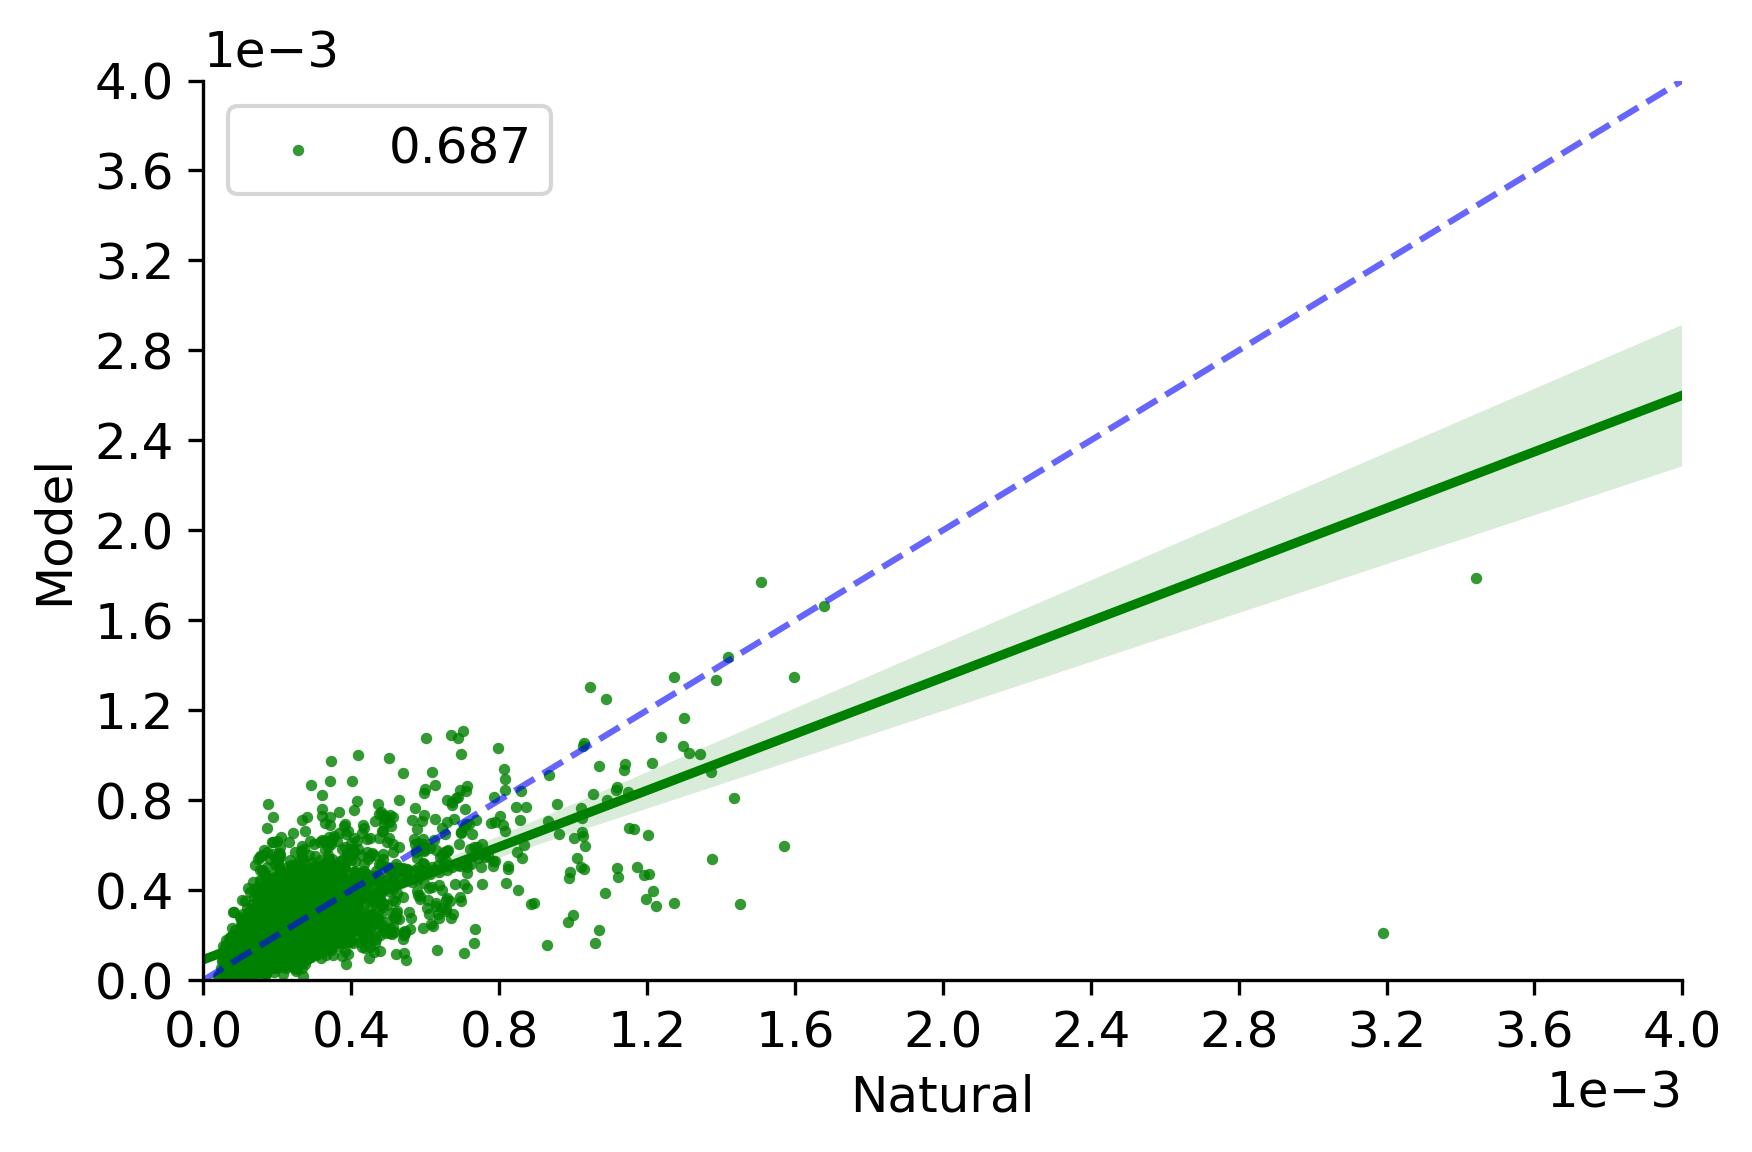

In [ ]:
## Step 3
# device = torch.device("cpu")

generator = WGAN_language(length=249)
generator_training_datapath = 'train_X.txt'
generator_modelpath = "./checkpoints/wgan/checkpoints/net_G_12.pth"
plot_kmer_with_model(generator, generator_modelpath,  generator_training_datapath,
                         report_path="./checkpoints/wgan/figure/results/", file_tag="WGAN_01")

## Step 4

generator_training_datapath = 'train_X.txt'
generator_sampling_datapath = './checkpoints/wgan/samples/sample_ep12_s0_num_10000.txt'
plot_kmer(generator_training_datapath, generator_sampling_datapath, report_path="./checkpoints/wgan/figure/results/", file_tag="WGAN_02")